# TESS Atlas fit for TOI 457

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 457.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-457.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-457.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-457.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 457

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 457 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

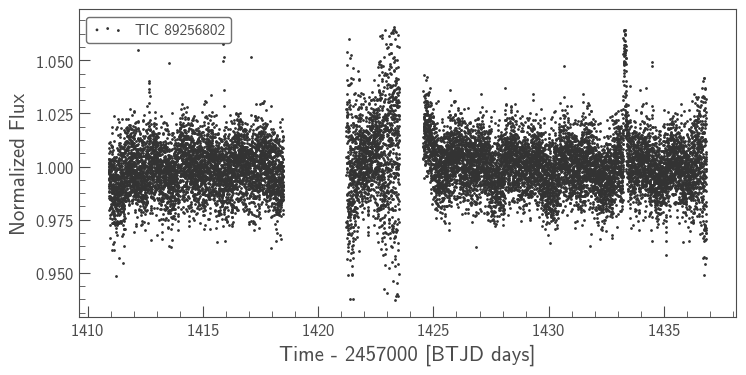

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -66228.55247791672 -> -65303.85264678138


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -60694.166456951396 -> -60672.86194795292


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -60672.86194795292 -> -60552.01971058662


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -60552.01971058662 -> -60552.006690986986


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -60552.006690986986 -> -60551.09059739428


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -60551.09059739428 -> -60551.08865276135


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -60551.08865276135 -> -60354.10568036927


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -60354.10568036926 -> -60354.10568036926


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -60354.10568036927 -> -60354.10568036927


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -60354.10568036927 -> -60354.105680369255


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -60354.105680369255 -> -60354.10568036906


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -60354.10568036906 -> -60354.10568036906


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -60354.10568036906 -> -60354.10568036906


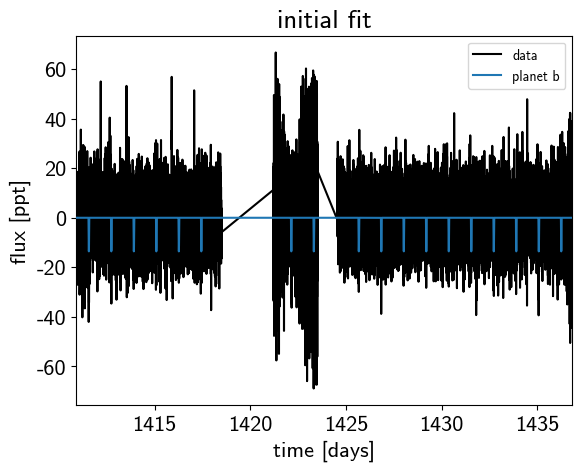

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:07, 12.49draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:11,  7.94draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:21,  4.34draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:26,  3.45draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:02<00:27,  3.37draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:30,  2.98draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:28,  3.11draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:03<00:34,  2.52draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:30,  2.86draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:04<00:33,  2.55draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:04<00:34,  2.46draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:31,  2.68draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:05<00:38,  2.14draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:06<00:35,  2.27draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:07<00:32,  2.41draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:07<00:26,  2.96draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:07<00:29,  2.61draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:08<00:30,  2.46draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:08<00:26,  2.80draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:09<00:33,  2.23draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:09<00:29,  2.44draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:10<00:28,  2.51draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:10<00:25,  2.77draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:10<00:26,  2.62draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:11<00:22,  3.03draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:11<00:24,  2.76draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:11<00:20,  3.18draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:12<00:22,  2.83draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:12<00:20,  3.10draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:12<00:22,  2.86draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:12<00:19,  3.19draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:13<00:21,  2.81draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:13<00:18,  3.29draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:14<00:20,  2.82draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:14<00:18,  3.18draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:14<00:22,  2.56draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:15<00:17,  3.26draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:15<00:22,  2.42draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:15<00:18,  2.93draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:16<00:20,  2.54draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:16<00:21,  2.46draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:17<00:18,  2.71draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:17<00:22,  2.24draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:17<00:17,  2.85draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:18<00:20,  2.32draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:18<00:15,  2.95draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:19<00:20,  2.29draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:19<00:16,  2.75draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:20<00:18,  2.34draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:20<00:15,  2.75draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:20<00:17,  2.43draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:20<00:13,  3.12draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:21<00:16,  2.42draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:22<00:15,  2.49draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:22<00:13,  2.58draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:23<00:12,  2.72draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:24<00:11,  2.84draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:24<00:08,  3.62draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:24<00:10,  2.82draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:24<00:08,  3.50draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:25<00:09,  2.80draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:25<00:07,  3.53draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:26<00:09,  2.79draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:26<00:07,  3.41draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:26<00:09,  2.52draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:27<00:07,  3.15draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:27<00:08,  2.52draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:27<00:08,  2.60draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:28<00:07,  2.56draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:28<00:08,  2.29draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:29<00:06,  2.83draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:29<00:08,  2.12draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:30<00:06,  2.30draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:31<00:05,  2.41draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:31<00:04,  2.53draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:32<00:02,  3.00draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:32<00:02,  2.92draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:33<00:02,  2.80draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:33<00:02,  2.82draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:33<00:01,  2.91draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:34<00:01,  2.73draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:34<00:00,  3.03draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:34<00:00,  2.73draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:37<00:01,  1.05s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [00:38<00:00,  1.12draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:00<00:06, 14.80draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:00<00:07, 11.90draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:25,  3.57draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:20,  4.30draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:30,  2.88draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:29,  3.03draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:30,  2.82draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:30,  2.82draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:29,  2.86draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:29,  2.85draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:30,  2.72draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:24,  3.35draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:28,  2.85draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:23,  3.38draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:29,  2.65draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:06<00:23,  3.32draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:29,  2.56draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:07<00:27,  2.66draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:07<00:23,  3.15draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:08<00:25,  2.81draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:08<00:23,  3.06draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:08<00:24,  2.81draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:08<00:23,  2.99draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:09<00:24,  2.82draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:09<00:21,  3.16draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:10<00:23,  2.82draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:10<00:19,  3.27draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:10<00:17,  3.52draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:10<00:14,  4.19draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:10<00:13,  4.69draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:11<00:19,  3.10draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:11<00:16,  3.64draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:12<00:21,  2.66draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:13<00:20,  2.73draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:13<00:19,  2.89draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:13<00:19,  2.84draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:14<00:20,  2.63draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:14<00:15,  3.34draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:14<00:20,  2.43draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:15<00:19,  2.54draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:16<00:17,  2.66draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:16<00:13,  3.38draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:16<00:16,  2.68draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:17<00:12,  3.41draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:17<00:16,  2.67draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:17<00:12,  3.24draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:18<00:13,  3.07draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:18<00:15,  2.57draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:18<00:11,  3.19draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:19<00:14,  2.60draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:19<00:11,  3.27draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:20<00:10,  3.20draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:20<00:10,  3.16draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:21<00:09,  3.14draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:22<00:07,  3.45draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:22<00:05,  4.58draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:22<00:07,  3.17draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:23<00:05,  3.93draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:23<00:07,  2.99draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:23<00:05,  3.55draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:24<00:06,  2.95draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:24<00:05,  3.31draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:24<00:06,  2.95draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:25<00:05,  3.13draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:25<00:04,  3.60draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:25<00:04,  3.39draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:26<00:03,  3.43draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:26<00:03,  3.10draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:26<00:03,  3.29draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:27<00:03,  2.99draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:27<00:03,  2.76draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:27<00:02,  3.09draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:28<00:02,  2.35draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:29<00:01,  2.73draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:29<00:01,  2.80draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:29<00:00,  2.87draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:32<00:01,  1.05s/draws]

Sampling 2 chains: 100%|██████████| 104/104 [00:32<00:00,  1.23draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<02:09,  1.57draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<01:36,  2.08draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:01<01:28,  2.24draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:02<01:21,  2.43draws/s]

Sampling 2 chains:   4%|▍         | 9/204 [00:02<01:15,  2.59draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:03<01:03,  3.03draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:03<01:12,  2.66draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:04<01:16,  2.52draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:04<01:05,  2.92draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:04<01:13,  2.59draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:04<01:05,  2.89draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:05<00:55,  3.38draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:05<00:44,  4.16draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:05<00:40,  4.60draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:06<01:02,  2.93draws/s]

Sampling 2 chains:  10%|█         | 21/204 [00:06<00:59,  3.09draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:06<00:50,  3.62draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:06<00:39,  4.51draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:07<01:04,  2.77draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:07<00:56,  3.14draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:08<01:02,  2.81draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:08<00:55,  3.17draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:08<00:44,  3.94draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:08<00:38,  4.46draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:08<00:35,  4.88draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:09<00:30,  5.54draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:09<00:49,  3.46draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:09<00:39,  4.29draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:10<00:44,  3.74draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:10<00:36,  4.53draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:10<00:47,  3.45draws/s]

Sampling 2 chains:  20%|█▉        | 40/204 [00:10<00:41,  3.93draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:11<00:40,  3.93draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:12<00:45,  3.48draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:12<00:38,  4.12draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:12<00:39,  3.95draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:13<00:33,  4.62draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:13<00:34,  4.45draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:13<00:33,  4.60draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:14<00:48,  3.13draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:14<00:43,  3.46draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:15<00:58,  2.54draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:15<00:50,  2.95draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:15<00:44,  3.29draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:16<00:45,  3.19draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:16<00:50,  2.86draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:16<00:49,  2.87draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:17<00:49,  2.86draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:17<00:48,  2.91draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:17<00:48,  2.87draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:18<00:50,  2.76draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:18<00:48,  2.85draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:19<00:49,  2.76draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:19<00:46,  2.93draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:19<00:49,  2.74draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:20<00:40,  3.29draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:20<00:33,  3.92draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:20<00:46,  2.81draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:21<00:38,  3.38draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:21<00:34,  3.72draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:21<00:42,  2.99draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:22<00:45,  2.80draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:22<00:44,  2.86draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:23<00:51,  2.41draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:23<00:48,  2.54draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:23<00:42,  2.86draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:24<00:37,  3.16draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:25<00:50,  2.36draws/s]

Sampling 2 chains:  43%|████▎     | 87/204 [00:25<00:49,  2.34draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:26<00:39,  2.89draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:26<00:43,  2.61draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:27<00:39,  2.87draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:27<00:39,  2.81draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:28<00:33,  3.23draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:28<00:31,  3.44draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:28<00:34,  3.09draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:29<00:32,  3.31draws/s]

Sampling 2 chains:  49%|████▊     | 99/204 [00:29<00:35,  2.96draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:29<00:32,  3.15draws/s]

Sampling 2 chains:  50%|████▉     | 101/204 [00:30<00:33,  3.05draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:30<00:36,  2.82draws/s]

Sampling 2 chains:  50%|█████     | 103/204 [00:30<00:33,  3.03draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:31<00:41,  2.38draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:32<00:41,  2.35draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:32<00:31,  3.05draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:33<00:42,  2.23draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:33<00:39,  2.35draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:34<00:33,  2.74draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:34<00:37,  2.47draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:34<00:31,  2.87draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:34<00:26,  3.43draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:35<00:26,  3.31draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:35<00:23,  3.68draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:35<00:22,  3.94draws/s]

Sampling 2 chains:  58%|█████▊    | 118/204 [00:36<00:26,  3.29draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:36<00:24,  3.41draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:36<00:26,  3.19draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:37<00:25,  3.22draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:37<00:30,  2.68draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:37<00:26,  3.09draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:37<00:21,  3.77draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:38<00:21,  3.60draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:38<00:21,  3.67draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:38<00:17,  4.49draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:39<00:24,  3.11draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:39<00:24,  3.03draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:40<00:23,  3.00draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:40<00:23,  3.04draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:41<00:20,  3.39draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:41<00:15,  4.44draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:41<00:25,  2.67draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:42<00:23,  2.78draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:42<00:17,  3.63draws/s]

Sampling 2 chains:  70%|███████   | 143/204 [00:43<00:17,  3.50draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:43<00:15,  3.93draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:43<00:20,  2.87draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:43<00:16,  3.62draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:44<00:13,  4.11draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:44<00:13,  4.06draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:44<00:14,  3.67draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:45<00:17,  3.00draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:45<00:14,  3.52draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:46<00:19,  2.61draws/s]

Sampling 2 chains:  76%|███████▌  | 155/204 [00:46<00:18,  2.66draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:47<00:19,  2.46draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:47<00:22,  2.13draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:47<00:17,  2.68draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:48<00:16,  2.70draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:48<00:14,  3.00draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:49<00:13,  3.03draws/s]

Sampling 2 chains:  80%|███████▉  | 163/204 [00:49<00:15,  2.66draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:50<00:13,  2.82draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:50<00:13,  2.77draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:51<00:12,  3.02draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:51<00:10,  3.48draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:51<00:11,  2.99draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:51<00:10,  3.33draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:52<00:08,  3.96draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:52<00:06,  4.79draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:52<00:07,  3.90draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:52<00:08,  3.51draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:53<00:09,  3.07draws/s]

Sampling 2 chains:  86%|████████▋ | 176/204 [00:53<00:10,  2.61draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:53<00:08,  3.26draws/s]

Sampling 2 chains:  87%|████████▋ | 178/204 [00:54<00:06,  3.92draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:54<00:06,  3.81draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [00:54<00:06,  3.77draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:54<00:05,  4.10draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:55<00:06,  3.21draws/s]

Sampling 2 chains:  90%|█████████ | 184/204 [00:55<00:05,  3.59draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:56<00:06,  2.84draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:56<00:05,  3.35draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:56<00:06,  2.70draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:57<00:04,  3.38draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:57<00:05,  2.75draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:57<00:04,  3.49draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:58<00:04,  2.67draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:58<00:03,  3.36draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:58<00:03,  3.14draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:58<00:02,  3.42draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:59<00:02,  3.77draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:59<00:02,  3.39draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:59<00:01,  3.87draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [01:00<00:01,  3.04draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [01:00<00:01,  2.49draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [01:01<00:01,  2.01draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [01:02<00:01,  1.78draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [01:03<00:00,  1.64draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [01:04<00:00,  1.35draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 4/404 [00:00<00:10, 36.44draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:16, 23.96draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:00<00:18, 21.27draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:00<00:20, 19.05draws/s]

Sampling 2 chains:   3%|▎         | 12/404 [00:00<00:24, 16.26draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:00<00:25, 15.34draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:00<00:21, 17.64draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:01<00:28, 13.68draws/s]

Sampling 2 chains:   5%|▌         | 22/404 [00:01<00:26, 14.38draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:01<00:22, 16.63draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:01<00:19, 19.62draws/s]

Sampling 2 chains:   8%|▊         | 32/404 [00:01<00:27, 13.34draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:02<00:25, 14.21draws/s]

Sampling 2 chains:   9%|▉         | 37/404 [00:02<00:23, 15.45draws/s]

Sampling 2 chains:  10%|▉         | 40/404 [00:02<00:24, 14.80draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:02<00:28, 12.86draws/s]

Sampling 2 chains:  11%|█         | 44/404 [00:02<00:28, 12.48draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:03<00:44,  8.04draws/s]

Sampling 2 chains:  12%|█▏        | 48/404 [00:03<00:40,  8.72draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:04<00:58,  6.03draws/s]

Sampling 2 chains:  13%|█▎        | 51/404 [00:04<01:07,  5.25draws/s]

Sampling 2 chains:  13%|█▎        | 52/404 [00:04<01:02,  5.60draws/s]

Sampling 2 chains:  13%|█▎        | 54/404 [00:04<00:53,  6.58draws/s]

Sampling 2 chains:  14%|█▎        | 55/404 [00:04<00:47,  7.32draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:04<00:54,  6.44draws/s]

Sampling 2 chains:  14%|█▍        | 57/404 [00:05<00:52,  6.57draws/s]

Sampling 2 chains:  15%|█▍        | 59/404 [00:05<00:43,  7.95draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:05<00:38,  8.82draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:05<00:40,  8.35draws/s]

Sampling 2 chains:  16%|█▌        | 64/404 [00:05<00:38,  8.76draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:05<00:31, 10.63draws/s]

Sampling 2 chains:  17%|█▋        | 69/404 [00:06<00:31, 10.64draws/s]

Sampling 2 chains:  18%|█▊        | 71/404 [00:06<00:33, 10.05draws/s]

Sampling 2 chains:  18%|█▊        | 73/404 [00:06<00:55,  5.99draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:07<00:46,  7.03draws/s]

Sampling 2 chains:  19%|█▉        | 76/404 [00:07<00:50,  6.51draws/s]

Sampling 2 chains:  19%|█▉        | 77/404 [00:07<00:45,  7.23draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:07<00:39,  8.27draws/s]

Sampling 2 chains:  20%|██        | 81/404 [00:07<00:33,  9.53draws/s]

Sampling 2 chains:  21%|██        | 84/404 [00:07<00:29, 10.90draws/s]

Sampling 2 chains:  21%|██▏       | 86/404 [00:08<00:27, 11.58draws/s]

Sampling 2 chains:  22%|██▏       | 89/404 [00:08<00:23, 13.41draws/s]

Sampling 2 chains:  23%|██▎       | 91/404 [00:08<00:30, 10.13draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:09<00:47,  6.52draws/s]

Sampling 2 chains:  24%|██▎       | 95/404 [00:09<01:11,  4.31draws/s]

Sampling 2 chains:  24%|██▍       | 96/404 [00:10<01:48,  2.84draws/s]

Sampling 2 chains:  24%|██▍       | 97/404 [00:10<01:30,  3.39draws/s]

Sampling 2 chains:  24%|██▍       | 98/404 [00:11<01:37,  3.13draws/s]

Sampling 2 chains:  25%|██▍       | 99/404 [00:11<01:34,  3.23draws/s]

Sampling 2 chains:  25%|██▌       | 101/404 [00:12<01:43,  2.94draws/s]

Sampling 2 chains:  25%|██▌       | 103/404 [00:12<01:44,  2.88draws/s]

Sampling 2 chains:  26%|██▌       | 105/404 [00:13<01:44,  2.86draws/s]

Sampling 2 chains:  26%|██▋       | 107/404 [00:14<01:51,  2.66draws/s]

Sampling 2 chains:  27%|██▋       | 109/404 [00:15<01:54,  2.57draws/s]

Sampling 2 chains:  27%|██▋       | 111/404 [00:16<01:51,  2.63draws/s]

Sampling 2 chains:  28%|██▊       | 113/404 [00:16<01:39,  2.93draws/s]

Sampling 2 chains:  28%|██▊       | 114/404 [00:16<01:26,  3.36draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:16<01:17,  3.73draws/s]

Sampling 2 chains:  29%|██▊       | 116/404 [00:17<01:09,  4.17draws/s]

Sampling 2 chains:  29%|██▉       | 117/404 [00:17<00:56,  5.05draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:17<00:57,  4.99draws/s]

Sampling 2 chains:  30%|██▉       | 120/404 [00:17<00:50,  5.65draws/s]

Sampling 2 chains:  30%|██▉       | 121/404 [00:17<00:54,  5.23draws/s]

Sampling 2 chains:  30%|███       | 122/404 [00:18<00:48,  5.76draws/s]

Sampling 2 chains:  30%|███       | 123/404 [00:18<00:58,  4.78draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:18<00:48,  5.71draws/s]

Sampling 2 chains:  31%|███       | 126/404 [00:18<00:42,  6.55draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:18<00:35,  7.82draws/s]

Sampling 2 chains:  32%|███▏      | 129/404 [00:18<00:33,  8.31draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:18<00:25, 10.54draws/s]

Sampling 2 chains:  33%|███▎      | 135/404 [00:19<00:29,  9.08draws/s]

Sampling 2 chains:  34%|███▍      | 137/404 [00:19<00:39,  6.71draws/s]

Sampling 2 chains:  34%|███▍      | 139/404 [00:20<00:42,  6.24draws/s]

Sampling 2 chains:  35%|███▍      | 141/404 [00:20<00:37,  7.02draws/s]

Sampling 2 chains:  35%|███▌      | 142/404 [00:20<00:52,  5.01draws/s]

Sampling 2 chains:  35%|███▌      | 143/404 [00:20<00:50,  5.13draws/s]

Sampling 2 chains:  36%|███▌      | 144/404 [00:21<00:55,  4.66draws/s]

Sampling 2 chains:  36%|███▋      | 147/404 [00:21<00:48,  5.29draws/s]

Sampling 2 chains:  37%|███▋      | 148/404 [00:21<00:52,  4.86draws/s]

Sampling 2 chains:  37%|███▋      | 149/404 [00:21<00:47,  5.32draws/s]

Sampling 2 chains:  37%|███▋      | 151/404 [00:22<00:45,  5.62draws/s]

Sampling 2 chains:  38%|███▊      | 153/404 [00:22<00:37,  6.77draws/s]

Sampling 2 chains:  38%|███▊      | 154/404 [00:22<00:35,  7.04draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:22<00:33,  7.45draws/s]

Sampling 2 chains:  39%|███▉      | 157/404 [00:22<00:27,  8.96draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:23<00:29,  8.31draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:23<00:25,  9.40draws/s]

Sampling 2 chains:  40%|████      | 163/404 [00:23<00:28,  8.31draws/s]

Sampling 2 chains:  41%|████      | 164/404 [00:23<00:28,  8.55draws/s]

Sampling 2 chains:  41%|████      | 166/404 [00:23<00:25,  9.16draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [00:24<00:24,  9.83draws/s]

Sampling 2 chains:  42%|████▏     | 171/404 [00:24<00:21, 10.72draws/s]

Sampling 2 chains:  43%|████▎     | 174/404 [00:24<00:18, 12.57draws/s]

Sampling 2 chains:  44%|████▎     | 176/404 [00:24<00:16, 14.09draws/s]

Sampling 2 chains:  44%|████▍     | 178/404 [00:24<00:17, 13.01draws/s]

Sampling 2 chains:  45%|████▍     | 180/404 [00:24<00:22,  9.85draws/s]

Sampling 2 chains:  45%|████▌     | 182/404 [00:25<00:20, 10.81draws/s]

Sampling 2 chains:  46%|████▌     | 184/404 [00:25<00:18, 11.90draws/s]

Sampling 2 chains:  46%|████▌     | 186/404 [00:25<00:20, 10.64draws/s]

Sampling 2 chains:  47%|████▋     | 188/404 [00:25<00:22,  9.58draws/s]

Sampling 2 chains:  47%|████▋     | 190/404 [00:25<00:24,  8.84draws/s]

Sampling 2 chains:  48%|████▊     | 192/404 [00:26<00:20, 10.48draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:26<00:19, 10.67draws/s]

Sampling 2 chains:  49%|████▉     | 197/404 [00:26<00:16, 12.21draws/s]

Sampling 2 chains:  49%|████▉     | 199/404 [00:26<00:16, 12.79draws/s]

Sampling 2 chains:  50%|████▉     | 201/404 [00:26<00:15, 13.51draws/s]

Sampling 2 chains:  50%|█████     | 203/404 [00:26<00:13, 14.53draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:26<00:12, 15.43draws/s]

Sampling 2 chains:  51%|█████▏    | 208/404 [00:27<00:12, 15.78draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:27<00:12, 15.48draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:27<00:10, 17.40draws/s]

Sampling 2 chains:  53%|█████▎    | 215/404 [00:27<00:11, 17.17draws/s]

Sampling 2 chains:  54%|█████▍    | 218/404 [00:27<00:11, 15.67draws/s]

Sampling 2 chains:  54%|█████▍    | 220/404 [00:27<00:12, 14.32draws/s]

Sampling 2 chains:  55%|█████▍    | 222/404 [00:28<00:11, 15.40draws/s]

Sampling 2 chains:  56%|█████▌    | 225/404 [00:28<00:10, 16.51draws/s]

Sampling 2 chains:  56%|█████▋    | 228/404 [00:28<00:09, 18.69draws/s]

Sampling 2 chains:  57%|█████▋    | 231/404 [00:28<00:09, 18.88draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:28<00:09, 17.26draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [00:28<00:08, 19.76draws/s]

Sampling 2 chains:  59%|█████▉    | 239/404 [00:28<00:08, 18.95draws/s]

Sampling 2 chains:  60%|█████▉    | 242/404 [00:29<00:09, 16.55draws/s]

Sampling 2 chains:  60%|██████    | 244/404 [00:29<00:10, 15.18draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:29<00:11, 13.56draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:29<00:10, 14.40draws/s]

Sampling 2 chains:  62%|██████▏   | 251/404 [00:29<00:10, 15.00draws/s]

Sampling 2 chains:  63%|██████▎   | 254/404 [00:29<00:08, 17.23draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:29<00:07, 19.09draws/s]

Sampling 2 chains:  64%|██████▍   | 260/404 [00:30<00:07, 19.58draws/s]

Sampling 2 chains:  65%|██████▌   | 263/404 [00:30<00:06, 21.49draws/s]

Sampling 2 chains:  66%|██████▋   | 268/404 [00:30<00:05, 23.04draws/s]

Sampling 2 chains:  67%|██████▋   | 271/404 [00:30<00:06, 19.17draws/s]

Sampling 2 chains:  68%|██████▊   | 274/404 [00:30<00:07, 17.14draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:30<00:06, 19.30draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [00:31<00:06, 19.02draws/s]

Sampling 2 chains:  70%|███████   | 283/404 [00:31<00:06, 19.57draws/s]

Sampling 2 chains:  71%|███████   | 286/404 [00:31<00:07, 16.78draws/s]

Sampling 2 chains:  71%|███████▏  | 288/404 [00:31<00:08, 14.01draws/s]

Sampling 2 chains:  72%|███████▏  | 291/404 [00:31<00:07, 15.36draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:31<00:07, 15.70draws/s]

Sampling 2 chains:  73%|███████▎  | 296/404 [00:32<00:06, 15.99draws/s]

Sampling 2 chains:  74%|███████▍  | 299/404 [00:32<00:06, 17.19draws/s]

Sampling 2 chains:  75%|███████▍  | 302/404 [00:32<00:05, 18.81draws/s]

Sampling 2 chains:  76%|███████▌  | 306/404 [00:32<00:04, 19.76draws/s]

Sampling 2 chains:  76%|███████▋  | 309/404 [00:32<00:04, 19.91draws/s]

Sampling 2 chains:  77%|███████▋  | 312/404 [00:32<00:04, 19.11draws/s]

Sampling 2 chains:  78%|███████▊  | 314/404 [00:33<00:06, 14.97draws/s]

Sampling 2 chains:  78%|███████▊  | 316/404 [00:33<00:05, 15.21draws/s]

Sampling 2 chains:  79%|███████▊  | 318/404 [00:33<00:05, 15.32draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [00:33<00:05, 15.48draws/s]

Sampling 2 chains:  80%|███████▉  | 322/404 [00:33<00:05, 15.73draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [00:33<00:04, 17.59draws/s]

Sampling 2 chains:  81%|████████  | 328/404 [00:33<00:03, 19.17draws/s]

Sampling 2 chains:  82%|████████▏ | 331/404 [00:34<00:04, 16.69draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [00:34<00:04, 16.41draws/s]

Sampling 2 chains:  83%|████████▎ | 335/404 [00:34<00:04, 16.20draws/s]

Sampling 2 chains:  83%|████████▎ | 337/404 [00:34<00:04, 16.71draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:34<00:03, 19.04draws/s]

Sampling 2 chains:  85%|████████▍ | 343/404 [00:34<00:03, 19.38draws/s]

Sampling 2 chains:  86%|████████▌ | 346/404 [00:34<00:03, 18.51draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [00:35<00:03, 16.82draws/s]

Sampling 2 chains:  87%|████████▋ | 350/404 [00:35<00:03, 17.40draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:35<00:03, 16.90draws/s]

Sampling 2 chains:  88%|████████▊ | 354/404 [00:35<00:03, 16.65draws/s]

Sampling 2 chains:  88%|████████▊ | 356/404 [00:35<00:02, 16.52draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [00:35<00:02, 16.15draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [00:35<00:02, 17.48draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [00:35<00:02, 19.09draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [00:36<00:01, 21.44draws/s]

Sampling 2 chains:  92%|█████████▏| 372/404 [00:36<00:01, 19.14draws/s]

Sampling 2 chains:  93%|█████████▎| 375/404 [00:36<00:01, 18.08draws/s]

Sampling 2 chains:  94%|█████████▍| 379/404 [00:36<00:01, 19.21draws/s]

Sampling 2 chains:  95%|█████████▍| 382/404 [00:36<00:01, 20.39draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:36<00:00, 20.87draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [00:37<00:00, 22.74draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:37<00:00, 19.53draws/s]

Sampling 2 chains:  98%|█████████▊| 395/404 [00:37<00:00, 17.31draws/s]

Sampling 2 chains:  98%|█████████▊| 397/404 [00:37<00:00, 13.77draws/s]

Sampling 2 chains:  99%|█████████▉| 399/404 [00:37<00:00, 10.27draws/s]

Sampling 2 chains:  99%|█████████▉| 401/404 [00:38<00:00,  9.12draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [00:38<00:00,  9.45draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:38<00:00, 10.45draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/804 [00:00<00:35, 22.62draws/s]

Sampling 2 chains:   1%|          | 7/804 [00:00<00:30, 25.96draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:00<00:46, 17.25draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:00<01:11, 11.08draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:01<01:25,  9.20draws/s]

Sampling 2 chains:   2%|▏         | 16/804 [00:01<01:46,  7.42draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:01<01:47,  7.35draws/s]

Sampling 2 chains:   2%|▏         | 18/804 [00:02<02:41,  4.88draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:02<02:50,  4.59draws/s]

Sampling 2 chains:   3%|▎         | 21/804 [00:02<02:27,  5.31draws/s]

Sampling 2 chains:   3%|▎         | 22/804 [00:02<02:32,  5.12draws/s]

Sampling 2 chains:   3%|▎         | 23/804 [00:02<02:16,  5.73draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:03<02:03,  6.29draws/s]

Sampling 2 chains:   3%|▎         | 25/804 [00:03<01:52,  6.93draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:03<01:29,  8.68draws/s]

Sampling 2 chains:   4%|▎         | 30/804 [00:03<01:30,  8.56draws/s]

Sampling 2 chains:   4%|▍         | 32/804 [00:04<02:19,  5.55draws/s]

Sampling 2 chains:   4%|▍         | 33/804 [00:04<02:09,  5.97draws/s]

Sampling 2 chains:   4%|▍         | 34/804 [00:04<02:20,  5.48draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:04<02:06,  6.07draws/s]

Sampling 2 chains:   5%|▍         | 37/804 [00:04<01:55,  6.67draws/s]

Sampling 2 chains:   5%|▍         | 39/804 [00:05<01:41,  7.53draws/s]

Sampling 2 chains:   5%|▌         | 43/804 [00:05<01:20,  9.45draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:05<01:09, 10.83draws/s]

Sampling 2 chains:   6%|▌         | 48/804 [00:05<01:30,  8.33draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:06<01:23,  9.02draws/s]

Sampling 2 chains:   6%|▋         | 52/804 [00:06<01:21,  9.23draws/s]

Sampling 2 chains:   7%|▋         | 54/804 [00:06<01:16,  9.75draws/s]

Sampling 2 chains:   7%|▋         | 56/804 [00:06<01:05, 11.41draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:06<00:53, 13.85draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:06<01:06, 11.10draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:07<00:58, 12.71draws/s]

Sampling 2 chains:   8%|▊         | 65/804 [00:07<00:52, 14.02draws/s]

Sampling 2 chains:   8%|▊         | 68/804 [00:07<00:44, 16.63draws/s]

Sampling 2 chains:   9%|▉         | 71/804 [00:07<00:56, 13.02draws/s]

Sampling 2 chains:   9%|▉         | 73/804 [00:07<01:02, 11.63draws/s]

Sampling 2 chains:   9%|▉         | 75/804 [00:08<01:09, 10.53draws/s]

Sampling 2 chains:  10%|▉         | 77/804 [00:08<01:03, 11.43draws/s]

Sampling 2 chains:  10%|▉         | 79/804 [00:08<01:06, 10.87draws/s]

Sampling 2 chains:  10%|█         | 81/804 [00:08<01:08, 10.54draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:08<00:58, 12.23draws/s]

Sampling 2 chains:  11%|█         | 86/804 [00:08<01:02, 11.52draws/s]

Sampling 2 chains:  11%|█         | 88/804 [00:09<01:18,  9.15draws/s]

Sampling 2 chains:  11%|█         | 90/804 [00:09<01:27,  8.20draws/s]

Sampling 2 chains:  12%|█▏        | 93/804 [00:09<01:15,  9.46draws/s]

Sampling 2 chains:  12%|█▏        | 95/804 [00:09<01:15,  9.45draws/s]

Sampling 2 chains:  12%|█▏        | 97/804 [00:10<01:14,  9.47draws/s]

Sampling 2 chains:  12%|█▏        | 99/804 [00:10<01:16,  9.26draws/s]

Sampling 2 chains:  13%|█▎        | 102/804 [00:10<01:03, 11.13draws/s]

Sampling 2 chains:  13%|█▎        | 104/804 [00:10<01:24,  8.25draws/s]

Sampling 2 chains:  13%|█▎        | 106/804 [00:11<01:22,  8.50draws/s]

Sampling 2 chains:  13%|█▎        | 108/804 [00:11<01:12,  9.63draws/s]

Sampling 2 chains:  14%|█▎        | 110/804 [00:11<01:13,  9.48draws/s]

Sampling 2 chains:  14%|█▍        | 112/804 [00:11<01:08, 10.08draws/s]

Sampling 2 chains:  14%|█▍        | 114/804 [00:11<01:07, 10.18draws/s]

Sampling 2 chains:  14%|█▍        | 116/804 [00:12<01:01, 11.22draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:12<00:56, 12.22draws/s]

Sampling 2 chains:  15%|█▍        | 120/804 [00:12<01:03, 10.79draws/s]

Sampling 2 chains:  15%|█▌        | 122/804 [00:12<01:03, 10.74draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:12<01:04, 10.56draws/s]

Sampling 2 chains:  16%|█▌        | 127/804 [00:12<00:53, 12.58draws/s]

Sampling 2 chains:  16%|█▌        | 129/804 [00:13<00:56, 11.86draws/s]

Sampling 2 chains:  16%|█▋        | 132/804 [00:13<00:49, 13.66draws/s]

Sampling 2 chains:  17%|█▋        | 134/804 [00:13<00:50, 13.29draws/s]

Sampling 2 chains:  17%|█▋        | 136/804 [00:13<00:45, 14.60draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:13<00:55, 12.07draws/s]

Sampling 2 chains:  17%|█▋        | 140/804 [00:14<01:21,  8.14draws/s]

Sampling 2 chains:  18%|█▊        | 142/804 [00:14<02:11,  5.02draws/s]

Sampling 2 chains:  18%|█▊        | 143/804 [00:15<02:03,  5.35draws/s]

Sampling 2 chains:  18%|█▊        | 144/804 [00:15<02:06,  5.20draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:15<01:53,  5.82draws/s]

Sampling 2 chains:  18%|█▊        | 146/804 [00:15<01:59,  5.50draws/s]

Sampling 2 chains:  18%|█▊        | 148/804 [00:15<01:34,  6.92draws/s]

Sampling 2 chains:  19%|█▊        | 150/804 [00:15<01:30,  7.23draws/s]

Sampling 2 chains:  19%|█▉        | 152/804 [00:16<01:17,  8.43draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:16<01:04, 10.09draws/s]

Sampling 2 chains:  20%|█▉        | 157/804 [00:16<01:00, 10.76draws/s]

Sampling 2 chains:  20%|█▉        | 159/804 [00:16<00:57, 11.16draws/s]

Sampling 2 chains:  20%|██        | 161/804 [00:16<00:54, 11.86draws/s]

Sampling 2 chains:  20%|██        | 163/804 [00:16<00:50, 12.63draws/s]

Sampling 2 chains:  21%|██        | 165/804 [00:17<00:50, 12.73draws/s]

Sampling 2 chains:  21%|██        | 167/804 [00:17<00:56, 11.31draws/s]

Sampling 2 chains:  21%|██        | 169/804 [00:17<01:05,  9.75draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:17<01:15,  8.36draws/s]

Sampling 2 chains:  22%|██▏       | 174/804 [00:17<01:01, 10.29draws/s]

Sampling 2 chains:  22%|██▏       | 176/804 [00:18<01:03,  9.82draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:18<00:54, 11.48draws/s]

Sampling 2 chains:  22%|██▏       | 180/804 [00:18<01:00, 10.31draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:18<01:03,  9.77draws/s]

Sampling 2 chains:  23%|██▎       | 184/804 [00:18<01:01, 10.07draws/s]

Sampling 2 chains:  23%|██▎       | 186/804 [00:19<01:10,  8.75draws/s]

Sampling 2 chains:  23%|██▎       | 187/804 [00:19<01:12,  8.51draws/s]

Sampling 2 chains:  23%|██▎       | 188/804 [00:19<01:14,  8.30draws/s]

Sampling 2 chains:  24%|██▎       | 189/804 [00:19<01:24,  7.31draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:19<01:17,  7.91draws/s]

Sampling 2 chains:  24%|██▍       | 191/804 [00:19<01:29,  6.85draws/s]

Sampling 2 chains:  24%|██▍       | 193/804 [00:20<01:17,  7.91draws/s]

Sampling 2 chains:  24%|██▍       | 194/804 [00:20<01:17,  7.90draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [00:20<01:16,  7.93draws/s]

Sampling 2 chains:  25%|██▍       | 197/804 [00:20<01:08,  8.87draws/s]

Sampling 2 chains:  25%|██▍       | 198/804 [00:20<01:10,  8.65draws/s]

Sampling 2 chains:  25%|██▍       | 200/804 [00:20<01:00,  9.96draws/s]

Sampling 2 chains:  25%|██▌       | 202/804 [00:20<00:52, 11.40draws/s]

Sampling 2 chains:  25%|██▌       | 205/804 [00:21<00:43, 13.92draws/s]

Sampling 2 chains:  26%|██▌       | 208/804 [00:21<00:40, 14.86draws/s]

Sampling 2 chains:  26%|██▌       | 211/804 [00:21<00:39, 14.85draws/s]

Sampling 2 chains:  26%|██▋       | 213/804 [00:21<00:48, 12.18draws/s]

Sampling 2 chains:  27%|██▋       | 215/804 [00:21<00:44, 13.15draws/s]

Sampling 2 chains:  27%|██▋       | 218/804 [00:21<00:38, 15.27draws/s]

Sampling 2 chains:  27%|██▋       | 220/804 [00:22<00:36, 15.80draws/s]

Sampling 2 chains:  28%|██▊       | 222/804 [00:22<00:37, 15.58draws/s]

Sampling 2 chains:  28%|██▊       | 226/804 [00:22<00:31, 18.36draws/s]

Sampling 2 chains:  28%|██▊       | 229/804 [00:22<00:27, 20.63draws/s]

Sampling 2 chains:  29%|██▉       | 232/804 [00:22<00:33, 16.97draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [00:22<00:38, 14.92draws/s]

Sampling 2 chains:  29%|██▉       | 237/804 [00:23<00:38, 14.59draws/s]

Sampling 2 chains:  30%|██▉       | 239/804 [00:23<00:40, 13.90draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [00:23<00:38, 14.78draws/s]

Sampling 2 chains:  30%|███       | 243/804 [00:23<00:48, 11.66draws/s]

Sampling 2 chains:  31%|███       | 246/804 [00:23<00:39, 14.19draws/s]

Sampling 2 chains:  31%|███       | 248/804 [00:23<00:46, 11.84draws/s]

Sampling 2 chains:  31%|███       | 250/804 [00:24<00:52, 10.58draws/s]

Sampling 2 chains:  31%|███▏      | 252/804 [00:24<00:47, 11.71draws/s]

Sampling 2 chains:  32%|███▏      | 255/804 [00:24<00:43, 12.62draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:24<00:37, 14.68draws/s]

Sampling 2 chains:  32%|███▏      | 260/804 [00:24<00:35, 15.36draws/s]

Sampling 2 chains:  33%|███▎      | 262/804 [00:24<00:33, 16.29draws/s]

Sampling 2 chains:  33%|███▎      | 264/804 [00:24<00:33, 16.34draws/s]

Sampling 2 chains:  33%|███▎      | 266/804 [00:25<00:34, 15.57draws/s]

Sampling 2 chains:  33%|███▎      | 268/804 [00:25<00:33, 16.15draws/s]

Sampling 2 chains:  34%|███▎      | 270/804 [00:25<00:37, 14.06draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:25<00:37, 14.28draws/s]

Sampling 2 chains:  34%|███▍      | 275/804 [00:25<00:40, 13.18draws/s]

Sampling 2 chains:  34%|███▍      | 277/804 [00:25<00:41, 12.74draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [00:26<00:38, 13.63draws/s]

Sampling 2 chains:  35%|███▍      | 281/804 [00:26<00:35, 14.74draws/s]

Sampling 2 chains:  35%|███▌      | 283/804 [00:26<00:40, 12.91draws/s]

Sampling 2 chains:  35%|███▌      | 285/804 [00:26<00:42, 12.08draws/s]

Sampling 2 chains:  36%|███▌      | 287/804 [00:26<00:50, 10.28draws/s]

Sampling 2 chains:  36%|███▌      | 289/804 [00:26<00:48, 10.63draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [00:27<00:41, 12.33draws/s]

Sampling 2 chains:  37%|███▋      | 294/804 [00:27<00:43, 11.86draws/s]

Sampling 2 chains:  37%|███▋      | 296/804 [00:27<00:42, 11.83draws/s]

Sampling 2 chains:  37%|███▋      | 299/804 [00:27<00:41, 12.30draws/s]

Sampling 2 chains:  37%|███▋      | 301/804 [00:27<00:38, 13.04draws/s]

Sampling 2 chains:  38%|███▊      | 303/804 [00:28<00:41, 11.97draws/s]

Sampling 2 chains:  38%|███▊      | 305/804 [00:28<00:49, 10.15draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [00:28<00:41, 11.87draws/s]

Sampling 2 chains:  38%|███▊      | 309/804 [00:28<00:39, 12.39draws/s]

Sampling 2 chains:  39%|███▊      | 311/804 [00:28<00:44, 11.15draws/s]

Sampling 2 chains:  39%|███▉      | 313/804 [00:28<00:44, 10.97draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [00:29<00:38, 12.63draws/s]

Sampling 2 chains:  39%|███▉      | 317/804 [00:29<00:36, 13.52draws/s]

Sampling 2 chains:  40%|███▉      | 319/804 [00:29<00:50,  9.68draws/s]

Sampling 2 chains:  40%|███▉      | 321/804 [00:29<00:48,  9.95draws/s]

Sampling 2 chains:  40%|████      | 323/804 [00:29<00:53,  9.06draws/s]

Sampling 2 chains:  40%|████      | 325/804 [00:30<00:50,  9.55draws/s]

Sampling 2 chains:  41%|████      | 327/804 [00:30<00:42, 11.30draws/s]

Sampling 2 chains:  41%|████      | 329/804 [00:30<00:37, 12.75draws/s]

Sampling 2 chains:  41%|████      | 331/804 [00:30<00:38, 12.45draws/s]

Sampling 2 chains:  41%|████▏     | 333/804 [00:30<00:47,  9.85draws/s]

Sampling 2 chains:  42%|████▏     | 335/804 [00:31<00:52,  8.96draws/s]

Sampling 2 chains:  42%|████▏     | 337/804 [00:31<00:53,  8.68draws/s]

Sampling 2 chains:  42%|████▏     | 339/804 [00:31<00:53,  8.67draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [00:31<00:52,  8.79draws/s]

Sampling 2 chains:  43%|████▎     | 342/804 [00:31<00:48,  9.55draws/s]

Sampling 2 chains:  43%|████▎     | 344/804 [00:32<00:44, 10.44draws/s]

Sampling 2 chains:  43%|████▎     | 346/804 [00:32<00:48,  9.48draws/s]

Sampling 2 chains:  43%|████▎     | 348/804 [00:32<00:45, 10.01draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [00:32<00:45, 10.03draws/s]

Sampling 2 chains:  44%|████▍     | 352/804 [00:32<00:49,  9.09draws/s]

Sampling 2 chains:  44%|████▍     | 353/804 [00:33<00:53,  8.38draws/s]

Sampling 2 chains:  44%|████▍     | 354/804 [00:33<00:51,  8.67draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [00:33<00:48,  9.31draws/s]

Sampling 2 chains:  44%|████▍     | 357/804 [00:33<00:54,  8.20draws/s]

Sampling 2 chains:  45%|████▍     | 359/804 [00:33<00:58,  7.65draws/s]

Sampling 2 chains:  45%|████▍     | 361/804 [00:33<00:50,  8.75draws/s]

Sampling 2 chains:  45%|████▌     | 362/804 [00:34<00:48,  9.02draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [00:34<00:48,  9.02draws/s]

Sampling 2 chains:  45%|████▌     | 365/804 [00:34<00:48,  8.97draws/s]

Sampling 2 chains:  46%|████▌     | 367/804 [00:34<00:43,  9.93draws/s]

Sampling 2 chains:  46%|████▌     | 369/804 [00:34<00:40, 10.61draws/s]

Sampling 2 chains:  46%|████▌     | 371/804 [00:34<00:36, 11.72draws/s]

Sampling 2 chains:  46%|████▋     | 373/804 [00:34<00:33, 12.89draws/s]

Sampling 2 chains:  47%|████▋     | 375/804 [00:35<00:35, 12.17draws/s]

Sampling 2 chains:  47%|████▋     | 377/804 [00:35<00:31, 13.57draws/s]

Sampling 2 chains:  47%|████▋     | 379/804 [00:35<00:29, 14.44draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [00:35<00:33, 12.59draws/s]

Sampling 2 chains:  48%|████▊     | 383/804 [00:35<00:32, 12.96draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:35<00:36, 11.45draws/s]

Sampling 2 chains:  48%|████▊     | 387/804 [00:36<00:32, 12.68draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [00:36<00:36, 11.26draws/s]

Sampling 2 chains:  49%|████▊     | 391/804 [00:36<00:33, 12.41draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:36<00:30, 13.57draws/s]

Sampling 2 chains:  49%|████▉     | 395/804 [00:36<00:28, 14.46draws/s]

Sampling 2 chains:  50%|████▉     | 398/804 [00:36<00:25, 15.63draws/s]

Sampling 2 chains:  50%|████▉     | 400/804 [00:36<00:24, 16.20draws/s]

Sampling 2 chains:  50%|█████     | 403/804 [00:37<00:24, 16.35draws/s]

Sampling 2 chains:  50%|█████     | 406/804 [00:37<00:24, 16.42draws/s]

Sampling 2 chains:  51%|█████     | 410/804 [00:37<00:19, 19.74draws/s]

Sampling 2 chains:  51%|█████▏    | 413/804 [00:37<00:19, 20.02draws/s]

Sampling 2 chains:  52%|█████▏    | 417/804 [00:37<00:17, 22.70draws/s]

Sampling 2 chains:  52%|█████▏    | 420/804 [00:37<00:17, 22.08draws/s]

Sampling 2 chains:  53%|█████▎    | 423/804 [00:37<00:18, 20.92draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [00:38<00:18, 20.86draws/s]

Sampling 2 chains:  53%|█████▎    | 429/804 [00:38<00:17, 21.30draws/s]

Sampling 2 chains:  54%|█████▎    | 432/804 [00:38<00:18, 19.92draws/s]

Sampling 2 chains:  54%|█████▍    | 435/804 [00:38<00:17, 20.91draws/s]

Sampling 2 chains:  54%|█████▍    | 438/804 [00:38<00:18, 19.82draws/s]

Sampling 2 chains:  55%|█████▍    | 442/804 [00:38<00:16, 22.53draws/s]

Sampling 2 chains:  55%|█████▌    | 446/804 [00:38<00:14, 24.11draws/s]

Sampling 2 chains:  56%|█████▌    | 449/804 [00:39<00:16, 21.38draws/s]

Sampling 2 chains:  56%|█████▌    | 452/804 [00:39<00:18, 19.26draws/s]

Sampling 2 chains:  57%|█████▋    | 455/804 [00:39<00:20, 16.62draws/s]

Sampling 2 chains:  57%|█████▋    | 457/804 [00:39<00:23, 14.60draws/s]

Sampling 2 chains:  57%|█████▋    | 459/804 [00:39<00:22, 15.48draws/s]

Sampling 2 chains:  57%|█████▋    | 461/804 [00:40<00:24, 13.96draws/s]

Sampling 2 chains:  58%|█████▊    | 463/804 [00:40<00:23, 14.68draws/s]

Sampling 2 chains:  58%|█████▊    | 465/804 [00:40<00:21, 15.87draws/s]

Sampling 2 chains:  58%|█████▊    | 467/804 [00:40<00:20, 16.72draws/s]

Sampling 2 chains:  58%|█████▊    | 469/804 [00:40<00:20, 16.10draws/s]

Sampling 2 chains:  59%|█████▉    | 473/804 [00:40<00:18, 18.05draws/s]

Sampling 2 chains:  59%|█████▉    | 475/804 [00:40<00:17, 18.53draws/s]

Sampling 2 chains:  59%|█████▉    | 477/804 [00:40<00:17, 18.55draws/s]

Sampling 2 chains:  60%|█████▉    | 480/804 [00:40<00:16, 20.14draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [00:41<00:15, 21.34draws/s]

Sampling 2 chains:  60%|██████    | 486/804 [00:41<00:17, 18.20draws/s]

Sampling 2 chains:  61%|██████    | 488/804 [00:41<00:17, 18.59draws/s]

Sampling 2 chains:  61%|██████    | 490/804 [00:41<00:20, 15.66draws/s]

Sampling 2 chains:  61%|██████    | 492/804 [00:41<00:18, 16.69draws/s]

Sampling 2 chains:  61%|██████▏   | 494/804 [00:41<00:17, 17.33draws/s]

Sampling 2 chains:  62%|██████▏   | 497/804 [00:41<00:15, 19.43draws/s]

Sampling 2 chains:  62%|██████▏   | 500/804 [00:42<00:16, 18.88draws/s]

Sampling 2 chains:  62%|██████▏   | 502/804 [00:42<00:16, 18.22draws/s]

Sampling 2 chains:  63%|██████▎   | 504/804 [00:42<00:16, 18.40draws/s]

Sampling 2 chains:  63%|██████▎   | 507/804 [00:42<00:16, 18.09draws/s]

Sampling 2 chains:  63%|██████▎   | 510/804 [00:42<00:15, 18.81draws/s]

Sampling 2 chains:  64%|██████▍   | 513/804 [00:42<00:18, 15.97draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [00:43<00:24, 11.58draws/s]

Sampling 2 chains:  64%|██████▍   | 517/804 [00:43<00:25, 11.48draws/s]

Sampling 2 chains:  65%|██████▍   | 519/804 [00:43<00:27, 10.40draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [00:43<00:24, 11.39draws/s]

Sampling 2 chains:  65%|██████▌   | 524/804 [00:43<00:22, 12.50draws/s]

Sampling 2 chains:  65%|██████▌   | 526/804 [00:44<00:19, 13.99draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [00:44<00:18, 15.05draws/s]

Sampling 2 chains:  66%|██████▌   | 530/804 [00:44<00:18, 15.22draws/s]

Sampling 2 chains:  66%|██████▋   | 533/804 [00:44<00:15, 17.18draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [00:44<00:14, 17.94draws/s]

Sampling 2 chains:  67%|██████▋   | 538/804 [00:44<00:15, 17.09draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [00:44<00:16, 16.43draws/s]

Sampling 2 chains:  68%|██████▊   | 543/804 [00:44<00:14, 17.95draws/s]

Sampling 2 chains:  68%|██████▊   | 545/804 [00:45<00:14, 18.39draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [00:45<00:18, 13.84draws/s]

Sampling 2 chains:  68%|██████▊   | 549/804 [00:45<00:16, 15.20draws/s]

Sampling 2 chains:  69%|██████▊   | 551/804 [00:45<00:21, 11.99draws/s]

Sampling 2 chains:  69%|██████▉   | 553/804 [00:45<00:20, 12.52draws/s]

Sampling 2 chains:  69%|██████▉   | 555/804 [00:45<00:19, 13.07draws/s]

Sampling 2 chains:  69%|██████▉   | 558/804 [00:46<00:16, 14.88draws/s]

Sampling 2 chains:  70%|██████▉   | 560/804 [00:46<00:15, 15.96draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [00:46<00:13, 17.65draws/s]

Sampling 2 chains:  70%|███████   | 566/804 [00:46<00:16, 14.67draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:46<00:15, 15.42draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [00:46<00:13, 17.56draws/s]

Sampling 2 chains:  71%|███████▏  | 573/804 [00:46<00:14, 16.30draws/s]

Sampling 2 chains:  72%|███████▏  | 575/804 [00:47<00:13, 16.95draws/s]

Sampling 2 chains:  72%|███████▏  | 577/804 [00:47<00:13, 16.98draws/s]

Sampling 2 chains:  72%|███████▏  | 579/804 [00:47<00:13, 17.00draws/s]

Sampling 2 chains:  72%|███████▏  | 581/804 [00:47<00:13, 16.28draws/s]

Sampling 2 chains:  73%|███████▎  | 584/804 [00:47<00:14, 15.43draws/s]

Sampling 2 chains:  73%|███████▎  | 587/804 [00:47<00:13, 16.46draws/s]

Sampling 2 chains:  73%|███████▎  | 589/804 [00:47<00:12, 16.60draws/s]

Sampling 2 chains:  74%|███████▎  | 591/804 [00:48<00:13, 15.66draws/s]

Sampling 2 chains:  74%|███████▍  | 593/804 [00:48<00:13, 15.31draws/s]

Sampling 2 chains:  74%|███████▍  | 595/804 [00:48<00:13, 15.47draws/s]

Sampling 2 chains:  75%|███████▍  | 599/804 [00:48<00:11, 17.87draws/s]

Sampling 2 chains:  75%|███████▍  | 601/804 [00:48<00:11, 18.41draws/s]

Sampling 2 chains:  75%|███████▌  | 603/804 [00:48<00:10, 18.76draws/s]

Sampling 2 chains:  75%|███████▌  | 606/804 [00:48<00:10, 18.69draws/s]

Sampling 2 chains:  76%|███████▌  | 609/804 [00:48<00:09, 20.55draws/s]

Sampling 2 chains:  76%|███████▌  | 612/804 [00:49<00:10, 18.84draws/s]

Sampling 2 chains:  76%|███████▋  | 614/804 [00:49<00:10, 17.96draws/s]

Sampling 2 chains:  77%|███████▋  | 617/804 [00:49<00:10, 17.78draws/s]

Sampling 2 chains:  77%|███████▋  | 621/804 [00:49<00:09, 18.85draws/s]

Sampling 2 chains:  78%|███████▊  | 625/804 [00:49<00:08, 21.72draws/s]

Sampling 2 chains:  78%|███████▊  | 630/804 [00:49<00:07, 23.74draws/s]

Sampling 2 chains:  79%|███████▊  | 633/804 [00:49<00:07, 22.98draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:50<00:09, 18.66draws/s]

Sampling 2 chains:  79%|███████▉  | 639/804 [00:50<00:10, 16.30draws/s]

Sampling 2 chains:  80%|███████▉  | 642/804 [00:50<00:09, 16.32draws/s]

Sampling 2 chains:  80%|████████  | 644/804 [00:50<00:10, 15.26draws/s]

Sampling 2 chains:  80%|████████  | 646/804 [00:50<00:11, 14.00draws/s]

Sampling 2 chains:  81%|████████  | 649/804 [00:51<00:10, 14.63draws/s]

Sampling 2 chains:  81%|████████  | 651/804 [00:51<00:11, 13.79draws/s]

Sampling 2 chains:  81%|████████  | 653/804 [00:52<00:31,  4.81draws/s]

Sampling 2 chains:  81%|████████▏ | 655/804 [00:54<01:01,  2.40draws/s]

Sampling 2 chains:  82%|████████▏ | 656/804 [00:55<01:35,  1.55draws/s]

Sampling 2 chains:  82%|████████▏ | 657/804 [00:55<01:24,  1.75draws/s]

Sampling 2 chains:  82%|████████▏ | 658/804 [00:56<01:45,  1.38draws/s]

Sampling 2 chains:  82%|████████▏ | 659/804 [00:57<01:46,  1.36draws/s]

Sampling 2 chains:  82%|████████▏ | 660/804 [00:57<01:22,  1.75draws/s]

Sampling 2 chains:  82%|████████▏ | 661/804 [00:58<01:29,  1.60draws/s]

Sampling 2 chains:  82%|████████▏ | 662/804 [00:59<01:46,  1.33draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [01:00<01:58,  1.19draws/s]

Sampling 2 chains:  83%|████████▎ | 664/804 [01:00<01:30,  1.54draws/s]

Sampling 2 chains:  83%|████████▎ | 665/804 [01:01<01:22,  1.69draws/s]

Sampling 2 chains:  83%|████████▎ | 666/804 [01:01<01:09,  2.00draws/s]

Sampling 2 chains:  83%|████████▎ | 667/804 [01:02<01:20,  1.69draws/s]

Sampling 2 chains:  83%|████████▎ | 668/804 [01:02<01:16,  1.77draws/s]

Sampling 2 chains:  83%|████████▎ | 669/804 [01:03<01:14,  1.80draws/s]

Sampling 2 chains:  83%|████████▎ | 670/804 [01:04<01:17,  1.73draws/s]

Sampling 2 chains:  83%|████████▎ | 671/804 [01:04<01:06,  2.01draws/s]

Sampling 2 chains:  84%|████████▎ | 672/804 [01:04<00:59,  2.23draws/s]

Sampling 2 chains:  84%|████████▎ | 673/804 [01:04<00:47,  2.78draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [01:07<02:26,  1.12s/draws]

Sampling 2 chains:  84%|████████▍ | 675/804 [01:11<04:01,  1.87s/draws]

Sampling 2 chains:  84%|████████▍ | 676/804 [01:14<04:38,  2.17s/draws]

Sampling 2 chains:  84%|████████▍ | 677/804 [01:17<05:09,  2.44s/draws]

Sampling 2 chains:  84%|████████▍ | 678/804 [01:20<05:30,  2.63s/draws]

Sampling 2 chains:  84%|████████▍ | 679/804 [01:23<05:38,  2.71s/draws]

Sampling 2 chains:  85%|████████▍ | 680/804 [01:26<05:43,  2.77s/draws]

Sampling 2 chains:  85%|████████▍ | 681/804 [01:29<05:45,  2.81s/draws]

Sampling 2 chains:  85%|████████▍ | 682/804 [01:32<05:49,  2.87s/draws]

Sampling 2 chains:  85%|████████▍ | 683/804 [01:35<05:50,  2.90s/draws]

Sampling 2 chains:  85%|████████▌ | 684/804 [01:38<05:52,  2.94s/draws]

Sampling 2 chains:  85%|████████▌ | 685/804 [01:40<05:40,  2.87s/draws]

Sampling 2 chains:  85%|████████▌ | 686/804 [01:43<05:34,  2.84s/draws]

Sampling 2 chains:  85%|████████▌ | 687/804 [01:46<05:36,  2.88s/draws]

Sampling 2 chains:  86%|████████▌ | 688/804 [01:49<05:38,  2.92s/draws]

Sampling 2 chains:  86%|████████▌ | 689/804 [01:52<05:24,  2.82s/draws]

Sampling 2 chains:  86%|████████▌ | 690/804 [01:54<05:22,  2.83s/draws]

Sampling 2 chains:  86%|████████▌ | 691/804 [01:57<05:17,  2.81s/draws]

Sampling 2 chains:  86%|████████▌ | 692/804 [02:00<05:13,  2.80s/draws]

Sampling 2 chains:  86%|████████▌ | 693/804 [02:03<05:07,  2.77s/draws]

Sampling 2 chains:  86%|████████▋ | 694/804 [02:06<05:18,  2.89s/draws]

Sampling 2 chains:  86%|████████▋ | 695/804 [02:08<05:00,  2.76s/draws]

Sampling 2 chains:  87%|████████▋ | 696/804 [02:11<04:56,  2.74s/draws]

Sampling 2 chains:  87%|████████▋ | 697/804 [02:13<04:40,  2.62s/draws]

Sampling 2 chains:  87%|████████▋ | 698/804 [02:16<04:42,  2.66s/draws]

Sampling 2 chains:  87%|████████▋ | 699/804 [02:19<04:52,  2.79s/draws]

Sampling 2 chains:  87%|████████▋ | 700/804 [02:23<05:17,  3.05s/draws]

Sampling 2 chains:  87%|████████▋ | 701/804 [02:26<05:29,  3.20s/draws]

Sampling 2 chains:  87%|████████▋ | 702/804 [02:29<05:09,  3.03s/draws]

Sampling 2 chains:  87%|████████▋ | 703/804 [02:32<04:55,  2.93s/draws]

Sampling 2 chains:  88%|████████▊ | 704/804 [02:34<04:44,  2.85s/draws]

Sampling 2 chains:  88%|████████▊ | 705/804 [02:37<04:36,  2.79s/draws]

Sampling 2 chains:  88%|████████▊ | 706/804 [02:40<04:33,  2.79s/draws]

Sampling 2 chains:  88%|████████▊ | 707/804 [02:43<04:43,  2.92s/draws]

Sampling 2 chains:  88%|████████▊ | 708/804 [02:46<04:33,  2.85s/draws]

Sampling 2 chains:  88%|████████▊ | 709/804 [02:49<04:33,  2.88s/draws]

Sampling 2 chains:  88%|████████▊ | 710/804 [02:51<04:21,  2.78s/draws]

Sampling 2 chains:  88%|████████▊ | 711/804 [02:54<04:13,  2.72s/draws]

Sampling 2 chains:  89%|████████▊ | 712/804 [02:56<04:07,  2.69s/draws]

Sampling 2 chains:  89%|████████▊ | 713/804 [02:59<04:03,  2.67s/draws]

Sampling 2 chains:  89%|████████▉ | 714/804 [03:02<03:59,  2.66s/draws]

Sampling 2 chains:  89%|████████▉ | 715/804 [03:04<03:58,  2.68s/draws]

Sampling 2 chains:  89%|████████▉ | 716/804 [03:08<04:11,  2.86s/draws]

Sampling 2 chains:  89%|████████▉ | 717/804 [03:11<04:25,  3.05s/draws]

Sampling 2 chains:  89%|████████▉ | 718/804 [03:14<04:14,  2.96s/draws]

Sampling 2 chains:  89%|████████▉ | 719/804 [03:17<04:06,  2.90s/draws]

Sampling 2 chains:  90%|████████▉ | 720/804 [03:20<04:00,  2.86s/draws]

Sampling 2 chains:  90%|████████▉ | 721/804 [03:22<03:55,  2.84s/draws]

Sampling 2 chains:  90%|████████▉ | 722/804 [03:25<03:46,  2.76s/draws]

Sampling 2 chains:  90%|████████▉ | 723/804 [03:28<03:44,  2.77s/draws]

Sampling 2 chains:  90%|█████████ | 724/804 [03:31<03:43,  2.80s/draws]

Sampling 2 chains:  90%|█████████ | 725/804 [03:34<04:03,  3.08s/draws]

Sampling 2 chains:  90%|█████████ | 726/804 [03:37<03:52,  2.99s/draws]

Sampling 2 chains:  90%|█████████ | 727/804 [03:40<03:45,  2.93s/draws]

Sampling 2 chains:  91%|█████████ | 728/804 [03:43<03:37,  2.86s/draws]

Sampling 2 chains:  91%|█████████ | 729/804 [03:45<03:35,  2.88s/draws]

Sampling 2 chains:  91%|█████████ | 730/804 [03:48<03:31,  2.86s/draws]

Sampling 2 chains:  91%|█████████ | 731/804 [03:51<03:28,  2.85s/draws]

Sampling 2 chains:  91%|█████████ | 732/804 [03:54<03:23,  2.82s/draws]

Sampling 2 chains:  91%|█████████ | 733/804 [03:57<03:20,  2.82s/draws]

Sampling 2 chains:  91%|█████████▏| 734/804 [03:58<02:46,  2.38s/draws]

Sampling 2 chains:  91%|█████████▏| 735/804 [03:59<02:13,  1.94s/draws]

Sampling 2 chains:  92%|█████████▏| 736/804 [04:02<02:26,  2.15s/draws]

Sampling 2 chains:  92%|█████████▏| 737/804 [04:03<02:08,  1.92s/draws]

Sampling 2 chains:  92%|█████████▏| 738/804 [04:06<02:21,  2.14s/draws]

Sampling 2 chains:  92%|█████████▏| 739/804 [04:08<02:30,  2.32s/draws]

Sampling 2 chains:  92%|█████████▏| 740/804 [04:10<02:22,  2.22s/draws]

Sampling 2 chains:  92%|█████████▏| 741/804 [04:12<02:01,  1.93s/draws]

Sampling 2 chains:  92%|█████████▏| 742/804 [04:13<01:50,  1.78s/draws]

Sampling 2 chains:  92%|█████████▏| 743/804 [04:15<01:43,  1.70s/draws]

Sampling 2 chains:  93%|█████████▎| 744/804 [04:16<01:42,  1.71s/draws]

Sampling 2 chains:  93%|█████████▎| 745/804 [04:18<01:40,  1.70s/draws]

Sampling 2 chains:  93%|█████████▎| 746/804 [04:19<01:27,  1.51s/draws]

Sampling 2 chains:  93%|█████████▎| 747/804 [04:20<01:15,  1.32s/draws]

Sampling 2 chains:  93%|█████████▎| 748/804 [04:21<01:03,  1.14s/draws]

Sampling 2 chains:  93%|█████████▎| 749/804 [04:21<00:54,  1.00draws/s]

Sampling 2 chains:  93%|█████████▎| 750/804 [04:22<00:49,  1.10draws/s]

Sampling 2 chains:  93%|█████████▎| 751/804 [04:23<00:45,  1.17draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [04:24<00:44,  1.17draws/s]

Sampling 2 chains:  94%|█████████▎| 753/804 [04:24<00:38,  1.34draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [04:25<00:33,  1.48draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [04:25<00:29,  1.65draws/s]

Sampling 2 chains:  94%|█████████▍| 756/804 [04:25<00:25,  1.87draws/s]

Sampling 2 chains:  94%|█████████▍| 757/804 [04:26<00:22,  2.07draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [04:26<00:20,  2.23draws/s]

Sampling 2 chains:  94%|█████████▍| 759/804 [04:26<00:17,  2.51draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [04:27<00:14,  3.00draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [04:27<00:15,  2.76draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [04:27<00:15,  2.75draws/s]

Sampling 2 chains:  95%|█████████▍| 763/804 [04:28<00:12,  3.21draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [04:28<00:11,  3.57draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [04:28<00:09,  3.95draws/s]

Sampling 2 chains:  95%|█████████▌| 766/804 [04:28<00:08,  4.29draws/s]

Sampling 2 chains:  95%|█████████▌| 767/804 [04:28<00:07,  5.09draws/s]

Sampling 2 chains:  96%|█████████▌| 768/804 [04:28<00:06,  5.87draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [04:29<00:05,  5.95draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [04:29<00:05,  6.72draws/s]

Sampling 2 chains:  96%|█████████▌| 771/804 [04:29<00:05,  6.09draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [04:29<00:05,  6.25draws/s]

Sampling 2 chains:  96%|█████████▋| 774/804 [04:29<00:04,  7.07draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [04:29<00:03,  7.52draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [04:29<00:03,  7.65draws/s]

Sampling 2 chains:  97%|█████████▋| 778/804 [04:30<00:03,  8.14draws/s]

Sampling 2 chains:  97%|█████████▋| 780/804 [04:30<00:02,  8.97draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [04:30<00:02,  9.21draws/s]

Sampling 2 chains:  97%|█████████▋| 783/804 [04:30<00:02, 10.02draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [04:30<00:01, 10.35draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [04:30<00:01,  9.64draws/s]

Sampling 2 chains:  98%|█████████▊| 788/804 [04:31<00:01,  9.24draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [04:31<00:01,  9.17draws/s]

Sampling 2 chains:  98%|█████████▊| 790/804 [04:31<00:01,  8.73draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [04:31<00:01,  8.14draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [04:31<00:01,  7.58draws/s]

Sampling 2 chains:  99%|█████████▉| 794/804 [04:31<00:01,  7.85draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [04:32<00:01,  6.16draws/s]

Sampling 2 chains:  99%|█████████▉| 796/804 [04:32<00:01,  6.49draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [04:32<00:01,  5.48draws/s]

Sampling 2 chains:  99%|█████████▉| 798/804 [04:32<00:01,  5.01draws/s]

Sampling 2 chains:  99%|█████████▉| 799/804 [04:32<00:01,  4.97draws/s]

Sampling 2 chains: 100%|█████████▉| 800/804 [04:33<00:00,  5.82draws/s]

Sampling 2 chains: 100%|█████████▉| 802/804 [04:33<00:00,  6.85draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [04:33<00:00,  6.20draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/4404 [00:00<09:02,  8.12draws/s]

Sampling 2 chains:   0%|          | 6/4404 [00:00<06:54, 10.60draws/s]

Sampling 2 chains:   0%|          | 8/4404 [00:00<06:20, 11.56draws/s]

Sampling 2 chains:   0%|          | 10/4404 [00:00<07:26,  9.84draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<06:28, 11.31draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:00<05:40, 12.89draws/s]

Sampling 2 chains:   0%|          | 17/4404 [00:01<05:19, 13.74draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:01<04:55, 14.84draws/s]

Sampling 2 chains:   0%|          | 21/4404 [00:01<05:12, 14.02draws/s]

Sampling 2 chains:   1%|          | 23/4404 [00:01<05:40, 12.88draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:01<04:55, 14.82draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:01<04:44, 15.38draws/s]

Sampling 2 chains:   1%|          | 33/4404 [00:01<03:55, 18.57draws/s]

Sampling 2 chains:   1%|          | 36/4404 [00:02<03:44, 19.48draws/s]

Sampling 2 chains:   1%|          | 39/4404 [00:02<03:55, 18.55draws/s]

Sampling 2 chains:   1%|          | 43/4404 [00:02<03:32, 20.52draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:02<03:52, 18.75draws/s]

Sampling 2 chains:   1%|          | 49/4404 [00:02<03:50, 18.91draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:02<04:04, 17.81draws/s]

Sampling 2 chains:   1%|          | 55/4404 [00:03<03:45, 19.28draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:03<05:58, 12.11draws/s]

Sampling 2 chains:   1%|▏         | 60/4404 [00:03<05:44, 12.62draws/s]

Sampling 2 chains:   1%|▏         | 62/4404 [00:03<06:00, 12.03draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:03<05:21, 13.50draws/s]

Sampling 2 chains:   2%|▏         | 67/4404 [00:04<04:43, 15.27draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:04<03:56, 18.32draws/s]

Sampling 2 chains:   2%|▏         | 76/4404 [00:04<03:21, 21.43draws/s]

Sampling 2 chains:   2%|▏         | 80/4404 [00:04<02:55, 24.59draws/s]

Sampling 2 chains:   2%|▏         | 83/4404 [00:04<03:14, 22.24draws/s]

Sampling 2 chains:   2%|▏         | 86/4404 [00:05<05:15, 13.68draws/s]

Sampling 2 chains:   2%|▏         | 89/4404 [00:05<04:32, 15.81draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:05<05:19, 13.48draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:05<04:40, 15.34draws/s]

Sampling 2 chains:   2%|▏         | 98/4404 [00:05<04:57, 14.48draws/s]

Sampling 2 chains:   2%|▏         | 100/4404 [00:05<04:37, 15.49draws/s]

Sampling 2 chains:   2%|▏         | 102/4404 [00:05<04:24, 16.23draws/s]

Sampling 2 chains:   2%|▏         | 104/4404 [00:06<04:18, 16.63draws/s]

Sampling 2 chains:   2%|▏         | 108/4404 [00:06<03:37, 19.76draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:06<03:12, 22.26draws/s]

Sampling 2 chains:   3%|▎         | 116/4404 [00:06<03:01, 23.62draws/s]

Sampling 2 chains:   3%|▎         | 119/4404 [00:06<03:39, 19.53draws/s]

Sampling 2 chains:   3%|▎         | 122/4404 [00:06<04:21, 16.37draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:07<05:55, 12.05draws/s]

Sampling 2 chains:   3%|▎         | 127/4404 [00:07<05:28, 13.03draws/s]

Sampling 2 chains:   3%|▎         | 129/4404 [00:07<05:55, 12.02draws/s]

Sampling 2 chains:   3%|▎         | 132/4404 [00:07<05:02, 14.10draws/s]

Sampling 2 chains:   3%|▎         | 134/4404 [00:07<04:42, 15.11draws/s]

Sampling 2 chains:   3%|▎         | 136/4404 [00:08<04:58, 14.28draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:08<06:41, 10.63draws/s]

Sampling 2 chains:   3%|▎         | 140/4404 [00:08<07:32,  9.43draws/s]

Sampling 2 chains:   3%|▎         | 143/4404 [00:08<06:33, 10.84draws/s]

Sampling 2 chains:   3%|▎         | 145/4404 [00:08<05:56, 11.95draws/s]

Sampling 2 chains:   3%|▎         | 147/4404 [00:09<05:37, 12.63draws/s]

Sampling 2 chains:   3%|▎         | 149/4404 [00:09<07:01, 10.09draws/s]

Sampling 2 chains:   3%|▎         | 151/4404 [00:09<11:40,  6.07draws/s]

Sampling 2 chains:   3%|▎         | 152/4404 [00:10<11:13,  6.31draws/s]

Sampling 2 chains:   3%|▎         | 154/4404 [00:10<10:11,  6.95draws/s]

Sampling 2 chains:   4%|▎         | 155/4404 [00:10<19:18,  3.67draws/s]

Sampling 2 chains:   4%|▎         | 156/4404 [00:11<28:55,  2.45draws/s]

Sampling 2 chains:   4%|▎         | 158/4404 [00:12<25:50,  2.74draws/s]

Sampling 2 chains:   4%|▎         | 159/4404 [00:12<24:19,  2.91draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:12<20:30,  3.45draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:12<15:47,  4.48draws/s]

Sampling 2 chains:   4%|▎         | 164/4404 [00:12<13:05,  5.40draws/s]

Sampling 2 chains:   4%|▍         | 166/4404 [00:13<11:18,  6.25draws/s]

Sampling 2 chains:   4%|▍         | 168/4404 [00:13<09:03,  7.79draws/s]

Sampling 2 chains:   4%|▍         | 171/4404 [00:13<07:14,  9.74draws/s]

Sampling 2 chains:   4%|▍         | 173/4404 [00:13<06:27, 10.91draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:13<08:09,  8.64draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:14<07:45,  9.07draws/s]

Sampling 2 chains:   4%|▍         | 179/4404 [00:14<06:39, 10.57draws/s]

Sampling 2 chains:   4%|▍         | 181/4404 [00:14<09:51,  7.14draws/s]

Sampling 2 chains:   4%|▍         | 183/4404 [00:14<08:19,  8.45draws/s]

Sampling 2 chains:   4%|▍         | 185/4404 [00:15<10:47,  6.51draws/s]

Sampling 2 chains:   4%|▍         | 186/4404 [00:15<14:09,  4.96draws/s]

Sampling 2 chains:   4%|▍         | 187/4404 [00:15<18:55,  3.71draws/s]

Sampling 2 chains:   4%|▍         | 189/4404 [00:16<16:51,  4.17draws/s]

Sampling 2 chains:   4%|▍         | 190/4404 [00:16<20:53,  3.36draws/s]

Sampling 2 chains:   4%|▍         | 191/4404 [00:16<17:11,  4.09draws/s]

Sampling 2 chains:   4%|▍         | 193/4404 [00:17<14:36,  4.80draws/s]

Sampling 2 chains:   4%|▍         | 194/4404 [00:17<20:00,  3.51draws/s]

Sampling 2 chains:   4%|▍         | 195/4404 [00:17<16:30,  4.25draws/s]

Sampling 2 chains:   4%|▍         | 196/4404 [00:18<17:39,  3.97draws/s]

Sampling 2 chains:   4%|▍         | 197/4404 [00:18<15:08,  4.63draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:18<15:19,  4.57draws/s]

Sampling 2 chains:   5%|▍         | 199/4404 [00:18<16:03,  4.36draws/s]

Sampling 2 chains:   5%|▍         | 201/4404 [00:18<12:32,  5.58draws/s]

Sampling 2 chains:   5%|▍         | 202/4404 [00:18<11:12,  6.25draws/s]

Sampling 2 chains:   5%|▍         | 203/4404 [00:18<10:12,  6.86draws/s]

Sampling 2 chains:   5%|▍         | 204/4404 [00:19<09:43,  7.19draws/s]

Sampling 2 chains:   5%|▍         | 205/4404 [00:19<08:56,  7.83draws/s]

Sampling 2 chains:   5%|▍         | 207/4404 [00:19<08:09,  8.58draws/s]

Sampling 2 chains:   5%|▍         | 210/4404 [00:19<07:00,  9.98draws/s]

Sampling 2 chains:   5%|▍         | 212/4404 [00:19<06:08, 11.38draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:19<05:41, 12.27draws/s]

Sampling 2 chains:   5%|▍         | 216/4404 [00:19<05:51, 11.93draws/s]

Sampling 2 chains:   5%|▍         | 218/4404 [00:20<05:47, 12.04draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:20<05:11, 13.45draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:20<05:21, 13.00draws/s]

Sampling 2 chains:   5%|▌         | 224/4404 [00:20<04:53, 14.22draws/s]

Sampling 2 chains:   5%|▌         | 226/4404 [00:20<05:24, 12.89draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:20<04:50, 14.40draws/s]

Sampling 2 chains:   5%|▌         | 230/4404 [00:20<04:54, 14.19draws/s]

Sampling 2 chains:   5%|▌         | 232/4404 [00:21<05:05, 13.65draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:21<08:47,  7.90draws/s]

Sampling 2 chains:   5%|▌         | 236/4404 [00:21<07:41,  9.02draws/s]

Sampling 2 chains:   5%|▌         | 238/4404 [00:22<07:53,  8.80draws/s]

Sampling 2 chains:   5%|▌         | 240/4404 [00:22<07:24,  9.37draws/s]

Sampling 2 chains:   5%|▌         | 242/4404 [00:22<07:04,  9.80draws/s]

Sampling 2 chains:   6%|▌         | 244/4404 [00:22<06:30, 10.64draws/s]

Sampling 2 chains:   6%|▌         | 248/4404 [00:22<05:17, 13.08draws/s]

Sampling 2 chains:   6%|▌         | 250/4404 [00:22<04:49, 14.33draws/s]

Sampling 2 chains:   6%|▌         | 252/4404 [00:22<04:36, 15.00draws/s]

Sampling 2 chains:   6%|▌         | 254/4404 [00:23<05:09, 13.42draws/s]

Sampling 2 chains:   6%|▌         | 256/4404 [00:23<05:25, 12.74draws/s]

Sampling 2 chains:   6%|▌         | 259/4404 [00:23<04:33, 15.13draws/s]

Sampling 2 chains:   6%|▌         | 262/4404 [00:23<03:58, 17.37draws/s]

Sampling 2 chains:   6%|▌         | 265/4404 [00:23<03:46, 18.28draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:23<04:35, 15.03draws/s]

Sampling 2 chains:   6%|▌         | 270/4404 [00:24<05:02, 13.67draws/s]

Sampling 2 chains:   6%|▌         | 272/4404 [00:24<06:53, 10.00draws/s]

Sampling 2 chains:   6%|▌         | 274/4404 [00:24<06:54,  9.97draws/s]

Sampling 2 chains:   6%|▋         | 276/4404 [00:24<08:02,  8.56draws/s]

Sampling 2 chains:   6%|▋         | 278/4404 [00:25<06:43, 10.23draws/s]

Sampling 2 chains:   6%|▋         | 280/4404 [00:25<05:53, 11.67draws/s]

Sampling 2 chains:   6%|▋         | 282/4404 [00:25<07:02,  9.75draws/s]

Sampling 2 chains:   6%|▋         | 284/4404 [00:25<07:42,  8.91draws/s]

Sampling 2 chains:   6%|▋         | 286/4404 [00:25<06:28, 10.61draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [00:26<06:41, 10.25draws/s]

Sampling 2 chains:   7%|▋         | 290/4404 [00:26<06:28, 10.60draws/s]

Sampling 2 chains:   7%|▋         | 292/4404 [00:26<05:35, 12.27draws/s]

Sampling 2 chains:   7%|▋         | 294/4404 [00:26<05:52, 11.66draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:26<05:07, 13.35draws/s]

Sampling 2 chains:   7%|▋         | 299/4404 [00:26<06:02, 11.31draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [00:27<10:30,  6.50draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [00:27<11:30,  5.94draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [00:28<11:04,  6.17draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [00:28<13:23,  5.10draws/s]

Sampling 2 chains:   7%|▋         | 308/4404 [00:28<12:12,  5.59draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [00:29<13:50,  4.93draws/s]

Sampling 2 chains:   7%|▋         | 310/4404 [00:29<13:26,  5.07draws/s]

Sampling 2 chains:   7%|▋         | 312/4404 [00:29<10:46,  6.33draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [00:29<08:53,  7.67draws/s]

Sampling 2 chains:   7%|▋         | 317/4404 [00:29<08:28,  8.04draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:29<07:26,  9.15draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:30<06:43, 10.11draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [00:30<06:19, 10.75draws/s]

Sampling 2 chains:   7%|▋         | 325/4404 [00:30<06:07, 11.11draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [00:30<06:02, 11.23draws/s]

Sampling 2 chains:   7%|▋         | 329/4404 [00:30<05:54, 11.50draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [00:31<07:27,  9.11draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:31<07:16,  9.33draws/s]

Sampling 2 chains:   8%|▊         | 335/4404 [00:31<06:18, 10.75draws/s]

Sampling 2 chains:   8%|▊         | 337/4404 [00:31<07:34,  8.94draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:31<07:00,  9.67draws/s]

Sampling 2 chains:   8%|▊         | 341/4404 [00:32<07:59,  8.47draws/s]

Sampling 2 chains:   8%|▊         | 343/4404 [00:32<06:47,  9.97draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:32<07:36,  8.90draws/s]

Sampling 2 chains:   8%|▊         | 347/4404 [00:32<08:40,  7.80draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [00:33<09:27,  7.14draws/s]

Sampling 2 chains:   8%|▊         | 349/4404 [00:33<09:08,  7.39draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:33<09:55,  6.81draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [00:33<09:05,  7.43draws/s]

Sampling 2 chains:   8%|▊         | 353/4404 [00:33<08:57,  7.54draws/s]

Sampling 2 chains:   8%|▊         | 354/4404 [00:33<08:29,  7.95draws/s]

Sampling 2 chains:   8%|▊         | 356/4404 [00:33<08:06,  8.33draws/s]

Sampling 2 chains:   8%|▊         | 358/4404 [00:34<07:42,  8.75draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [00:34<07:57,  8.47draws/s]

Sampling 2 chains:   8%|▊         | 361/4404 [00:34<07:27,  9.04draws/s]

Sampling 2 chains:   8%|▊         | 364/4404 [00:34<06:09, 10.92draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [00:34<05:42, 11.80draws/s]

Sampling 2 chains:   8%|▊         | 368/4404 [00:35<09:03,  7.43draws/s]

Sampling 2 chains:   8%|▊         | 370/4404 [00:35<09:11,  7.31draws/s]

Sampling 2 chains:   8%|▊         | 371/4404 [00:35<09:48,  6.85draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [00:35<10:57,  6.13draws/s]

Sampling 2 chains:   8%|▊         | 373/4404 [00:36<10:11,  6.60draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [00:36<08:54,  7.53draws/s]

Sampling 2 chains:   9%|▊         | 376/4404 [00:36<09:55,  6.76draws/s]

Sampling 2 chains:   9%|▊         | 378/4404 [00:36<08:03,  8.32draws/s]

Sampling 2 chains:   9%|▊         | 380/4404 [00:36<09:43,  6.89draws/s]

Sampling 2 chains:   9%|▊         | 381/4404 [00:37<11:07,  6.03draws/s]

Sampling 2 chains:   9%|▊         | 383/4404 [00:37<11:20,  5.91draws/s]

Sampling 2 chains:   9%|▊         | 385/4404 [00:37<09:25,  7.11draws/s]

Sampling 2 chains:   9%|▉         | 388/4404 [00:37<07:45,  8.63draws/s]

Sampling 2 chains:   9%|▉         | 390/4404 [00:38<07:17,  9.18draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:38<05:55, 11.29draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:38<05:10, 12.91draws/s]

Sampling 2 chains:   9%|▉         | 397/4404 [00:38<04:55, 13.57draws/s]

Sampling 2 chains:   9%|▉         | 399/4404 [00:38<09:32,  7.00draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:39<07:53,  8.46draws/s]

Sampling 2 chains:   9%|▉         | 403/4404 [00:39<10:08,  6.57draws/s]

Sampling 2 chains:   9%|▉         | 405/4404 [00:39<10:36,  6.28draws/s]

Sampling 2 chains:   9%|▉         | 406/4404 [00:40<09:39,  6.90draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:40<09:28,  7.03draws/s]

Sampling 2 chains:   9%|▉         | 408/4404 [00:40<10:32,  6.32draws/s]

Sampling 2 chains:   9%|▉         | 409/4404 [00:40<10:35,  6.29draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [00:40<09:36,  6.93draws/s]

Sampling 2 chains:   9%|▉         | 411/4404 [00:40<09:17,  7.16draws/s]

Sampling 2 chains:   9%|▉         | 412/4404 [00:41<11:36,  5.73draws/s]

Sampling 2 chains:   9%|▉         | 414/4404 [00:41<09:11,  7.23draws/s]

Sampling 2 chains:   9%|▉         | 416/4404 [00:41<09:14,  7.20draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [00:41<09:22,  7.09draws/s]

Sampling 2 chains:   9%|▉         | 418/4404 [00:41<13:25,  4.95draws/s]

Sampling 2 chains:  10%|▉         | 420/4404 [00:42<11:12,  5.92draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:42<11:28,  5.78draws/s]

Sampling 2 chains:  10%|▉         | 422/4404 [00:42<13:57,  4.75draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [00:42<18:09,  3.65draws/s]

Sampling 2 chains:  10%|▉         | 425/4404 [00:43<15:12,  4.36draws/s]

Sampling 2 chains:  10%|▉         | 426/4404 [00:43<17:21,  3.82draws/s]

Sampling 2 chains:  10%|▉         | 427/4404 [00:43<15:27,  4.29draws/s]

Sampling 2 chains:  10%|▉         | 429/4404 [00:43<12:12,  5.42draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [00:43<10:53,  6.08draws/s]

Sampling 2 chains:  10%|▉         | 431/4404 [00:44<11:06,  5.97draws/s]

Sampling 2 chains:  10%|▉         | 432/4404 [00:44<09:59,  6.62draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:44<09:30,  6.97draws/s]

Sampling 2 chains:  10%|▉         | 434/4404 [00:44<10:22,  6.38draws/s]

Sampling 2 chains:  10%|▉         | 436/4404 [00:44<09:35,  6.90draws/s]

Sampling 2 chains:  10%|▉         | 437/4404 [00:44<09:10,  7.21draws/s]

Sampling 2 chains:  10%|▉         | 438/4404 [00:45<09:07,  7.25draws/s]

Sampling 2 chains:  10%|▉         | 439/4404 [00:45<08:31,  7.75draws/s]

Sampling 2 chains:  10%|█         | 441/4404 [00:45<07:26,  8.87draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:45<06:26, 10.23draws/s]

Sampling 2 chains:  10%|█         | 446/4404 [00:45<06:39,  9.91draws/s]

Sampling 2 chains:  10%|█         | 448/4404 [00:45<06:53,  9.57draws/s]

Sampling 2 chains:  10%|█         | 450/4404 [00:46<06:02, 10.91draws/s]

Sampling 2 chains:  10%|█         | 452/4404 [00:46<06:38,  9.93draws/s]

Sampling 2 chains:  10%|█         | 454/4404 [00:46<07:19,  8.98draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [00:46<06:42,  9.81draws/s]

Sampling 2 chains:  10%|█         | 458/4404 [00:46<06:37,  9.93draws/s]

Sampling 2 chains:  10%|█         | 460/4404 [00:47<10:06,  6.50draws/s]

Sampling 2 chains:  11%|█         | 463/4404 [00:47<08:04,  8.14draws/s]

Sampling 2 chains:  11%|█         | 465/4404 [00:47<08:46,  7.48draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [00:48<08:01,  8.17draws/s]

Sampling 2 chains:  11%|█         | 469/4404 [00:48<07:45,  8.45draws/s]

Sampling 2 chains:  11%|█         | 471/4404 [00:48<06:44,  9.71draws/s]

Sampling 2 chains:  11%|█         | 473/4404 [00:48<07:39,  8.56draws/s]

Sampling 2 chains:  11%|█         | 475/4404 [00:49<07:05,  9.24draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:49<08:12,  7.98draws/s]

Sampling 2 chains:  11%|█         | 478/4404 [00:49<12:04,  5.42draws/s]

Sampling 2 chains:  11%|█         | 479/4404 [00:49<14:01,  4.66draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [00:50<10:59,  5.95draws/s]

Sampling 2 chains:  11%|█         | 482/4404 [00:50<10:20,  6.32draws/s]

Sampling 2 chains:  11%|█         | 483/4404 [00:50<10:06,  6.46draws/s]

Sampling 2 chains:  11%|█         | 484/4404 [00:50<09:42,  6.73draws/s]

Sampling 2 chains:  11%|█         | 485/4404 [00:50<09:41,  6.74draws/s]

Sampling 2 chains:  11%|█         | 487/4404 [00:50<08:14,  7.92draws/s]

Sampling 2 chains:  11%|█         | 488/4404 [00:51<10:45,  6.07draws/s]

Sampling 2 chains:  11%|█         | 489/4404 [00:51<11:29,  5.68draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [00:51<10:12,  6.39draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [00:51<08:24,  7.76draws/s]

Sampling 2 chains:  11%|█         | 494/4404 [00:51<08:32,  7.63draws/s]

Sampling 2 chains:  11%|█         | 495/4404 [00:51<08:53,  7.33draws/s]

Sampling 2 chains:  11%|█▏        | 497/4404 [00:51<07:24,  8.78draws/s]

Sampling 2 chains:  11%|█▏        | 499/4404 [00:52<07:17,  8.93draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [00:52<07:20,  8.86draws/s]

Sampling 2 chains:  11%|█▏        | 502/4404 [00:52<07:39,  8.49draws/s]

Sampling 2 chains:  11%|█▏        | 503/4404 [00:52<07:20,  8.86draws/s]

Sampling 2 chains:  11%|█▏        | 504/4404 [00:52<07:09,  9.09draws/s]

Sampling 2 chains:  11%|█▏        | 505/4404 [00:52<07:29,  8.68draws/s]

Sampling 2 chains:  12%|█▏        | 507/4404 [00:52<06:14, 10.42draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:53<05:55, 10.97draws/s]

Sampling 2 chains:  12%|█▏        | 511/4404 [00:53<05:37, 11.53draws/s]

Sampling 2 chains:  12%|█▏        | 513/4404 [00:53<07:01,  9.24draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:53<06:35,  9.83draws/s]

Sampling 2 chains:  12%|█▏        | 517/4404 [00:53<06:31,  9.94draws/s]

Sampling 2 chains:  12%|█▏        | 519/4404 [00:54<07:59,  8.11draws/s]

Sampling 2 chains:  12%|█▏        | 520/4404 [00:54<07:45,  8.34draws/s]

Sampling 2 chains:  12%|█▏        | 521/4404 [00:54<07:36,  8.51draws/s]

Sampling 2 chains:  12%|█▏        | 523/4404 [00:54<06:27, 10.03draws/s]

Sampling 2 chains:  12%|█▏        | 525/4404 [00:54<06:55,  9.34draws/s]

Sampling 2 chains:  12%|█▏        | 527/4404 [00:55<07:59,  8.08draws/s]

Sampling 2 chains:  12%|█▏        | 528/4404 [00:55<07:56,  8.13draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [00:55<07:40,  8.42draws/s]

Sampling 2 chains:  12%|█▏        | 532/4404 [00:55<06:23, 10.09draws/s]

Sampling 2 chains:  12%|█▏        | 534/4404 [00:55<05:43, 11.27draws/s]

Sampling 2 chains:  12%|█▏        | 536/4404 [00:55<05:59, 10.76draws/s]

Sampling 2 chains:  12%|█▏        | 538/4404 [00:56<05:29, 11.72draws/s]

Sampling 2 chains:  12%|█▏        | 540/4404 [00:56<06:12, 10.39draws/s]

Sampling 2 chains:  12%|█▏        | 542/4404 [00:56<06:47,  9.47draws/s]

Sampling 2 chains:  12%|█▏        | 544/4404 [00:56<07:52,  8.17draws/s]

Sampling 2 chains:  12%|█▏        | 545/4404 [00:57<07:41,  8.37draws/s]

Sampling 2 chains:  12%|█▏        | 547/4404 [00:57<06:44,  9.54draws/s]

Sampling 2 chains:  12%|█▏        | 549/4404 [00:57<08:24,  7.64draws/s]

Sampling 2 chains:  12%|█▏        | 550/4404 [00:57<08:23,  7.66draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [00:57<07:09,  8.96draws/s]

Sampling 2 chains:  13%|█▎        | 554/4404 [00:58<07:34,  8.47draws/s]

Sampling 2 chains:  13%|█▎        | 555/4404 [00:58<07:21,  8.72draws/s]

Sampling 2 chains:  13%|█▎        | 556/4404 [00:58<07:04,  9.06draws/s]

Sampling 2 chains:  13%|█▎        | 557/4404 [00:58<06:55,  9.27draws/s]

Sampling 2 chains:  13%|█▎        | 560/4404 [00:58<05:54, 10.84draws/s]

Sampling 2 chains:  13%|█▎        | 562/4404 [00:58<05:52, 10.91draws/s]

Sampling 2 chains:  13%|█▎        | 564/4404 [00:58<05:35, 11.45draws/s]

Sampling 2 chains:  13%|█▎        | 566/4404 [00:59<05:34, 11.46draws/s]

Sampling 2 chains:  13%|█▎        | 568/4404 [00:59<05:18, 12.05draws/s]

Sampling 2 chains:  13%|█▎        | 570/4404 [00:59<05:26, 11.76draws/s]

Sampling 2 chains:  13%|█▎        | 572/4404 [00:59<05:33, 11.49draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [00:59<05:03, 12.61draws/s]

Sampling 2 chains:  13%|█▎        | 578/4404 [00:59<04:40, 13.64draws/s]

Sampling 2 chains:  13%|█▎        | 580/4404 [01:00<05:57, 10.70draws/s]

Sampling 2 chains:  13%|█▎        | 582/4404 [01:00<06:25,  9.92draws/s]

Sampling 2 chains:  13%|█▎        | 584/4404 [01:00<06:29,  9.80draws/s]

Sampling 2 chains:  13%|█▎        | 586/4404 [01:00<06:16, 10.14draws/s]

Sampling 2 chains:  13%|█▎        | 588/4404 [01:01<05:54, 10.75draws/s]

Sampling 2 chains:  13%|█▎        | 590/4404 [01:01<05:59, 10.62draws/s]

Sampling 2 chains:  13%|█▎        | 592/4404 [01:01<05:13, 12.14draws/s]

Sampling 2 chains:  13%|█▎        | 594/4404 [01:01<05:36, 11.33draws/s]

Sampling 2 chains:  14%|█▎        | 596/4404 [01:01<05:49, 10.89draws/s]

Sampling 2 chains:  14%|█▎        | 598/4404 [01:01<06:19, 10.04draws/s]

Sampling 2 chains:  14%|█▎        | 600/4404 [01:02<08:44,  7.26draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [01:02<10:18,  6.15draws/s]

Sampling 2 chains:  14%|█▎        | 603/4404 [01:02<08:26,  7.50draws/s]

Sampling 2 chains:  14%|█▎        | 605/4404 [01:02<08:02,  7.87draws/s]

Sampling 2 chains:  14%|█▍        | 607/4404 [01:03<07:08,  8.87draws/s]

Sampling 2 chains:  14%|█▍        | 609/4404 [01:03<06:28,  9.76draws/s]

Sampling 2 chains:  14%|█▍        | 611/4404 [01:03<05:50, 10.82draws/s]

Sampling 2 chains:  14%|█▍        | 613/4404 [01:03<05:28, 11.55draws/s]

Sampling 2 chains:  14%|█▍        | 615/4404 [01:03<04:55, 12.83draws/s]

Sampling 2 chains:  14%|█▍        | 617/4404 [01:03<05:33, 11.36draws/s]

Sampling 2 chains:  14%|█▍        | 619/4404 [01:04<04:55, 12.82draws/s]

Sampling 2 chains:  14%|█▍        | 622/4404 [01:04<04:30, 13.98draws/s]

Sampling 2 chains:  14%|█▍        | 624/4404 [01:04<05:30, 11.43draws/s]

Sampling 2 chains:  14%|█▍        | 626/4404 [01:04<06:14, 10.09draws/s]

Sampling 2 chains:  14%|█▍        | 628/4404 [01:04<05:42, 11.02draws/s]

Sampling 2 chains:  14%|█▍        | 630/4404 [01:04<05:21, 11.75draws/s]

Sampling 2 chains:  14%|█▍        | 632/4404 [01:05<04:45, 13.22draws/s]

Sampling 2 chains:  14%|█▍        | 634/4404 [01:05<05:16, 11.92draws/s]

Sampling 2 chains:  14%|█▍        | 636/4404 [01:05<05:16, 11.92draws/s]

Sampling 2 chains:  14%|█▍        | 638/4404 [01:05<05:11, 12.10draws/s]

Sampling 2 chains:  15%|█▍        | 640/4404 [01:05<05:21, 11.70draws/s]

Sampling 2 chains:  15%|█▍        | 642/4404 [01:06<05:52, 10.66draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [01:06<05:46, 10.86draws/s]

Sampling 2 chains:  15%|█▍        | 646/4404 [01:06<05:55, 10.57draws/s]

Sampling 2 chains:  15%|█▍        | 648/4404 [01:06<05:15, 11.89draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [01:06<05:55, 10.57draws/s]

Sampling 2 chains:  15%|█▍        | 652/4404 [01:06<06:02, 10.34draws/s]

Sampling 2 chains:  15%|█▍        | 654/4404 [01:07<05:41, 10.99draws/s]

Sampling 2 chains:  15%|█▍        | 656/4404 [01:07<05:18, 11.78draws/s]

Sampling 2 chains:  15%|█▍        | 659/4404 [01:07<04:58, 12.55draws/s]

Sampling 2 chains:  15%|█▌        | 661/4404 [01:07<04:37, 13.48draws/s]

Sampling 2 chains:  15%|█▌        | 663/4404 [01:07<05:11, 12.02draws/s]

Sampling 2 chains:  15%|█▌        | 665/4404 [01:07<05:20, 11.68draws/s]

Sampling 2 chains:  15%|█▌        | 667/4404 [01:08<05:15, 11.83draws/s]

Sampling 2 chains:  15%|█▌        | 670/4404 [01:08<05:01, 12.40draws/s]

Sampling 2 chains:  15%|█▌        | 672/4404 [01:08<05:28, 11.35draws/s]

Sampling 2 chains:  15%|█▌        | 674/4404 [01:08<06:04, 10.24draws/s]

Sampling 2 chains:  15%|█▌        | 676/4404 [01:08<05:28, 11.36draws/s]

Sampling 2 chains:  15%|█▌        | 678/4404 [01:09<05:29, 11.29draws/s]

Sampling 2 chains:  15%|█▌        | 680/4404 [01:09<05:29, 11.29draws/s]

Sampling 2 chains:  15%|█▌        | 682/4404 [01:09<05:50, 10.62draws/s]

Sampling 2 chains:  16%|█▌        | 684/4404 [01:09<05:16, 11.75draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [01:10<08:29,  7.30draws/s]

Sampling 2 chains:  16%|█▌        | 687/4404 [01:10<08:07,  7.63draws/s]

Sampling 2 chains:  16%|█▌        | 689/4404 [01:10<06:51,  9.03draws/s]

Sampling 2 chains:  16%|█▌        | 691/4404 [01:10<07:06,  8.71draws/s]

Sampling 2 chains:  16%|█▌        | 693/4404 [01:10<06:41,  9.25draws/s]

Sampling 2 chains:  16%|█▌        | 695/4404 [01:10<06:01, 10.25draws/s]

Sampling 2 chains:  16%|█▌        | 698/4404 [01:11<04:58, 12.44draws/s]

Sampling 2 chains:  16%|█▌        | 700/4404 [01:11<05:01, 12.30draws/s]

Sampling 2 chains:  16%|█▌        | 702/4404 [01:11<04:58, 12.39draws/s]

Sampling 2 chains:  16%|█▌        | 704/4404 [01:11<04:31, 13.62draws/s]

Sampling 2 chains:  16%|█▌        | 706/4404 [01:11<04:13, 14.57draws/s]

Sampling 2 chains:  16%|█▌        | 709/4404 [01:11<03:38, 16.93draws/s]

Sampling 2 chains:  16%|█▌        | 711/4404 [01:11<04:11, 14.69draws/s]

Sampling 2 chains:  16%|█▌        | 713/4404 [01:12<04:58, 12.35draws/s]

Sampling 2 chains:  16%|█▌        | 715/4404 [01:12<05:27, 11.27draws/s]

Sampling 2 chains:  16%|█▋        | 717/4404 [01:12<04:46, 12.86draws/s]

Sampling 2 chains:  16%|█▋        | 719/4404 [01:12<05:17, 11.60draws/s]

Sampling 2 chains:  16%|█▋        | 722/4404 [01:12<04:37, 13.25draws/s]

Sampling 2 chains:  16%|█▋        | 724/4404 [01:13<05:50, 10.51draws/s]

Sampling 2 chains:  16%|█▋        | 726/4404 [01:13<05:56, 10.32draws/s]

Sampling 2 chains:  17%|█▋        | 728/4404 [01:13<06:47,  9.02draws/s]

Sampling 2 chains:  17%|█▋        | 730/4404 [01:13<06:26,  9.50draws/s]

Sampling 2 chains:  17%|█▋        | 732/4404 [01:14<06:48,  9.00draws/s]

Sampling 2 chains:  17%|█▋        | 734/4404 [01:14<06:24,  9.54draws/s]

Sampling 2 chains:  17%|█▋        | 736/4404 [01:14<05:39, 10.82draws/s]

Sampling 2 chains:  17%|█▋        | 738/4404 [01:14<05:14, 11.66draws/s]

Sampling 2 chains:  17%|█▋        | 740/4404 [01:14<04:38, 13.16draws/s]

Sampling 2 chains:  17%|█▋        | 745/4404 [01:14<03:44, 16.27draws/s]

Sampling 2 chains:  17%|█▋        | 748/4404 [01:15<04:19, 14.09draws/s]

Sampling 2 chains:  17%|█▋        | 750/4404 [01:15<04:52, 12.51draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [01:15<04:33, 13.38draws/s]

Sampling 2 chains:  17%|█▋        | 754/4404 [01:15<07:38,  7.96draws/s]

Sampling 2 chains:  17%|█▋        | 756/4404 [01:16<08:43,  6.97draws/s]

Sampling 2 chains:  17%|█▋        | 758/4404 [01:16<12:05,  5.03draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [01:17<14:21,  4.23draws/s]

Sampling 2 chains:  17%|█▋        | 760/4404 [01:17<18:29,  3.28draws/s]

Sampling 2 chains:  17%|█▋        | 762/4404 [01:18<17:33,  3.46draws/s]

Sampling 2 chains:  17%|█▋        | 763/4404 [01:18<22:29,  2.70draws/s]

Sampling 2 chains:  17%|█▋        | 764/4404 [01:19<20:52,  2.91draws/s]

Sampling 2 chains:  17%|█▋        | 765/4404 [01:19<25:26,  2.38draws/s]

Sampling 2 chains:  17%|█▋        | 766/4404 [01:20<26:18,  2.30draws/s]

Sampling 2 chains:  17%|█▋        | 767/4404 [01:20<22:33,  2.69draws/s]

Sampling 2 chains:  17%|█▋        | 768/4404 [01:20<27:44,  2.18draws/s]

Sampling 2 chains:  17%|█▋        | 769/4404 [01:21<21:53,  2.77draws/s]

Sampling 2 chains:  17%|█▋        | 770/4404 [01:21<30:19,  2.00draws/s]

Sampling 2 chains:  18%|█▊        | 771/4404 [01:22<31:49,  1.90draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [01:22<28:34,  2.12draws/s]

Sampling 2 chains:  18%|█▊        | 773/4404 [01:23<32:50,  1.84draws/s]

Sampling 2 chains:  18%|█▊        | 774/4404 [01:24<32:04,  1.89draws/s]

Sampling 2 chains:  18%|█▊        | 775/4404 [01:24<27:26,  2.20draws/s]

Sampling 2 chains:  18%|█▊        | 776/4404 [01:25<32:37,  1.85draws/s]

Sampling 2 chains:  18%|█▊        | 777/4404 [01:25<36:33,  1.65draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [01:26<40:35,  1.49draws/s]

Sampling 2 chains:  18%|█▊        | 779/4404 [01:27<37:38,  1.60draws/s]

Sampling 2 chains:  18%|█▊        | 780/4404 [01:27<32:30,  1.86draws/s]

Sampling 2 chains:  18%|█▊        | 781/4404 [01:28<36:56,  1.63draws/s]

Sampling 2 chains:  18%|█▊        | 782/4404 [01:29<38:45,  1.56draws/s]

Sampling 2 chains:  18%|█▊        | 783/4404 [01:29<41:32,  1.45draws/s]

Sampling 2 chains:  18%|█▊        | 784/4404 [01:30<41:03,  1.47draws/s]

Sampling 2 chains:  18%|█▊        | 786/4404 [01:31<35:22,  1.70draws/s]

Sampling 2 chains:  18%|█▊        | 787/4404 [01:31<37:55,  1.59draws/s]

Sampling 2 chains:  18%|█▊        | 788/4404 [01:32<39:25,  1.53draws/s]

Sampling 2 chains:  18%|█▊        | 789/4404 [01:33<40:30,  1.49draws/s]

Sampling 2 chains:  18%|█▊        | 790/4404 [01:33<37:51,  1.59draws/s]

Sampling 2 chains:  18%|█▊        | 791/4404 [01:34<30:32,  1.97draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [01:34<34:09,  1.76draws/s]

Sampling 2 chains:  18%|█▊        | 793/4404 [01:35<37:59,  1.58draws/s]

Sampling 2 chains:  18%|█▊        | 794/4404 [01:36<41:03,  1.47draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [01:37<41:57,  1.43draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [01:37<36:10,  1.66draws/s]

Sampling 2 chains:  18%|█▊        | 798/4404 [01:38<43:17,  1.39draws/s]

Sampling 2 chains:  18%|█▊        | 799/4404 [01:39<48:04,  1.25draws/s]

Sampling 2 chains:  18%|█▊        | 800/4404 [01:40<44:22,  1.35draws/s]

Sampling 2 chains:  18%|█▊        | 801/4404 [01:40<34:11,  1.76draws/s]

Sampling 2 chains:  18%|█▊        | 802/4404 [01:41<37:45,  1.59draws/s]

Sampling 2 chains:  18%|█▊        | 803/4404 [01:42<40:12,  1.49draws/s]

Sampling 2 chains:  18%|█▊        | 804/4404 [01:42<41:33,  1.44draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [01:43<33:36,  1.79draws/s]

Sampling 2 chains:  18%|█▊        | 806/4404 [01:43<35:08,  1.71draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [01:44<38:52,  1.54draws/s]

Sampling 2 chains:  18%|█▊        | 808/4404 [01:45<41:04,  1.46draws/s]

Sampling 2 chains:  18%|█▊        | 809/4404 [01:46<40:39,  1.47draws/s]

Sampling 2 chains:  18%|█▊        | 810/4404 [01:46<32:31,  1.84draws/s]

Sampling 2 chains:  18%|█▊        | 811/4404 [01:47<40:23,  1.48draws/s]

Sampling 2 chains:  18%|█▊        | 812/4404 [01:48<43:20,  1.38draws/s]

Sampling 2 chains:  18%|█▊        | 813/4404 [01:48<44:28,  1.35draws/s]

Sampling 2 chains:  18%|█▊        | 814/4404 [01:48<33:18,  1.80draws/s]

Sampling 2 chains:  19%|█▊        | 815/4404 [01:49<35:33,  1.68draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [01:50<38:32,  1.55draws/s]

Sampling 2 chains:  19%|█▊        | 817/4404 [01:51<39:32,  1.51draws/s]

Sampling 2 chains:  19%|█▊        | 818/4404 [01:51<40:14,  1.49draws/s]

Sampling 2 chains:  19%|█▊        | 820/4404 [01:52<35:06,  1.70draws/s]

Sampling 2 chains:  19%|█▊        | 821/4404 [01:53<37:15,  1.60draws/s]

Sampling 2 chains:  19%|█▊        | 822/4404 [01:54<41:31,  1.44draws/s]

Sampling 2 chains:  19%|█▊        | 823/4404 [01:54<40:45,  1.46draws/s]

Sampling 2 chains:  19%|█▊        | 824/4404 [01:55<40:15,  1.48draws/s]

Sampling 2 chains:  19%|█▉        | 826/4404 [01:58<56:24,  1.06draws/s]

Sampling 2 chains:  19%|█▉        | 827/4404 [01:58<44:25,  1.34draws/s]

Sampling 2 chains:  19%|█▉        | 828/4404 [02:00<1:01:30,  1.03s/draws]

Sampling 2 chains:  19%|█▉        | 829/4404 [02:02<1:13:03,  1.23s/draws]

Sampling 2 chains:  19%|█▉        | 830/4404 [02:03<1:11:00,  1.19s/draws]

Sampling 2 chains:  19%|█▉        | 831/4404 [02:05<1:23:42,  1.41s/draws]

Sampling 2 chains:  19%|█▉        | 832/4404 [02:06<1:19:35,  1.34s/draws]

Sampling 2 chains:  19%|█▉        | 833/4404 [02:08<1:23:09,  1.40s/draws]

Sampling 2 chains:  19%|█▉        | 834/4404 [02:09<1:24:02,  1.41s/draws]

Sampling 2 chains:  19%|█▉        | 835/4404 [02:11<1:38:08,  1.65s/draws]

Sampling 2 chains:  19%|█▉        | 836/4404 [02:12<1:22:45,  1.39s/draws]

Sampling 2 chains:  19%|█▉        | 837/4404 [02:14<1:33:51,  1.58s/draws]

Sampling 2 chains:  19%|█▉        | 838/4404 [02:15<1:22:04,  1.38s/draws]

Sampling 2 chains:  19%|█▉        | 839/4404 [02:17<1:36:57,  1.63s/draws]

Sampling 2 chains:  19%|█▉        | 840/4404 [02:18<1:20:39,  1.36s/draws]

Sampling 2 chains:  19%|█▉        | 841/4404 [02:21<1:46:44,  1.80s/draws]

Sampling 2 chains:  19%|█▉        | 843/4404 [02:24<1:42:00,  1.72s/draws]

Sampling 2 chains:  19%|█▉        | 844/4404 [02:24<1:20:59,  1.37s/draws]

Sampling 2 chains:  19%|█▉        | 845/4404 [02:27<1:41:29,  1.71s/draws]

Sampling 2 chains:  19%|█▉        | 846/4404 [02:29<1:49:44,  1.85s/draws]

Sampling 2 chains:  19%|█▉        | 847/4404 [02:30<1:36:50,  1.63s/draws]

Sampling 2 chains:  19%|█▉        | 849/4404 [02:33<1:31:55,  1.55s/draws]

Sampling 2 chains:  19%|█▉        | 850/4404 [02:34<1:30:26,  1.53s/draws]

Sampling 2 chains:  19%|█▉        | 851/4404 [02:35<1:24:25,  1.43s/draws]

Sampling 2 chains:  19%|█▉        | 852/4404 [02:37<1:21:50,  1.38s/draws]

Sampling 2 chains:  19%|█▉        | 853/4404 [02:38<1:27:58,  1.49s/draws]

Sampling 2 chains:  19%|█▉        | 854/4404 [02:39<1:16:38,  1.30s/draws]

Sampling 2 chains:  19%|█▉        | 855/4404 [02:40<1:13:14,  1.24s/draws]

Sampling 2 chains:  19%|█▉        | 856/4404 [02:42<1:11:51,  1.22s/draws]

Sampling 2 chains:  19%|█▉        | 857/4404 [02:42<58:37,  1.01draws/s]  

Sampling 2 chains:  19%|█▉        | 858/4404 [02:44<1:12:36,  1.23s/draws]

Sampling 2 chains:  20%|█▉        | 859/4404 [02:46<1:25:41,  1.45s/draws]

Sampling 2 chains:  20%|█▉        | 860/4404 [02:46<1:02:58,  1.07s/draws]

Sampling 2 chains:  20%|█▉        | 861/4404 [02:48<1:20:41,  1.37s/draws]

Sampling 2 chains:  20%|█▉        | 862/4404 [02:49<1:06:09,  1.12s/draws]

Sampling 2 chains:  20%|█▉        | 864/4404 [02:50<56:00,  1.05draws/s]  

Sampling 2 chains:  20%|█▉        | 865/4404 [02:50<49:13,  1.20draws/s]

Sampling 2 chains:  20%|█▉        | 866/4404 [02:51<44:26,  1.33draws/s]

Sampling 2 chains:  20%|█▉        | 867/4404 [02:52<49:38,  1.19draws/s]

Sampling 2 chains:  20%|█▉        | 868/4404 [02:52<44:15,  1.33draws/s]

Sampling 2 chains:  20%|█▉        | 869/4404 [02:53<40:45,  1.45draws/s]

Sampling 2 chains:  20%|█▉        | 870/4404 [02:54<43:50,  1.34draws/s]

Sampling 2 chains:  20%|█▉        | 871/4404 [02:55<46:44,  1.26draws/s]

Sampling 2 chains:  20%|█▉        | 872/4404 [02:55<40:08,  1.47draws/s]

Sampling 2 chains:  20%|█▉        | 873/4404 [02:56<35:06,  1.68draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [02:56<30:44,  1.91draws/s]

Sampling 2 chains:  20%|█▉        | 875/4404 [02:56<26:22,  2.23draws/s]

Sampling 2 chains:  20%|█▉        | 876/4404 [02:56<20:49,  2.82draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [02:57<21:34,  2.72draws/s]

Sampling 2 chains:  20%|█▉        | 878/4404 [02:57<21:24,  2.74draws/s]

Sampling 2 chains:  20%|█▉        | 879/4404 [02:57<21:35,  2.72draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [02:58<17:36,  3.33draws/s]

Sampling 2 chains:  20%|██        | 881/4404 [02:58<15:50,  3.71draws/s]

Sampling 2 chains:  20%|██        | 882/4404 [02:58<14:53,  3.94draws/s]

Sampling 2 chains:  20%|██        | 883/4404 [02:58<17:40,  3.32draws/s]

Sampling 2 chains:  20%|██        | 884/4404 [02:59<15:53,  3.69draws/s]

Sampling 2 chains:  20%|██        | 885/4404 [02:59<14:31,  4.04draws/s]

Sampling 2 chains:  20%|██        | 886/4404 [02:59<13:48,  4.24draws/s]

Sampling 2 chains:  20%|██        | 887/4404 [02:59<12:40,  4.63draws/s]

Sampling 2 chains:  20%|██        | 889/4404 [02:59<10:45,  5.45draws/s]

Sampling 2 chains:  20%|██        | 890/4404 [03:00<11:13,  5.21draws/s]

Sampling 2 chains:  20%|██        | 891/4404 [03:00<11:16,  5.19draws/s]

Sampling 2 chains:  20%|██        | 892/4404 [03:00<11:00,  5.32draws/s]

Sampling 2 chains:  20%|██        | 893/4404 [03:00<11:46,  4.97draws/s]

Sampling 2 chains:  20%|██        | 894/4404 [03:00<11:50,  4.94draws/s]

Sampling 2 chains:  20%|██        | 895/4404 [03:01<11:18,  5.17draws/s]

Sampling 2 chains:  20%|██        | 897/4404 [03:01<09:15,  6.32draws/s]

Sampling 2 chains:  20%|██        | 899/4404 [03:01<08:02,  7.27draws/s]

Sampling 2 chains:  20%|██        | 901/4404 [03:01<07:31,  7.76draws/s]

Sampling 2 chains:  20%|██        | 902/4404 [03:01<09:03,  6.44draws/s]

Sampling 2 chains:  21%|██        | 903/4404 [03:02<12:13,  4.78draws/s]

Sampling 2 chains:  21%|██        | 904/4404 [03:02<11:27,  5.09draws/s]

Sampling 2 chains:  21%|██        | 905/4404 [03:02<10:57,  5.32draws/s]

Sampling 2 chains:  21%|██        | 906/4404 [03:02<10:37,  5.49draws/s]

Sampling 2 chains:  21%|██        | 908/4404 [03:02<08:53,  6.55draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [03:03<09:08,  6.37draws/s]

Sampling 2 chains:  21%|██        | 910/4404 [03:03<09:22,  6.21draws/s]

Sampling 2 chains:  21%|██        | 911/4404 [03:03<09:30,  6.12draws/s]

Sampling 2 chains:  21%|██        | 912/4404 [03:03<14:24,  4.04draws/s]

Sampling 2 chains:  21%|██        | 913/4404 [03:03<12:19,  4.72draws/s]

Sampling 2 chains:  21%|██        | 914/4404 [03:04<10:35,  5.50draws/s]

Sampling 2 chains:  21%|██        | 915/4404 [03:04<09:15,  6.29draws/s]

Sampling 2 chains:  21%|██        | 916/4404 [03:04<08:30,  6.83draws/s]

Sampling 2 chains:  21%|██        | 917/4404 [03:04<08:16,  7.03draws/s]

Sampling 2 chains:  21%|██        | 919/4404 [03:04<07:36,  7.64draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [03:04<07:29,  7.75draws/s]

Sampling 2 chains:  21%|██        | 921/4404 [03:05<09:49,  5.91draws/s]

Sampling 2 chains:  21%|██        | 922/4404 [03:05<09:31,  6.09draws/s]

Sampling 2 chains:  21%|██        | 923/4404 [03:05<09:17,  6.24draws/s]

Sampling 2 chains:  21%|██        | 924/4404 [03:05<09:12,  6.30draws/s]

Sampling 2 chains:  21%|██        | 926/4404 [03:05<08:19,  6.97draws/s]

Sampling 2 chains:  21%|██        | 927/4404 [03:05<08:19,  6.97draws/s]

Sampling 2 chains:  21%|██        | 928/4404 [03:05<08:11,  7.07draws/s]

Sampling 2 chains:  21%|██        | 930/4404 [03:06<06:50,  8.46draws/s]

Sampling 2 chains:  21%|██        | 932/4404 [03:06<06:32,  8.85draws/s]

Sampling 2 chains:  21%|██        | 933/4404 [03:06<06:59,  8.27draws/s]

Sampling 2 chains:  21%|██        | 934/4404 [03:06<08:39,  6.68draws/s]

Sampling 2 chains:  21%|██        | 935/4404 [03:06<10:54,  5.30draws/s]

Sampling 2 chains:  21%|██▏       | 936/4404 [03:07<12:08,  4.76draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [03:07<13:22,  4.32draws/s]

Sampling 2 chains:  21%|██▏       | 938/4404 [03:07<11:17,  5.12draws/s]

Sampling 2 chains:  21%|██▏       | 939/4404 [03:07<09:46,  5.90draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [03:07<08:58,  6.43draws/s]

Sampling 2 chains:  21%|██▏       | 941/4404 [03:08<09:46,  5.91draws/s]

Sampling 2 chains:  21%|██▏       | 942/4404 [03:08<08:57,  6.45draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [03:08<08:16,  6.98draws/s]

Sampling 2 chains:  21%|██▏       | 944/4404 [03:08<10:01,  5.75draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [03:08<09:36,  6.00draws/s]

Sampling 2 chains:  21%|██▏       | 946/4404 [03:08<08:40,  6.64draws/s]

Sampling 2 chains:  22%|██▏       | 947/4404 [03:08<08:08,  7.08draws/s]

Sampling 2 chains:  22%|██▏       | 948/4404 [03:09<07:46,  7.41draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [03:09<07:46,  7.41draws/s]

Sampling 2 chains:  22%|██▏       | 950/4404 [03:09<07:54,  7.27draws/s]

Sampling 2 chains:  22%|██▏       | 951/4404 [03:09<07:49,  7.36draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [03:09<07:38,  7.53draws/s]

Sampling 2 chains:  22%|██▏       | 953/4404 [03:09<09:57,  5.77draws/s]

Sampling 2 chains:  22%|██▏       | 954/4404 [03:09<09:29,  6.05draws/s]

Sampling 2 chains:  22%|██▏       | 955/4404 [03:10<09:46,  5.88draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [03:10<08:16,  6.95draws/s]

Sampling 2 chains:  22%|██▏       | 958/4404 [03:10<07:38,  7.51draws/s]

Sampling 2 chains:  22%|██▏       | 959/4404 [03:10<07:14,  7.92draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [03:10<06:37,  8.65draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [03:10<06:15,  9.17draws/s]

Sampling 2 chains:  22%|██▏       | 967/4404 [03:11<04:52, 11.74draws/s]

Sampling 2 chains:  22%|██▏       | 970/4404 [03:11<04:10, 13.73draws/s]

Sampling 2 chains:  22%|██▏       | 972/4404 [03:11<06:45,  8.46draws/s]

Sampling 2 chains:  22%|██▏       | 974/4404 [03:11<07:46,  7.35draws/s]

Sampling 2 chains:  22%|██▏       | 976/4404 [03:12<06:55,  8.26draws/s]

Sampling 2 chains:  22%|██▏       | 978/4404 [03:12<08:42,  6.56draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [03:12<09:25,  6.06draws/s]

Sampling 2 chains:  22%|██▏       | 980/4404 [03:13<10:29,  5.44draws/s]

Sampling 2 chains:  22%|██▏       | 981/4404 [03:14<28:44,  1.99draws/s]

Sampling 2 chains:  22%|██▏       | 982/4404 [03:15<41:53,  1.36draws/s]

Sampling 2 chains:  22%|██▏       | 983/4404 [03:16<39:33,  1.44draws/s]

Sampling 2 chains:  22%|██▏       | 984/4404 [03:17<42:39,  1.34draws/s]

Sampling 2 chains:  22%|██▏       | 985/4404 [03:17<45:05,  1.26draws/s]

Sampling 2 chains:  22%|██▏       | 986/4404 [03:18<45:39,  1.25draws/s]

Sampling 2 chains:  22%|██▏       | 987/4404 [03:19<44:04,  1.29draws/s]

Sampling 2 chains:  22%|██▏       | 989/4404 [03:20<38:01,  1.50draws/s]

Sampling 2 chains:  22%|██▏       | 990/4404 [03:21<41:53,  1.36draws/s]

Sampling 2 chains:  23%|██▎       | 991/4404 [03:22<43:48,  1.30draws/s]

Sampling 2 chains:  23%|██▎       | 992/4404 [03:22<37:18,  1.52draws/s]

Sampling 2 chains:  23%|██▎       | 993/4404 [03:22<30:57,  1.84draws/s]

Sampling 2 chains:  23%|██▎       | 994/4404 [03:23<27:34,  2.06draws/s]

Sampling 2 chains:  23%|██▎       | 995/4404 [03:23<25:33,  2.22draws/s]

Sampling 2 chains:  23%|██▎       | 996/4404 [03:24<32:02,  1.77draws/s]

Sampling 2 chains:  23%|██▎       | 997/4404 [03:24<32:21,  1.75draws/s]

Sampling 2 chains:  23%|██▎       | 998/4404 [03:25<30:24,  1.87draws/s]

Sampling 2 chains:  23%|██▎       | 999/4404 [03:25<26:09,  2.17draws/s]

Sampling 2 chains:  23%|██▎       | 1000/4404 [03:25<20:15,  2.80draws/s]

Sampling 2 chains:  23%|██▎       | 1001/4404 [03:26<21:44,  2.61draws/s]

Sampling 2 chains:  23%|██▎       | 1002/4404 [03:26<18:04,  3.14draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [03:26<18:50,  3.01draws/s]

Sampling 2 chains:  23%|██▎       | 1004/4404 [03:27<19:23,  2.92draws/s]

Sampling 2 chains:  23%|██▎       | 1005/4404 [03:27<20:54,  2.71draws/s]

Sampling 2 chains:  23%|██▎       | 1006/4404 [03:28<28:56,  1.96draws/s]

Sampling 2 chains:  23%|██▎       | 1007/4404 [03:28<27:32,  2.06draws/s]

Sampling 2 chains:  23%|██▎       | 1008/4404 [03:28<22:54,  2.47draws/s]

Sampling 2 chains:  23%|██▎       | 1010/4404 [03:29<22:04,  2.56draws/s]

Sampling 2 chains:  23%|██▎       | 1011/4404 [03:29<18:51,  3.00draws/s]

Sampling 2 chains:  23%|██▎       | 1012/4404 [03:30<27:25,  2.06draws/s]

Sampling 2 chains:  23%|██▎       | 1013/4404 [03:31<39:52,  1.42draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [03:32<32:18,  1.75draws/s]

Sampling 2 chains:  23%|██▎       | 1016/4404 [03:32<26:17,  2.15draws/s]

Sampling 2 chains:  23%|██▎       | 1017/4404 [03:32<21:17,  2.65draws/s]

Sampling 2 chains:  23%|██▎       | 1018/4404 [03:33<24:34,  2.30draws/s]

Sampling 2 chains:  23%|██▎       | 1019/4404 [03:33<23:51,  2.36draws/s]

Sampling 2 chains:  23%|██▎       | 1021/4404 [03:34<19:42,  2.86draws/s]

Sampling 2 chains:  23%|██▎       | 1022/4404 [03:34<19:00,  2.97draws/s]

Sampling 2 chains:  23%|██▎       | 1023/4404 [03:34<16:20,  3.45draws/s]

Sampling 2 chains:  23%|██▎       | 1024/4404 [03:34<14:26,  3.90draws/s]

Sampling 2 chains:  23%|██▎       | 1025/4404 [03:35<23:14,  2.42draws/s]

Sampling 2 chains:  23%|██▎       | 1027/4404 [03:35<17:38,  3.19draws/s]

Sampling 2 chains:  23%|██▎       | 1028/4404 [03:35<14:31,  3.87draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [03:36<13:16,  4.24draws/s]

Sampling 2 chains:  23%|██▎       | 1030/4404 [03:36<13:19,  4.22draws/s]

Sampling 2 chains:  23%|██▎       | 1032/4404 [03:36<11:05,  5.06draws/s]

Sampling 2 chains:  23%|██▎       | 1033/4404 [03:36<09:46,  5.75draws/s]

Sampling 2 chains:  23%|██▎       | 1034/4404 [03:36<08:31,  6.58draws/s]

Sampling 2 chains:  24%|██▎       | 1035/4404 [03:36<07:47,  7.21draws/s]

Sampling 2 chains:  24%|██▎       | 1036/4404 [03:36<07:24,  7.57draws/s]

Sampling 2 chains:  24%|██▎       | 1037/4404 [03:37<07:13,  7.76draws/s]

Sampling 2 chains:  24%|██▎       | 1038/4404 [03:37<06:56,  8.07draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [03:37<06:53,  8.15draws/s]

Sampling 2 chains:  24%|██▎       | 1040/4404 [03:37<06:53,  8.13draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [03:37<06:55,  8.10draws/s]

Sampling 2 chains:  24%|██▎       | 1042/4404 [03:37<06:45,  8.29draws/s]

Sampling 2 chains:  24%|██▎       | 1044/4404 [03:37<06:16,  8.93draws/s]

Sampling 2 chains:  24%|██▍       | 1046/4404 [03:38<05:42,  9.79draws/s]

Sampling 2 chains:  24%|██▍       | 1048/4404 [03:38<05:30, 10.16draws/s]

Sampling 2 chains:  24%|██▍       | 1050/4404 [03:38<05:02, 11.09draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [03:38<04:27, 12.54draws/s]

Sampling 2 chains:  24%|██▍       | 1055/4404 [03:38<06:28,  8.62draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [03:39<06:04,  9.19draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [03:39<07:00,  7.96draws/s]

Sampling 2 chains:  24%|██▍       | 1060/4404 [03:39<08:35,  6.48draws/s]

Sampling 2 chains:  24%|██▍       | 1062/4404 [03:39<07:21,  7.57draws/s]

Sampling 2 chains:  24%|██▍       | 1063/4404 [03:39<07:09,  7.78draws/s]

Sampling 2 chains:  24%|██▍       | 1064/4404 [03:40<08:56,  6.23draws/s]

Sampling 2 chains:  24%|██▍       | 1065/4404 [03:40<09:56,  5.60draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [03:40<11:01,  5.05draws/s]

Sampling 2 chains:  24%|██▍       | 1067/4404 [03:40<09:48,  5.67draws/s]

Sampling 2 chains:  24%|██▍       | 1068/4404 [03:41<11:46,  4.72draws/s]

Sampling 2 chains:  24%|██▍       | 1069/4404 [03:41<12:12,  4.55draws/s]

Sampling 2 chains:  24%|██▍       | 1070/4404 [03:41<10:34,  5.26draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [03:41<09:35,  5.79draws/s]

Sampling 2 chains:  24%|██▍       | 1072/4404 [03:41<08:24,  6.60draws/s]

Sampling 2 chains:  24%|██▍       | 1074/4404 [03:41<07:00,  7.92draws/s]

Sampling 2 chains:  24%|██▍       | 1076/4404 [03:41<05:56,  9.33draws/s]

Sampling 2 chains:  25%|██▍       | 1079/4404 [03:42<04:45, 11.65draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [03:42<04:30, 12.28draws/s]

Sampling 2 chains:  25%|██▍       | 1083/4404 [03:42<04:12, 13.17draws/s]

Sampling 2 chains:  25%|██▍       | 1085/4404 [03:42<03:59, 13.87draws/s]

Sampling 2 chains:  25%|██▍       | 1087/4404 [03:42<03:54, 14.17draws/s]

Sampling 2 chains:  25%|██▍       | 1091/4404 [03:42<03:18, 16.68draws/s]

Sampling 2 chains:  25%|██▍       | 1093/4404 [03:42<03:24, 16.23draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [03:42<03:57, 13.95draws/s]

Sampling 2 chains:  25%|██▍       | 1097/4404 [03:43<03:48, 14.48draws/s]

Sampling 2 chains:  25%|██▍       | 1099/4404 [03:43<04:40, 11.77draws/s]

Sampling 2 chains:  25%|██▌       | 1101/4404 [03:43<04:19, 12.74draws/s]

Sampling 2 chains:  25%|██▌       | 1104/4404 [03:43<03:41, 14.88draws/s]

Sampling 2 chains:  25%|██▌       | 1106/4404 [03:43<04:34, 12.02draws/s]

Sampling 2 chains:  25%|██▌       | 1108/4404 [03:44<04:23, 12.49draws/s]

Sampling 2 chains:  25%|██▌       | 1110/4404 [03:44<04:39, 11.78draws/s]

Sampling 2 chains:  25%|██▌       | 1112/4404 [03:44<04:42, 11.66draws/s]

Sampling 2 chains:  25%|██▌       | 1114/4404 [03:44<05:07, 10.70draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [03:44<04:37, 11.85draws/s]

Sampling 2 chains:  25%|██▌       | 1121/4404 [03:44<03:38, 15.04draws/s]

Sampling 2 chains:  26%|██▌       | 1124/4404 [03:45<03:34, 15.32draws/s]

Sampling 2 chains:  26%|██▌       | 1127/4404 [03:45<03:34, 15.24draws/s]

Sampling 2 chains:  26%|██▌       | 1129/4404 [03:45<04:16, 12.78draws/s]

Sampling 2 chains:  26%|██▌       | 1131/4404 [03:45<05:59,  9.10draws/s]

Sampling 2 chains:  26%|██▌       | 1133/4404 [03:46<08:04,  6.76draws/s]

Sampling 2 chains:  26%|██▌       | 1135/4404 [03:48<23:19,  2.34draws/s]

Sampling 2 chains:  26%|██▌       | 1136/4404 [03:49<38:27,  1.42draws/s]

Sampling 2 chains:  26%|██▌       | 1137/4404 [03:51<52:51,  1.03draws/s]

Sampling 2 chains:  26%|██▌       | 1138/4404 [03:52<58:26,  1.07s/draws]

Sampling 2 chains:  26%|██▌       | 1139/4404 [03:54<1:14:20,  1.37s/draws]

Sampling 2 chains:  26%|██▌       | 1140/4404 [03:55<1:04:39,  1.19s/draws]

Sampling 2 chains:  26%|██▌       | 1141/4404 [03:55<48:45,  1.12draws/s]  

Sampling 2 chains:  26%|██▌       | 1142/4404 [03:56<40:25,  1.35draws/s]

Sampling 2 chains:  26%|██▌       | 1143/4404 [03:57<48:44,  1.11draws/s]

Sampling 2 chains:  26%|██▌       | 1144/4404 [03:58<46:41,  1.16draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [03:58<42:50,  1.27draws/s]

Sampling 2 chains:  26%|██▌       | 1146/4404 [03:59<45:45,  1.19draws/s]

Sampling 2 chains:  26%|██▌       | 1147/4404 [04:00<49:58,  1.09draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [04:01<46:41,  1.16draws/s]

Sampling 2 chains:  26%|██▌       | 1149/4404 [04:01<36:06,  1.50draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [04:02<44:04,  1.23draws/s]

Sampling 2 chains:  26%|██▌       | 1151/4404 [04:04<56:47,  1.05s/draws]

Sampling 2 chains:  26%|██▌       | 1152/4404 [04:05<50:16,  1.08draws/s]

Sampling 2 chains:  26%|██▌       | 1153/4404 [04:05<44:57,  1.21draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [04:06<43:48,  1.24draws/s]

Sampling 2 chains:  26%|██▌       | 1155/4404 [04:06<36:46,  1.47draws/s]

Sampling 2 chains:  26%|██▌       | 1156/4404 [04:07<37:08,  1.46draws/s]

Sampling 2 chains:  26%|██▋       | 1157/4404 [04:08<38:21,  1.41draws/s]

Sampling 2 chains:  26%|██▋       | 1159/4404 [04:09<33:53,  1.60draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [04:09<35:31,  1.52draws/s]

Sampling 2 chains:  26%|██▋       | 1161/4404 [04:10<37:21,  1.45draws/s]

Sampling 2 chains:  26%|██▋       | 1162/4404 [04:11<41:37,  1.30draws/s]

Sampling 2 chains:  26%|██▋       | 1163/4404 [04:11<32:22,  1.67draws/s]

Sampling 2 chains:  26%|██▋       | 1165/4404 [04:12<28:54,  1.87draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [04:13<32:51,  1.64draws/s]

Sampling 2 chains:  26%|██▋       | 1167/4404 [04:13<28:52,  1.87draws/s]

Sampling 2 chains:  27%|██▋       | 1168/4404 [04:14<26:16,  2.05draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [04:14<23:47,  2.27draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [04:14<22:08,  2.43draws/s]

Sampling 2 chains:  27%|██▋       | 1171/4404 [04:15<19:37,  2.75draws/s]

Sampling 2 chains:  27%|██▋       | 1172/4404 [04:15<15:51,  3.40draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [04:15<17:27,  3.08draws/s]

Sampling 2 chains:  27%|██▋       | 1174/4404 [04:16<19:43,  2.73draws/s]

Sampling 2 chains:  27%|██▋       | 1175/4404 [04:16<21:19,  2.52draws/s]

Sampling 2 chains:  27%|██▋       | 1176/4404 [04:16<21:02,  2.56draws/s]

Sampling 2 chains:  27%|██▋       | 1177/4404 [04:17<20:37,  2.61draws/s]

Sampling 2 chains:  27%|██▋       | 1178/4404 [04:17<17:39,  3.04draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [04:17<18:29,  2.91draws/s]

Sampling 2 chains:  27%|██▋       | 1180/4404 [04:18<19:34,  2.74draws/s]

Sampling 2 chains:  27%|██▋       | 1181/4404 [04:18<17:35,  3.05draws/s]

Sampling 2 chains:  27%|██▋       | 1182/4404 [04:18<16:12,  3.31draws/s]

Sampling 2 chains:  27%|██▋       | 1183/4404 [04:19<15:03,  3.57draws/s]

Sampling 2 chains:  27%|██▋       | 1184/4404 [04:19<13:57,  3.84draws/s]

Sampling 2 chains:  27%|██▋       | 1185/4404 [04:19<12:36,  4.25draws/s]

Sampling 2 chains:  27%|██▋       | 1187/4404 [04:19<10:16,  5.22draws/s]

Sampling 2 chains:  27%|██▋       | 1189/4404 [04:19<08:47,  6.09draws/s]

Sampling 2 chains:  27%|██▋       | 1190/4404 [04:19<08:05,  6.62draws/s]

Sampling 2 chains:  27%|██▋       | 1191/4404 [04:20<09:08,  5.86draws/s]

Sampling 2 chains:  27%|██▋       | 1192/4404 [04:20<10:16,  5.21draws/s]

Sampling 2 chains:  27%|██▋       | 1193/4404 [04:20<11:05,  4.82draws/s]

Sampling 2 chains:  27%|██▋       | 1194/4404 [04:20<09:46,  5.47draws/s]

Sampling 2 chains:  27%|██▋       | 1195/4404 [04:20<08:46,  6.10draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [04:20<08:06,  6.60draws/s]

Sampling 2 chains:  27%|██▋       | 1198/4404 [04:21<07:11,  7.44draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [04:21<06:44,  7.93draws/s]

Sampling 2 chains:  27%|██▋       | 1200/4404 [04:21<06:44,  7.92draws/s]

Sampling 2 chains:  27%|██▋       | 1201/4404 [04:21<06:44,  7.92draws/s]

Sampling 2 chains:  27%|██▋       | 1202/4404 [04:21<06:44,  7.93draws/s]

Sampling 2 chains:  27%|██▋       | 1204/4404 [04:21<05:57,  8.95draws/s]

Sampling 2 chains:  27%|██▋       | 1205/4404 [04:21<06:39,  8.01draws/s]

Sampling 2 chains:  27%|██▋       | 1206/4404 [04:22<07:18,  7.30draws/s]

Sampling 2 chains:  27%|██▋       | 1207/4404 [04:22<07:30,  7.10draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [04:22<07:29,  7.11draws/s]

Sampling 2 chains:  27%|██▋       | 1209/4404 [04:22<07:30,  7.09draws/s]

Sampling 2 chains:  27%|██▋       | 1210/4404 [04:22<06:58,  7.63draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [04:22<06:50,  7.78draws/s]

Sampling 2 chains:  28%|██▊       | 1213/4404 [04:22<06:16,  8.47draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [04:23<06:08,  8.65draws/s]

Sampling 2 chains:  28%|██▊       | 1216/4404 [04:23<05:16, 10.06draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [04:23<05:29,  9.66draws/s]

Sampling 2 chains:  28%|██▊       | 1220/4404 [04:23<05:59,  8.85draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [04:23<05:58,  8.87draws/s]

Sampling 2 chains:  28%|██▊       | 1222/4404 [04:23<05:47,  9.16draws/s]

Sampling 2 chains:  28%|██▊       | 1224/4404 [04:24<05:14, 10.10draws/s]

Sampling 2 chains:  28%|██▊       | 1226/4404 [04:24<05:04, 10.44draws/s]

Sampling 2 chains:  28%|██▊       | 1228/4404 [04:24<05:02, 10.50draws/s]

Sampling 2 chains:  28%|██▊       | 1231/4404 [04:24<04:09, 12.70draws/s]

Sampling 2 chains:  28%|██▊       | 1233/4404 [04:24<03:59, 13.25draws/s]

Sampling 2 chains:  28%|██▊       | 1235/4404 [04:24<03:53, 13.55draws/s]

Sampling 2 chains:  28%|██▊       | 1237/4404 [04:24<03:35, 14.71draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [04:25<04:07, 12.80draws/s]

Sampling 2 chains:  28%|██▊       | 1241/4404 [04:25<04:39, 11.33draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [04:25<04:40, 11.27draws/s]

Sampling 2 chains:  28%|██▊       | 1245/4404 [04:25<04:43, 11.15draws/s]

Sampling 2 chains:  28%|██▊       | 1247/4404 [04:25<04:28, 11.74draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [04:26<03:59, 13.17draws/s]

Sampling 2 chains:  28%|██▊       | 1252/4404 [04:26<03:27, 15.17draws/s]

Sampling 2 chains:  28%|██▊       | 1254/4404 [04:26<04:44, 11.09draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [04:26<05:33,  9.43draws/s]

Sampling 2 chains:  29%|██▊       | 1258/4404 [04:27<06:20,  8.26draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [04:27<07:54,  6.62draws/s]

Sampling 2 chains:  29%|██▊       | 1261/4404 [04:27<07:30,  6.98draws/s]

Sampling 2 chains:  29%|██▊       | 1262/4404 [04:27<06:57,  7.53draws/s]

Sampling 2 chains:  29%|██▊       | 1263/4404 [04:27<06:54,  7.57draws/s]

Sampling 2 chains:  29%|██▊       | 1265/4404 [04:27<05:54,  8.86draws/s]

Sampling 2 chains:  29%|██▉       | 1267/4404 [04:28<05:08, 10.16draws/s]

Sampling 2 chains:  29%|██▉       | 1270/4404 [04:28<04:22, 11.94draws/s]

Sampling 2 chains:  29%|██▉       | 1272/4404 [04:28<05:06, 10.23draws/s]

Sampling 2 chains:  29%|██▉       | 1274/4404 [04:28<04:42, 11.06draws/s]

Sampling 2 chains:  29%|██▉       | 1276/4404 [04:28<04:38, 11.23draws/s]

Sampling 2 chains:  29%|██▉       | 1278/4404 [04:28<04:04, 12.80draws/s]

Sampling 2 chains:  29%|██▉       | 1280/4404 [04:29<04:06, 12.69draws/s]

Sampling 2 chains:  29%|██▉       | 1282/4404 [04:29<03:58, 13.11draws/s]

Sampling 2 chains:  29%|██▉       | 1285/4404 [04:29<03:25, 15.19draws/s]

Sampling 2 chains:  29%|██▉       | 1287/4404 [04:29<03:37, 14.34draws/s]

Sampling 2 chains:  29%|██▉       | 1289/4404 [04:29<03:35, 14.44draws/s]

Sampling 2 chains:  29%|██▉       | 1291/4404 [04:29<04:33, 11.37draws/s]

Sampling 2 chains:  29%|██▉       | 1293/4404 [04:30<04:41, 11.06draws/s]

Sampling 2 chains:  29%|██▉       | 1295/4404 [04:30<04:41, 11.03draws/s]

Sampling 2 chains:  29%|██▉       | 1297/4404 [04:30<04:42, 11.01draws/s]

Sampling 2 chains:  29%|██▉       | 1299/4404 [04:30<05:14,  9.87draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [04:30<05:48,  8.90draws/s]

Sampling 2 chains:  30%|██▉       | 1303/4404 [04:31<04:56, 10.45draws/s]

Sampling 2 chains:  30%|██▉       | 1305/4404 [04:31<05:05, 10.16draws/s]

Sampling 2 chains:  30%|██▉       | 1307/4404 [04:31<04:38, 11.12draws/s]

Sampling 2 chains:  30%|██▉       | 1309/4404 [04:31<04:52, 10.57draws/s]

Sampling 2 chains:  30%|██▉       | 1311/4404 [04:31<04:38, 11.09draws/s]

Sampling 2 chains:  30%|██▉       | 1313/4404 [04:31<04:24, 11.69draws/s]

Sampling 2 chains:  30%|██▉       | 1315/4404 [04:32<04:11, 12.30draws/s]

Sampling 2 chains:  30%|██▉       | 1317/4404 [04:32<04:02, 12.73draws/s]

Sampling 2 chains:  30%|██▉       | 1319/4404 [04:32<03:57, 13.00draws/s]

Sampling 2 chains:  30%|██▉       | 1321/4404 [04:32<04:18, 11.95draws/s]

Sampling 2 chains:  30%|███       | 1323/4404 [04:32<04:22, 11.72draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [04:32<04:13, 12.15draws/s]

Sampling 2 chains:  30%|███       | 1327/4404 [04:33<03:57, 12.95draws/s]

Sampling 2 chains:  30%|███       | 1329/4404 [04:33<03:56, 13.02draws/s]

Sampling 2 chains:  30%|███       | 1331/4404 [04:33<04:16, 11.98draws/s]

Sampling 2 chains:  30%|███       | 1333/4404 [04:33<03:52, 13.19draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [04:33<03:39, 14.01draws/s]

Sampling 2 chains:  30%|███       | 1337/4404 [04:33<03:57, 12.93draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [04:33<03:34, 14.32draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [04:34<03:32, 14.43draws/s]

Sampling 2 chains:  30%|███       | 1343/4404 [04:34<03:51, 13.22draws/s]

Sampling 2 chains:  31%|███       | 1345/4404 [04:34<03:44, 13.64draws/s]

Sampling 2 chains:  31%|███       | 1348/4404 [04:34<03:39, 13.93draws/s]

Sampling 2 chains:  31%|███       | 1350/4404 [04:34<03:47, 13.40draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [04:34<03:47, 13.39draws/s]

Sampling 2 chains:  31%|███       | 1355/4404 [04:35<04:19, 11.77draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [04:35<04:01, 12.62draws/s]

Sampling 2 chains:  31%|███       | 1359/4404 [04:35<04:19, 11.71draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [04:35<04:19, 11.71draws/s]

Sampling 2 chains:  31%|███       | 1363/4404 [04:35<03:53, 13.04draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [04:35<03:58, 12.73draws/s]

Sampling 2 chains:  31%|███       | 1367/4404 [04:36<03:51, 13.14draws/s]

Sampling 2 chains:  31%|███       | 1369/4404 [04:36<03:43, 13.59draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [04:36<03:36, 14.02draws/s]

Sampling 2 chains:  31%|███       | 1373/4404 [04:36<03:21, 15.05draws/s]

Sampling 2 chains:  31%|███       | 1375/4404 [04:36<03:21, 15.04draws/s]

Sampling 2 chains:  31%|███▏      | 1377/4404 [04:36<03:51, 13.10draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [04:37<04:16, 11.79draws/s]

Sampling 2 chains:  31%|███▏      | 1381/4404 [04:37<04:46, 10.57draws/s]

Sampling 2 chains:  31%|███▏      | 1383/4404 [04:37<05:11,  9.71draws/s]

Sampling 2 chains:  31%|███▏      | 1385/4404 [04:37<05:49,  8.64draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [04:37<05:08,  9.76draws/s]

Sampling 2 chains:  32%|███▏      | 1389/4404 [04:38<04:56, 10.15draws/s]

Sampling 2 chains:  32%|███▏      | 1391/4404 [04:38<05:40,  8.85draws/s]

Sampling 2 chains:  32%|███▏      | 1393/4404 [04:38<05:18,  9.44draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [04:38<05:00, 10.03draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [04:39<05:42,  8.77draws/s]

Sampling 2 chains:  32%|███▏      | 1398/4404 [04:39<05:56,  8.43draws/s]

Sampling 2 chains:  32%|███▏      | 1399/4404 [04:39<08:00,  6.26draws/s]

Sampling 2 chains:  32%|███▏      | 1400/4404 [04:39<07:06,  7.04draws/s]

Sampling 2 chains:  32%|███▏      | 1401/4404 [04:39<06:50,  7.31draws/s]

Sampling 2 chains:  32%|███▏      | 1403/4404 [04:39<05:49,  8.58draws/s]

Sampling 2 chains:  32%|███▏      | 1406/4404 [04:39<04:50, 10.33draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [04:40<05:25,  9.21draws/s]

Sampling 2 chains:  32%|███▏      | 1410/4404 [04:40<05:13,  9.54draws/s]

Sampling 2 chains:  32%|███▏      | 1412/4404 [04:40<06:17,  7.92draws/s]

Sampling 2 chains:  32%|███▏      | 1413/4404 [04:40<07:00,  7.11draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [04:41<06:18,  7.90draws/s]

Sampling 2 chains:  32%|███▏      | 1416/4404 [04:41<07:04,  7.04draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [04:41<08:15,  6.03draws/s]

Sampling 2 chains:  32%|███▏      | 1418/4404 [04:41<09:09,  5.44draws/s]

Sampling 2 chains:  32%|███▏      | 1419/4404 [04:41<08:01,  6.20draws/s]

Sampling 2 chains:  32%|███▏      | 1420/4404 [04:42<07:35,  6.56draws/s]

Sampling 2 chains:  32%|███▏      | 1421/4404 [04:42<09:06,  5.46draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [04:42<07:12,  6.89draws/s]

Sampling 2 chains:  32%|███▏      | 1426/4404 [04:42<06:48,  7.29draws/s]

Sampling 2 chains:  32%|███▏      | 1427/4404 [04:42<08:15,  6.01draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [04:43<09:16,  5.35draws/s]

Sampling 2 chains:  32%|███▏      | 1429/4404 [04:43<08:22,  5.93draws/s]

Sampling 2 chains:  32%|███▏      | 1430/4404 [04:43<09:18,  5.33draws/s]

Sampling 2 chains:  32%|███▏      | 1431/4404 [04:43<08:19,  5.95draws/s]

Sampling 2 chains:  33%|███▎      | 1432/4404 [04:43<09:17,  5.33draws/s]

Sampling 2 chains:  33%|███▎      | 1435/4404 [04:44<07:23,  6.69draws/s]

Sampling 2 chains:  33%|███▎      | 1436/4404 [04:44<08:16,  5.97draws/s]

Sampling 2 chains:  33%|███▎      | 1438/4404 [04:44<06:53,  7.18draws/s]

Sampling 2 chains:  33%|███▎      | 1439/4404 [04:44<07:33,  6.54draws/s]

Sampling 2 chains:  33%|███▎      | 1441/4404 [04:44<06:29,  7.61draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [04:44<06:17,  7.85draws/s]

Sampling 2 chains:  33%|███▎      | 1443/4404 [04:44<05:53,  8.37draws/s]

Sampling 2 chains:  33%|███▎      | 1444/4404 [04:45<05:58,  8.25draws/s]

Sampling 2 chains:  33%|███▎      | 1445/4404 [04:45<05:39,  8.70draws/s]

Sampling 2 chains:  33%|███▎      | 1447/4404 [04:45<04:53, 10.08draws/s]

Sampling 2 chains:  33%|███▎      | 1449/4404 [04:45<04:30, 10.91draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [04:45<04:04, 12.05draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [04:45<03:32, 13.88draws/s]

Sampling 2 chains:  33%|███▎      | 1456/4404 [04:46<05:31,  8.90draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [04:46<07:16,  6.75draws/s]

Sampling 2 chains:  33%|███▎      | 1460/4404 [04:46<06:27,  7.59draws/s]

Sampling 2 chains:  33%|███▎      | 1462/4404 [04:47<06:26,  7.61draws/s]

Sampling 2 chains:  33%|███▎      | 1464/4404 [04:47<07:30,  6.53draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [04:47<07:15,  6.75draws/s]

Sampling 2 chains:  33%|███▎      | 1466/4404 [04:47<08:53,  5.51draws/s]

Sampling 2 chains:  33%|███▎      | 1467/4404 [04:48<08:22,  5.85draws/s]

Sampling 2 chains:  33%|███▎      | 1468/4404 [04:48<07:33,  6.47draws/s]

Sampling 2 chains:  33%|███▎      | 1469/4404 [04:48<07:02,  6.95draws/s]

Sampling 2 chains:  33%|███▎      | 1470/4404 [04:48<07:02,  6.95draws/s]

Sampling 2 chains:  33%|███▎      | 1471/4404 [04:48<06:46,  7.21draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [04:48<06:33,  7.46draws/s]

Sampling 2 chains:  33%|███▎      | 1473/4404 [04:48<06:18,  7.74draws/s]

Sampling 2 chains:  33%|███▎      | 1474/4404 [04:48<06:09,  7.94draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [04:49<06:11,  7.88draws/s]

Sampling 2 chains:  34%|███▎      | 1477/4404 [04:49<05:39,  8.63draws/s]

Sampling 2 chains:  34%|███▎      | 1478/4404 [04:49<05:43,  8.51draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [04:49<07:44,  6.29draws/s]

Sampling 2 chains:  34%|███▎      | 1481/4404 [04:50<08:43,  5.59draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [04:50<07:51,  6.20draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [04:50<07:47,  6.25draws/s]

Sampling 2 chains:  34%|███▎      | 1485/4404 [04:50<06:51,  7.10draws/s]

Sampling 2 chains:  34%|███▍      | 1487/4404 [04:50<06:11,  7.86draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [04:50<05:49,  8.33draws/s]

Sampling 2 chains:  34%|███▍      | 1490/4404 [04:50<05:21,  9.05draws/s]

Sampling 2 chains:  34%|███▍      | 1492/4404 [04:51<05:15,  9.23draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [04:51<05:02,  9.62draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [04:51<04:52,  9.96draws/s]

Sampling 2 chains:  34%|███▍      | 1498/4404 [04:51<05:04,  9.55draws/s]

Sampling 2 chains:  34%|███▍      | 1500/4404 [04:51<05:07,  9.43draws/s]

Sampling 2 chains:  34%|███▍      | 1501/4404 [04:52<05:45,  8.41draws/s]

Sampling 2 chains:  34%|███▍      | 1503/4404 [04:52<05:43,  8.45draws/s]

Sampling 2 chains:  34%|███▍      | 1504/4404 [04:52<05:44,  8.42draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [04:52<05:55,  8.15draws/s]

Sampling 2 chains:  34%|███▍      | 1506/4404 [04:52<05:43,  8.43draws/s]

Sampling 2 chains:  34%|███▍      | 1508/4404 [04:52<05:25,  8.89draws/s]

Sampling 2 chains:  34%|███▍      | 1509/4404 [04:53<06:52,  7.02draws/s]

Sampling 2 chains:  34%|███▍      | 1511/4404 [04:53<05:43,  8.43draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [04:53<04:56,  9.76draws/s]

Sampling 2 chains:  34%|███▍      | 1515/4404 [04:53<05:15,  9.16draws/s]

Sampling 2 chains:  34%|███▍      | 1517/4404 [04:53<04:39, 10.33draws/s]

Sampling 2 chains:  34%|███▍      | 1519/4404 [04:53<04:36, 10.45draws/s]

Sampling 2 chains:  35%|███▍      | 1521/4404 [04:54<04:59,  9.61draws/s]

Sampling 2 chains:  35%|███▍      | 1523/4404 [04:54<04:35, 10.47draws/s]

Sampling 2 chains:  35%|███▍      | 1526/4404 [04:54<03:48, 12.61draws/s]

Sampling 2 chains:  35%|███▍      | 1528/4404 [04:54<04:17, 11.19draws/s]

Sampling 2 chains:  35%|███▍      | 1530/4404 [04:55<05:28,  8.75draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [04:55<07:17,  6.57draws/s]

Sampling 2 chains:  35%|███▍      | 1533/4404 [04:55<09:14,  5.17draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [04:56<07:53,  6.06draws/s]

Sampling 2 chains:  35%|███▍      | 1537/4404 [04:56<07:04,  6.75draws/s]

Sampling 2 chains:  35%|███▍      | 1539/4404 [04:56<05:54,  8.07draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [04:56<05:52,  8.12draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [04:56<05:28,  8.70draws/s]

Sampling 2 chains:  35%|███▌      | 1546/4404 [04:56<04:27, 10.68draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [04:57<04:08, 11.47draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [04:57<03:50, 12.38draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [04:57<03:37, 13.13draws/s]

Sampling 2 chains:  35%|███▌      | 1555/4404 [04:57<03:28, 13.64draws/s]

Sampling 2 chains:  35%|███▌      | 1557/4404 [04:57<03:09, 15.05draws/s]

Sampling 2 chains:  35%|███▌      | 1559/4404 [04:57<03:08, 15.06draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [04:57<03:43, 12.72draws/s]

Sampling 2 chains:  35%|███▌      | 1563/4404 [04:58<03:31, 13.46draws/s]

Sampling 2 chains:  36%|███▌      | 1565/4404 [04:58<04:28, 10.56draws/s]

Sampling 2 chains:  36%|███▌      | 1567/4404 [04:58<05:07,  9.22draws/s]

Sampling 2 chains:  36%|███▌      | 1569/4404 [04:59<05:51,  8.07draws/s]

Sampling 2 chains:  36%|███▌      | 1570/4404 [04:59<06:19,  7.48draws/s]

Sampling 2 chains:  36%|███▌      | 1571/4404 [04:59<06:41,  7.06draws/s]

Sampling 2 chains:  36%|███▌      | 1572/4404 [04:59<06:29,  7.28draws/s]

Sampling 2 chains:  36%|███▌      | 1573/4404 [04:59<06:28,  7.28draws/s]

Sampling 2 chains:  36%|███▌      | 1574/4404 [04:59<06:43,  7.02draws/s]

Sampling 2 chains:  36%|███▌      | 1575/4404 [04:59<06:30,  7.24draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [05:00<06:24,  7.36draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [05:00<05:33,  8.48draws/s]

Sampling 2 chains:  36%|███▌      | 1581/4404 [05:00<04:35, 10.26draws/s]

Sampling 2 chains:  36%|███▌      | 1583/4404 [05:00<03:58, 11.84draws/s]

Sampling 2 chains:  36%|███▌      | 1585/4404 [05:00<05:14,  8.98draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [05:00<05:07,  9.17draws/s]

Sampling 2 chains:  36%|███▌      | 1589/4404 [05:01<04:20, 10.82draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [05:01<04:40, 10.02draws/s]

Sampling 2 chains:  36%|███▌      | 1593/4404 [05:01<04:32, 10.33draws/s]

Sampling 2 chains:  36%|███▌      | 1595/4404 [05:01<04:26, 10.55draws/s]

Sampling 2 chains:  36%|███▋      | 1598/4404 [05:01<04:35, 10.17draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [05:02<04:26, 10.51draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [05:02<04:57,  9.42draws/s]

Sampling 2 chains:  36%|███▋      | 1603/4404 [05:02<05:20,  8.73draws/s]

Sampling 2 chains:  36%|███▋      | 1605/4404 [05:02<04:59,  9.35draws/s]

Sampling 2 chains:  36%|███▋      | 1606/4404 [05:02<06:14,  7.48draws/s]

Sampling 2 chains:  37%|███▋      | 1608/4404 [05:03<05:17,  8.82draws/s]

Sampling 2 chains:  37%|███▋      | 1610/4404 [05:03<05:01,  9.27draws/s]

Sampling 2 chains:  37%|███▋      | 1612/4404 [05:03<05:00,  9.30draws/s]

Sampling 2 chains:  37%|███▋      | 1614/4404 [05:03<04:42,  9.88draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [05:03<05:30,  8.42draws/s]

Sampling 2 chains:  37%|███▋      | 1618/4404 [05:04<05:48,  7.99draws/s]

Sampling 2 chains:  37%|███▋      | 1619/4404 [05:04<06:06,  7.60draws/s]

Sampling 2 chains:  37%|███▋      | 1620/4404 [05:04<06:23,  7.25draws/s]

Sampling 2 chains:  37%|███▋      | 1621/4404 [05:05<10:55,  4.25draws/s]

Sampling 2 chains:  37%|███▋      | 1622/4404 [05:05<09:45,  4.75draws/s]

Sampling 2 chains:  37%|███▋      | 1623/4404 [05:05<08:50,  5.24draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [05:05<08:00,  5.79draws/s]

Sampling 2 chains:  37%|███▋      | 1626/4404 [05:05<07:36,  6.08draws/s]

Sampling 2 chains:  37%|███▋      | 1627/4404 [05:05<06:58,  6.64draws/s]

Sampling 2 chains:  37%|███▋      | 1628/4404 [05:05<06:28,  7.14draws/s]

Sampling 2 chains:  37%|███▋      | 1629/4404 [05:06<06:28,  7.15draws/s]

Sampling 2 chains:  37%|███▋      | 1630/4404 [05:06<06:11,  7.46draws/s]

Sampling 2 chains:  37%|███▋      | 1632/4404 [05:06<05:09,  8.95draws/s]

Sampling 2 chains:  37%|███▋      | 1634/4404 [05:06<05:26,  8.49draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [05:06<05:35,  8.24draws/s]

Sampling 2 chains:  37%|███▋      | 1637/4404 [05:06<04:44,  9.72draws/s]

Sampling 2 chains:  37%|███▋      | 1639/4404 [05:07<04:30, 10.23draws/s]

Sampling 2 chains:  37%|███▋      | 1641/4404 [05:07<04:36, 10.01draws/s]

Sampling 2 chains:  37%|███▋      | 1644/4404 [05:07<03:51, 11.91draws/s]

Sampling 2 chains:  37%|███▋      | 1647/4404 [05:07<03:21, 13.66draws/s]

Sampling 2 chains:  37%|███▋      | 1649/4404 [05:07<03:25, 13.39draws/s]

Sampling 2 chains:  37%|███▋      | 1651/4404 [05:07<03:21, 13.67draws/s]

Sampling 2 chains:  38%|███▊      | 1653/4404 [05:07<03:22, 13.58draws/s]

Sampling 2 chains:  38%|███▊      | 1655/4404 [05:08<03:49, 12.00draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [05:08<03:53, 11.74draws/s]

Sampling 2 chains:  38%|███▊      | 1659/4404 [05:08<03:34, 12.81draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [05:08<03:46, 12.13draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [05:08<03:47, 12.03draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [05:08<03:33, 12.85draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [05:09<03:25, 13.31draws/s]

Sampling 2 chains:  38%|███▊      | 1670/4404 [05:09<03:01, 15.05draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [05:09<03:03, 14.85draws/s]

Sampling 2 chains:  38%|███▊      | 1675/4404 [05:09<03:17, 13.79draws/s]

Sampling 2 chains:  38%|███▊      | 1677/4404 [05:09<03:28, 13.07draws/s]

Sampling 2 chains:  38%|███▊      | 1679/4404 [05:09<03:30, 12.93draws/s]

Sampling 2 chains:  38%|███▊      | 1681/4404 [05:10<03:15, 13.93draws/s]

Sampling 2 chains:  38%|███▊      | 1683/4404 [05:10<03:23, 13.39draws/s]

Sampling 2 chains:  38%|███▊      | 1685/4404 [05:10<03:07, 14.50draws/s]

Sampling 2 chains:  38%|███▊      | 1687/4404 [05:10<03:21, 13.47draws/s]

Sampling 2 chains:  38%|███▊      | 1689/4404 [05:10<03:57, 11.44draws/s]

Sampling 2 chains:  38%|███▊      | 1691/4404 [05:11<04:28, 10.10draws/s]

Sampling 2 chains:  38%|███▊      | 1693/4404 [05:11<04:39,  9.71draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [05:11<04:05, 11.02draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [05:11<04:12, 10.74draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [05:11<04:11, 10.76draws/s]

Sampling 2 chains:  39%|███▊      | 1701/4404 [05:11<04:24, 10.22draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [05:12<04:48,  9.35draws/s]

Sampling 2 chains:  39%|███▊      | 1705/4404 [05:12<04:35,  9.81draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [05:12<04:56,  9.09draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [05:12<04:37,  9.71draws/s]

Sampling 2 chains:  39%|███▉      | 1711/4404 [05:13<04:30,  9.94draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [05:13<04:45,  9.42draws/s]

Sampling 2 chains:  39%|███▉      | 1716/4404 [05:13<07:22,  6.07draws/s]

Sampling 2 chains:  39%|███▉      | 1717/4404 [05:13<06:31,  6.87draws/s]

Sampling 2 chains:  39%|███▉      | 1719/4404 [05:14<05:44,  7.80draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [05:14<04:54,  9.12draws/s]

Sampling 2 chains:  39%|███▉      | 1723/4404 [05:14<04:29,  9.93draws/s]

Sampling 2 chains:  39%|███▉      | 1726/4404 [05:14<04:07, 10.80draws/s]

Sampling 2 chains:  39%|███▉      | 1728/4404 [05:14<04:48,  9.27draws/s]

Sampling 2 chains:  39%|███▉      | 1730/4404 [05:15<06:57,  6.41draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [05:16<14:04,  3.16draws/s]

Sampling 2 chains:  39%|███▉      | 1732/4404 [05:16<11:29,  3.88draws/s]

Sampling 2 chains:  39%|███▉      | 1733/4404 [05:16<18:24,  2.42draws/s]

Sampling 2 chains:  39%|███▉      | 1734/4404 [05:17<14:59,  2.97draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [05:17<15:31,  2.87draws/s]

Sampling 2 chains:  39%|███▉      | 1736/4404 [05:17<13:46,  3.23draws/s]

Sampling 2 chains:  39%|███▉      | 1738/4404 [05:18<12:35,  3.53draws/s]

Sampling 2 chains:  39%|███▉      | 1739/4404 [05:18<10:20,  4.30draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [05:18<08:39,  5.13draws/s]

Sampling 2 chains:  40%|███▉      | 1744/4404 [05:18<06:33,  6.76draws/s]

Sampling 2 chains:  40%|███▉      | 1746/4404 [05:18<05:31,  8.02draws/s]

Sampling 2 chains:  40%|███▉      | 1748/4404 [05:19<06:07,  7.24draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [05:19<05:39,  7.81draws/s]

Sampling 2 chains:  40%|███▉      | 1752/4404 [05:19<05:13,  8.46draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [05:19<04:35,  9.62draws/s]

Sampling 2 chains:  40%|███▉      | 1756/4404 [05:19<04:37,  9.55draws/s]

Sampling 2 chains:  40%|███▉      | 1758/4404 [05:19<03:54, 11.27draws/s]

Sampling 2 chains:  40%|███▉      | 1760/4404 [05:20<03:24, 12.95draws/s]

Sampling 2 chains:  40%|████      | 1762/4404 [05:21<10:17,  4.28draws/s]

Sampling 2 chains:  40%|████      | 1764/4404 [05:21<09:44,  4.52draws/s]

Sampling 2 chains:  40%|████      | 1765/4404 [05:21<09:07,  4.82draws/s]

Sampling 2 chains:  40%|████      | 1766/4404 [05:22<08:42,  5.05draws/s]

Sampling 2 chains:  40%|████      | 1767/4404 [05:22<08:29,  5.18draws/s]

Sampling 2 chains:  40%|████      | 1768/4404 [05:22<07:30,  5.85draws/s]

Sampling 2 chains:  40%|████      | 1769/4404 [05:22<07:41,  5.71draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [05:22<07:38,  5.74draws/s]

Sampling 2 chains:  40%|████      | 1771/4404 [05:22<06:58,  6.29draws/s]

Sampling 2 chains:  40%|████      | 1772/4404 [05:22<07:25,  5.91draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [05:23<08:19,  5.27draws/s]

Sampling 2 chains:  40%|████      | 1775/4404 [05:23<06:44,  6.51draws/s]

Sampling 2 chains:  40%|████      | 1777/4404 [05:23<06:27,  6.77draws/s]

Sampling 2 chains:  40%|████      | 1778/4404 [05:23<05:56,  7.37draws/s]

Sampling 2 chains:  40%|████      | 1780/4404 [05:23<05:47,  7.55draws/s]

Sampling 2 chains:  40%|████      | 1781/4404 [05:24<05:57,  7.35draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [05:24<05:34,  7.83draws/s]

Sampling 2 chains:  41%|████      | 1784/4404 [05:24<05:09,  8.46draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [05:24<04:56,  8.84draws/s]

Sampling 2 chains:  41%|████      | 1786/4404 [05:24<04:58,  8.76draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [05:24<04:47,  9.10draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [05:24<04:52,  8.93draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [05:25<04:47,  9.09draws/s]

Sampling 2 chains:  41%|████      | 1792/4404 [05:25<04:58,  8.76draws/s]

Sampling 2 chains:  41%|████      | 1793/4404 [05:25<05:01,  8.65draws/s]

Sampling 2 chains:  41%|████      | 1794/4404 [05:25<05:01,  8.65draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [05:25<05:25,  8.02draws/s]

Sampling 2 chains:  41%|████      | 1796/4404 [05:25<05:44,  7.58draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [05:25<06:09,  7.05draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [05:26<06:31,  6.66draws/s]

Sampling 2 chains:  41%|████      | 1799/4404 [05:26<06:31,  6.65draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [05:26<06:23,  6.79draws/s]

Sampling 2 chains:  41%|████      | 1801/4404 [05:26<06:06,  7.11draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [05:26<06:00,  7.22draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [05:26<05:40,  7.64draws/s]

Sampling 2 chains:  41%|████      | 1805/4404 [05:27<05:46,  7.49draws/s]

Sampling 2 chains:  41%|████      | 1806/4404 [05:27<05:43,  7.56draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [05:27<04:49,  8.97draws/s]

Sampling 2 chains:  41%|████      | 1810/4404 [05:27<05:10,  8.35draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [05:27<05:18,  8.13draws/s]

Sampling 2 chains:  41%|████      | 1813/4404 [05:27<04:43,  9.14draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [05:28<04:16, 10.11draws/s]

Sampling 2 chains:  41%|████▏     | 1817/4404 [05:28<04:27,  9.67draws/s]

Sampling 2 chains:  41%|████▏     | 1819/4404 [05:28<04:14, 10.16draws/s]

Sampling 2 chains:  41%|████▏     | 1821/4404 [05:28<03:47, 11.35draws/s]

Sampling 2 chains:  41%|████▏     | 1824/4404 [05:28<03:09, 13.63draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [05:28<02:52, 14.96draws/s]

Sampling 2 chains:  42%|████▏     | 1828/4404 [05:28<03:07, 13.76draws/s]

Sampling 2 chains:  42%|████▏     | 1830/4404 [05:29<04:36,  9.30draws/s]

Sampling 2 chains:  42%|████▏     | 1832/4404 [05:29<06:15,  6.84draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [05:29<06:35,  6.51draws/s]

Sampling 2 chains:  42%|████▏     | 1836/4404 [05:30<05:04,  8.43draws/s]

Sampling 2 chains:  42%|████▏     | 1838/4404 [05:30<04:37,  9.25draws/s]

Sampling 2 chains:  42%|████▏     | 1840/4404 [05:30<04:33,  9.38draws/s]

Sampling 2 chains:  42%|████▏     | 1842/4404 [05:30<05:11,  8.22draws/s]

Sampling 2 chains:  42%|████▏     | 1844/4404 [05:31<05:22,  7.94draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [05:31<08:10,  5.22draws/s]

Sampling 2 chains:  42%|████▏     | 1846/4404 [05:31<13:08,  3.24draws/s]

Sampling 2 chains:  42%|████▏     | 1847/4404 [05:32<18:03,  2.36draws/s]

Sampling 2 chains:  42%|████▏     | 1848/4404 [05:34<35:10,  1.21draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [05:35<37:16,  1.14draws/s]

Sampling 2 chains:  42%|████▏     | 1850/4404 [05:38<1:00:36,  1.42s/draws]

Sampling 2 chains:  42%|████▏     | 1851/4404 [05:38<45:24,  1.07s/draws]  

Sampling 2 chains:  42%|████▏     | 1852/4404 [05:41<1:06:49,  1.57s/draws]

Sampling 2 chains:  42%|████▏     | 1853/4404 [05:41<50:54,  1.20s/draws]  

Sampling 2 chains:  42%|████▏     | 1854/4404 [05:44<1:14:59,  1.76s/draws]

Sampling 2 chains:  42%|████▏     | 1855/4404 [05:44<55:27,  1.31s/draws]  

Sampling 2 chains:  42%|████▏     | 1856/4404 [05:47<1:17:06,  1.82s/draws]

Sampling 2 chains:  42%|████▏     | 1857/4404 [05:48<1:04:49,  1.53s/draws]

Sampling 2 chains:  42%|████▏     | 1858/4404 [05:50<1:14:05,  1.75s/draws]

Sampling 2 chains:  42%|████▏     | 1859/4404 [05:51<1:01:05,  1.44s/draws]

Sampling 2 chains:  42%|████▏     | 1860/4404 [05:53<1:11:57,  1.70s/draws]

Sampling 2 chains:  42%|████▏     | 1861/4404 [05:54<59:57,  1.41s/draws]  

Sampling 2 chains:  42%|████▏     | 1862/4404 [05:56<1:08:09,  1.61s/draws]

Sampling 2 chains:  42%|████▏     | 1863/4404 [05:57<1:02:29,  1.48s/draws]

Sampling 2 chains:  42%|████▏     | 1864/4404 [06:00<1:13:55,  1.75s/draws]

Sampling 2 chains:  42%|████▏     | 1865/4404 [06:00<53:32,  1.27s/draws]  

Sampling 2 chains:  42%|████▏     | 1866/4404 [06:03<1:14:43,  1.77s/draws]

Sampling 2 chains:  42%|████▏     | 1867/4404 [06:03<59:10,  1.40s/draws]  

Sampling 2 chains:  42%|████▏     | 1868/4404 [06:04<54:26,  1.29s/draws]

Sampling 2 chains:  42%|████▏     | 1869/4404 [06:07<1:05:21,  1.55s/draws]

Sampling 2 chains:  42%|████▏     | 1870/4404 [06:07<53:25,  1.27s/draws]  

Sampling 2 chains:  42%|████▏     | 1871/4404 [06:09<1:06:19,  1.57s/draws]

Sampling 2 chains:  43%|████▎     | 1872/4404 [06:10<51:01,  1.21s/draws]  

Sampling 2 chains:  43%|████▎     | 1873/4404 [06:10<43:49,  1.04s/draws]

Sampling 2 chains:  43%|████▎     | 1874/4404 [06:11<38:19,  1.10draws/s]

Sampling 2 chains:  43%|████▎     | 1875/4404 [06:12<42:35,  1.01s/draws]

Sampling 2 chains:  43%|████▎     | 1876/4404 [06:14<50:32,  1.20s/draws]

Sampling 2 chains:  43%|████▎     | 1877/4404 [06:15<53:14,  1.26s/draws]

Sampling 2 chains:  43%|████▎     | 1878/4404 [06:17<54:16,  1.29s/draws]

Sampling 2 chains:  43%|████▎     | 1879/4404 [06:18<55:36,  1.32s/draws]

Sampling 2 chains:  43%|████▎     | 1881/4404 [06:20<47:59,  1.14s/draws]

Sampling 2 chains:  43%|████▎     | 1882/4404 [06:21<52:48,  1.26s/draws]

Sampling 2 chains:  43%|████▎     | 1884/4404 [06:22<45:24,  1.08s/draws]

Sampling 2 chains:  43%|████▎     | 1885/4404 [06:24<52:33,  1.25s/draws]

Sampling 2 chains:  43%|████▎     | 1887/4404 [06:25<45:40,  1.09s/draws]

Sampling 2 chains:  43%|████▎     | 1888/4404 [06:27<50:34,  1.21s/draws]

Sampling 2 chains:  43%|████▎     | 1890/4404 [06:29<48:52,  1.17s/draws]

Sampling 2 chains:  43%|████▎     | 1891/4404 [06:30<46:25,  1.11s/draws]

Sampling 2 chains:  43%|████▎     | 1892/4404 [06:31<46:58,  1.12s/draws]

Sampling 2 chains:  43%|████▎     | 1893/4404 [06:33<57:04,  1.36s/draws]

Sampling 2 chains:  43%|████▎     | 1895/4404 [06:34<42:47,  1.02s/draws]

Sampling 2 chains:  43%|████▎     | 1896/4404 [06:35<51:52,  1.24s/draws]

Sampling 2 chains:  43%|████▎     | 1897/4404 [06:36<45:13,  1.08s/draws]

Sampling 2 chains:  43%|████▎     | 1898/4404 [06:37<43:26,  1.04s/draws]

Sampling 2 chains:  43%|████▎     | 1899/4404 [06:38<43:03,  1.03s/draws]

Sampling 2 chains:  43%|████▎     | 1900/4404 [06:39<38:44,  1.08draws/s]

Sampling 2 chains:  43%|████▎     | 1901/4404 [06:39<30:04,  1.39draws/s]

Sampling 2 chains:  43%|████▎     | 1902/4404 [06:39<22:30,  1.85draws/s]

Sampling 2 chains:  43%|████▎     | 1903/4404 [06:40<21:03,  1.98draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [06:40<24:29,  1.70draws/s]

Sampling 2 chains:  43%|████▎     | 1905/4404 [06:41<21:44,  1.92draws/s]

Sampling 2 chains:  43%|████▎     | 1906/4404 [06:41<21:46,  1.91draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [06:42<23:35,  1.76draws/s]

Sampling 2 chains:  43%|████▎     | 1909/4404 [06:42<19:23,  2.15draws/s]

Sampling 2 chains:  43%|████▎     | 1910/4404 [06:43<15:55,  2.61draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [06:43<14:02,  2.96draws/s]

Sampling 2 chains:  43%|████▎     | 1912/4404 [06:43<11:11,  3.71draws/s]

Sampling 2 chains:  43%|████▎     | 1913/4404 [06:44<16:18,  2.55draws/s]

Sampling 2 chains:  43%|████▎     | 1914/4404 [06:44<20:11,  2.05draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [06:45<21:01,  1.97draws/s]

Sampling 2 chains:  44%|████▎     | 1917/4404 [06:46<19:40,  2.11draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [06:46<18:04,  2.29draws/s]

Sampling 2 chains:  44%|████▎     | 1919/4404 [06:47<20:55,  1.98draws/s]

Sampling 2 chains:  44%|████▎     | 1920/4404 [06:47<18:44,  2.21draws/s]

Sampling 2 chains:  44%|████▎     | 1921/4404 [06:47<17:09,  2.41draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [06:48<18:07,  2.28draws/s]

Sampling 2 chains:  44%|████▎     | 1923/4404 [06:48<14:41,  2.82draws/s]

Sampling 2 chains:  44%|████▎     | 1924/4404 [06:49<18:27,  2.24draws/s]

Sampling 2 chains:  44%|████▎     | 1925/4404 [06:49<21:00,  1.97draws/s]

Sampling 2 chains:  44%|████▎     | 1926/4404 [06:50<18:40,  2.21draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [06:50<20:03,  2.06draws/s]

Sampling 2 chains:  44%|████▍     | 1928/4404 [06:51<19:14,  2.14draws/s]

Sampling 2 chains:  44%|████▍     | 1929/4404 [06:51<16:19,  2.53draws/s]

Sampling 2 chains:  44%|████▍     | 1930/4404 [06:51<16:11,  2.55draws/s]

Sampling 2 chains:  44%|████▍     | 1931/4404 [06:52<18:18,  2.25draws/s]

Sampling 2 chains:  44%|████▍     | 1932/4404 [06:52<17:59,  2.29draws/s]

Sampling 2 chains:  44%|████▍     | 1933/4404 [06:52<16:55,  2.43draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [06:53<16:03,  2.56draws/s]

Sampling 2 chains:  44%|████▍     | 1935/4404 [06:53<15:20,  2.68draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [06:53<12:53,  3.19draws/s]

Sampling 2 chains:  44%|████▍     | 1937/4404 [06:53<11:01,  3.73draws/s]

Sampling 2 chains:  44%|████▍     | 1939/4404 [06:54<09:48,  4.19draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [06:54<10:51,  3.78draws/s]

Sampling 2 chains:  44%|████▍     | 1941/4404 [06:54<09:26,  4.35draws/s]

Sampling 2 chains:  44%|████▍     | 1942/4404 [06:54<08:39,  4.74draws/s]

Sampling 2 chains:  44%|████▍     | 1943/4404 [06:55<08:08,  5.04draws/s]

Sampling 2 chains:  44%|████▍     | 1944/4404 [06:55<09:53,  4.15draws/s]

Sampling 2 chains:  44%|████▍     | 1945/4404 [06:55<11:35,  3.53draws/s]

Sampling 2 chains:  44%|████▍     | 1946/4404 [06:55<09:31,  4.30draws/s]

Sampling 2 chains:  44%|████▍     | 1947/4404 [06:56<07:58,  5.14draws/s]

Sampling 2 chains:  44%|████▍     | 1948/4404 [06:56<07:29,  5.46draws/s]

Sampling 2 chains:  44%|████▍     | 1949/4404 [06:56<07:32,  5.43draws/s]

Sampling 2 chains:  44%|████▍     | 1950/4404 [06:56<07:22,  5.54draws/s]

Sampling 2 chains:  44%|████▍     | 1951/4404 [06:56<07:11,  5.68draws/s]

Sampling 2 chains:  44%|████▍     | 1953/4404 [06:56<05:46,  7.08draws/s]

Sampling 2 chains:  44%|████▍     | 1955/4404 [06:57<05:35,  7.30draws/s]

Sampling 2 chains:  44%|████▍     | 1956/4404 [06:57<06:21,  6.42draws/s]

Sampling 2 chains:  44%|████▍     | 1957/4404 [06:57<07:01,  5.80draws/s]

Sampling 2 chains:  44%|████▍     | 1958/4404 [06:57<07:46,  5.24draws/s]

Sampling 2 chains:  44%|████▍     | 1959/4404 [06:57<06:54,  5.89draws/s]

Sampling 2 chains:  45%|████▍     | 1960/4404 [06:58<06:05,  6.69draws/s]

Sampling 2 chains:  45%|████▍     | 1961/4404 [06:58<07:19,  5.56draws/s]

Sampling 2 chains:  45%|████▍     | 1962/4404 [06:58<06:46,  6.00draws/s]

Sampling 2 chains:  45%|████▍     | 1963/4404 [06:58<06:21,  6.39draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [06:58<07:28,  5.44draws/s]

Sampling 2 chains:  45%|████▍     | 1965/4404 [06:59<08:37,  4.71draws/s]

Sampling 2 chains:  45%|████▍     | 1966/4404 [06:59<07:44,  5.25draws/s]

Sampling 2 chains:  45%|████▍     | 1967/4404 [06:59<06:51,  5.92draws/s]

Sampling 2 chains:  45%|████▍     | 1968/4404 [06:59<06:37,  6.12draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [06:59<05:51,  6.92draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [06:59<05:19,  7.60draws/s]

Sampling 2 chains:  45%|████▍     | 1973/4404 [07:00<05:28,  7.39draws/s]

Sampling 2 chains:  45%|████▍     | 1974/4404 [07:00<05:22,  7.54draws/s]

Sampling 2 chains:  45%|████▍     | 1975/4404 [07:00<05:15,  7.69draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [07:00<04:55,  8.22draws/s]

Sampling 2 chains:  45%|████▍     | 1978/4404 [07:00<04:37,  8.76draws/s]

Sampling 2 chains:  45%|████▍     | 1979/4404 [07:00<04:50,  8.35draws/s]

Sampling 2 chains:  45%|████▍     | 1981/4404 [07:00<04:01, 10.04draws/s]

Sampling 2 chains:  45%|████▌     | 1983/4404 [07:00<03:59, 10.10draws/s]

Sampling 2 chains:  45%|████▌     | 1985/4404 [07:01<03:41, 10.92draws/s]

Sampling 2 chains:  45%|████▌     | 1988/4404 [07:01<03:16, 12.29draws/s]

Sampling 2 chains:  45%|████▌     | 1990/4404 [07:01<03:08, 12.79draws/s]

Sampling 2 chains:  45%|████▌     | 1993/4404 [07:01<02:43, 14.74draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [07:01<02:48, 14.26draws/s]

Sampling 2 chains:  45%|████▌     | 1997/4404 [07:01<02:51, 14.05draws/s]

Sampling 2 chains:  45%|████▌     | 1999/4404 [07:01<02:38, 15.22draws/s]

Sampling 2 chains:  45%|████▌     | 2001/4404 [07:02<02:40, 15.00draws/s]

Sampling 2 chains:  45%|████▌     | 2003/4404 [07:02<03:09, 12.69draws/s]

Sampling 2 chains:  46%|████▌     | 2005/4404 [07:02<03:22, 11.86draws/s]

Sampling 2 chains:  46%|████▌     | 2007/4404 [07:02<03:31, 11.35draws/s]

Sampling 2 chains:  46%|████▌     | 2009/4404 [07:02<03:33, 11.22draws/s]

Sampling 2 chains:  46%|████▌     | 2011/4404 [07:03<03:23, 11.77draws/s]

Sampling 2 chains:  46%|████▌     | 2014/4404 [07:03<03:03, 12.99draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [07:03<03:21, 11.84draws/s]

Sampling 2 chains:  46%|████▌     | 2018/4404 [07:03<03:15, 12.22draws/s]

Sampling 2 chains:  46%|████▌     | 2020/4404 [07:03<03:08, 12.67draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [07:03<03:12, 12.34draws/s]

Sampling 2 chains:  46%|████▌     | 2024/4404 [07:04<03:07, 12.67draws/s]

Sampling 2 chains:  46%|████▌     | 2026/4404 [07:04<03:10, 12.47draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [07:04<03:16, 12.08draws/s]

Sampling 2 chains:  46%|████▌     | 2030/4404 [07:04<03:11, 12.42draws/s]

Sampling 2 chains:  46%|████▌     | 2032/4404 [07:04<03:14, 12.17draws/s]

Sampling 2 chains:  46%|████▌     | 2034/4404 [07:04<03:03, 12.90draws/s]

Sampling 2 chains:  46%|████▋     | 2037/4404 [07:04<02:37, 15.06draws/s]

Sampling 2 chains:  46%|████▋     | 2040/4404 [07:05<02:34, 15.31draws/s]

Sampling 2 chains:  46%|████▋     | 2042/4404 [07:05<02:37, 15.02draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [07:05<02:37, 14.95draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [07:05<02:45, 14.20draws/s]

Sampling 2 chains:  47%|████▋     | 2049/4404 [07:05<02:48, 14.00draws/s]

Sampling 2 chains:  47%|████▋     | 2052/4404 [07:05<02:28, 15.82draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [07:06<02:27, 15.90draws/s]

Sampling 2 chains:  47%|████▋     | 2056/4404 [07:06<02:43, 14.39draws/s]

Sampling 2 chains:  47%|████▋     | 2058/4404 [07:06<02:38, 14.76draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [07:06<02:44, 14.27draws/s]

Sampling 2 chains:  47%|████▋     | 2063/4404 [07:06<02:23, 16.32draws/s]

Sampling 2 chains:  47%|████▋     | 2065/4404 [07:06<02:26, 15.96draws/s]

Sampling 2 chains:  47%|████▋     | 2068/4404 [07:06<02:08, 18.19draws/s]

Sampling 2 chains:  47%|████▋     | 2070/4404 [07:07<02:35, 15.03draws/s]

Sampling 2 chains:  47%|████▋     | 2072/4404 [07:07<03:04, 12.64draws/s]

Sampling 2 chains:  47%|████▋     | 2074/4404 [07:07<02:58, 13.04draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [07:07<03:30, 11.05draws/s]

Sampling 2 chains:  47%|████▋     | 2078/4404 [07:07<03:18, 11.74draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [07:07<03:04, 12.63draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [07:08<04:19,  8.96draws/s]

Sampling 2 chains:  47%|████▋     | 2084/4404 [07:08<04:07,  9.38draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [07:08<03:35, 10.75draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [07:08<02:56, 13.14draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [07:08<02:40, 14.45draws/s]

Sampling 2 chains:  48%|████▊     | 2094/4404 [07:09<02:36, 14.74draws/s]

Sampling 2 chains:  48%|████▊     | 2096/4404 [07:09<03:18, 11.63draws/s]

Sampling 2 chains:  48%|████▊     | 2098/4404 [07:09<04:12,  9.12draws/s]

Sampling 2 chains:  48%|████▊     | 2100/4404 [07:09<04:57,  7.73draws/s]

Sampling 2 chains:  48%|████▊     | 2102/4404 [07:10<04:42,  8.14draws/s]

Sampling 2 chains:  48%|████▊     | 2103/4404 [07:10<05:13,  7.34draws/s]

Sampling 2 chains:  48%|████▊     | 2105/4404 [07:10<04:14,  9.04draws/s]

Sampling 2 chains:  48%|████▊     | 2107/4404 [07:10<03:46, 10.13draws/s]

Sampling 2 chains:  48%|████▊     | 2110/4404 [07:10<03:14, 11.80draws/s]

Sampling 2 chains:  48%|████▊     | 2112/4404 [07:10<03:09, 12.12draws/s]

Sampling 2 chains:  48%|████▊     | 2114/4404 [07:11<02:52, 13.29draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [07:11<02:46, 13.70draws/s]

Sampling 2 chains:  48%|████▊     | 2118/4404 [07:11<02:51, 13.36draws/s]

Sampling 2 chains:  48%|████▊     | 2120/4404 [07:11<02:54, 13.09draws/s]

Sampling 2 chains:  48%|████▊     | 2123/4404 [07:11<02:47, 13.65draws/s]

Sampling 2 chains:  48%|████▊     | 2125/4404 [07:11<03:07, 12.18draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [07:12<03:01, 12.57draws/s]

Sampling 2 chains:  48%|████▊     | 2129/4404 [07:12<03:04, 12.33draws/s]

Sampling 2 chains:  48%|████▊     | 2131/4404 [07:12<03:04, 12.34draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [07:12<02:56, 12.86draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [07:12<02:29, 15.13draws/s]

Sampling 2 chains:  49%|████▊     | 2138/4404 [07:12<02:56, 12.86draws/s]

Sampling 2 chains:  49%|████▊     | 2140/4404 [07:13<03:05, 12.22draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [07:13<03:06, 12.10draws/s]

Sampling 2 chains:  49%|████▊     | 2144/4404 [07:13<03:06, 12.11draws/s]

Sampling 2 chains:  49%|████▊     | 2146/4404 [07:13<03:06, 12.12draws/s]

Sampling 2 chains:  49%|████▉     | 2148/4404 [07:13<02:56, 12.75draws/s]

Sampling 2 chains:  49%|████▉     | 2151/4404 [07:13<02:30, 14.92draws/s]

Sampling 2 chains:  49%|████▉     | 2153/4404 [07:13<02:33, 14.64draws/s]

Sampling 2 chains:  49%|████▉     | 2155/4404 [07:14<02:21, 15.88draws/s]

Sampling 2 chains:  49%|████▉     | 2158/4404 [07:14<02:12, 16.89draws/s]

Sampling 2 chains:  49%|████▉     | 2160/4404 [07:14<02:18, 16.23draws/s]

Sampling 2 chains:  49%|████▉     | 2162/4404 [07:14<02:20, 15.96draws/s]

Sampling 2 chains:  49%|████▉     | 2165/4404 [07:14<02:31, 14.79draws/s]

Sampling 2 chains:  49%|████▉     | 2167/4404 [07:14<02:42, 13.74draws/s]

Sampling 2 chains:  49%|████▉     | 2169/4404 [07:14<02:38, 14.08draws/s]

Sampling 2 chains:  49%|████▉     | 2171/4404 [07:15<03:08, 11.84draws/s]

Sampling 2 chains:  49%|████▉     | 2173/4404 [07:15<03:00, 12.39draws/s]

Sampling 2 chains:  49%|████▉     | 2175/4404 [07:15<02:47, 13.33draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [07:15<03:22, 10.98draws/s]

Sampling 2 chains:  49%|████▉     | 2179/4404 [07:15<03:44,  9.89draws/s]

Sampling 2 chains:  50%|████▉     | 2181/4404 [07:16<03:54,  9.49draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [07:16<03:42, 10.00draws/s]

Sampling 2 chains:  50%|████▉     | 2185/4404 [07:16<03:49,  9.68draws/s]

Sampling 2 chains:  50%|████▉     | 2187/4404 [07:16<03:14, 11.37draws/s]

Sampling 2 chains:  50%|████▉     | 2189/4404 [07:16<03:05, 11.91draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [07:17<03:31, 10.49draws/s]

Sampling 2 chains:  50%|████▉     | 2193/4404 [07:17<03:54,  9.42draws/s]

Sampling 2 chains:  50%|████▉     | 2195/4404 [07:18<07:11,  5.12draws/s]

Sampling 2 chains:  50%|████▉     | 2196/4404 [07:18<10:17,  3.58draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [07:18<08:30,  4.32draws/s]

Sampling 2 chains:  50%|████▉     | 2198/4404 [07:19<10:13,  3.60draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [07:19<07:52,  4.67draws/s]

Sampling 2 chains:  50%|████▉     | 2201/4404 [07:19<08:02,  4.56draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [07:19<06:50,  5.37draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [07:19<06:02,  6.07draws/s]

Sampling 2 chains:  50%|█████     | 2204/4404 [07:19<06:51,  5.35draws/s]

Sampling 2 chains:  50%|█████     | 2205/4404 [07:20<06:00,  6.10draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [07:20<05:00,  7.31draws/s]

Sampling 2 chains:  50%|█████     | 2208/4404 [07:20<04:36,  7.95draws/s]

Sampling 2 chains:  50%|█████     | 2209/4404 [07:20<04:29,  8.13draws/s]

Sampling 2 chains:  50%|█████     | 2210/4404 [07:20<04:30,  8.11draws/s]

Sampling 2 chains:  50%|█████     | 2211/4404 [07:20<04:34,  7.99draws/s]

Sampling 2 chains:  50%|█████     | 2213/4404 [07:20<04:11,  8.70draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [07:21<04:40,  7.80draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [07:21<04:50,  7.53draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [07:21<05:11,  7.02draws/s]

Sampling 2 chains:  50%|█████     | 2218/4404 [07:21<05:10,  7.05draws/s]

Sampling 2 chains:  50%|█████     | 2219/4404 [07:21<04:45,  7.65draws/s]

Sampling 2 chains:  50%|█████     | 2220/4404 [07:21<04:51,  7.50draws/s]

Sampling 2 chains:  50%|█████     | 2221/4404 [07:22<05:13,  6.97draws/s]

Sampling 2 chains:  50%|█████     | 2223/4404 [07:22<04:39,  7.80draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [07:22<04:32,  8.01draws/s]

Sampling 2 chains:  51%|█████     | 2226/4404 [07:22<03:43,  9.72draws/s]

Sampling 2 chains:  51%|█████     | 2228/4404 [07:22<03:44,  9.71draws/s]

Sampling 2 chains:  51%|█████     | 2230/4404 [07:22<03:48,  9.53draws/s]

Sampling 2 chains:  51%|█████     | 2232/4404 [07:23<03:35, 10.06draws/s]

Sampling 2 chains:  51%|█████     | 2234/4404 [07:23<03:44,  9.66draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [07:23<03:56,  9.17draws/s]

Sampling 2 chains:  51%|█████     | 2237/4404 [07:23<04:09,  8.70draws/s]

Sampling 2 chains:  51%|█████     | 2238/4404 [07:23<04:01,  8.97draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [07:23<04:01,  8.96draws/s]

Sampling 2 chains:  51%|█████     | 2240/4404 [07:23<03:55,  9.19draws/s]

Sampling 2 chains:  51%|█████     | 2241/4404 [07:24<04:03,  8.90draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [07:24<04:10,  8.64draws/s]

Sampling 2 chains:  51%|█████     | 2244/4404 [07:24<04:06,  8.77draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [07:24<04:12,  8.56draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [07:24<03:42,  9.68draws/s]

Sampling 2 chains:  51%|█████     | 2249/4404 [07:24<03:35, 10.02draws/s]

Sampling 2 chains:  51%|█████     | 2252/4404 [07:25<03:13, 11.10draws/s]

Sampling 2 chains:  51%|█████     | 2254/4404 [07:25<03:00, 11.89draws/s]

Sampling 2 chains:  51%|█████     | 2256/4404 [07:25<02:52, 12.48draws/s]

Sampling 2 chains:  51%|█████▏    | 2258/4404 [07:25<02:34, 13.91draws/s]

Sampling 2 chains:  51%|█████▏    | 2260/4404 [07:25<02:24, 14.87draws/s]

Sampling 2 chains:  51%|█████▏    | 2262/4404 [07:25<02:17, 15.57draws/s]

Sampling 2 chains:  51%|█████▏    | 2265/4404 [07:25<02:10, 16.38draws/s]

Sampling 2 chains:  51%|█████▏    | 2267/4404 [07:26<02:35, 13.75draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [07:26<03:46,  9.44draws/s]

Sampling 2 chains:  52%|█████▏    | 2271/4404 [07:26<04:34,  7.77draws/s]

Sampling 2 chains:  52%|█████▏    | 2273/4404 [07:27<04:26,  8.00draws/s]

Sampling 2 chains:  52%|█████▏    | 2274/4404 [07:27<04:21,  8.14draws/s]

Sampling 2 chains:  52%|█████▏    | 2275/4404 [07:27<04:20,  8.16draws/s]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [07:27<04:12,  8.43draws/s]

Sampling 2 chains:  52%|█████▏    | 2277/4404 [07:27<04:00,  8.83draws/s]

Sampling 2 chains:  52%|█████▏    | 2278/4404 [07:27<03:53,  9.10draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [07:27<04:00,  8.85draws/s]

Sampling 2 chains:  52%|█████▏    | 2280/4404 [07:27<03:54,  9.04draws/s]

Sampling 2 chains:  52%|█████▏    | 2281/4404 [07:27<03:49,  9.25draws/s]

Sampling 2 chains:  52%|█████▏    | 2282/4404 [07:28<03:44,  9.43draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [07:28<03:49,  9.25draws/s]

Sampling 2 chains:  52%|█████▏    | 2285/4404 [07:28<03:39,  9.64draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [07:28<02:54, 12.13draws/s]

Sampling 2 chains:  52%|█████▏    | 2291/4404 [07:28<04:09,  8.48draws/s]

Sampling 2 chains:  52%|█████▏    | 2293/4404 [07:28<03:36,  9.74draws/s]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [07:29<03:29, 10.06draws/s]

Sampling 2 chains:  52%|█████▏    | 2297/4404 [07:29<03:22, 10.39draws/s]

Sampling 2 chains:  52%|█████▏    | 2299/4404 [07:29<03:53,  9.03draws/s]

Sampling 2 chains:  52%|█████▏    | 2301/4404 [07:29<03:31,  9.95draws/s]

Sampling 2 chains:  52%|█████▏    | 2304/4404 [07:29<03:09, 11.07draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [07:30<03:41,  9.46draws/s]

Sampling 2 chains:  52%|█████▏    | 2308/4404 [07:30<03:46,  9.26draws/s]

Sampling 2 chains:  52%|█████▏    | 2310/4404 [07:30<04:00,  8.70draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [07:30<03:29,  9.97draws/s]

Sampling 2 chains:  53%|█████▎    | 2314/4404 [07:31<03:02, 11.46draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [07:31<02:59, 11.65draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [07:31<03:04, 11.32draws/s]

Sampling 2 chains:  53%|█████▎    | 2320/4404 [07:31<03:34,  9.73draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [07:31<03:38,  9.52draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [07:31<03:10, 10.91draws/s]

Sampling 2 chains:  53%|█████▎    | 2327/4404 [07:32<02:37, 13.17draws/s]

Sampling 2 chains:  53%|█████▎    | 2329/4404 [07:32<02:26, 14.17draws/s]

Sampling 2 chains:  53%|█████▎    | 2331/4404 [07:32<02:37, 13.18draws/s]

Sampling 2 chains:  53%|█████▎    | 2333/4404 [07:32<02:31, 13.67draws/s]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [07:32<02:41, 12.83draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [07:32<02:53, 11.94draws/s]

Sampling 2 chains:  53%|█████▎    | 2339/4404 [07:33<02:53, 11.87draws/s]

Sampling 2 chains:  53%|█████▎    | 2341/4404 [07:33<02:51, 12.00draws/s]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [07:33<02:34, 13.34draws/s]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [07:33<02:29, 13.73draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [07:33<02:33, 13.42draws/s]

Sampling 2 chains:  53%|█████▎    | 2351/4404 [07:33<02:20, 14.65draws/s]

Sampling 2 chains:  53%|█████▎    | 2353/4404 [07:34<02:31, 13.54draws/s]

Sampling 2 chains:  53%|█████▎    | 2355/4404 [07:34<02:44, 12.43draws/s]

Sampling 2 chains:  54%|█████▎    | 2357/4404 [07:34<02:32, 13.41draws/s]

Sampling 2 chains:  54%|█████▎    | 2359/4404 [07:34<02:44, 12.39draws/s]

Sampling 2 chains:  54%|█████▎    | 2361/4404 [07:34<02:43, 12.46draws/s]

Sampling 2 chains:  54%|█████▎    | 2363/4404 [07:34<03:04, 11.05draws/s]

Sampling 2 chains:  54%|█████▎    | 2365/4404 [07:35<03:15, 10.41draws/s]

Sampling 2 chains:  54%|█████▎    | 2367/4404 [07:35<03:48,  8.91draws/s]

Sampling 2 chains:  54%|█████▍    | 2368/4404 [07:35<04:02,  8.40draws/s]

Sampling 2 chains:  54%|█████▍    | 2369/4404 [07:35<04:11,  8.10draws/s]

Sampling 2 chains:  54%|█████▍    | 2371/4404 [07:35<03:55,  8.62draws/s]

Sampling 2 chains:  54%|█████▍    | 2372/4404 [07:36<03:59,  8.49draws/s]

Sampling 2 chains:  54%|█████▍    | 2373/4404 [07:36<03:59,  8.47draws/s]

Sampling 2 chains:  54%|█████▍    | 2374/4404 [07:36<04:45,  7.11draws/s]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [07:36<05:11,  6.51draws/s]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [07:36<04:41,  7.21draws/s]

Sampling 2 chains:  54%|█████▍    | 2378/4404 [07:36<03:49,  8.85draws/s]

Sampling 2 chains:  54%|█████▍    | 2380/4404 [07:36<04:01,  8.38draws/s]

Sampling 2 chains:  54%|█████▍    | 2382/4404 [07:37<03:38,  9.26draws/s]

Sampling 2 chains:  54%|█████▍    | 2384/4404 [07:37<03:44,  8.99draws/s]

Sampling 2 chains:  54%|█████▍    | 2385/4404 [07:37<03:59,  8.42draws/s]

Sampling 2 chains:  54%|█████▍    | 2386/4404 [07:37<03:59,  8.42draws/s]

Sampling 2 chains:  54%|█████▍    | 2387/4404 [07:37<03:57,  8.48draws/s]

Sampling 2 chains:  54%|█████▍    | 2388/4404 [07:37<03:48,  8.83draws/s]

Sampling 2 chains:  54%|█████▍    | 2389/4404 [07:37<03:51,  8.69draws/s]

Sampling 2 chains:  54%|█████▍    | 2390/4404 [07:38<03:45,  8.94draws/s]

Sampling 2 chains:  54%|█████▍    | 2392/4404 [07:38<03:22,  9.93draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [07:38<03:14, 10.35draws/s]

Sampling 2 chains:  54%|█████▍    | 2396/4404 [07:38<03:39,  9.13draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [07:38<04:08,  8.08draws/s]

Sampling 2 chains:  54%|█████▍    | 2398/4404 [07:38<04:19,  7.74draws/s]

Sampling 2 chains:  54%|█████▍    | 2399/4404 [07:39<04:33,  7.34draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [07:39<04:37,  7.21draws/s]

Sampling 2 chains:  55%|█████▍    | 2401/4404 [07:39<04:45,  7.02draws/s]

Sampling 2 chains:  55%|█████▍    | 2403/4404 [07:39<04:08,  8.05draws/s]

Sampling 2 chains:  55%|█████▍    | 2404/4404 [07:39<04:05,  8.16draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [07:39<05:32,  6.01draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [07:40<06:22,  5.22draws/s]

Sampling 2 chains:  55%|█████▍    | 2407/4404 [07:40<07:04,  4.71draws/s]

Sampling 2 chains:  55%|█████▍    | 2408/4404 [07:40<06:03,  5.49draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [07:40<05:54,  5.63draws/s]

Sampling 2 chains:  55%|█████▍    | 2410/4404 [07:40<05:25,  6.13draws/s]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [07:41<04:50,  6.86draws/s]

Sampling 2 chains:  55%|█████▍    | 2412/4404 [07:41<04:35,  7.23draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [07:41<03:49,  8.69draws/s]

Sampling 2 chains:  55%|█████▍    | 2416/4404 [07:41<03:51,  8.57draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [07:41<03:54,  8.46draws/s]

Sampling 2 chains:  55%|█████▍    | 2418/4404 [07:41<03:59,  8.30draws/s]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [07:41<05:07,  6.45draws/s]

Sampling 2 chains:  55%|█████▍    | 2420/4404 [07:42<06:01,  5.49draws/s]

Sampling 2 chains:  55%|█████▍    | 2421/4404 [07:42<05:30,  5.99draws/s]

Sampling 2 chains:  55%|█████▍    | 2422/4404 [07:42<05:13,  6.33draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [07:42<05:58,  5.53draws/s]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [07:42<05:18,  6.21draws/s]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [07:42<05:01,  6.57draws/s]

Sampling 2 chains:  55%|█████▌    | 2426/4404 [07:43<05:42,  5.78draws/s]

Sampling 2 chains:  55%|█████▌    | 2428/4404 [07:43<05:29,  6.00draws/s]

Sampling 2 chains:  55%|█████▌    | 2429/4404 [07:43<06:48,  4.83draws/s]

Sampling 2 chains:  55%|█████▌    | 2430/4404 [07:43<06:01,  5.45draws/s]

Sampling 2 chains:  55%|█████▌    | 2431/4404 [07:44<05:25,  6.06draws/s]

Sampling 2 chains:  55%|█████▌    | 2432/4404 [07:44<04:54,  6.70draws/s]

Sampling 2 chains:  55%|█████▌    | 2433/4404 [07:44<04:32,  7.23draws/s]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [07:44<04:25,  7.42draws/s]

Sampling 2 chains:  55%|█████▌    | 2435/4404 [07:44<04:25,  7.41draws/s]

Sampling 2 chains:  55%|█████▌    | 2437/4404 [07:44<03:59,  8.23draws/s]

Sampling 2 chains:  55%|█████▌    | 2438/4404 [07:44<03:51,  8.48draws/s]

Sampling 2 chains:  55%|█████▌    | 2440/4404 [07:44<03:17,  9.94draws/s]

Sampling 2 chains:  55%|█████▌    | 2442/4404 [07:45<03:00, 10.85draws/s]

Sampling 2 chains:  55%|█████▌    | 2444/4404 [07:45<03:41,  8.85draws/s]

Sampling 2 chains:  56%|█████▌    | 2446/4404 [07:45<03:22,  9.66draws/s]

Sampling 2 chains:  56%|█████▌    | 2448/4404 [07:45<03:00, 10.86draws/s]

Sampling 2 chains:  56%|█████▌    | 2450/4404 [07:45<02:48, 11.58draws/s]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [07:46<02:54, 11.19draws/s]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [07:46<03:25,  9.47draws/s]

Sampling 2 chains:  56%|█████▌    | 2457/4404 [07:46<03:07, 10.40draws/s]

Sampling 2 chains:  56%|█████▌    | 2459/4404 [07:46<03:09, 10.24draws/s]

Sampling 2 chains:  56%|█████▌    | 2461/4404 [07:47<03:45,  8.61draws/s]

Sampling 2 chains:  56%|█████▌    | 2462/4404 [07:47<03:59,  8.12draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [07:47<03:58,  8.14draws/s]

Sampling 2 chains:  56%|█████▌    | 2464/4404 [07:47<04:00,  8.05draws/s]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [07:47<04:09,  7.77draws/s]

Sampling 2 chains:  56%|█████▌    | 2467/4404 [07:47<03:44,  8.61draws/s]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [07:47<03:29,  9.22draws/s]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [07:48<03:08, 10.28draws/s]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [07:48<02:48, 11.44draws/s]

Sampling 2 chains:  56%|█████▌    | 2475/4404 [07:48<02:35, 12.37draws/s]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [07:48<02:39, 12.11draws/s]

Sampling 2 chains:  56%|█████▋    | 2479/4404 [07:48<02:59, 10.72draws/s]

Sampling 2 chains:  56%|█████▋    | 2481/4404 [07:49<03:17,  9.76draws/s]

Sampling 2 chains:  56%|█████▋    | 2483/4404 [07:49<03:29,  9.15draws/s]

Sampling 2 chains:  56%|█████▋    | 2485/4404 [07:49<03:15,  9.82draws/s]

Sampling 2 chains:  56%|█████▋    | 2487/4404 [07:49<03:27,  9.26draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [07:50<05:45,  5.55draws/s]

Sampling 2 chains:  57%|█████▋    | 2489/4404 [07:50<05:09,  6.18draws/s]

Sampling 2 chains:  57%|█████▋    | 2490/4404 [07:50<06:54,  4.62draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [07:50<05:54,  5.39draws/s]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [07:50<05:13,  6.09draws/s]

Sampling 2 chains:  57%|█████▋    | 2493/4404 [07:50<04:52,  6.52draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [07:51<05:40,  5.60draws/s]

Sampling 2 chains:  57%|█████▋    | 2495/4404 [07:51<06:19,  5.04draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [07:51<06:40,  4.76draws/s]

Sampling 2 chains:  57%|█████▋    | 2497/4404 [07:51<05:43,  5.55draws/s]

Sampling 2 chains:  57%|█████▋    | 2498/4404 [07:51<06:53,  4.61draws/s]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [07:52<05:52,  5.41draws/s]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [07:52<04:54,  6.46draws/s]

Sampling 2 chains:  57%|█████▋    | 2502/4404 [07:52<04:33,  6.94draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [07:52<04:12,  7.53draws/s]

Sampling 2 chains:  57%|█████▋    | 2504/4404 [07:52<04:57,  6.40draws/s]

Sampling 2 chains:  57%|█████▋    | 2506/4404 [07:52<04:17,  7.37draws/s]

Sampling 2 chains:  57%|█████▋    | 2508/4404 [07:53<03:47,  8.33draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [07:53<03:28,  9.07draws/s]

Sampling 2 chains:  57%|█████▋    | 2512/4404 [07:53<03:14,  9.71draws/s]

Sampling 2 chains:  57%|█████▋    | 2514/4404 [07:53<03:06, 10.14draws/s]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [07:54<08:19,  3.78draws/s]

Sampling 2 chains:  57%|█████▋    | 2517/4404 [07:57<30:23,  1.04draws/s]

Sampling 2 chains:  57%|█████▋    | 2518/4404 [08:00<49:29,  1.57s/draws]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [08:03<1:00:16,  1.92s/draws]

Sampling 2 chains:  57%|█████▋    | 2520/4404 [08:06<1:14:09,  2.36s/draws]

Sampling 2 chains:  57%|█████▋    | 2521/4404 [08:09<1:18:55,  2.51s/draws]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [08:12<1:21:55,  2.61s/draws]

Sampling 2 chains:  57%|█████▋    | 2523/4404 [08:15<1:23:02,  2.65s/draws]

Sampling 2 chains:  57%|█████▋    | 2524/4404 [08:17<1:23:38,  2.67s/draws]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [08:20<1:25:41,  2.74s/draws]

Sampling 2 chains:  57%|█████▋    | 2526/4404 [08:23<1:29:12,  2.85s/draws]

Sampling 2 chains:  57%|█████▋    | 2527/4404 [08:26<1:24:51,  2.71s/draws]

Sampling 2 chains:  57%|█████▋    | 2528/4404 [08:29<1:26:24,  2.76s/draws]

Sampling 2 chains:  57%|█████▋    | 2529/4404 [08:31<1:22:44,  2.65s/draws]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [08:33<1:20:06,  2.56s/draws]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [08:36<1:20:35,  2.58s/draws]

Sampling 2 chains:  57%|█████▋    | 2532/4404 [08:39<1:20:59,  2.60s/draws]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [08:41<1:21:13,  2.61s/draws]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [08:44<1:21:26,  2.61s/draws]

Sampling 2 chains:  58%|█████▊    | 2535/4404 [08:47<1:29:27,  2.87s/draws]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [08:50<1:30:04,  2.89s/draws]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [08:53<1:29:33,  2.88s/draws]

Sampling 2 chains:  58%|█████▊    | 2538/4404 [08:56<1:30:32,  2.91s/draws]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [08:59<1:27:53,  2.83s/draws]

Sampling 2 chains:  58%|█████▊    | 2540/4404 [09:02<1:28:30,  2.85s/draws]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [09:05<1:33:53,  3.02s/draws]

Sampling 2 chains:  58%|█████▊    | 2542/4404 [09:08<1:33:58,  3.03s/draws]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [09:12<1:41:31,  3.27s/draws]

Sampling 2 chains:  58%|█████▊    | 2544/4404 [09:15<1:36:53,  3.13s/draws]

Sampling 2 chains:  58%|█████▊    | 2545/4404 [09:18<1:35:25,  3.08s/draws]

Sampling 2 chains:  58%|█████▊    | 2546/4404 [09:21<1:33:46,  3.03s/draws]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [09:23<1:32:29,  2.99s/draws]

Sampling 2 chains:  58%|█████▊    | 2548/4404 [09:26<1:32:17,  2.98s/draws]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [09:29<1:30:11,  2.92s/draws]

Sampling 2 chains:  58%|█████▊    | 2550/4404 [09:32<1:27:36,  2.84s/draws]

Sampling 2 chains:  58%|█████▊    | 2551/4404 [09:35<1:28:05,  2.85s/draws]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [09:38<1:30:57,  2.95s/draws]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [09:41<1:30:35,  2.94s/draws]

Sampling 2 chains:  58%|█████▊    | 2554/4404 [09:43<1:27:24,  2.84s/draws]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [09:47<1:30:02,  2.92s/draws]

Sampling 2 chains:  58%|█████▊    | 2556/4404 [09:49<1:28:48,  2.88s/draws]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [09:52<1:26:30,  2.81s/draws]

Sampling 2 chains:  58%|█████▊    | 2558/4404 [09:55<1:28:00,  2.86s/draws]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [09:58<1:30:27,  2.94s/draws]

Sampling 2 chains:  58%|█████▊    | 2560/4404 [10:01<1:31:07,  2.97s/draws]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [10:05<1:37:42,  3.18s/draws]

Sampling 2 chains:  58%|█████▊    | 2562/4404 [10:09<1:44:23,  3.40s/draws]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [10:11<1:35:47,  3.12s/draws]

Sampling 2 chains:  58%|█████▊    | 2564/4404 [10:14<1:33:32,  3.05s/draws]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [10:17<1:32:26,  3.02s/draws]

Sampling 2 chains:  58%|█████▊    | 2566/4404 [10:19<1:27:48,  2.87s/draws]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [10:23<1:32:55,  3.04s/draws]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [10:26<1:31:17,  2.98s/draws]

Sampling 2 chains:  58%|█████▊    | 2569/4404 [10:28<1:28:40,  2.90s/draws]

Sampling 2 chains:  58%|█████▊    | 2570/4404 [10:31<1:28:07,  2.88s/draws]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [10:34<1:28:46,  2.91s/draws]

Sampling 2 chains:  58%|█████▊    | 2572/4404 [10:37<1:29:20,  2.93s/draws]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [10:40<1:29:43,  2.94s/draws]

Sampling 2 chains:  58%|█████▊    | 2574/4404 [10:43<1:28:41,  2.91s/draws]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [10:46<1:30:41,  2.97s/draws]

Sampling 2 chains:  58%|█████▊    | 2576/4404 [10:49<1:30:26,  2.97s/draws]

Sampling 2 chains:  59%|█████▊    | 2577/4404 [10:52<1:29:36,  2.94s/draws]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [10:55<1:28:00,  2.89s/draws]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [10:58<1:31:11,  3.00s/draws]

Sampling 2 chains:  59%|█████▊    | 2580/4404 [11:01<1:32:01,  3.03s/draws]

Sampling 2 chains:  59%|█████▊    | 2581/4404 [11:05<1:36:09,  3.16s/draws]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [11:08<1:34:02,  3.10s/draws]

Sampling 2 chains:  59%|█████▊    | 2583/4404 [11:11<1:36:51,  3.19s/draws]

Sampling 2 chains:  59%|█████▊    | 2584/4404 [11:14<1:33:05,  3.07s/draws]

Sampling 2 chains:  59%|█████▊    | 2585/4404 [11:17<1:32:55,  3.07s/draws]

Sampling 2 chains:  59%|█████▊    | 2586/4404 [11:20<1:38:09,  3.24s/draws]

Sampling 2 chains:  59%|█████▊    | 2587/4404 [11:23<1:32:17,  3.05s/draws]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [11:26<1:31:34,  3.03s/draws]

Sampling 2 chains:  59%|█████▉    | 2589/4404 [11:29<1:31:13,  3.02s/draws]

Sampling 2 chains:  59%|█████▉    | 2590/4404 [11:32<1:31:13,  3.02s/draws]

Sampling 2 chains:  59%|█████▉    | 2591/4404 [11:35<1:28:52,  2.94s/draws]

Sampling 2 chains:  59%|█████▉    | 2592/4404 [11:38<1:33:03,  3.08s/draws]

Sampling 2 chains:  59%|█████▉    | 2593/4404 [11:41<1:31:44,  3.04s/draws]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [11:44<1:28:29,  2.93s/draws]

Sampling 2 chains:  59%|█████▉    | 2595/4404 [11:47<1:25:47,  2.85s/draws]

Sampling 2 chains:  59%|█████▉    | 2596/4404 [11:50<1:29:22,  2.97s/draws]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [11:53<1:32:12,  3.06s/draws]

Sampling 2 chains:  59%|█████▉    | 2598/4404 [11:56<1:29:28,  2.97s/draws]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [11:59<1:27:07,  2.90s/draws]

Sampling 2 chains:  59%|█████▉    | 2600/4404 [12:02<1:29:35,  2.98s/draws]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [12:05<1:28:32,  2.95s/draws]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [12:07<1:27:07,  2.90s/draws]

Sampling 2 chains:  59%|█████▉    | 2603/4404 [12:10<1:25:35,  2.85s/draws]

Sampling 2 chains:  59%|█████▉    | 2604/4404 [12:13<1:26:13,  2.87s/draws]

Sampling 2 chains:  59%|█████▉    | 2605/4404 [12:16<1:30:24,  3.02s/draws]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [12:20<1:33:56,  3.14s/draws]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [12:23<1:31:15,  3.05s/draws]

Sampling 2 chains:  59%|█████▉    | 2608/4404 [12:25<1:27:45,  2.93s/draws]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [12:28<1:25:39,  2.86s/draws]

Sampling 2 chains:  59%|█████▉    | 2610/4404 [12:31<1:26:26,  2.89s/draws]

Sampling 2 chains:  59%|█████▉    | 2611/4404 [12:34<1:25:32,  2.86s/draws]

Sampling 2 chains:  59%|█████▉    | 2612/4404 [12:37<1:25:38,  2.87s/draws]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [12:39<1:24:39,  2.84s/draws]

Sampling 2 chains:  59%|█████▉    | 2614/4404 [12:43<1:32:43,  3.11s/draws]

Sampling 2 chains:  59%|█████▉    | 2615/4404 [12:46<1:32:37,  3.11s/draws]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [12:50<1:35:09,  3.19s/draws]

Sampling 2 chains:  59%|█████▉    | 2617/4404 [12:52<1:32:00,  3.09s/draws]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [12:56<1:32:03,  3.09s/draws]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [12:58<1:29:24,  3.01s/draws]

Sampling 2 chains:  59%|█████▉    | 2620/4404 [13:01<1:28:59,  2.99s/draws]

Sampling 2 chains:  60%|█████▉    | 2621/4404 [13:05<1:33:01,  3.13s/draws]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [13:08<1:31:19,  3.07s/draws]

Sampling 2 chains:  60%|█████▉    | 2623/4404 [13:10<1:27:07,  2.94s/draws]

Sampling 2 chains:  60%|█████▉    | 2624/4404 [13:13<1:24:45,  2.86s/draws]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [13:16<1:22:46,  2.79s/draws]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [13:18<1:21:48,  2.76s/draws]

Sampling 2 chains:  60%|█████▉    | 2627/4404 [13:21<1:20:41,  2.72s/draws]

Sampling 2 chains:  60%|█████▉    | 2628/4404 [13:24<1:20:37,  2.72s/draws]

Sampling 2 chains:  60%|█████▉    | 2629/4404 [13:26<1:19:56,  2.70s/draws]

Sampling 2 chains:  60%|█████▉    | 2630/4404 [13:29<1:19:57,  2.70s/draws]

Sampling 2 chains:  60%|█████▉    | 2631/4404 [13:32<1:18:58,  2.67s/draws]

Sampling 2 chains:  60%|█████▉    | 2632/4404 [13:35<1:21:45,  2.77s/draws]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [13:38<1:26:08,  2.92s/draws]

Sampling 2 chains:  60%|█████▉    | 2634/4404 [13:41<1:23:29,  2.83s/draws]

Sampling 2 chains:  60%|█████▉    | 2635/4404 [13:44<1:26:47,  2.94s/draws]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [13:47<1:29:23,  3.03s/draws]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [13:50<1:30:14,  3.06s/draws]

Sampling 2 chains:  60%|█████▉    | 2638/4404 [13:53<1:32:02,  3.13s/draws]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [13:57<1:36:25,  3.28s/draws]

Sampling 2 chains:  60%|█████▉    | 2640/4404 [14:00<1:36:30,  3.28s/draws]

Sampling 2 chains:  60%|█████▉    | 2641/4404 [14:04<1:36:39,  3.29s/draws]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [14:07<1:38:31,  3.35s/draws]

Sampling 2 chains:  60%|██████    | 2643/4404 [14:11<1:38:33,  3.36s/draws]

Sampling 2 chains:  60%|██████    | 2644/4404 [14:13<1:33:54,  3.20s/draws]

Sampling 2 chains:  60%|██████    | 2645/4404 [14:17<1:35:28,  3.26s/draws]

Sampling 2 chains:  60%|██████    | 2646/4404 [14:20<1:35:27,  3.26s/draws]

Sampling 2 chains:  60%|██████    | 2647/4404 [14:23<1:29:37,  3.06s/draws]

Sampling 2 chains:  60%|██████    | 2648/4404 [14:26<1:31:44,  3.13s/draws]

Sampling 2 chains:  60%|██████    | 2649/4404 [14:29<1:32:29,  3.16s/draws]

Sampling 2 chains:  60%|██████    | 2650/4404 [14:32<1:33:33,  3.20s/draws]

Sampling 2 chains:  60%|██████    | 2651/4404 [14:35<1:30:13,  3.09s/draws]

Sampling 2 chains:  60%|██████    | 2652/4404 [14:38<1:25:57,  2.94s/draws]

Sampling 2 chains:  60%|██████    | 2653/4404 [14:41<1:23:21,  2.86s/draws]

Sampling 2 chains:  60%|██████    | 2654/4404 [14:44<1:28:04,  3.02s/draws]

Sampling 2 chains:  60%|██████    | 2655/4404 [14:47<1:24:59,  2.92s/draws]

Sampling 2 chains:  60%|██████    | 2656/4404 [14:50<1:25:26,  2.93s/draws]

Sampling 2 chains:  60%|██████    | 2657/4404 [14:53<1:30:45,  3.12s/draws]

Sampling 2 chains:  60%|██████    | 2658/4404 [14:57<1:33:39,  3.22s/draws]

Sampling 2 chains:  60%|██████    | 2659/4404 [14:59<1:28:50,  3.06s/draws]

Sampling 2 chains:  60%|██████    | 2660/4404 [15:02<1:24:56,  2.92s/draws]

Sampling 2 chains:  60%|██████    | 2661/4404 [15:05<1:24:01,  2.89s/draws]

Sampling 2 chains:  60%|██████    | 2662/4404 [15:08<1:26:13,  2.97s/draws]

Sampling 2 chains:  60%|██████    | 2663/4404 [15:11<1:25:21,  2.94s/draws]

Sampling 2 chains:  60%|██████    | 2664/4404 [15:13<1:22:22,  2.84s/draws]

Sampling 2 chains:  61%|██████    | 2665/4404 [15:16<1:20:19,  2.77s/draws]

Sampling 2 chains:  61%|██████    | 2666/4404 [15:19<1:19:25,  2.74s/draws]

Sampling 2 chains:  61%|██████    | 2667/4404 [15:21<1:18:05,  2.70s/draws]

Sampling 2 chains:  61%|██████    | 2668/4404 [15:24<1:17:52,  2.69s/draws]

Sampling 2 chains:  61%|██████    | 2669/4404 [15:26<1:17:13,  2.67s/draws]

Sampling 2 chains:  61%|██████    | 2670/4404 [15:29<1:19:48,  2.76s/draws]

Sampling 2 chains:  61%|██████    | 2671/4404 [15:32<1:20:43,  2.79s/draws]

Sampling 2 chains:  61%|██████    | 2672/4404 [15:35<1:22:20,  2.85s/draws]

Sampling 2 chains:  61%|██████    | 2673/4404 [15:38<1:22:08,  2.85s/draws]

Sampling 2 chains:  61%|██████    | 2674/4404 [15:41<1:21:33,  2.83s/draws]

Sampling 2 chains:  61%|██████    | 2675/4404 [15:44<1:24:31,  2.93s/draws]

Sampling 2 chains:  61%|██████    | 2676/4404 [15:47<1:22:26,  2.86s/draws]

Sampling 2 chains:  61%|██████    | 2677/4404 [15:49<1:20:35,  2.80s/draws]

Sampling 2 chains:  61%|██████    | 2678/4404 [15:52<1:19:22,  2.76s/draws]

Sampling 2 chains:  61%|██████    | 2679/4404 [15:55<1:18:16,  2.72s/draws]

Sampling 2 chains:  61%|██████    | 2680/4404 [15:58<1:21:49,  2.85s/draws]

Sampling 2 chains:  61%|██████    | 2681/4404 [16:02<1:28:21,  3.08s/draws]

Sampling 2 chains:  61%|██████    | 2682/4404 [16:05<1:34:32,  3.29s/draws]

Sampling 2 chains:  61%|██████    | 2683/4404 [16:09<1:35:39,  3.34s/draws]

Sampling 2 chains:  61%|██████    | 2684/4404 [16:12<1:33:46,  3.27s/draws]

Sampling 2 chains:  61%|██████    | 2685/4404 [16:15<1:31:50,  3.21s/draws]

Sampling 2 chains:  61%|██████    | 2686/4404 [16:18<1:27:41,  3.06s/draws]

Sampling 2 chains:  61%|██████    | 2687/4404 [16:21<1:25:58,  3.00s/draws]

Sampling 2 chains:  61%|██████    | 2688/4404 [16:23<1:23:30,  2.92s/draws]

Sampling 2 chains:  61%|██████    | 2689/4404 [16:26<1:24:01,  2.94s/draws]

Sampling 2 chains:  61%|██████    | 2690/4404 [16:29<1:22:49,  2.90s/draws]

Sampling 2 chains:  61%|██████    | 2691/4404 [16:32<1:22:06,  2.88s/draws]

Sampling 2 chains:  61%|██████    | 2692/4404 [16:36<1:29:02,  3.12s/draws]

Sampling 2 chains:  61%|██████    | 2693/4404 [16:38<1:26:22,  3.03s/draws]

Sampling 2 chains:  61%|██████    | 2694/4404 [16:41<1:26:50,  3.05s/draws]

Sampling 2 chains:  61%|██████    | 2695/4404 [16:44<1:23:34,  2.93s/draws]

Sampling 2 chains:  61%|██████    | 2696/4404 [16:47<1:21:56,  2.88s/draws]

Sampling 2 chains:  61%|██████    | 2697/4404 [16:50<1:22:24,  2.90s/draws]

Sampling 2 chains:  61%|██████▏   | 2698/4404 [16:54<1:29:34,  3.15s/draws]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [16:57<1:32:05,  3.24s/draws]

Sampling 2 chains:  61%|██████▏   | 2700/4404 [17:00<1:28:02,  3.10s/draws]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [17:03<1:27:40,  3.09s/draws]

Sampling 2 chains:  61%|██████▏   | 2702/4404 [17:06<1:27:01,  3.07s/draws]

Sampling 2 chains:  61%|██████▏   | 2703/4404 [17:08<1:23:14,  2.94s/draws]

Sampling 2 chains:  61%|██████▏   | 2704/4404 [17:12<1:26:24,  3.05s/draws]

Sampling 2 chains:  61%|██████▏   | 2705/4404 [17:16<1:37:22,  3.44s/draws]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [17:19<1:31:28,  3.23s/draws]

Sampling 2 chains:  61%|██████▏   | 2707/4404 [17:22<1:27:20,  3.09s/draws]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [17:25<1:28:41,  3.14s/draws]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [17:28<1:26:03,  3.05s/draws]

Sampling 2 chains:  62%|██████▏   | 2710/4404 [17:31<1:26:41,  3.07s/draws]

Sampling 2 chains:  62%|██████▏   | 2711/4404 [17:34<1:30:46,  3.22s/draws]

Sampling 2 chains:  62%|██████▏   | 2712/4404 [17:37<1:29:13,  3.16s/draws]

Sampling 2 chains:  62%|██████▏   | 2713/4404 [17:40<1:26:21,  3.06s/draws]

Sampling 2 chains:  62%|██████▏   | 2714/4404 [17:44<1:27:52,  3.12s/draws]

Sampling 2 chains:  62%|██████▏   | 2715/4404 [17:47<1:31:31,  3.25s/draws]

Sampling 2 chains:  62%|██████▏   | 2716/4404 [17:50<1:27:13,  3.10s/draws]

Sampling 2 chains:  62%|██████▏   | 2717/4404 [17:53<1:28:15,  3.14s/draws]

Sampling 2 chains:  62%|██████▏   | 2718/4404 [17:56<1:25:14,  3.03s/draws]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [17:59<1:24:02,  2.99s/draws]

Sampling 2 chains:  62%|██████▏   | 2720/4404 [18:01<1:21:44,  2.91s/draws]

Sampling 2 chains:  62%|██████▏   | 2721/4404 [18:04<1:19:46,  2.84s/draws]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [18:08<1:26:54,  3.10s/draws]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [18:11<1:26:47,  3.10s/draws]

Sampling 2 chains:  62%|██████▏   | 2724/4404 [18:14<1:24:42,  3.03s/draws]

Sampling 2 chains:  62%|██████▏   | 2725/4404 [18:16<1:21:41,  2.92s/draws]

Sampling 2 chains:  62%|██████▏   | 2726/4404 [18:19<1:21:46,  2.92s/draws]

Sampling 2 chains:  62%|██████▏   | 2727/4404 [18:22<1:20:04,  2.87s/draws]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [18:25<1:21:07,  2.90s/draws]

Sampling 2 chains:  62%|██████▏   | 2729/4404 [18:29<1:25:40,  3.07s/draws]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [18:32<1:27:13,  3.13s/draws]

Sampling 2 chains:  62%|██████▏   | 2731/4404 [18:35<1:26:42,  3.11s/draws]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [18:38<1:23:49,  3.01s/draws]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [18:41<1:26:32,  3.11s/draws]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [18:44<1:24:46,  3.05s/draws]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [18:47<1:24:23,  3.03s/draws]

Sampling 2 chains:  62%|██████▏   | 2736/4404 [18:50<1:28:24,  3.18s/draws]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [18:54<1:29:28,  3.22s/draws]

Sampling 2 chains:  62%|██████▏   | 2738/4404 [18:57<1:27:36,  3.16s/draws]

Sampling 2 chains:  62%|██████▏   | 2739/4404 [18:59<1:23:54,  3.02s/draws]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [19:02<1:21:21,  2.93s/draws]

Sampling 2 chains:  62%|██████▏   | 2741/4404 [19:05<1:20:17,  2.90s/draws]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [19:08<1:23:54,  3.03s/draws]

Sampling 2 chains:  62%|██████▏   | 2743/4404 [19:11<1:23:39,  3.02s/draws]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [19:14<1:24:12,  3.04s/draws]

Sampling 2 chains:  62%|██████▏   | 2745/4404 [19:17<1:22:00,  2.97s/draws]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [19:20<1:24:13,  3.05s/draws]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [19:24<1:24:44,  3.07s/draws]

Sampling 2 chains:  62%|██████▏   | 2748/4404 [19:26<1:23:02,  3.01s/draws]

Sampling 2 chains:  62%|██████▏   | 2749/4404 [19:29<1:23:06,  3.01s/draws]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [19:32<1:20:58,  2.94s/draws]

Sampling 2 chains:  62%|██████▏   | 2751/4404 [19:35<1:18:15,  2.84s/draws]

Sampling 2 chains:  62%|██████▏   | 2752/4404 [19:38<1:17:47,  2.83s/draws]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [19:41<1:19:24,  2.89s/draws]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [19:44<1:21:48,  2.97s/draws]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [19:47<1:25:31,  3.11s/draws]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [19:50<1:24:52,  3.09s/draws]

Sampling 2 chains:  63%|██████▎   | 2757/4404 [19:53<1:22:36,  3.01s/draws]

Sampling 2 chains:  63%|██████▎   | 2758/4404 [19:56<1:18:57,  2.88s/draws]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [19:59<1:19:48,  2.91s/draws]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [20:01<1:18:22,  2.86s/draws]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [20:04<1:18:36,  2.87s/draws]

Sampling 2 chains:  63%|██████▎   | 2762/4404 [20:07<1:18:12,  2.86s/draws]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [20:10<1:20:21,  2.94s/draws]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [20:14<1:25:04,  3.11s/draws]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [20:17<1:23:40,  3.06s/draws]

Sampling 2 chains:  63%|██████▎   | 2766/4404 [20:20<1:22:36,  3.03s/draws]

Sampling 2 chains:  63%|██████▎   | 2767/4404 [20:22<1:20:30,  2.95s/draws]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [20:25<1:19:27,  2.91s/draws]

Sampling 2 chains:  63%|██████▎   | 2769/4404 [20:28<1:19:26,  2.92s/draws]

Sampling 2 chains:  63%|██████▎   | 2770/4404 [20:31<1:19:50,  2.93s/draws]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [20:34<1:21:17,  2.99s/draws]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [20:37<1:21:00,  2.98s/draws]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [20:40<1:19:52,  2.94s/draws]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [20:43<1:22:18,  3.03s/draws]

Sampling 2 chains:  63%|██████▎   | 2775/4404 [20:46<1:21:52,  3.02s/draws]

Sampling 2 chains:  63%|██████▎   | 2776/4404 [20:49<1:21:10,  2.99s/draws]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [20:52<1:22:03,  3.03s/draws]

Sampling 2 chains:  63%|██████▎   | 2778/4404 [20:55<1:20:54,  2.99s/draws]

Sampling 2 chains:  63%|██████▎   | 2779/4404 [20:58<1:18:32,  2.90s/draws]

Sampling 2 chains:  63%|██████▎   | 2780/4404 [21:01<1:17:52,  2.88s/draws]

Sampling 2 chains:  63%|██████▎   | 2781/4404 [21:04<1:18:22,  2.90s/draws]

Sampling 2 chains:  63%|██████▎   | 2782/4404 [21:07<1:18:43,  2.91s/draws]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [21:10<1:17:55,  2.88s/draws]

Sampling 2 chains:  63%|██████▎   | 2784/4404 [21:12<1:17:02,  2.85s/draws]

Sampling 2 chains:  63%|██████▎   | 2785/4404 [21:15<1:15:17,  2.79s/draws]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [21:18<1:19:54,  2.96s/draws]

Sampling 2 chains:  63%|██████▎   | 2787/4404 [21:22<1:22:46,  3.07s/draws]

Sampling 2 chains:  63%|██████▎   | 2788/4404 [21:25<1:24:14,  3.13s/draws]

Sampling 2 chains:  63%|██████▎   | 2789/4404 [21:28<1:20:59,  3.01s/draws]

Sampling 2 chains:  63%|██████▎   | 2790/4404 [21:31<1:27:11,  3.24s/draws]

Sampling 2 chains:  63%|██████▎   | 2791/4404 [21:35<1:28:32,  3.29s/draws]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [21:38<1:23:44,  3.12s/draws]

Sampling 2 chains:  63%|██████▎   | 2793/4404 [21:41<1:24:19,  3.14s/draws]

Sampling 2 chains:  63%|██████▎   | 2794/4404 [21:44<1:28:22,  3.29s/draws]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [21:47<1:24:08,  3.14s/draws]

Sampling 2 chains:  63%|██████▎   | 2796/4404 [21:50<1:20:12,  2.99s/draws]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [21:52<1:17:32,  2.90s/draws]

Sampling 2 chains:  64%|██████▎   | 2798/4404 [21:55<1:15:17,  2.81s/draws]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [21:58<1:15:26,  2.82s/draws]

Sampling 2 chains:  64%|██████▎   | 2800/4404 [22:01<1:15:02,  2.81s/draws]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [22:04<1:15:44,  2.84s/draws]

Sampling 2 chains:  64%|██████▎   | 2802/4404 [22:06<1:14:06,  2.78s/draws]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [22:09<1:13:26,  2.75s/draws]

Sampling 2 chains:  64%|██████▎   | 2804/4404 [22:12<1:12:59,  2.74s/draws]

Sampling 2 chains:  64%|██████▎   | 2805/4404 [22:14<1:12:38,  2.73s/draws]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [22:17<1:10:34,  2.65s/draws]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [22:19<1:08:58,  2.59s/draws]

Sampling 2 chains:  64%|██████▍   | 2808/4404 [22:22<1:07:52,  2.55s/draws]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [22:24<1:07:07,  2.53s/draws]

Sampling 2 chains:  64%|██████▍   | 2810/4404 [22:27<1:08:49,  2.59s/draws]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [22:30<1:10:32,  2.66s/draws]

Sampling 2 chains:  64%|██████▍   | 2812/4404 [22:33<1:11:55,  2.71s/draws]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [22:35<1:12:48,  2.75s/draws]

Sampling 2 chains:  64%|██████▍   | 2814/4404 [22:38<1:13:12,  2.76s/draws]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [22:41<1:13:06,  2.76s/draws]

Sampling 2 chains:  64%|██████▍   | 2816/4404 [22:44<1:11:59,  2.72s/draws]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [22:46<1:11:09,  2.69s/draws]

Sampling 2 chains:  64%|██████▍   | 2818/4404 [22:49<1:12:13,  2.73s/draws]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [22:52<1:11:42,  2.71s/draws]

Sampling 2 chains:  64%|██████▍   | 2820/4404 [22:55<1:14:58,  2.84s/draws]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [22:58<1:18:45,  2.99s/draws]

Sampling 2 chains:  64%|██████▍   | 2822/4404 [23:01<1:15:52,  2.88s/draws]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [23:04<1:14:40,  2.83s/draws]

Sampling 2 chains:  64%|██████▍   | 2824/4404 [23:07<1:17:45,  2.95s/draws]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [23:10<1:19:17,  3.01s/draws]

Sampling 2 chains:  64%|██████▍   | 2826/4404 [23:13<1:17:36,  2.95s/draws]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [23:15<1:15:57,  2.89s/draws]

Sampling 2 chains:  64%|██████▍   | 2828/4404 [23:18<1:14:38,  2.84s/draws]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [23:21<1:14:12,  2.83s/draws]

Sampling 2 chains:  64%|██████▍   | 2830/4404 [23:24<1:13:45,  2.81s/draws]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [23:26<1:12:29,  2.76s/draws]

Sampling 2 chains:  64%|██████▍   | 2832/4404 [23:29<1:12:05,  2.75s/draws]

Sampling 2 chains:  64%|██████▍   | 2833/4404 [23:32<1:13:13,  2.80s/draws]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [23:35<1:12:46,  2.78s/draws]

Sampling 2 chains:  64%|██████▍   | 2835/4404 [23:38<1:15:43,  2.90s/draws]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [23:41<1:13:59,  2.83s/draws]

Sampling 2 chains:  64%|██████▍   | 2837/4404 [23:43<1:12:42,  2.78s/draws]

Sampling 2 chains:  64%|██████▍   | 2838/4404 [23:46<1:12:11,  2.77s/draws]

Sampling 2 chains:  64%|██████▍   | 2839/4404 [23:49<1:11:28,  2.74s/draws]

Sampling 2 chains:  64%|██████▍   | 2840/4404 [23:51<1:11:02,  2.73s/draws]

Sampling 2 chains:  65%|██████▍   | 2841/4404 [23:54<1:11:48,  2.76s/draws]

Sampling 2 chains:  65%|██████▍   | 2842/4404 [23:57<1:11:48,  2.76s/draws]

Sampling 2 chains:  65%|██████▍   | 2843/4404 [24:00<1:11:43,  2.76s/draws]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [24:02<1:10:56,  2.73s/draws]

Sampling 2 chains:  65%|██████▍   | 2845/4404 [24:05<1:12:26,  2.79s/draws]

Sampling 2 chains:  65%|██████▍   | 2846/4404 [24:08<1:12:20,  2.79s/draws]

Sampling 2 chains:  65%|██████▍   | 2847/4404 [24:11<1:11:31,  2.76s/draws]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [24:14<1:12:05,  2.78s/draws]

Sampling 2 chains:  65%|██████▍   | 2849/4404 [24:16<1:12:26,  2.79s/draws]

Sampling 2 chains:  65%|██████▍   | 2850/4404 [24:19<1:13:02,  2.82s/draws]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [24:22<1:13:57,  2.86s/draws]

Sampling 2 chains:  65%|██████▍   | 2852/4404 [24:25<1:14:29,  2.88s/draws]

Sampling 2 chains:  65%|██████▍   | 2853/4404 [24:29<1:20:04,  3.10s/draws]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [24:32<1:18:01,  3.02s/draws]

Sampling 2 chains:  65%|██████▍   | 2855/4404 [24:35<1:22:32,  3.20s/draws]

Sampling 2 chains:  65%|██████▍   | 2856/4404 [24:38<1:18:34,  3.05s/draws]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [24:41<1:17:09,  2.99s/draws]

Sampling 2 chains:  65%|██████▍   | 2858/4404 [24:44<1:17:27,  3.01s/draws]

Sampling 2 chains:  65%|██████▍   | 2859/4404 [24:47<1:15:28,  2.93s/draws]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [24:49<1:13:25,  2.85s/draws]

Sampling 2 chains:  65%|██████▍   | 2861/4404 [24:52<1:13:31,  2.86s/draws]

Sampling 2 chains:  65%|██████▍   | 2862/4404 [24:55<1:11:42,  2.79s/draws]

Sampling 2 chains:  65%|██████▌   | 2863/4404 [24:58<1:11:09,  2.77s/draws]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [25:00<1:09:24,  2.70s/draws]

Sampling 2 chains:  65%|██████▌   | 2865/4404 [25:03<1:09:14,  2.70s/draws]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [25:06<1:11:06,  2.77s/draws]

Sampling 2 chains:  65%|██████▌   | 2867/4404 [25:09<1:12:00,  2.81s/draws]

Sampling 2 chains:  65%|██████▌   | 2868/4404 [25:12<1:17:31,  3.03s/draws]

Sampling 2 chains:  65%|██████▌   | 2869/4404 [25:15<1:17:45,  3.04s/draws]

Sampling 2 chains:  65%|██████▌   | 2870/4404 [25:18<1:17:28,  3.03s/draws]

Sampling 2 chains:  65%|██████▌   | 2871/4404 [25:21<1:18:05,  3.06s/draws]

Sampling 2 chains:  65%|██████▌   | 2872/4404 [25:24<1:15:43,  2.97s/draws]

Sampling 2 chains:  65%|██████▌   | 2873/4404 [25:27<1:15:26,  2.96s/draws]

Sampling 2 chains:  65%|██████▌   | 2874/4404 [25:30<1:13:01,  2.86s/draws]

Sampling 2 chains:  65%|██████▌   | 2875/4404 [25:32<1:11:22,  2.80s/draws]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [25:36<1:14:50,  2.94s/draws]

Sampling 2 chains:  65%|██████▌   | 2877/4404 [25:38<1:12:53,  2.86s/draws]

Sampling 2 chains:  65%|██████▌   | 2878/4404 [25:41<1:11:51,  2.83s/draws]

Sampling 2 chains:  65%|██████▌   | 2879/4404 [25:44<1:14:52,  2.95s/draws]

Sampling 2 chains:  65%|██████▌   | 2880/4404 [25:48<1:18:49,  3.10s/draws]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [25:51<1:16:56,  3.03s/draws]

Sampling 2 chains:  65%|██████▌   | 2882/4404 [25:54<1:16:14,  3.01s/draws]

Sampling 2 chains:  65%|██████▌   | 2883/4404 [25:56<1:13:19,  2.89s/draws]

Sampling 2 chains:  65%|██████▌   | 2884/4404 [25:59<1:11:37,  2.83s/draws]

Sampling 2 chains:  66%|██████▌   | 2885/4404 [26:02<1:12:44,  2.87s/draws]

Sampling 2 chains:  66%|██████▌   | 2886/4404 [26:05<1:12:23,  2.86s/draws]

Sampling 2 chains:  66%|██████▌   | 2887/4404 [26:07<1:11:25,  2.82s/draws]

Sampling 2 chains:  66%|██████▌   | 2888/4404 [26:10<1:10:44,  2.80s/draws]

Sampling 2 chains:  66%|██████▌   | 2889/4404 [26:13<1:11:30,  2.83s/draws]

Sampling 2 chains:  66%|██████▌   | 2890/4404 [26:16<1:12:44,  2.88s/draws]

Sampling 2 chains:  66%|██████▌   | 2891/4404 [26:19<1:11:04,  2.82s/draws]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [26:22<1:12:23,  2.87s/draws]

Sampling 2 chains:  66%|██████▌   | 2893/4404 [26:25<1:13:58,  2.94s/draws]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [26:28<1:19:07,  3.14s/draws]

Sampling 2 chains:  66%|██████▌   | 2895/4404 [26:31<1:16:28,  3.04s/draws]

Sampling 2 chains:  66%|██████▌   | 2896/4404 [26:34<1:14:23,  2.96s/draws]

Sampling 2 chains:  66%|██████▌   | 2897/4404 [26:37<1:15:21,  3.00s/draws]

Sampling 2 chains:  66%|██████▌   | 2898/4404 [26:40<1:15:03,  2.99s/draws]

Sampling 2 chains:  66%|██████▌   | 2899/4404 [26:43<1:13:12,  2.92s/draws]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [26:46<1:11:32,  2.85s/draws]

Sampling 2 chains:  66%|██████▌   | 2901/4404 [26:48<1:10:02,  2.80s/draws]

Sampling 2 chains:  66%|██████▌   | 2902/4404 [26:51<1:09:29,  2.78s/draws]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [26:54<1:14:05,  2.96s/draws]

Sampling 2 chains:  66%|██████▌   | 2904/4404 [26:58<1:18:21,  3.13s/draws]

Sampling 2 chains:  66%|██████▌   | 2905/4404 [27:01<1:17:51,  3.12s/draws]

Sampling 2 chains:  66%|██████▌   | 2906/4404 [27:04<1:21:06,  3.25s/draws]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [27:07<1:19:25,  3.18s/draws]

Sampling 2 chains:  66%|██████▌   | 2908/4404 [27:10<1:16:04,  3.05s/draws]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [27:13<1:14:18,  2.98s/draws]

Sampling 2 chains:  66%|██████▌   | 2910/4404 [27:16<1:14:39,  3.00s/draws]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [27:19<1:15:26,  3.03s/draws]

Sampling 2 chains:  66%|██████▌   | 2912/4404 [27:22<1:15:39,  3.04s/draws]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [27:25<1:15:27,  3.04s/draws]

Sampling 2 chains:  66%|██████▌   | 2914/4404 [27:28<1:15:13,  3.03s/draws]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [27:31<1:14:13,  2.99s/draws]

Sampling 2 chains:  66%|██████▌   | 2916/4404 [27:34<1:13:27,  2.96s/draws]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [27:37<1:12:04,  2.91s/draws]

Sampling 2 chains:  66%|██████▋   | 2918/4404 [27:40<1:11:25,  2.88s/draws]

Sampling 2 chains:  66%|██████▋   | 2919/4404 [27:42<1:10:20,  2.84s/draws]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [27:46<1:14:21,  3.01s/draws]

Sampling 2 chains:  66%|██████▋   | 2921/4404 [27:49<1:13:28,  2.97s/draws]

Sampling 2 chains:  66%|██████▋   | 2922/4404 [27:52<1:16:45,  3.11s/draws]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [27:56<1:18:45,  3.19s/draws]

Sampling 2 chains:  66%|██████▋   | 2924/4404 [27:58<1:15:35,  3.06s/draws]

Sampling 2 chains:  66%|██████▋   | 2925/4404 [28:01<1:12:29,  2.94s/draws]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [28:04<1:10:06,  2.85s/draws]

Sampling 2 chains:  66%|██████▋   | 2927/4404 [28:06<1:09:47,  2.84s/draws]

Sampling 2 chains:  66%|██████▋   | 2928/4404 [28:09<1:09:49,  2.84s/draws]

Sampling 2 chains:  67%|██████▋   | 2929/4404 [28:12<1:12:16,  2.94s/draws]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [28:15<1:11:06,  2.89s/draws]

Sampling 2 chains:  67%|██████▋   | 2931/4404 [28:19<1:15:21,  3.07s/draws]

Sampling 2 chains:  67%|██████▋   | 2932/4404 [28:22<1:15:33,  3.08s/draws]

Sampling 2 chains:  67%|██████▋   | 2933/4404 [28:25<1:16:58,  3.14s/draws]

Sampling 2 chains:  67%|██████▋   | 2934/4404 [28:28<1:16:37,  3.13s/draws]

Sampling 2 chains:  67%|██████▋   | 2935/4404 [28:31<1:13:57,  3.02s/draws]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [28:34<1:13:56,  3.02s/draws]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [28:37<1:13:52,  3.02s/draws]

Sampling 2 chains:  67%|██████▋   | 2938/4404 [28:40<1:14:34,  3.05s/draws]

Sampling 2 chains:  67%|██████▋   | 2939/4404 [28:43<1:15:06,  3.08s/draws]

Sampling 2 chains:  67%|██████▋   | 2940/4404 [28:46<1:12:13,  2.96s/draws]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [28:49<1:11:35,  2.94s/draws]

Sampling 2 chains:  67%|██████▋   | 2942/4404 [28:52<1:11:54,  2.95s/draws]

Sampling 2 chains:  67%|██████▋   | 2943/4404 [28:55<1:10:19,  2.89s/draws]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [28:58<1:11:25,  2.93s/draws]

Sampling 2 chains:  67%|██████▋   | 2945/4404 [29:01<1:11:44,  2.95s/draws]

Sampling 2 chains:  67%|██████▋   | 2946/4404 [29:04<1:13:04,  3.01s/draws]

Sampling 2 chains:  67%|██████▋   | 2947/4404 [29:07<1:13:06,  3.01s/draws]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [29:10<1:13:29,  3.03s/draws]

Sampling 2 chains:  67%|██████▋   | 2949/4404 [29:13<1:11:54,  2.97s/draws]

Sampling 2 chains:  67%|██████▋   | 2950/4404 [29:16<1:12:31,  2.99s/draws]

Sampling 2 chains:  67%|██████▋   | 2951/4404 [29:18<1:10:43,  2.92s/draws]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [29:22<1:14:40,  3.09s/draws]

Sampling 2 chains:  67%|██████▋   | 2953/4404 [29:25<1:13:15,  3.03s/draws]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [29:28<1:11:16,  2.95s/draws]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [29:31<1:12:56,  3.02s/draws]

Sampling 2 chains:  67%|██████▋   | 2956/4404 [29:34<1:11:45,  2.97s/draws]

Sampling 2 chains:  67%|██████▋   | 2957/4404 [29:36<1:10:29,  2.92s/draws]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [29:40<1:12:41,  3.02s/draws]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [29:42<1:10:50,  2.94s/draws]

Sampling 2 chains:  67%|██████▋   | 2960/4404 [29:45<1:10:43,  2.94s/draws]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [29:48<1:09:45,  2.90s/draws]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [29:51<1:12:45,  3.03s/draws]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [29:54<1:11:08,  2.96s/draws]

Sampling 2 chains:  67%|██████▋   | 2964/4404 [29:58<1:15:43,  3.16s/draws]

Sampling 2 chains:  67%|██████▋   | 2965/4404 [30:02<1:19:04,  3.30s/draws]

Sampling 2 chains:  67%|██████▋   | 2966/4404 [30:04<1:16:15,  3.18s/draws]

Sampling 2 chains:  67%|██████▋   | 2967/4404 [30:07<1:12:43,  3.04s/draws]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [30:10<1:13:51,  3.09s/draws]

Sampling 2 chains:  67%|██████▋   | 2969/4404 [30:14<1:17:08,  3.23s/draws]

Sampling 2 chains:  67%|██████▋   | 2970/4404 [30:18<1:20:47,  3.38s/draws]

Sampling 2 chains:  67%|██████▋   | 2971/4404 [30:21<1:17:31,  3.25s/draws]

Sampling 2 chains:  67%|██████▋   | 2972/4404 [30:23<1:13:42,  3.09s/draws]

Sampling 2 chains:  68%|██████▊   | 2973/4404 [30:26<1:12:15,  3.03s/draws]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [30:29<1:12:31,  3.04s/draws]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [30:32<1:10:42,  2.97s/draws]

Sampling 2 chains:  68%|██████▊   | 2976/4404 [30:35<1:09:17,  2.91s/draws]

Sampling 2 chains:  68%|██████▊   | 2977/4404 [30:38<1:08:20,  2.87s/draws]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [30:41<1:08:37,  2.89s/draws]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [30:43<1:08:47,  2.90s/draws]

Sampling 2 chains:  68%|██████▊   | 2980/4404 [30:46<1:08:12,  2.87s/draws]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [30:49<1:09:28,  2.93s/draws]

Sampling 2 chains:  68%|██████▊   | 2982/4404 [30:52<1:09:08,  2.92s/draws]

Sampling 2 chains:  68%|██████▊   | 2983/4404 [30:56<1:13:26,  3.10s/draws]

Sampling 2 chains:  68%|██████▊   | 2984/4404 [30:59<1:11:18,  3.01s/draws]

Sampling 2 chains:  68%|██████▊   | 2985/4404 [31:01<1:10:00,  2.96s/draws]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [31:05<1:13:59,  3.13s/draws]

Sampling 2 chains:  68%|██████▊   | 2987/4404 [31:08<1:16:27,  3.24s/draws]

Sampling 2 chains:  68%|██████▊   | 2988/4404 [31:11<1:13:05,  3.10s/draws]

Sampling 2 chains:  68%|██████▊   | 2989/4404 [31:15<1:15:47,  3.21s/draws]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [31:19<1:20:37,  3.42s/draws]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [31:22<1:23:45,  3.56s/draws]

Sampling 2 chains:  68%|██████▊   | 2992/4404 [31:25<1:18:17,  3.33s/draws]

Sampling 2 chains:  68%|██████▊   | 2993/4404 [31:28<1:17:40,  3.30s/draws]

Sampling 2 chains:  68%|██████▊   | 2994/4404 [31:31<1:13:13,  3.12s/draws]

Sampling 2 chains:  68%|██████▊   | 2995/4404 [31:34<1:12:07,  3.07s/draws]

Sampling 2 chains:  68%|██████▊   | 2996/4404 [31:37<1:09:52,  2.98s/draws]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [31:41<1:14:46,  3.19s/draws]

Sampling 2 chains:  68%|██████▊   | 2998/4404 [31:43<1:11:36,  3.06s/draws]

Sampling 2 chains:  68%|██████▊   | 2999/4404 [31:46<1:09:15,  2.96s/draws]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [31:49<1:08:54,  2.94s/draws]

Sampling 2 chains:  68%|██████▊   | 3001/4404 [31:53<1:13:55,  3.16s/draws]

Sampling 2 chains:  68%|██████▊   | 3002/4404 [31:56<1:15:53,  3.25s/draws]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [31:59<1:15:16,  3.22s/draws]

Sampling 2 chains:  68%|██████▊   | 3004/4404 [32:02<1:11:28,  3.06s/draws]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [32:05<1:08:56,  2.96s/draws]

Sampling 2 chains:  68%|██████▊   | 3006/4404 [32:08<1:09:55,  3.00s/draws]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [32:11<1:09:34,  2.99s/draws]

Sampling 2 chains:  68%|██████▊   | 3008/4404 [32:14<1:09:35,  2.99s/draws]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [32:17<1:08:46,  2.96s/draws]

Sampling 2 chains:  68%|██████▊   | 3010/4404 [32:20<1:11:04,  3.06s/draws]

Sampling 2 chains:  68%|██████▊   | 3011/4404 [32:23<1:08:17,  2.94s/draws]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [32:25<1:06:34,  2.87s/draws]

Sampling 2 chains:  68%|██████▊   | 3013/4404 [32:28<1:05:49,  2.84s/draws]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [32:31<1:06:24,  2.87s/draws]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [32:34<1:06:09,  2.86s/draws]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [32:37<1:06:44,  2.89s/draws]

Sampling 2 chains:  69%|██████▊   | 3017/4404 [32:40<1:08:05,  2.95s/draws]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [32:43<1:07:41,  2.93s/draws]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [32:46<1:07:13,  2.91s/draws]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [32:49<1:08:05,  2.95s/draws]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [32:51<1:07:10,  2.91s/draws]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [32:54<1:05:40,  2.85s/draws]

Sampling 2 chains:  69%|██████▊   | 3023/4404 [32:57<1:04:47,  2.81s/draws]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [33:00<1:03:40,  2.77s/draws]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [33:02<1:03:43,  2.77s/draws]

Sampling 2 chains:  69%|██████▊   | 3026/4404 [33:05<1:03:47,  2.78s/draws]

Sampling 2 chains:  69%|██████▊   | 3027/4404 [33:09<1:08:23,  2.98s/draws]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [33:12<1:08:22,  2.98s/draws]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [33:14<1:07:17,  2.94s/draws]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [33:17<1:06:47,  2.92s/draws]

Sampling 2 chains:  69%|██████▉   | 3031/4404 [33:20<1:06:05,  2.89s/draws]

Sampling 2 chains:  69%|██████▉   | 3032/4404 [33:23<1:05:08,  2.85s/draws]

Sampling 2 chains:  69%|██████▉   | 3033/4404 [33:26<1:04:36,  2.83s/draws]

Sampling 2 chains:  69%|██████▉   | 3034/4404 [33:29<1:07:25,  2.95s/draws]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [33:32<1:09:32,  3.05s/draws]

Sampling 2 chains:  69%|██████▉   | 3036/4404 [33:36<1:13:48,  3.24s/draws]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [33:39<1:10:19,  3.09s/draws]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [33:43<1:18:02,  3.43s/draws]

Sampling 2 chains:  69%|██████▉   | 3039/4404 [33:46<1:16:44,  3.37s/draws]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [33:49<1:12:10,  3.17s/draws]

Sampling 2 chains:  69%|██████▉   | 3041/4404 [33:51<1:08:46,  3.03s/draws]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [33:55<1:11:03,  3.13s/draws]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [33:58<1:12:19,  3.19s/draws]

Sampling 2 chains:  69%|██████▉   | 3044/4404 [34:01<1:13:26,  3.24s/draws]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [34:05<1:16:04,  3.36s/draws]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [34:08<1:14:06,  3.27s/draws]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [34:12<1:15:21,  3.33s/draws]

Sampling 2 chains:  69%|██████▉   | 3048/4404 [34:15<1:12:40,  3.22s/draws]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [34:18<1:10:46,  3.13s/draws]

Sampling 2 chains:  69%|██████▉   | 3050/4404 [34:20<1:08:58,  3.06s/draws]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [34:24<1:13:32,  3.26s/draws]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [34:27<1:11:53,  3.19s/draws]

Sampling 2 chains:  69%|██████▉   | 3053/4404 [34:30<1:12:40,  3.23s/draws]

Sampling 2 chains:  69%|██████▉   | 3054/4404 [34:33<1:10:58,  3.15s/draws]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [34:36<1:09:22,  3.09s/draws]

Sampling 2 chains:  69%|██████▉   | 3056/4404 [34:40<1:16:06,  3.39s/draws]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [34:43<1:12:56,  3.25s/draws]

Sampling 2 chains:  69%|██████▉   | 3058/4404 [34:46<1:11:22,  3.18s/draws]

Sampling 2 chains:  69%|██████▉   | 3059/4404 [34:50<1:11:22,  3.18s/draws]

Sampling 2 chains:  69%|██████▉   | 3060/4404 [34:53<1:09:37,  3.11s/draws]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [34:56<1:08:57,  3.08s/draws]

Sampling 2 chains:  70%|██████▉   | 3062/4404 [34:59<1:07:49,  3.03s/draws]

Sampling 2 chains:  70%|██████▉   | 3063/4404 [35:01<1:06:25,  2.97s/draws]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [35:04<1:06:22,  2.97s/draws]

Sampling 2 chains:  70%|██████▉   | 3065/4404 [35:08<1:10:50,  3.17s/draws]

Sampling 2 chains:  70%|██████▉   | 3066/4404 [35:11<1:07:45,  3.04s/draws]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [35:13<1:06:07,  2.97s/draws]

Sampling 2 chains:  70%|██████▉   | 3068/4404 [35:16<1:05:30,  2.94s/draws]

Sampling 2 chains:  70%|██████▉   | 3069/4404 [35:19<1:04:17,  2.89s/draws]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [35:22<1:04:31,  2.90s/draws]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [35:25<1:04:16,  2.89s/draws]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [35:28<1:02:55,  2.83s/draws]

Sampling 2 chains:  70%|██████▉   | 3073/4404 [35:30<1:01:49,  2.79s/draws]

Sampling 2 chains:  70%|██████▉   | 3074/4404 [35:33<1:02:47,  2.83s/draws]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [35:36<1:03:39,  2.87s/draws]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [35:39<1:02:26,  2.82s/draws]

Sampling 2 chains:  70%|██████▉   | 3077/4404 [35:42<1:01:56,  2.80s/draws]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [35:45<1:03:03,  2.85s/draws]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [35:48<1:03:53,  2.89s/draws]

Sampling 2 chains:  70%|██████▉   | 3080/4404 [35:51<1:04:01,  2.90s/draws]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [35:54<1:05:50,  2.99s/draws]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [35:57<1:05:48,  2.99s/draws]

Sampling 2 chains:  70%|███████   | 3083/4404 [36:00<1:05:23,  2.97s/draws]

Sampling 2 chains:  70%|███████   | 3084/4404 [36:03<1:05:02,  2.96s/draws]

Sampling 2 chains:  70%|███████   | 3085/4404 [36:06<1:06:05,  3.01s/draws]

Sampling 2 chains:  70%|███████   | 3086/4404 [36:09<1:08:49,  3.13s/draws]

Sampling 2 chains:  70%|███████   | 3087/4404 [36:13<1:10:34,  3.22s/draws]

Sampling 2 chains:  70%|███████   | 3088/4404 [36:16<1:09:53,  3.19s/draws]

Sampling 2 chains:  70%|███████   | 3089/4404 [36:19<1:13:46,  3.37s/draws]

Sampling 2 chains:  70%|███████   | 3090/4404 [36:23<1:12:36,  3.32s/draws]

Sampling 2 chains:  70%|███████   | 3091/4404 [36:25<1:08:39,  3.14s/draws]

Sampling 2 chains:  70%|███████   | 3092/4404 [36:28<1:06:36,  3.05s/draws]

Sampling 2 chains:  70%|███████   | 3093/4404 [36:32<1:11:32,  3.27s/draws]

Sampling 2 chains:  70%|███████   | 3094/4404 [36:35<1:08:09,  3.12s/draws]

Sampling 2 chains:  70%|███████   | 3095/4404 [36:37<1:05:30,  3.00s/draws]

Sampling 2 chains:  70%|███████   | 3096/4404 [36:40<1:04:07,  2.94s/draws]

Sampling 2 chains:  70%|███████   | 3097/4404 [36:43<1:02:28,  2.87s/draws]

Sampling 2 chains:  70%|███████   | 3098/4404 [36:46<1:01:57,  2.85s/draws]

Sampling 2 chains:  70%|███████   | 3099/4404 [36:49<1:01:27,  2.83s/draws]

Sampling 2 chains:  70%|███████   | 3100/4404 [36:51<1:02:00,  2.85s/draws]

Sampling 2 chains:  70%|███████   | 3101/4404 [36:54<1:00:53,  2.80s/draws]

Sampling 2 chains:  70%|███████   | 3102/4404 [36:57<1:02:16,  2.87s/draws]

Sampling 2 chains:  70%|███████   | 3103/4404 [37:00<1:03:21,  2.92s/draws]

Sampling 2 chains:  70%|███████   | 3104/4404 [37:03<1:01:27,  2.84s/draws]

Sampling 2 chains:  71%|███████   | 3105/4404 [37:06<1:03:58,  2.95s/draws]

Sampling 2 chains:  71%|███████   | 3106/4404 [37:10<1:08:20,  3.16s/draws]

Sampling 2 chains:  71%|███████   | 3107/4404 [37:13<1:07:52,  3.14s/draws]

Sampling 2 chains:  71%|███████   | 3108/4404 [37:16<1:05:40,  3.04s/draws]

Sampling 2 chains:  71%|███████   | 3109/4404 [37:19<1:05:59,  3.06s/draws]

Sampling 2 chains:  71%|███████   | 3110/4404 [37:22<1:06:06,  3.06s/draws]

Sampling 2 chains:  71%|███████   | 3111/4404 [37:25<1:09:07,  3.21s/draws]

Sampling 2 chains:  71%|███████   | 3112/4404 [37:29<1:11:10,  3.31s/draws]

Sampling 2 chains:  71%|███████   | 3113/4404 [37:32<1:12:58,  3.39s/draws]

Sampling 2 chains:  71%|███████   | 3114/4404 [37:35<1:09:28,  3.23s/draws]

Sampling 2 chains:  71%|███████   | 3115/4404 [37:38<1:06:59,  3.12s/draws]

Sampling 2 chains:  71%|███████   | 3116/4404 [37:41<1:04:37,  3.01s/draws]

Sampling 2 chains:  71%|███████   | 3117/4404 [37:45<1:09:18,  3.23s/draws]

Sampling 2 chains:  71%|███████   | 3118/4404 [37:48<1:12:13,  3.37s/draws]

Sampling 2 chains:  71%|███████   | 3119/4404 [37:51<1:10:05,  3.27s/draws]

Sampling 2 chains:  71%|███████   | 3120/4404 [37:54<1:07:06,  3.14s/draws]

Sampling 2 chains:  71%|███████   | 3121/4404 [37:57<1:06:00,  3.09s/draws]

Sampling 2 chains:  71%|███████   | 3122/4404 [38:01<1:09:13,  3.24s/draws]

Sampling 2 chains:  71%|███████   | 3123/4404 [38:05<1:12:12,  3.38s/draws]

Sampling 2 chains:  71%|███████   | 3124/4404 [38:09<1:15:54,  3.56s/draws]

Sampling 2 chains:  71%|███████   | 3125/4404 [38:11<1:10:15,  3.30s/draws]

Sampling 2 chains:  71%|███████   | 3126/4404 [38:14<1:08:12,  3.20s/draws]

Sampling 2 chains:  71%|███████   | 3127/4404 [38:17<1:06:19,  3.12s/draws]

Sampling 2 chains:  71%|███████   | 3128/4404 [38:20<1:04:03,  3.01s/draws]

Sampling 2 chains:  71%|███████   | 3129/4404 [38:23<1:03:00,  2.97s/draws]

Sampling 2 chains:  71%|███████   | 3130/4404 [38:25<1:01:32,  2.90s/draws]

Sampling 2 chains:  71%|███████   | 3131/4404 [38:28<1:01:16,  2.89s/draws]

Sampling 2 chains:  71%|███████   | 3132/4404 [38:31<1:02:02,  2.93s/draws]

Sampling 2 chains:  71%|███████   | 3133/4404 [38:35<1:03:47,  3.01s/draws]

Sampling 2 chains:  71%|███████   | 3134/4404 [38:38<1:06:18,  3.13s/draws]

Sampling 2 chains:  71%|███████   | 3135/4404 [38:41<1:08:05,  3.22s/draws]

Sampling 2 chains:  71%|███████   | 3136/4404 [38:44<1:06:53,  3.17s/draws]

Sampling 2 chains:  71%|███████   | 3137/4404 [38:47<1:05:57,  3.12s/draws]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [38:50<1:03:08,  2.99s/draws]

Sampling 2 chains:  71%|███████▏  | 3139/4404 [38:53<1:01:58,  2.94s/draws]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [38:56<1:00:35,  2.88s/draws]

Sampling 2 chains:  71%|███████▏  | 3141/4404 [38:59<1:00:20,  2.87s/draws]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [39:01<59:47,  2.84s/draws]  

Sampling 2 chains:  71%|███████▏  | 3143/4404 [39:04<59:27,  2.83s/draws]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [39:07<58:33,  2.79s/draws]

Sampling 2 chains:  71%|███████▏  | 3145/4404 [39:10<1:00:02,  2.86s/draws]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [39:13<1:02:45,  2.99s/draws]

Sampling 2 chains:  71%|███████▏  | 3147/4404 [39:16<1:02:44,  2.99s/draws]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [39:19<1:01:40,  2.95s/draws]

Sampling 2 chains:  72%|███████▏  | 3149/4404 [39:22<1:03:05,  3.02s/draws]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [39:25<1:02:01,  2.97s/draws]

Sampling 2 chains:  72%|███████▏  | 3151/4404 [39:28<1:02:49,  3.01s/draws]

Sampling 2 chains:  72%|███████▏  | 3152/4404 [39:31<1:01:49,  2.96s/draws]

Sampling 2 chains:  72%|███████▏  | 3153/4404 [39:34<1:00:02,  2.88s/draws]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [39:36<59:14,  2.84s/draws]  

Sampling 2 chains:  72%|███████▏  | 3155/4404 [39:39<58:18,  2.80s/draws]

Sampling 2 chains:  72%|███████▏  | 3156/4404 [39:43<1:02:44,  3.02s/draws]

Sampling 2 chains:  72%|███████▏  | 3157/4404 [39:46<1:02:42,  3.02s/draws]

Sampling 2 chains:  72%|███████▏  | 3158/4404 [39:49<1:07:11,  3.24s/draws]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [39:53<1:10:12,  3.38s/draws]

Sampling 2 chains:  72%|███████▏  | 3160/4404 [39:57<1:12:22,  3.49s/draws]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [40:00<1:12:26,  3.50s/draws]

Sampling 2 chains:  72%|███████▏  | 3162/4404 [40:03<1:09:35,  3.36s/draws]

Sampling 2 chains:  72%|███████▏  | 3163/4404 [40:06<1:06:42,  3.22s/draws]

Sampling 2 chains:  72%|███████▏  | 3164/4404 [40:09<1:05:55,  3.19s/draws]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [40:13<1:06:01,  3.20s/draws]

Sampling 2 chains:  72%|███████▏  | 3166/4404 [40:15<1:03:09,  3.06s/draws]

Sampling 2 chains:  72%|███████▏  | 3167/4404 [40:18<1:01:32,  2.99s/draws]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [40:21<1:00:50,  2.95s/draws]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [40:24<1:01:22,  2.98s/draws]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [40:27<1:00:09,  2.93s/draws]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [40:30<59:00,  2.87s/draws]  

Sampling 2 chains:  72%|███████▏  | 3172/4404 [40:32<57:55,  2.82s/draws]

Sampling 2 chains:  72%|███████▏  | 3173/4404 [40:35<57:26,  2.80s/draws]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [40:39<1:01:19,  2.99s/draws]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [40:42<1:02:38,  3.06s/draws]

Sampling 2 chains:  72%|███████▏  | 3176/4404 [40:45<1:02:29,  3.05s/draws]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [40:48<1:01:03,  2.99s/draws]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [40:50<1:00:07,  2.94s/draws]

Sampling 2 chains:  72%|███████▏  | 3179/4404 [40:53<59:46,  2.93s/draws]  

Sampling 2 chains:  72%|███████▏  | 3180/4404 [40:56<1:00:29,  2.97s/draws]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [41:00<1:02:38,  3.07s/draws]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [41:03<1:06:19,  3.26s/draws]

Sampling 2 chains:  72%|███████▏  | 3183/4404 [41:07<1:05:46,  3.23s/draws]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [41:09<1:03:17,  3.11s/draws]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [41:12<1:01:31,  3.03s/draws]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [41:15<59:54,  2.95s/draws]  

Sampling 2 chains:  72%|███████▏  | 3187/4404 [41:18<1:00:44,  2.99s/draws]

Sampling 2 chains:  72%|███████▏  | 3188/4404 [41:21<1:01:46,  3.05s/draws]

Sampling 2 chains:  72%|███████▏  | 3189/4404 [41:24<1:00:34,  2.99s/draws]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [41:27<59:52,  2.96s/draws]  

Sampling 2 chains:  72%|███████▏  | 3191/4404 [41:30<59:58,  2.97s/draws]

Sampling 2 chains:  72%|███████▏  | 3192/4404 [41:33<59:29,  2.94s/draws]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [41:36<58:59,  2.92s/draws]

Sampling 2 chains:  73%|███████▎  | 3194/4404 [41:40<1:05:30,  3.25s/draws]

Sampling 2 chains:  73%|███████▎  | 3195/4404 [41:43<1:02:43,  3.11s/draws]

Sampling 2 chains:  73%|███████▎  | 3196/4404 [41:45<1:00:47,  3.02s/draws]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [41:48<59:57,  2.98s/draws]  

Sampling 2 chains:  73%|███████▎  | 3198/4404 [41:51<1:00:44,  3.02s/draws]

Sampling 2 chains:  73%|███████▎  | 3199/4404 [41:54<1:00:58,  3.04s/draws]

Sampling 2 chains:  73%|███████▎  | 3200/4404 [41:58<1:00:58,  3.04s/draws]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [42:01<1:02:18,  3.11s/draws]

Sampling 2 chains:  73%|███████▎  | 3202/4404 [42:03<59:45,  2.98s/draws]  

Sampling 2 chains:  73%|███████▎  | 3203/4404 [42:07<1:02:26,  3.12s/draws]

Sampling 2 chains:  73%|███████▎  | 3204/4404 [42:11<1:05:09,  3.26s/draws]

Sampling 2 chains:  73%|███████▎  | 3205/4404 [42:13<1:02:57,  3.15s/draws]

Sampling 2 chains:  73%|███████▎  | 3206/4404 [42:16<1:01:23,  3.08s/draws]

Sampling 2 chains:  73%|███████▎  | 3207/4404 [42:19<59:52,  3.00s/draws]  

Sampling 2 chains:  73%|███████▎  | 3208/4404 [42:22<58:34,  2.94s/draws]

Sampling 2 chains:  73%|███████▎  | 3209/4404 [42:25<59:40,  3.00s/draws]

Sampling 2 chains:  73%|███████▎  | 3210/4404 [42:29<1:02:48,  3.16s/draws]

Sampling 2 chains:  73%|███████▎  | 3211/4404 [42:32<1:01:39,  3.10s/draws]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [42:34<59:31,  3.00s/draws]  

Sampling 2 chains:  73%|███████▎  | 3213/4404 [42:37<59:47,  3.01s/draws]

Sampling 2 chains:  73%|███████▎  | 3214/4404 [42:40<58:21,  2.94s/draws]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [42:43<56:37,  2.86s/draws]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [42:46<56:04,  2.83s/draws]

Sampling 2 chains:  73%|███████▎  | 3217/4404 [42:48<56:04,  2.83s/draws]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [42:51<57:22,  2.90s/draws]

Sampling 2 chains:  73%|███████▎  | 3219/4404 [42:55<58:07,  2.94s/draws]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [42:58<1:01:27,  3.11s/draws]

Sampling 2 chains:  73%|███████▎  | 3221/4404 [43:02<1:06:02,  3.35s/draws]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [43:05<1:05:49,  3.34s/draws]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [43:09<1:05:33,  3.33s/draws]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [43:12<1:05:48,  3.35s/draws]

Sampling 2 chains:  73%|███████▎  | 3225/4404 [43:15<1:04:21,  3.28s/draws]

Sampling 2 chains:  73%|███████▎  | 3226/4404 [43:19<1:06:50,  3.40s/draws]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [43:22<1:03:51,  3.26s/draws]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [43:25<1:01:44,  3.15s/draws]

Sampling 2 chains:  73%|███████▎  | 3229/4404 [43:27<59:58,  3.06s/draws]  

Sampling 2 chains:  73%|███████▎  | 3230/4404 [43:30<58:43,  3.00s/draws]

Sampling 2 chains:  73%|███████▎  | 3231/4404 [43:33<58:01,  2.97s/draws]

Sampling 2 chains:  73%|███████▎  | 3232/4404 [43:36<58:29,  2.99s/draws]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [43:40<1:02:52,  3.22s/draws]

Sampling 2 chains:  73%|███████▎  | 3234/4404 [43:43<1:00:55,  3.12s/draws]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [43:46<58:53,  3.02s/draws]  

Sampling 2 chains:  73%|███████▎  | 3236/4404 [43:49<58:19,  3.00s/draws]

Sampling 2 chains:  74%|███████▎  | 3237/4404 [43:52<1:01:48,  3.18s/draws]

Sampling 2 chains:  74%|███████▎  | 3238/4404 [43:55<59:07,  3.04s/draws]  

Sampling 2 chains:  74%|███████▎  | 3239/4404 [43:58<57:22,  2.96s/draws]

Sampling 2 chains:  74%|███████▎  | 3240/4404 [44:01<56:41,  2.92s/draws]

Sampling 2 chains:  74%|███████▎  | 3241/4404 [44:03<56:39,  2.92s/draws]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [44:07<59:01,  3.05s/draws]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [44:11<1:06:02,  3.41s/draws]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [44:14<1:05:14,  3.37s/draws]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [44:17<1:02:26,  3.23s/draws]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [44:21<1:05:51,  3.41s/draws]

Sampling 2 chains:  74%|███████▎  | 3247/4404 [44:25<1:07:27,  3.50s/draws]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [44:29<1:12:01,  3.74s/draws]

Sampling 2 chains:  74%|███████▍  | 3249/4404 [44:33<1:10:59,  3.69s/draws]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [44:35<1:06:05,  3.44s/draws]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [44:38<1:02:28,  3.25s/draws]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [44:41<1:00:32,  3.15s/draws]

Sampling 2 chains:  74%|███████▍  | 3253/4404 [44:45<1:01:43,  3.22s/draws]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [44:48<1:01:01,  3.18s/draws]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [44:51<59:10,  3.09s/draws]  

Sampling 2 chains:  74%|███████▍  | 3256/4404 [44:53<58:05,  3.04s/draws]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [44:56<56:10,  2.94s/draws]

Sampling 2 chains:  74%|███████▍  | 3258/4404 [44:59<57:38,  3.02s/draws]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [45:02<57:17,  3.00s/draws]

Sampling 2 chains:  74%|███████▍  | 3260/4404 [45:05<56:35,  2.97s/draws]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [45:09<1:00:05,  3.15s/draws]

Sampling 2 chains:  74%|███████▍  | 3262/4404 [45:12<57:22,  3.01s/draws]  

Sampling 2 chains:  74%|███████▍  | 3263/4404 [45:15<57:07,  3.00s/draws]

Sampling 2 chains:  74%|███████▍  | 3264/4404 [45:17<56:17,  2.96s/draws]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [45:21<1:00:06,  3.17s/draws]

Sampling 2 chains:  74%|███████▍  | 3266/4404 [45:24<59:43,  3.15s/draws]  

Sampling 2 chains:  74%|███████▍  | 3267/4404 [45:28<1:01:54,  3.27s/draws]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [45:31<1:00:46,  3.21s/draws]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [45:34<58:34,  3.10s/draws]  

Sampling 2 chains:  74%|███████▍  | 3270/4404 [45:36<57:07,  3.02s/draws]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [45:39<56:47,  3.01s/draws]

Sampling 2 chains:  74%|███████▍  | 3272/4404 [45:43<57:30,  3.05s/draws]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [45:46<59:34,  3.16s/draws]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [45:49<59:47,  3.17s/draws]

Sampling 2 chains:  74%|███████▍  | 3275/4404 [45:53<1:00:47,  3.23s/draws]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [45:55<59:09,  3.15s/draws]  

Sampling 2 chains:  74%|███████▍  | 3277/4404 [45:59<59:15,  3.16s/draws]

Sampling 2 chains:  74%|███████▍  | 3278/4404 [46:02<58:38,  3.13s/draws]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [46:05<1:00:09,  3.21s/draws]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [46:08<57:57,  3.09s/draws]  

Sampling 2 chains:  75%|███████▍  | 3281/4404 [46:11<58:39,  3.13s/draws]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [46:14<56:37,  3.03s/draws]

Sampling 2 chains:  75%|███████▍  | 3283/4404 [46:17<55:59,  3.00s/draws]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [46:20<58:33,  3.14s/draws]

Sampling 2 chains:  75%|███████▍  | 3285/4404 [46:23<56:17,  3.02s/draws]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [46:26<54:52,  2.95s/draws]

Sampling 2 chains:  75%|███████▍  | 3287/4404 [46:29<55:16,  2.97s/draws]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [46:32<57:32,  3.09s/draws]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [46:35<54:58,  2.96s/draws]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [46:38<53:55,  2.90s/draws]

Sampling 2 chains:  75%|███████▍  | 3291/4404 [46:41<54:04,  2.92s/draws]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [46:44<55:00,  2.97s/draws]

Sampling 2 chains:  75%|███████▍  | 3293/4404 [46:47<54:20,  2.93s/draws]

Sampling 2 chains:  75%|███████▍  | 3294/4404 [46:49<54:03,  2.92s/draws]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [46:52<53:31,  2.90s/draws]

Sampling 2 chains:  75%|███████▍  | 3296/4404 [46:55<52:11,  2.83s/draws]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [46:58<53:49,  2.92s/draws]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [47:01<53:32,  2.90s/draws]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [47:05<57:32,  3.12s/draws]

Sampling 2 chains:  75%|███████▍  | 3300/4404 [47:08<58:52,  3.20s/draws]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [47:11<58:22,  3.18s/draws]

Sampling 2 chains:  75%|███████▍  | 3302/4404 [47:14<56:32,  3.08s/draws]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [47:17<57:05,  3.11s/draws]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [47:20<55:34,  3.03s/draws]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [47:23<54:57,  3.00s/draws]

Sampling 2 chains:  75%|███████▌  | 3306/4404 [47:26<57:36,  3.15s/draws]

Sampling 2 chains:  75%|███████▌  | 3307/4404 [47:29<56:48,  3.11s/draws]

Sampling 2 chains:  75%|███████▌  | 3308/4404 [47:32<55:03,  3.01s/draws]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [47:35<55:38,  3.05s/draws]

Sampling 2 chains:  75%|███████▌  | 3310/4404 [47:38<55:56,  3.07s/draws]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [47:42<57:37,  3.16s/draws]

Sampling 2 chains:  75%|███████▌  | 3312/4404 [47:45<59:15,  3.26s/draws]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [47:49<59:09,  3.25s/draws]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [47:52<1:01:36,  3.39s/draws]

Sampling 2 chains:  75%|███████▌  | 3315/4404 [47:55<58:35,  3.23s/draws]  

Sampling 2 chains:  75%|███████▌  | 3316/4404 [47:58<56:01,  3.09s/draws]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [48:01<57:42,  3.19s/draws]

Sampling 2 chains:  75%|███████▌  | 3318/4404 [48:05<1:02:02,  3.43s/draws]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [48:09<1:02:17,  3.44s/draws]

Sampling 2 chains:  75%|███████▌  | 3320/4404 [48:13<1:07:36,  3.74s/draws]

Sampling 2 chains:  75%|███████▌  | 3321/4404 [48:17<1:05:33,  3.63s/draws]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [48:20<1:03:31,  3.52s/draws]

Sampling 2 chains:  75%|███████▌  | 3323/4404 [48:23<1:02:19,  3.46s/draws]

Sampling 2 chains:  75%|███████▌  | 3324/4404 [48:26<59:08,  3.29s/draws]  

Sampling 2 chains:  75%|███████▌  | 3325/4404 [48:29<57:39,  3.21s/draws]

Sampling 2 chains:  76%|███████▌  | 3326/4404 [48:32<57:45,  3.21s/draws]

Sampling 2 chains:  76%|███████▌  | 3327/4404 [48:36<1:00:25,  3.37s/draws]

Sampling 2 chains:  76%|███████▌  | 3328/4404 [48:39<59:26,  3.31s/draws]  

Sampling 2 chains:  76%|███████▌  | 3329/4404 [48:42<57:54,  3.23s/draws]

Sampling 2 chains:  76%|███████▌  | 3330/4404 [48:45<56:49,  3.17s/draws]

Sampling 2 chains:  76%|███████▌  | 3331/4404 [48:49<59:14,  3.31s/draws]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [48:52<56:20,  3.15s/draws]

Sampling 2 chains:  76%|███████▌  | 3333/4404 [48:55<54:24,  3.05s/draws]

Sampling 2 chains:  76%|███████▌  | 3334/4404 [48:58<55:03,  3.09s/draws]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [49:01<53:46,  3.02s/draws]

Sampling 2 chains:  76%|███████▌  | 3336/4404 [49:03<53:14,  2.99s/draws]

Sampling 2 chains:  76%|███████▌  | 3337/4404 [49:07<57:21,  3.23s/draws]

Sampling 2 chains:  76%|███████▌  | 3338/4404 [49:11<58:10,  3.27s/draws]

Sampling 2 chains:  76%|███████▌  | 3339/4404 [49:15<1:03:45,  3.59s/draws]

Sampling 2 chains:  76%|███████▌  | 3340/4404 [49:18<1:00:58,  3.44s/draws]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [49:21<57:14,  3.23s/draws]  

Sampling 2 chains:  76%|███████▌  | 3342/4404 [49:24<56:28,  3.19s/draws]

Sampling 2 chains:  76%|███████▌  | 3343/4404 [49:27<54:00,  3.05s/draws]

Sampling 2 chains:  76%|███████▌  | 3344/4404 [49:30<56:09,  3.18s/draws]

Sampling 2 chains:  76%|███████▌  | 3345/4404 [49:33<56:37,  3.21s/draws]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [49:37<57:46,  3.28s/draws]

Sampling 2 chains:  76%|███████▌  | 3347/4404 [49:40<59:08,  3.36s/draws]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [49:43<55:42,  3.17s/draws]

Sampling 2 chains:  76%|███████▌  | 3349/4404 [49:46<55:45,  3.17s/draws]

Sampling 2 chains:  76%|███████▌  | 3350/4404 [49:50<57:45,  3.29s/draws]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [49:53<58:45,  3.35s/draws]

Sampling 2 chains:  76%|███████▌  | 3352/4404 [49:57<58:47,  3.35s/draws]

Sampling 2 chains:  76%|███████▌  | 3353/4404 [50:00<57:36,  3.29s/draws]

Sampling 2 chains:  76%|███████▌  | 3354/4404 [50:03<59:07,  3.38s/draws]

Sampling 2 chains:  76%|███████▌  | 3355/4404 [50:06<56:09,  3.21s/draws]

Sampling 2 chains:  76%|███████▌  | 3356/4404 [50:10<57:43,  3.30s/draws]

Sampling 2 chains:  76%|███████▌  | 3357/4404 [50:13<58:30,  3.35s/draws]

Sampling 2 chains:  76%|███████▌  | 3358/4404 [50:17<1:00:03,  3.45s/draws]

Sampling 2 chains:  76%|███████▋  | 3359/4404 [50:20<56:30,  3.24s/draws]  

Sampling 2 chains:  76%|███████▋  | 3360/4404 [50:23<54:22,  3.13s/draws]

Sampling 2 chains:  76%|███████▋  | 3361/4404 [50:25<53:01,  3.05s/draws]

Sampling 2 chains:  76%|███████▋  | 3362/4404 [50:28<52:57,  3.05s/draws]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [50:32<54:18,  3.13s/draws]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [50:35<53:20,  3.08s/draws]

Sampling 2 chains:  76%|███████▋  | 3365/4404 [50:38<52:25,  3.03s/draws]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [50:41<52:24,  3.03s/draws]

Sampling 2 chains:  76%|███████▋  | 3367/4404 [50:44<52:39,  3.05s/draws]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [50:47<53:51,  3.12s/draws]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [50:50<54:19,  3.15s/draws]

Sampling 2 chains:  77%|███████▋  | 3370/4404 [50:53<54:42,  3.17s/draws]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [50:56<52:41,  3.06s/draws]

Sampling 2 chains:  77%|███████▋  | 3372/4404 [50:59<50:44,  2.95s/draws]

Sampling 2 chains:  77%|███████▋  | 3373/4404 [51:02<52:35,  3.06s/draws]

Sampling 2 chains:  77%|███████▋  | 3374/4404 [51:05<52:38,  3.07s/draws]

Sampling 2 chains:  77%|███████▋  | 3375/4404 [51:08<52:16,  3.05s/draws]

Sampling 2 chains:  77%|███████▋  | 3376/4404 [51:12<53:01,  3.09s/draws]

Sampling 2 chains:  77%|███████▋  | 3377/4404 [51:15<53:48,  3.14s/draws]

Sampling 2 chains:  77%|███████▋  | 3378/4404 [51:18<52:28,  3.07s/draws]

Sampling 2 chains:  77%|███████▋  | 3379/4404 [51:21<52:13,  3.06s/draws]

Sampling 2 chains:  77%|███████▋  | 3380/4404 [51:24<55:33,  3.26s/draws]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [51:28<58:17,  3.42s/draws]

Sampling 2 chains:  77%|███████▋  | 3382/4404 [51:32<58:14,  3.42s/draws]

Sampling 2 chains:  77%|███████▋  | 3383/4404 [51:35<57:05,  3.36s/draws]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [51:38<55:24,  3.26s/draws]

Sampling 2 chains:  77%|███████▋  | 3385/4404 [51:41<53:15,  3.14s/draws]

Sampling 2 chains:  77%|███████▋  | 3386/4404 [51:45<57:22,  3.38s/draws]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [51:48<55:10,  3.25s/draws]

Sampling 2 chains:  77%|███████▋  | 3388/4404 [51:51<54:07,  3.20s/draws]

Sampling 2 chains:  77%|███████▋  | 3389/4404 [51:54<54:18,  3.21s/draws]

Sampling 2 chains:  77%|███████▋  | 3390/4404 [51:57<53:57,  3.19s/draws]

Sampling 2 chains:  77%|███████▋  | 3391/4404 [52:01<56:14,  3.33s/draws]

Sampling 2 chains:  77%|███████▋  | 3392/4404 [52:04<55:09,  3.27s/draws]

Sampling 2 chains:  77%|███████▋  | 3393/4404 [52:07<52:44,  3.13s/draws]

Sampling 2 chains:  77%|███████▋  | 3394/4404 [52:10<53:26,  3.18s/draws]

Sampling 2 chains:  77%|███████▋  | 3395/4404 [52:13<52:56,  3.15s/draws]

Sampling 2 chains:  77%|███████▋  | 3396/4404 [52:17<56:09,  3.34s/draws]

Sampling 2 chains:  77%|███████▋  | 3397/4404 [52:20<54:34,  3.25s/draws]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [52:23<52:11,  3.11s/draws]

Sampling 2 chains:  77%|███████▋  | 3399/4404 [52:26<54:04,  3.23s/draws]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [52:30<58:28,  3.49s/draws]

Sampling 2 chains:  77%|███████▋  | 3401/4404 [52:34<57:04,  3.41s/draws]

Sampling 2 chains:  77%|███████▋  | 3402/4404 [52:37<56:20,  3.37s/draws]

Sampling 2 chains:  77%|███████▋  | 3403/4404 [52:40<53:20,  3.20s/draws]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [52:43<51:59,  3.12s/draws]

Sampling 2 chains:  77%|███████▋  | 3405/4404 [52:46<51:01,  3.06s/draws]

Sampling 2 chains:  77%|███████▋  | 3406/4404 [52:48<50:10,  3.02s/draws]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [52:53<56:31,  3.40s/draws]

Sampling 2 chains:  77%|███████▋  | 3408/4404 [52:56<54:14,  3.27s/draws]

Sampling 2 chains:  77%|███████▋  | 3409/4404 [52:58<51:30,  3.11s/draws]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [53:02<51:32,  3.11s/draws]

Sampling 2 chains:  77%|███████▋  | 3411/4404 [53:05<54:34,  3.30s/draws]

Sampling 2 chains:  77%|███████▋  | 3412/4404 [53:09<56:51,  3.44s/draws]

Sampling 2 chains:  77%|███████▋  | 3413/4404 [53:13<57:25,  3.48s/draws]

Sampling 2 chains:  78%|███████▊  | 3414/4404 [53:16<56:22,  3.42s/draws]

Sampling 2 chains:  78%|███████▊  | 3415/4404 [53:20<58:21,  3.54s/draws]

Sampling 2 chains:  78%|███████▊  | 3416/4404 [53:23<55:39,  3.38s/draws]

Sampling 2 chains:  78%|███████▊  | 3417/4404 [53:26<54:23,  3.31s/draws]

Sampling 2 chains:  78%|███████▊  | 3418/4404 [53:29<52:44,  3.21s/draws]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [53:32<50:51,  3.10s/draws]

Sampling 2 chains:  78%|███████▊  | 3420/4404 [53:34<49:05,  2.99s/draws]

Sampling 2 chains:  78%|███████▊  | 3421/4404 [53:37<48:44,  2.97s/draws]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [53:40<47:48,  2.92s/draws]

Sampling 2 chains:  78%|███████▊  | 3423/4404 [53:43<47:48,  2.92s/draws]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [53:47<52:16,  3.20s/draws]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [53:50<51:03,  3.13s/draws]

Sampling 2 chains:  78%|███████▊  | 3426/4404 [53:53<50:59,  3.13s/draws]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [53:57<52:57,  3.25s/draws]

Sampling 2 chains:  78%|███████▊  | 3428/4404 [53:59<50:42,  3.12s/draws]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [54:03<54:57,  3.38s/draws]

Sampling 2 chains:  78%|███████▊  | 3430/4404 [54:06<52:20,  3.22s/draws]

Sampling 2 chains:  78%|███████▊  | 3431/4404 [54:10<52:57,  3.27s/draws]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [54:13<51:51,  3.20s/draws]

Sampling 2 chains:  78%|███████▊  | 3433/4404 [54:16<54:40,  3.38s/draws]

Sampling 2 chains:  78%|███████▊  | 3434/4404 [54:19<51:40,  3.20s/draws]

Sampling 2 chains:  78%|███████▊  | 3435/4404 [54:22<49:14,  3.05s/draws]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [54:25<48:34,  3.01s/draws]

Sampling 2 chains:  78%|███████▊  | 3437/4404 [54:28<48:20,  3.00s/draws]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [54:31<48:04,  2.99s/draws]

Sampling 2 chains:  78%|███████▊  | 3439/4404 [54:34<48:04,  2.99s/draws]

Sampling 2 chains:  78%|███████▊  | 3440/4404 [54:37<48:01,  2.99s/draws]

Sampling 2 chains:  78%|███████▊  | 3441/4404 [54:40<47:50,  2.98s/draws]

Sampling 2 chains:  78%|███████▊  | 3442/4404 [54:44<53:30,  3.34s/draws]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [54:47<50:46,  3.17s/draws]

Sampling 2 chains:  78%|███████▊  | 3444/4404 [54:50<51:00,  3.19s/draws]

Sampling 2 chains:  78%|███████▊  | 3445/4404 [54:53<49:37,  3.11s/draws]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [54:56<49:03,  3.07s/draws]

Sampling 2 chains:  78%|███████▊  | 3447/4404 [54:59<47:57,  3.01s/draws]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [55:02<48:46,  3.06s/draws]

Sampling 2 chains:  78%|███████▊  | 3449/4404 [55:05<49:53,  3.13s/draws]

Sampling 2 chains:  78%|███████▊  | 3450/4404 [55:08<48:35,  3.06s/draws]

Sampling 2 chains:  78%|███████▊  | 3451/4404 [55:11<47:31,  2.99s/draws]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [55:14<48:46,  3.07s/draws]

Sampling 2 chains:  78%|███████▊  | 3453/4404 [55:18<52:08,  3.29s/draws]

Sampling 2 chains:  78%|███████▊  | 3454/4404 [55:21<51:26,  3.25s/draws]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [55:25<54:15,  3.43s/draws]

Sampling 2 chains:  78%|███████▊  | 3456/4404 [55:28<53:00,  3.36s/draws]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [55:31<51:48,  3.28s/draws]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [55:34<49:08,  3.12s/draws]

Sampling 2 chains:  79%|███████▊  | 3459/4404 [55:37<48:37,  3.09s/draws]

Sampling 2 chains:  79%|███████▊  | 3460/4404 [55:40<47:11,  3.00s/draws]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [55:43<46:07,  2.94s/draws]

Sampling 2 chains:  79%|███████▊  | 3462/4404 [55:46<46:22,  2.95s/draws]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [55:48<45:47,  2.92s/draws]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [55:52<47:06,  3.01s/draws]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [55:55<46:54,  3.00s/draws]

Sampling 2 chains:  79%|███████▊  | 3466/4404 [55:57<46:42,  2.99s/draws]

Sampling 2 chains:  79%|███████▊  | 3467/4404 [56:01<46:58,  3.01s/draws]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [56:04<48:42,  3.12s/draws]

Sampling 2 chains:  79%|███████▉  | 3469/4404 [56:07<50:29,  3.24s/draws]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [56:11<53:13,  3.42s/draws]

Sampling 2 chains:  79%|███████▉  | 3471/4404 [56:15<54:07,  3.48s/draws]

Sampling 2 chains:  79%|███████▉  | 3472/4404 [56:18<52:05,  3.35s/draws]

Sampling 2 chains:  79%|███████▉  | 3473/4404 [56:21<49:53,  3.22s/draws]

Sampling 2 chains:  79%|███████▉  | 3474/4404 [56:24<48:25,  3.12s/draws]

Sampling 2 chains:  79%|███████▉  | 3475/4404 [56:28<52:46,  3.41s/draws]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [56:31<51:13,  3.31s/draws]

Sampling 2 chains:  79%|███████▉  | 3477/4404 [56:34<49:26,  3.20s/draws]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [56:37<48:43,  3.16s/draws]

Sampling 2 chains:  79%|███████▉  | 3479/4404 [56:40<47:56,  3.11s/draws]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [56:43<47:09,  3.06s/draws]

Sampling 2 chains:  79%|███████▉  | 3481/4404 [56:46<46:48,  3.04s/draws]

Sampling 2 chains:  79%|███████▉  | 3482/4404 [56:49<46:44,  3.04s/draws]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [56:52<47:30,  3.09s/draws]

Sampling 2 chains:  79%|███████▉  | 3484/4404 [56:55<46:14,  3.02s/draws]

Sampling 2 chains:  79%|███████▉  | 3485/4404 [56:59<50:44,  3.31s/draws]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [57:02<49:33,  3.24s/draws]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [57:05<48:29,  3.17s/draws]

Sampling 2 chains:  79%|███████▉  | 3488/4404 [57:08<47:16,  3.10s/draws]

Sampling 2 chains:  79%|███████▉  | 3489/4404 [57:11<46:05,  3.02s/draws]

Sampling 2 chains:  79%|███████▉  | 3490/4404 [57:14<48:24,  3.18s/draws]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [57:17<48:08,  3.16s/draws]

Sampling 2 chains:  79%|███████▉  | 3492/4404 [57:21<47:35,  3.13s/draws]

Sampling 2 chains:  79%|███████▉  | 3493/4404 [57:23<45:52,  3.02s/draws]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [57:26<45:05,  2.97s/draws]

Sampling 2 chains:  79%|███████▉  | 3495/4404 [57:29<45:00,  2.97s/draws]

Sampling 2 chains:  79%|███████▉  | 3496/4404 [57:32<44:38,  2.95s/draws]

Sampling 2 chains:  79%|███████▉  | 3497/4404 [57:35<44:23,  2.94s/draws]

Sampling 2 chains:  79%|███████▉  | 3498/4404 [57:38<43:56,  2.91s/draws]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [57:41<43:35,  2.89s/draws]

Sampling 2 chains:  79%|███████▉  | 3500/4404 [57:44<44:08,  2.93s/draws]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [57:47<47:30,  3.16s/draws]

Sampling 2 chains:  80%|███████▉  | 3502/4404 [57:50<45:35,  3.03s/draws]

Sampling 2 chains:  80%|███████▉  | 3503/4404 [57:53<45:14,  3.01s/draws]

Sampling 2 chains:  80%|███████▉  | 3504/4404 [57:56<44:15,  2.95s/draws]

Sampling 2 chains:  80%|███████▉  | 3505/4404 [57:59<43:43,  2.92s/draws]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [58:02<44:20,  2.96s/draws]

Sampling 2 chains:  80%|███████▉  | 3507/4404 [58:05<46:19,  3.10s/draws]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [58:08<45:57,  3.08s/draws]

Sampling 2 chains:  80%|███████▉  | 3509/4404 [58:12<47:54,  3.21s/draws]

Sampling 2 chains:  80%|███████▉  | 3510/4404 [58:15<48:23,  3.25s/draws]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [58:19<50:02,  3.36s/draws]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [58:22<50:41,  3.41s/draws]

Sampling 2 chains:  80%|███████▉  | 3513/4404 [58:26<50:47,  3.42s/draws]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [58:29<48:33,  3.27s/draws]

Sampling 2 chains:  80%|███████▉  | 3515/4404 [58:32<49:34,  3.35s/draws]

Sampling 2 chains:  80%|███████▉  | 3516/4404 [58:35<47:37,  3.22s/draws]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [58:38<47:15,  3.20s/draws]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [58:41<46:39,  3.16s/draws]

Sampling 2 chains:  80%|███████▉  | 3519/4404 [58:44<46:37,  3.16s/draws]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [58:47<45:16,  3.07s/draws]

Sampling 2 chains:  80%|███████▉  | 3521/4404 [58:51<46:01,  3.13s/draws]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [58:54<47:43,  3.25s/draws]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [58:57<45:39,  3.11s/draws]

Sampling 2 chains:  80%|████████  | 3524/4404 [59:00<44:34,  3.04s/draws]

Sampling 2 chains:  80%|████████  | 3525/4404 [59:03<43:56,  3.00s/draws]

Sampling 2 chains:  80%|████████  | 3526/4404 [59:06<43:25,  2.97s/draws]

Sampling 2 chains:  80%|████████  | 3527/4404 [59:08<43:07,  2.95s/draws]

Sampling 2 chains:  80%|████████  | 3528/4404 [59:11<42:40,  2.92s/draws]

Sampling 2 chains:  80%|████████  | 3529/4404 [59:14<42:32,  2.92s/draws]

Sampling 2 chains:  80%|████████  | 3530/4404 [59:18<44:40,  3.07s/draws]

Sampling 2 chains:  80%|████████  | 3531/4404 [59:21<44:02,  3.03s/draws]

Sampling 2 chains:  80%|████████  | 3532/4404 [59:24<44:21,  3.05s/draws]

Sampling 2 chains:  80%|████████  | 3533/4404 [59:27<43:22,  2.99s/draws]

Sampling 2 chains:  80%|████████  | 3534/4404 [59:29<42:30,  2.93s/draws]

Sampling 2 chains:  80%|████████  | 3535/4404 [59:32<43:09,  2.98s/draws]

Sampling 2 chains:  80%|████████  | 3536/4404 [59:36<44:53,  3.10s/draws]

Sampling 2 chains:  80%|████████  | 3537/4404 [59:39<43:16,  3.00s/draws]

Sampling 2 chains:  80%|████████  | 3538/4404 [59:41<42:20,  2.93s/draws]

Sampling 2 chains:  80%|████████  | 3539/4404 [59:44<42:01,  2.92s/draws]

Sampling 2 chains:  80%|████████  | 3540/4404 [59:47<42:06,  2.92s/draws]

Sampling 2 chains:  80%|████████  | 3541/4404 [59:51<46:29,  3.23s/draws]

Sampling 2 chains:  80%|████████  | 3542/4404 [59:54<47:02,  3.27s/draws]

Sampling 2 chains:  80%|████████  | 3543/4404 [59:57<44:59,  3.14s/draws]

Sampling 2 chains:  80%|████████  | 3544/4404 [1:00:00<44:06,  3.08s/draws]

Sampling 2 chains:  80%|████████  | 3545/4404 [1:00:04<45:48,  3.20s/draws]

Sampling 2 chains:  81%|████████  | 3546/4404 [1:00:07<45:32,  3.18s/draws]

Sampling 2 chains:  81%|████████  | 3547/4404 [1:00:10<45:13,  3.17s/draws]

Sampling 2 chains:  81%|████████  | 3548/4404 [1:00:13<45:14,  3.17s/draws]

Sampling 2 chains:  81%|████████  | 3549/4404 [1:00:16<43:53,  3.08s/draws]

Sampling 2 chains:  81%|████████  | 3550/4404 [1:00:19<43:39,  3.07s/draws]

Sampling 2 chains:  81%|████████  | 3551/4404 [1:00:22<43:06,  3.03s/draws]

Sampling 2 chains:  81%|████████  | 3552/4404 [1:00:25<42:44,  3.01s/draws]

Sampling 2 chains:  81%|████████  | 3553/4404 [1:00:28<42:02,  2.96s/draws]

Sampling 2 chains:  81%|████████  | 3554/4404 [1:00:31<41:25,  2.92s/draws]

Sampling 2 chains:  81%|████████  | 3555/4404 [1:00:33<40:29,  2.86s/draws]

Sampling 2 chains:  81%|████████  | 3556/4404 [1:00:36<40:15,  2.85s/draws]

Sampling 2 chains:  81%|████████  | 3557/4404 [1:00:39<40:15,  2.85s/draws]

Sampling 2 chains:  81%|████████  | 3558/4404 [1:00:42<40:02,  2.84s/draws]

Sampling 2 chains:  81%|████████  | 3559/4404 [1:00:45<39:59,  2.84s/draws]

Sampling 2 chains:  81%|████████  | 3560/4404 [1:00:49<44:17,  3.15s/draws]

Sampling 2 chains:  81%|████████  | 3561/4404 [1:00:52<45:28,  3.24s/draws]

Sampling 2 chains:  81%|████████  | 3562/4404 [1:00:55<46:11,  3.29s/draws]

Sampling 2 chains:  81%|████████  | 3563/4404 [1:00:59<48:52,  3.49s/draws]

Sampling 2 chains:  81%|████████  | 3564/4404 [1:01:02<46:43,  3.34s/draws]

Sampling 2 chains:  81%|████████  | 3565/4404 [1:01:06<48:00,  3.43s/draws]

Sampling 2 chains:  81%|████████  | 3566/4404 [1:01:09<46:39,  3.34s/draws]

Sampling 2 chains:  81%|████████  | 3567/4404 [1:01:12<45:04,  3.23s/draws]

Sampling 2 chains:  81%|████████  | 3568/4404 [1:01:15<43:43,  3.14s/draws]

Sampling 2 chains:  81%|████████  | 3569/4404 [1:01:18<42:52,  3.08s/draws]

Sampling 2 chains:  81%|████████  | 3570/4404 [1:01:21<42:06,  3.03s/draws]

Sampling 2 chains:  81%|████████  | 3571/4404 [1:01:24<41:32,  2.99s/draws]

Sampling 2 chains:  81%|████████  | 3572/4404 [1:01:28<45:23,  3.27s/draws]

Sampling 2 chains:  81%|████████  | 3573/4404 [1:01:31<43:24,  3.13s/draws]

Sampling 2 chains:  81%|████████  | 3574/4404 [1:01:34<42:42,  3.09s/draws]

Sampling 2 chains:  81%|████████  | 3575/4404 [1:01:37<42:34,  3.08s/draws]

Sampling 2 chains:  81%|████████  | 3576/4404 [1:01:39<41:46,  3.03s/draws]

Sampling 2 chains:  81%|████████  | 3577/4404 [1:01:42<41:37,  3.02s/draws]

Sampling 2 chains:  81%|████████  | 3578/4404 [1:01:46<42:49,  3.11s/draws]

Sampling 2 chains:  81%|████████▏ | 3579/4404 [1:01:49<41:55,  3.05s/draws]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [1:01:52<43:09,  3.14s/draws]

Sampling 2 chains:  81%|████████▏ | 3581/4404 [1:01:55<43:30,  3.17s/draws]

Sampling 2 chains:  81%|████████▏ | 3582/4404 [1:01:58<42:56,  3.13s/draws]

Sampling 2 chains:  81%|████████▏ | 3583/4404 [1:02:01<42:38,  3.12s/draws]

Sampling 2 chains:  81%|████████▏ | 3584/4404 [1:02:05<44:32,  3.26s/draws]

Sampling 2 chains:  81%|████████▏ | 3585/4404 [1:02:08<42:35,  3.12s/draws]

Sampling 2 chains:  81%|████████▏ | 3586/4404 [1:02:11<43:06,  3.16s/draws]

Sampling 2 chains:  81%|████████▏ | 3587/4404 [1:02:14<43:10,  3.17s/draws]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [1:02:18<43:25,  3.19s/draws]

Sampling 2 chains:  81%|████████▏ | 3589/4404 [1:02:21<42:34,  3.13s/draws]

Sampling 2 chains:  82%|████████▏ | 3590/4404 [1:02:24<44:21,  3.27s/draws]

Sampling 2 chains:  82%|████████▏ | 3591/4404 [1:02:28<45:38,  3.37s/draws]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [1:02:31<43:26,  3.21s/draws]

Sampling 2 chains:  82%|████████▏ | 3593/4404 [1:02:34<44:44,  3.31s/draws]

Sampling 2 chains:  82%|████████▏ | 3594/4404 [1:02:38<47:23,  3.51s/draws]

Sampling 2 chains:  82%|████████▏ | 3595/4404 [1:02:41<46:05,  3.42s/draws]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [1:02:44<44:54,  3.34s/draws]

Sampling 2 chains:  82%|████████▏ | 3597/4404 [1:02:48<44:35,  3.32s/draws]

Sampling 2 chains:  82%|████████▏ | 3598/4404 [1:02:51<44:07,  3.28s/draws]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [1:02:54<42:30,  3.17s/draws]

Sampling 2 chains:  82%|████████▏ | 3600/4404 [1:02:57<43:55,  3.28s/draws]

Sampling 2 chains:  82%|████████▏ | 3601/4404 [1:03:01<45:45,  3.42s/draws]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [1:03:04<44:31,  3.33s/draws]

Sampling 2 chains:  82%|████████▏ | 3603/4404 [1:03:07<43:51,  3.29s/draws]

Sampling 2 chains:  82%|████████▏ | 3604/4404 [1:03:11<43:12,  3.24s/draws]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [1:03:14<43:41,  3.28s/draws]

Sampling 2 chains:  82%|████████▏ | 3606/4404 [1:03:17<43:42,  3.29s/draws]

Sampling 2 chains:  82%|████████▏ | 3607/4404 [1:03:21<45:21,  3.42s/draws]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [1:03:24<43:45,  3.30s/draws]

Sampling 2 chains:  82%|████████▏ | 3609/4404 [1:03:27<42:42,  3.22s/draws]

Sampling 2 chains:  82%|████████▏ | 3610/4404 [1:03:30<42:04,  3.18s/draws]

Sampling 2 chains:  82%|████████▏ | 3611/4404 [1:03:34<45:00,  3.40s/draws]

Sampling 2 chains:  82%|████████▏ | 3612/4404 [1:03:38<46:36,  3.53s/draws]

Sampling 2 chains:  82%|████████▏ | 3613/4404 [1:03:41<44:55,  3.41s/draws]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [1:03:44<43:31,  3.31s/draws]

Sampling 2 chains:  82%|████████▏ | 3615/4404 [1:03:47<41:59,  3.19s/draws]

Sampling 2 chains:  82%|████████▏ | 3616/4404 [1:03:50<41:54,  3.19s/draws]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [1:03:53<41:39,  3.18s/draws]

Sampling 2 chains:  82%|████████▏ | 3618/4404 [1:03:56<40:33,  3.10s/draws]

Sampling 2 chains:  82%|████████▏ | 3619/4404 [1:03:59<41:20,  3.16s/draws]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [1:04:03<40:54,  3.13s/draws]

Sampling 2 chains:  82%|████████▏ | 3621/4404 [1:04:05<40:00,  3.07s/draws]

Sampling 2 chains:  82%|████████▏ | 3622/4404 [1:04:09<41:21,  3.17s/draws]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [1:04:13<44:23,  3.41s/draws]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [1:04:16<44:09,  3.40s/draws]

Sampling 2 chains:  82%|████████▏ | 3625/4404 [1:04:19<41:35,  3.20s/draws]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [1:04:22<40:22,  3.11s/draws]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [1:04:25<39:11,  3.03s/draws]

Sampling 2 chains:  82%|████████▏ | 3628/4404 [1:04:27<38:12,  2.95s/draws]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [1:04:30<38:19,  2.97s/draws]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [1:04:34<39:03,  3.03s/draws]

Sampling 2 chains:  82%|████████▏ | 3631/4404 [1:04:37<40:05,  3.11s/draws]

Sampling 2 chains:  82%|████████▏ | 3632/4404 [1:04:40<38:58,  3.03s/draws]

Sampling 2 chains:  82%|████████▏ | 3633/4404 [1:04:43<38:55,  3.03s/draws]

Sampling 2 chains:  83%|████████▎ | 3634/4404 [1:04:46<38:22,  2.99s/draws]

Sampling 2 chains:  83%|████████▎ | 3635/4404 [1:04:49<37:56,  2.96s/draws]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [1:04:52<38:07,  2.98s/draws]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [1:04:55<38:46,  3.03s/draws]

Sampling 2 chains:  83%|████████▎ | 3638/4404 [1:04:58<39:25,  3.09s/draws]

Sampling 2 chains:  83%|████████▎ | 3639/4404 [1:05:01<38:52,  3.05s/draws]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [1:05:04<39:54,  3.13s/draws]

Sampling 2 chains:  83%|████████▎ | 3641/4404 [1:05:07<39:58,  3.14s/draws]

Sampling 2 chains:  83%|████████▎ | 3642/4404 [1:05:10<39:22,  3.10s/draws]

Sampling 2 chains:  83%|████████▎ | 3643/4404 [1:05:14<40:25,  3.19s/draws]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [1:05:18<42:25,  3.35s/draws]

Sampling 2 chains:  83%|████████▎ | 3645/4404 [1:05:21<42:33,  3.36s/draws]

Sampling 2 chains:  83%|████████▎ | 3646/4404 [1:05:24<42:10,  3.34s/draws]

Sampling 2 chains:  83%|████████▎ | 3647/4404 [1:05:28<42:02,  3.33s/draws]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [1:05:30<40:24,  3.21s/draws]

Sampling 2 chains:  83%|████████▎ | 3649/4404 [1:05:33<39:23,  3.13s/draws]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [1:05:36<38:50,  3.09s/draws]

Sampling 2 chains:  83%|████████▎ | 3651/4404 [1:05:40<38:44,  3.09s/draws]

Sampling 2 chains:  83%|████████▎ | 3652/4404 [1:05:43<38:35,  3.08s/draws]

Sampling 2 chains:  83%|████████▎ | 3653/4404 [1:05:46<38:49,  3.10s/draws]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [1:05:49<39:23,  3.15s/draws]

Sampling 2 chains:  83%|████████▎ | 3655/4404 [1:05:52<39:09,  3.14s/draws]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [1:05:55<38:17,  3.07s/draws]

Sampling 2 chains:  83%|████████▎ | 3657/4404 [1:05:59<40:42,  3.27s/draws]

Sampling 2 chains:  83%|████████▎ | 3658/4404 [1:06:03<44:03,  3.54s/draws]

Sampling 2 chains:  83%|████████▎ | 3659/4404 [1:06:06<42:05,  3.39s/draws]

Sampling 2 chains:  83%|████████▎ | 3660/4404 [1:06:09<41:18,  3.33s/draws]

Sampling 2 chains:  83%|████████▎ | 3661/4404 [1:06:13<41:51,  3.38s/draws]

Sampling 2 chains:  83%|████████▎ | 3662/4404 [1:06:15<39:24,  3.19s/draws]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [1:06:19<41:37,  3.37s/draws]

Sampling 2 chains:  83%|████████▎ | 3664/4404 [1:06:22<40:39,  3.30s/draws]

Sampling 2 chains:  83%|████████▎ | 3665/4404 [1:06:25<39:12,  3.18s/draws]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [1:06:28<38:12,  3.11s/draws]

Sampling 2 chains:  83%|████████▎ | 3667/4404 [1:06:31<37:31,  3.05s/draws]

Sampling 2 chains:  83%|████████▎ | 3668/4404 [1:06:34<37:03,  3.02s/draws]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [1:06:37<37:18,  3.05s/draws]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [1:06:41<40:04,  3.28s/draws]

Sampling 2 chains:  83%|████████▎ | 3671/4404 [1:06:45<41:02,  3.36s/draws]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [1:06:48<39:53,  3.27s/draws]

Sampling 2 chains:  83%|████████▎ | 3673/4404 [1:06:51<40:13,  3.30s/draws]

Sampling 2 chains:  83%|████████▎ | 3674/4404 [1:06:54<40:01,  3.29s/draws]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [1:06:58<40:00,  3.29s/draws]

Sampling 2 chains:  83%|████████▎ | 3676/4404 [1:07:00<38:31,  3.17s/draws]

Sampling 2 chains:  83%|████████▎ | 3677/4404 [1:07:04<39:26,  3.25s/draws]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [1:07:07<38:48,  3.21s/draws]

Sampling 2 chains:  84%|████████▎ | 3679/4404 [1:07:10<37:43,  3.12s/draws]

Sampling 2 chains:  84%|████████▎ | 3680/4404 [1:07:13<36:32,  3.03s/draws]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [1:07:16<36:21,  3.02s/draws]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [1:07:20<39:45,  3.30s/draws]

Sampling 2 chains:  84%|████████▎ | 3683/4404 [1:07:23<40:26,  3.37s/draws]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [1:07:26<38:47,  3.23s/draws]

Sampling 2 chains:  84%|████████▎ | 3685/4404 [1:07:29<37:46,  3.15s/draws]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [1:07:32<37:10,  3.11s/draws]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [1:07:35<36:11,  3.03s/draws]

Sampling 2 chains:  84%|████████▎ | 3688/4404 [1:07:38<36:23,  3.05s/draws]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [1:07:41<37:46,  3.17s/draws]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [1:07:45<40:01,  3.36s/draws]

Sampling 2 chains:  84%|████████▍ | 3691/4404 [1:07:48<38:46,  3.26s/draws]

Sampling 2 chains:  84%|████████▍ | 3692/4404 [1:07:51<36:50,  3.11s/draws]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [1:07:55<38:35,  3.26s/draws]

Sampling 2 chains:  84%|████████▍ | 3694/4404 [1:07:58<39:04,  3.30s/draws]

Sampling 2 chains:  84%|████████▍ | 3695/4404 [1:08:01<38:23,  3.25s/draws]

Sampling 2 chains:  84%|████████▍ | 3696/4404 [1:08:04<36:46,  3.12s/draws]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [1:08:07<36:06,  3.06s/draws]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [1:08:11<39:02,  3.32s/draws]

Sampling 2 chains:  84%|████████▍ | 3699/4404 [1:08:14<37:31,  3.19s/draws]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [1:08:17<36:10,  3.08s/draws]

Sampling 2 chains:  84%|████████▍ | 3701/4404 [1:08:19<35:31,  3.03s/draws]

Sampling 2 chains:  84%|████████▍ | 3702/4404 [1:08:23<35:32,  3.04s/draws]

Sampling 2 chains:  84%|████████▍ | 3703/4404 [1:08:25<35:16,  3.02s/draws]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [1:08:29<37:56,  3.25s/draws]

Sampling 2 chains:  84%|████████▍ | 3705/4404 [1:08:32<36:53,  3.17s/draws]

Sampling 2 chains:  84%|████████▍ | 3706/4404 [1:08:35<35:42,  3.07s/draws]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [1:08:38<35:14,  3.03s/draws]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [1:08:41<36:04,  3.11s/draws]

Sampling 2 chains:  84%|████████▍ | 3709/4404 [1:08:45<37:37,  3.25s/draws]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [1:08:48<36:03,  3.12s/draws]

Sampling 2 chains:  84%|████████▍ | 3711/4404 [1:08:50<34:49,  3.02s/draws]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [1:08:53<34:00,  2.95s/draws]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [1:08:56<34:40,  3.01s/draws]

Sampling 2 chains:  84%|████████▍ | 3714/4404 [1:08:59<34:09,  2.97s/draws]

Sampling 2 chains:  84%|████████▍ | 3715/4404 [1:09:03<36:05,  3.14s/draws]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [1:09:06<36:18,  3.17s/draws]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [1:09:09<35:30,  3.10s/draws]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [1:09:12<35:52,  3.14s/draws]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [1:09:15<36:10,  3.17s/draws]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [1:09:18<35:25,  3.11s/draws]

Sampling 2 chains:  84%|████████▍ | 3721/4404 [1:09:22<36:43,  3.23s/draws]

Sampling 2 chains:  85%|████████▍ | 3722/4404 [1:09:25<37:02,  3.26s/draws]

Sampling 2 chains:  85%|████████▍ | 3723/4404 [1:09:28<36:29,  3.22s/draws]

Sampling 2 chains:  85%|████████▍ | 3724/4404 [1:09:31<35:07,  3.10s/draws]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [1:09:34<34:01,  3.01s/draws]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [1:09:37<33:43,  2.98s/draws]

Sampling 2 chains:  85%|████████▍ | 3727/4404 [1:09:40<33:14,  2.95s/draws]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [1:09:43<33:53,  3.01s/draws]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [1:09:47<36:11,  3.22s/draws]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [1:09:50<35:56,  3.20s/draws]

Sampling 2 chains:  85%|████████▍ | 3731/4404 [1:09:53<35:33,  3.17s/draws]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [1:09:56<36:01,  3.22s/draws]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [1:09:59<35:04,  3.14s/draws]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [1:10:02<35:15,  3.16s/draws]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [1:10:05<34:18,  3.08s/draws]

Sampling 2 chains:  85%|████████▍ | 3736/4404 [1:10:09<35:03,  3.15s/draws]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [1:10:12<36:50,  3.31s/draws]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [1:10:15<35:54,  3.24s/draws]

Sampling 2 chains:  85%|████████▍ | 3739/4404 [1:10:18<35:08,  3.17s/draws]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [1:10:21<34:27,  3.11s/draws]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [1:10:25<35:00,  3.17s/draws]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [1:10:28<34:08,  3.09s/draws]

Sampling 2 chains:  85%|████████▍ | 3743/4404 [1:10:30<33:10,  3.01s/draws]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [1:10:33<33:04,  3.01s/draws]

Sampling 2 chains:  85%|████████▌ | 3745/4404 [1:10:36<32:53,  2.99s/draws]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [1:10:40<33:25,  3.05s/draws]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [1:10:43<35:50,  3.27s/draws]

Sampling 2 chains:  85%|████████▌ | 3748/4404 [1:10:47<36:16,  3.32s/draws]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [1:10:50<36:10,  3.31s/draws]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [1:10:53<34:30,  3.17s/draws]

Sampling 2 chains:  85%|████████▌ | 3751/4404 [1:10:56<33:28,  3.08s/draws]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [1:10:59<32:55,  3.03s/draws]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [1:11:02<32:21,  2.98s/draws]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [1:11:05<33:43,  3.11s/draws]

Sampling 2 chains:  85%|████████▌ | 3755/4404 [1:11:08<34:32,  3.19s/draws]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [1:11:12<35:07,  3.25s/draws]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [1:11:15<35:03,  3.25s/draws]

Sampling 2 chains:  85%|████████▌ | 3758/4404 [1:11:18<34:36,  3.21s/draws]

Sampling 2 chains:  85%|████████▌ | 3759/4404 [1:11:22<35:40,  3.32s/draws]

Sampling 2 chains:  85%|████████▌ | 3760/4404 [1:11:25<36:09,  3.37s/draws]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [1:11:29<38:13,  3.57s/draws]

Sampling 2 chains:  85%|████████▌ | 3762/4404 [1:11:33<38:40,  3.61s/draws]

Sampling 2 chains:  85%|████████▌ | 3763/4404 [1:11:37<38:55,  3.64s/draws]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [1:11:40<37:56,  3.56s/draws]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [1:11:43<36:16,  3.41s/draws]

Sampling 2 chains:  86%|████████▌ | 3766/4404 [1:11:46<35:08,  3.30s/draws]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [1:11:49<34:52,  3.28s/draws]

Sampling 2 chains:  86%|████████▌ | 3768/4404 [1:11:53<35:04,  3.31s/draws]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [1:11:56<34:38,  3.27s/draws]

Sampling 2 chains:  86%|████████▌ | 3770/4404 [1:11:59<33:32,  3.17s/draws]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [1:12:02<33:55,  3.22s/draws]

Sampling 2 chains:  86%|████████▌ | 3772/4404 [1:12:05<34:15,  3.25s/draws]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [1:12:09<34:09,  3.25s/draws]

Sampling 2 chains:  86%|████████▌ | 3774/4404 [1:12:12<33:40,  3.21s/draws]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [1:12:15<32:31,  3.10s/draws]

Sampling 2 chains:  86%|████████▌ | 3776/4404 [1:12:17<31:26,  3.00s/draws]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [1:12:20<31:01,  2.97s/draws]

Sampling 2 chains:  86%|████████▌ | 3778/4404 [1:12:23<30:05,  2.88s/draws]

Sampling 2 chains:  86%|████████▌ | 3779/4404 [1:12:26<29:48,  2.86s/draws]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [1:12:29<30:12,  2.91s/draws]

Sampling 2 chains:  86%|████████▌ | 3781/4404 [1:12:32<29:56,  2.88s/draws]

Sampling 2 chains:  86%|████████▌ | 3782/4404 [1:12:35<31:57,  3.08s/draws]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [1:12:38<32:06,  3.10s/draws]

Sampling 2 chains:  86%|████████▌ | 3784/4404 [1:12:41<30:50,  2.99s/draws]

Sampling 2 chains:  86%|████████▌ | 3785/4404 [1:12:44<30:00,  2.91s/draws]

Sampling 2 chains:  86%|████████▌ | 3786/4404 [1:12:47<29:17,  2.84s/draws]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [1:12:50<30:13,  2.94s/draws]

Sampling 2 chains:  86%|████████▌ | 3788/4404 [1:12:53<31:33,  3.07s/draws]

Sampling 2 chains:  86%|████████▌ | 3789/4404 [1:12:56<32:10,  3.14s/draws]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [1:12:59<30:41,  3.00s/draws]

Sampling 2 chains:  86%|████████▌ | 3791/4404 [1:13:02<30:28,  2.98s/draws]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [1:13:05<30:20,  2.97s/draws]

Sampling 2 chains:  86%|████████▌ | 3793/4404 [1:13:08<29:29,  2.90s/draws]

Sampling 2 chains:  86%|████████▌ | 3794/4404 [1:13:10<28:49,  2.84s/draws]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [1:13:14<30:10,  2.97s/draws]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [1:13:17<30:49,  3.04s/draws]

Sampling 2 chains:  86%|████████▌ | 3797/4404 [1:13:20<31:46,  3.14s/draws]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [1:13:23<31:32,  3.12s/draws]

Sampling 2 chains:  86%|████████▋ | 3799/4404 [1:13:27<32:58,  3.27s/draws]

Sampling 2 chains:  86%|████████▋ | 3800/4404 [1:13:30<31:23,  3.12s/draws]

Sampling 2 chains:  86%|████████▋ | 3801/4404 [1:13:33<32:54,  3.28s/draws]

Sampling 2 chains:  86%|████████▋ | 3802/4404 [1:13:36<32:05,  3.20s/draws]

Sampling 2 chains:  86%|████████▋ | 3803/4404 [1:13:39<31:51,  3.18s/draws]

Sampling 2 chains:  86%|████████▋ | 3804/4404 [1:13:42<30:49,  3.08s/draws]

Sampling 2 chains:  86%|████████▋ | 3805/4404 [1:13:45<30:18,  3.04s/draws]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [1:13:48<30:18,  3.04s/draws]

Sampling 2 chains:  86%|████████▋ | 3807/4404 [1:13:52<32:31,  3.27s/draws]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [1:13:56<33:17,  3.35s/draws]

Sampling 2 chains:  86%|████████▋ | 3809/4404 [1:13:59<32:02,  3.23s/draws]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [1:14:02<31:16,  3.16s/draws]

Sampling 2 chains:  87%|████████▋ | 3811/4404 [1:14:04<30:24,  3.08s/draws]

Sampling 2 chains:  87%|████████▋ | 3812/4404 [1:14:07<29:53,  3.03s/draws]

Sampling 2 chains:  87%|████████▋ | 3813/4404 [1:14:10<29:05,  2.95s/draws]

Sampling 2 chains:  87%|████████▋ | 3814/4404 [1:14:13<28:50,  2.93s/draws]

Sampling 2 chains:  87%|████████▋ | 3815/4404 [1:14:16<28:24,  2.89s/draws]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [1:14:19<28:12,  2.88s/draws]

Sampling 2 chains:  87%|████████▋ | 3817/4404 [1:14:21<27:49,  2.84s/draws]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [1:14:24<27:51,  2.85s/draws]

Sampling 2 chains:  87%|████████▋ | 3819/4404 [1:14:27<28:39,  2.94s/draws]

Sampling 2 chains:  87%|████████▋ | 3820/4404 [1:14:31<29:28,  3.03s/draws]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [1:14:34<30:17,  3.12s/draws]

Sampling 2 chains:  87%|████████▋ | 3822/4404 [1:14:37<29:46,  3.07s/draws]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [1:14:40<28:58,  2.99s/draws]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [1:14:42<28:01,  2.90s/draws]

Sampling 2 chains:  87%|████████▋ | 3825/4404 [1:14:45<27:50,  2.88s/draws]

Sampling 2 chains:  87%|████████▋ | 3826/4404 [1:14:49<29:23,  3.05s/draws]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [1:14:52<29:15,  3.04s/draws]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [1:14:55<28:58,  3.02s/draws]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [1:14:58<28:42,  3.00s/draws]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [1:15:00<28:02,  2.93s/draws]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [1:15:03<28:04,  2.94s/draws]

Sampling 2 chains:  87%|████████▋ | 3832/4404 [1:15:07<28:22,  2.98s/draws]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [1:15:10<30:02,  3.16s/draws]

Sampling 2 chains:  87%|████████▋ | 3834/4404 [1:15:13<30:37,  3.22s/draws]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [1:15:16<30:00,  3.16s/draws]

Sampling 2 chains:  87%|████████▋ | 3836/4404 [1:15:19<29:15,  3.09s/draws]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [1:15:22<29:03,  3.07s/draws]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [1:15:25<28:52,  3.06s/draws]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [1:15:29<28:48,  3.06s/draws]

Sampling 2 chains:  87%|████████▋ | 3840/4404 [1:15:32<30:55,  3.29s/draws]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [1:15:36<30:25,  3.24s/draws]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [1:15:39<29:45,  3.18s/draws]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [1:15:42<29:35,  3.17s/draws]

Sampling 2 chains:  87%|████████▋ | 3844/4404 [1:15:45<29:02,  3.11s/draws]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [1:15:47<27:51,  2.99s/draws]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [1:15:51<28:38,  3.08s/draws]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [1:15:54<28:50,  3.11s/draws]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [1:15:57<28:37,  3.09s/draws]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [1:16:00<28:44,  3.11s/draws]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [1:16:03<27:51,  3.02s/draws]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [1:16:06<27:06,  2.94s/draws]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [1:16:08<26:57,  2.93s/draws]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [1:16:12<27:26,  2.99s/draws]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [1:16:14<26:48,  2.92s/draws]

Sampling 2 chains:  88%|████████▊ | 3855/4404 [1:16:17<26:44,  2.92s/draws]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [1:16:21<28:35,  3.13s/draws]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [1:16:24<27:32,  3.02s/draws]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [1:16:27<27:59,  3.08s/draws]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [1:16:30<29:17,  3.23s/draws]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [1:16:34<28:46,  3.17s/draws]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [1:16:37<30:37,  3.38s/draws]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [1:16:40<29:25,  3.26s/draws]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [1:16:43<28:00,  3.11s/draws]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [1:16:46<27:17,  3.03s/draws]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [1:16:49<26:57,  3.00s/draws]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [1:16:52<27:21,  3.05s/draws]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [1:16:55<27:17,  3.05s/draws]

Sampling 2 chains:  88%|████████▊ | 3868/4404 [1:16:58<27:01,  3.02s/draws]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [1:17:01<27:23,  3.07s/draws]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [1:17:05<28:10,  3.17s/draws]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [1:17:08<29:17,  3.30s/draws]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [1:17:11<28:43,  3.24s/draws]

Sampling 2 chains:  88%|████████▊ | 3873/4404 [1:17:15<29:34,  3.34s/draws]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [1:17:18<30:05,  3.41s/draws]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [1:17:21<28:18,  3.21s/draws]

Sampling 2 chains:  88%|████████▊ | 3876/4404 [1:17:24<27:04,  3.08s/draws]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [1:17:27<26:24,  3.01s/draws]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [1:17:30<26:11,  2.99s/draws]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [1:17:33<27:31,  3.15s/draws]

Sampling 2 chains:  88%|████████▊ | 3880/4404 [1:17:37<29:24,  3.37s/draws]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [1:17:41<30:29,  3.50s/draws]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [1:17:44<29:25,  3.38s/draws]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [1:17:47<29:05,  3.35s/draws]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [1:17:51<29:04,  3.35s/draws]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [1:17:54<27:45,  3.21s/draws]

Sampling 2 chains:  88%|████████▊ | 3886/4404 [1:17:56<26:50,  3.11s/draws]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [1:18:00<28:14,  3.28s/draws]

Sampling 2 chains:  88%|████████▊ | 3888/4404 [1:18:04<29:34,  3.44s/draws]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [1:18:07<29:22,  3.42s/draws]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [1:18:11<30:01,  3.51s/draws]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [1:18:14<29:05,  3.40s/draws]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [1:18:17<28:09,  3.30s/draws]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [1:18:21<28:13,  3.31s/draws]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [1:18:24<29:14,  3.44s/draws]

Sampling 2 chains:  88%|████████▊ | 3895/4404 [1:18:28<28:46,  3.39s/draws]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [1:18:31<29:14,  3.45s/draws]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [1:18:34<27:56,  3.31s/draws]

Sampling 2 chains:  89%|████████▊ | 3898/4404 [1:18:38<28:13,  3.35s/draws]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [1:18:41<27:08,  3.22s/draws]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [1:18:43<25:52,  3.08s/draws]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [1:18:46<26:01,  3.10s/draws]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [1:18:50<26:01,  3.11s/draws]

Sampling 2 chains:  89%|████████▊ | 3903/4404 [1:18:53<27:27,  3.29s/draws]

Sampling 2 chains:  89%|████████▊ | 3904/4404 [1:18:56<26:03,  3.13s/draws]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [1:19:00<28:00,  3.37s/draws]

Sampling 2 chains:  89%|████████▊ | 3906/4404 [1:19:03<26:33,  3.20s/draws]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [1:19:06<25:41,  3.10s/draws]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [1:19:09<26:26,  3.20s/draws]

Sampling 2 chains:  89%|████████▉ | 3909/4404 [1:19:12<26:14,  3.18s/draws]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [1:19:15<26:03,  3.16s/draws]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [1:19:18<25:41,  3.13s/draws]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [1:19:22<25:43,  3.14s/draws]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [1:19:24<24:39,  3.01s/draws]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [1:19:27<24:33,  3.01s/draws]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [1:19:30<24:23,  2.99s/draws]

Sampling 2 chains:  89%|████████▉ | 3916/4404 [1:19:33<24:18,  2.99s/draws]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [1:19:36<24:23,  3.00s/draws]

Sampling 2 chains:  89%|████████▉ | 3918/4404 [1:19:39<24:33,  3.03s/draws]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [1:19:42<23:43,  2.94s/draws]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [1:19:45<23:46,  2.95s/draws]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [1:19:48<24:03,  2.99s/draws]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [1:19:51<23:34,  2.93s/draws]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [1:19:54<23:11,  2.89s/draws]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [1:19:56<22:42,  2.84s/draws]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [1:19:59<22:32,  2.82s/draws]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [1:20:02<22:12,  2.79s/draws]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [1:20:05<22:01,  2.77s/draws]

Sampling 2 chains:  89%|████████▉ | 3928/4404 [1:20:07<21:53,  2.76s/draws]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [1:20:11<22:55,  2.90s/draws]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [1:20:14<24:17,  3.08s/draws]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [1:20:17<24:53,  3.16s/draws]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [1:20:21<24:39,  3.13s/draws]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [1:20:23<24:08,  3.08s/draws]

Sampling 2 chains:  89%|████████▉ | 3934/4404 [1:20:27<24:19,  3.11s/draws]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [1:20:30<24:43,  3.16s/draws]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [1:20:33<25:04,  3.21s/draws]

Sampling 2 chains:  89%|████████▉ | 3937/4404 [1:20:36<24:01,  3.09s/draws]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [1:20:39<23:01,  2.97s/draws]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [1:20:42<23:18,  3.01s/draws]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [1:20:45<24:10,  3.13s/draws]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [1:20:48<23:20,  3.02s/draws]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [1:20:51<23:48,  3.09s/draws]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [1:20:54<23:30,  3.06s/draws]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [1:20:58<24:08,  3.15s/draws]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [1:21:01<25:23,  3.32s/draws]

Sampling 2 chains:  90%|████████▉ | 3946/4404 [1:21:04<24:21,  3.19s/draws]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [1:21:07<23:05,  3.03s/draws]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [1:21:09<21:10,  2.79s/draws]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [1:21:12<21:28,  2.83s/draws]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [1:21:15<21:07,  2.79s/draws]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [1:21:18<21:07,  2.80s/draws]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [1:21:20<21:01,  2.79s/draws]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [1:21:23<20:41,  2.75s/draws]

Sampling 2 chains:  90%|████████▉ | 3954/4404 [1:21:26<20:46,  2.77s/draws]

Sampling 2 chains:  90%|████████▉ | 3955/4404 [1:21:29<20:54,  2.79s/draws]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [1:21:32<20:58,  2.81s/draws]

Sampling 2 chains:  90%|████████▉ | 3957/4404 [1:21:32<16:18,  2.19s/draws]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [1:21:35<18:05,  2.43s/draws]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [1:21:38<19:08,  2.58s/draws]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [1:21:41<19:54,  2.69s/draws]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [1:21:44<20:19,  2.75s/draws]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [1:21:47<20:20,  2.76s/draws]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [1:21:50<20:40,  2.81s/draws]

Sampling 2 chains:  90%|█████████ | 3964/4404 [1:21:53<20:43,  2.83s/draws]

Sampling 2 chains:  90%|█████████ | 3965/4404 [1:21:55<20:37,  2.82s/draws]

Sampling 2 chains:  90%|█████████ | 3966/4404 [1:21:58<20:36,  2.82s/draws]

Sampling 2 chains:  90%|█████████ | 3967/4404 [1:22:01<21:04,  2.89s/draws]

Sampling 2 chains:  90%|█████████ | 3968/4404 [1:22:04<20:40,  2.84s/draws]

Sampling 2 chains:  90%|█████████ | 3969/4404 [1:22:07<20:28,  2.82s/draws]

Sampling 2 chains:  90%|█████████ | 3970/4404 [1:22:10<20:37,  2.85s/draws]

Sampling 2 chains:  90%|█████████ | 3971/4404 [1:22:13<21:26,  2.97s/draws]

Sampling 2 chains:  90%|█████████ | 3972/4404 [1:22:16<21:14,  2.95s/draws]

Sampling 2 chains:  90%|█████████ | 3973/4404 [1:22:19<21:13,  2.96s/draws]

Sampling 2 chains:  90%|█████████ | 3974/4404 [1:22:22<20:43,  2.89s/draws]

Sampling 2 chains:  90%|█████████ | 3975/4404 [1:22:24<20:26,  2.86s/draws]

Sampling 2 chains:  90%|█████████ | 3976/4404 [1:22:27<20:31,  2.88s/draws]

Sampling 2 chains:  90%|█████████ | 3977/4404 [1:22:31<22:21,  3.14s/draws]

Sampling 2 chains:  90%|█████████ | 3978/4404 [1:22:35<23:27,  3.30s/draws]

Sampling 2 chains:  90%|█████████ | 3979/4404 [1:22:38<23:21,  3.30s/draws]

Sampling 2 chains:  90%|█████████ | 3980/4404 [1:22:41<22:46,  3.22s/draws]

Sampling 2 chains:  90%|█████████ | 3981/4404 [1:22:44<22:07,  3.14s/draws]

Sampling 2 chains:  90%|█████████ | 3982/4404 [1:22:48<23:08,  3.29s/draws]

Sampling 2 chains:  90%|█████████ | 3983/4404 [1:22:51<23:24,  3.34s/draws]

Sampling 2 chains:  90%|█████████ | 3984/4404 [1:22:54<23:11,  3.31s/draws]

Sampling 2 chains:  90%|█████████ | 3985/4404 [1:22:58<24:02,  3.44s/draws]

Sampling 2 chains:  91%|█████████ | 3986/4404 [1:23:02<24:09,  3.47s/draws]

Sampling 2 chains:  91%|█████████ | 3987/4404 [1:23:05<24:10,  3.48s/draws]

Sampling 2 chains:  91%|█████████ | 3988/4404 [1:23:08<23:06,  3.33s/draws]

Sampling 2 chains:  91%|█████████ | 3989/4404 [1:23:11<22:47,  3.29s/draws]

Sampling 2 chains:  91%|█████████ | 3990/4404 [1:23:14<22:07,  3.21s/draws]

Sampling 2 chains:  91%|█████████ | 3991/4404 [1:23:17<21:22,  3.11s/draws]

Sampling 2 chains:  91%|█████████ | 3992/4404 [1:23:21<22:22,  3.26s/draws]

Sampling 2 chains:  91%|█████████ | 3993/4404 [1:23:25<23:28,  3.43s/draws]

Sampling 2 chains:  91%|█████████ | 3994/4404 [1:23:29<25:17,  3.70s/draws]

Sampling 2 chains:  91%|█████████ | 3995/4404 [1:23:34<27:02,  3.97s/draws]

Sampling 2 chains:  91%|█████████ | 3996/4404 [1:23:38<27:43,  4.08s/draws]

Sampling 2 chains:  91%|█████████ | 3997/4404 [1:23:41<26:35,  3.92s/draws]

Sampling 2 chains:  91%|█████████ | 3998/4404 [1:23:44<24:28,  3.62s/draws]

Sampling 2 chains:  91%|█████████ | 3999/4404 [1:23:47<23:11,  3.44s/draws]

Sampling 2 chains:  91%|█████████ | 4000/4404 [1:23:48<18:12,  2.70s/draws]

Sampling 2 chains:  91%|█████████ | 4001/4404 [1:23:49<14:41,  2.19s/draws]

Sampling 2 chains:  91%|█████████ | 4002/4404 [1:23:52<16:13,  2.42s/draws]

Sampling 2 chains:  91%|█████████ | 4003/4404 [1:23:55<16:47,  2.51s/draws]

Sampling 2 chains:  91%|█████████ | 4004/4404 [1:23:58<17:23,  2.61s/draws]

Sampling 2 chains:  91%|█████████ | 4005/4404 [1:24:01<17:52,  2.69s/draws]

Sampling 2 chains:  91%|█████████ | 4006/4404 [1:24:02<15:37,  2.36s/draws]

Sampling 2 chains:  91%|█████████ | 4007/4404 [1:24:05<16:20,  2.47s/draws]

Sampling 2 chains:  91%|█████████ | 4008/4404 [1:24:09<19:16,  2.92s/draws]

Sampling 2 chains:  91%|█████████ | 4009/4404 [1:24:11<17:23,  2.64s/draws]

Sampling 2 chains:  91%|█████████ | 4010/4404 [1:24:15<20:03,  3.05s/draws]

Sampling 2 chains:  91%|█████████ | 4011/4404 [1:24:19<21:59,  3.36s/draws]

Sampling 2 chains:  91%|█████████ | 4012/4404 [1:24:23<22:29,  3.44s/draws]

Sampling 2 chains:  91%|█████████ | 4013/4404 [1:24:25<19:23,  2.98s/draws]

Sampling 2 chains:  91%|█████████ | 4014/4404 [1:24:26<16:49,  2.59s/draws]

Sampling 2 chains:  91%|█████████ | 4015/4404 [1:24:30<19:24,  2.99s/draws]

Sampling 2 chains:  91%|█████████ | 4016/4404 [1:24:32<17:49,  2.76s/draws]

Sampling 2 chains:  91%|█████████ | 4017/4404 [1:24:34<16:21,  2.54s/draws]

Sampling 2 chains:  91%|█████████ | 4018/4404 [1:24:37<15:20,  2.38s/draws]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [1:24:38<14:03,  2.19s/draws]

Sampling 2 chains:  91%|█████████▏| 4020/4404 [1:24:40<13:36,  2.13s/draws]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [1:24:42<12:57,  2.03s/draws]

Sampling 2 chains:  91%|█████████▏| 4022/4404 [1:24:44<12:50,  2.02s/draws]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [1:24:45<10:59,  1.73s/draws]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [1:24:47<11:41,  1.84s/draws]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [1:24:48<09:57,  1.58s/draws]

Sampling 2 chains:  91%|█████████▏| 4026/4404 [1:24:49<08:41,  1.38s/draws]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [1:24:50<08:00,  1.28s/draws]

Sampling 2 chains:  91%|█████████▏| 4028/4404 [1:24:51<07:02,  1.12s/draws]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [1:24:52<06:23,  1.02s/draws]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [1:24:52<05:29,  1.14draws/s]

Sampling 2 chains:  92%|█████████▏| 4031/4404 [1:24:53<05:51,  1.06draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [1:24:54<06:02,  1.03draws/s]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [1:24:55<06:17,  1.02s/draws]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [1:24:56<05:57,  1.03draws/s]

Sampling 2 chains:  92%|█████████▏| 4035/4404 [1:24:57<05:47,  1.06draws/s]

Sampling 2 chains:  92%|█████████▏| 4036/4404 [1:24:58<06:09,  1.01s/draws]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [1:24:59<05:17,  1.16draws/s]

Sampling 2 chains:  92%|█████████▏| 4038/4404 [1:24:59<04:38,  1.31draws/s]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [1:25:00<04:10,  1.46draws/s]

Sampling 2 chains:  92%|█████████▏| 4040/4404 [1:25:01<04:48,  1.26draws/s]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [1:25:02<04:38,  1.30draws/s]

Sampling 2 chains:  92%|█████████▏| 4042/4404 [1:25:02<04:33,  1.33draws/s]

Sampling 2 chains:  92%|█████████▏| 4043/4404 [1:25:03<04:25,  1.36draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [1:25:04<04:10,  1.44draws/s]

Sampling 2 chains:  92%|█████████▏| 4045/4404 [1:25:04<03:55,  1.53draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [1:25:04<03:05,  1.93draws/s]

Sampling 2 chains:  92%|█████████▏| 4047/4404 [1:25:05<02:55,  2.03draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [1:25:05<02:25,  2.44draws/s]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [1:25:06<02:31,  2.35draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [1:25:06<02:27,  2.40draws/s]

Sampling 2 chains:  92%|█████████▏| 4051/4404 [1:25:06<02:03,  2.87draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [1:25:06<01:47,  3.27draws/s]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [1:25:07<01:56,  3.00draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [1:25:07<02:32,  2.29draws/s]

Sampling 2 chains:  92%|█████████▏| 4055/4404 [1:25:08<02:31,  2.31draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [1:25:08<02:04,  2.80draws/s]

Sampling 2 chains:  92%|█████████▏| 4057/4404 [1:25:08<02:10,  2.65draws/s]

Sampling 2 chains:  92%|█████████▏| 4058/4404 [1:25:09<02:13,  2.60draws/s]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [1:25:09<02:04,  2.77draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [1:25:09<01:54,  3.01draws/s]

Sampling 2 chains:  92%|█████████▏| 4061/4404 [1:25:10<02:12,  2.59draws/s]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [1:25:10<01:57,  2.91draws/s]

Sampling 2 chains:  92%|█████████▏| 4063/4404 [1:25:10<01:49,  3.11draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [1:25:11<01:40,  3.40draws/s]

Sampling 2 chains:  92%|█████████▏| 4065/4404 [1:25:11<01:57,  2.89draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [1:25:11<01:48,  3.12draws/s]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [1:25:12<01:40,  3.34draws/s]

Sampling 2 chains:  92%|█████████▏| 4068/4404 [1:25:12<01:35,  3.53draws/s]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [1:25:12<01:30,  3.69draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [1:25:12<01:28,  3.76draws/s]

Sampling 2 chains:  92%|█████████▏| 4072/4404 [1:25:13<01:15,  4.40draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [1:25:13<01:05,  5.02draws/s]

Sampling 2 chains:  93%|█████████▎| 4076/4404 [1:25:13<00:53,  6.12draws/s]

Sampling 2 chains:  93%|█████████▎| 4077/4404 [1:25:13<00:55,  5.94draws/s]

Sampling 2 chains:  93%|█████████▎| 4079/4404 [1:25:13<00:47,  6.88draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [1:25:14<00:49,  6.61draws/s]

Sampling 2 chains:  93%|█████████▎| 4082/4404 [1:25:14<00:47,  6.79draws/s]

Sampling 2 chains:  93%|█████████▎| 4083/4404 [1:25:14<00:43,  7.37draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [1:25:14<00:40,  7.96draws/s]

Sampling 2 chains:  93%|█████████▎| 4086/4404 [1:25:14<00:35,  8.87draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [1:25:14<00:34,  9.10draws/s]

Sampling 2 chains:  93%|█████████▎| 4088/4404 [1:25:14<00:35,  9.00draws/s]

Sampling 2 chains:  93%|█████████▎| 4089/4404 [1:25:15<00:36,  8.59draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [1:25:15<00:36,  8.54draws/s]

Sampling 2 chains:  93%|█████████▎| 4091/4404 [1:25:15<00:37,  8.26draws/s]

Sampling 2 chains:  93%|█████████▎| 4092/4404 [1:25:15<00:37,  8.30draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [1:25:15<00:34,  8.92draws/s]

Sampling 2 chains:  93%|█████████▎| 4095/4404 [1:25:15<00:34,  8.86draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [1:25:15<00:37,  8.12draws/s]

Sampling 2 chains:  93%|█████████▎| 4097/4404 [1:25:16<00:37,  8.21draws/s]

Sampling 2 chains:  93%|█████████▎| 4099/4404 [1:25:16<00:33,  9.09draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [1:25:16<00:33,  9.00draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [1:25:16<00:35,  8.48draws/s]

Sampling 2 chains:  93%|█████████▎| 4102/4404 [1:25:16<00:34,  8.79draws/s]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [1:25:16<00:36,  8.24draws/s]

Sampling 2 chains:  93%|█████████▎| 4104/4404 [1:25:16<00:35,  8.37draws/s]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [1:25:17<00:33,  8.96draws/s]

Sampling 2 chains:  93%|█████████▎| 4107/4404 [1:25:17<00:34,  8.66draws/s]

Sampling 2 chains:  93%|█████████▎| 4109/4404 [1:25:17<00:29,  9.87draws/s]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [1:25:17<00:30,  9.70draws/s]

Sampling 2 chains:  93%|█████████▎| 4113/4404 [1:25:17<00:27, 10.57draws/s]

Sampling 2 chains:  93%|█████████▎| 4117/4404 [1:25:17<00:21, 13.43draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [1:25:17<00:18, 15.21draws/s]

Sampling 2 chains:  94%|█████████▎| 4122/4404 [1:25:18<00:18, 15.56draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [1:25:18<00:40,  6.92draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [1:25:19<01:13,  3.78draws/s]

Sampling 2 chains:  94%|█████████▎| 4128/4404 [1:25:20<01:20,  3.43draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [1:25:20<01:09,  3.93draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [1:25:20<01:16,  3.59draws/s]

Sampling 2 chains:  94%|█████████▍| 4131/4404 [1:25:21<01:22,  3.33draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [1:25:21<01:26,  3.15draws/s]

Sampling 2 chains:  94%|█████████▍| 4134/4404 [1:25:21<01:10,  3.81draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [1:25:22<01:16,  3.50draws/s]

Sampling 2 chains:  94%|█████████▍| 4136/4404 [1:25:22<01:26,  3.09draws/s]

Sampling 2 chains:  94%|█████████▍| 4137/4404 [1:25:23<01:38,  2.71draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [1:25:23<01:39,  2.68draws/s]

Sampling 2 chains:  94%|█████████▍| 4139/4404 [1:25:23<01:23,  3.17draws/s]

Sampling 2 chains:  94%|█████████▍| 4140/4404 [1:25:24<01:29,  2.96draws/s]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [1:25:24<01:20,  3.28draws/s]

Sampling 2 chains:  94%|█████████▍| 4142/4404 [1:25:24<01:11,  3.65draws/s]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [1:25:24<01:20,  3.23draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [1:25:25<01:31,  2.84draws/s]

Sampling 2 chains:  94%|█████████▍| 4145/4404 [1:25:25<01:19,  3.24draws/s]

Sampling 2 chains:  94%|█████████▍| 4146/4404 [1:25:25<01:12,  3.58draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [1:25:26<01:07,  3.79draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [1:25:26<00:56,  4.56draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [1:25:26<00:52,  4.90draws/s]

Sampling 2 chains:  94%|█████████▍| 4150/4404 [1:25:26<00:49,  5.15draws/s]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [1:25:26<00:47,  5.33draws/s]

Sampling 2 chains:  94%|█████████▍| 4152/4404 [1:25:26<00:45,  5.49draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [1:25:27<00:44,  5.64draws/s]

Sampling 2 chains:  94%|█████████▍| 4154/4404 [1:25:27<00:48,  5.14draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [1:25:27<00:53,  4.69draws/s]

Sampling 2 chains:  94%|█████████▍| 4156/4404 [1:25:27<00:44,  5.57draws/s]

Sampling 2 chains:  94%|█████████▍| 4158/4404 [1:25:27<00:40,  6.06draws/s]

Sampling 2 chains:  94%|█████████▍| 4159/4404 [1:25:28<00:42,  5.77draws/s]

Sampling 2 chains:  94%|█████████▍| 4160/4404 [1:25:28<00:37,  6.42draws/s]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [1:25:28<00:35,  6.75draws/s]

Sampling 2 chains:  95%|█████████▍| 4162/4404 [1:25:28<00:41,  5.89draws/s]

Sampling 2 chains:  95%|█████████▍| 4163/4404 [1:25:28<00:42,  5.63draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [1:25:28<00:35,  6.64draws/s]

Sampling 2 chains:  95%|█████████▍| 4166/4404 [1:25:29<00:37,  6.39draws/s]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [1:25:29<00:39,  6.05draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [1:25:29<00:39,  5.95draws/s]

Sampling 2 chains:  95%|█████████▍| 4170/4404 [1:25:29<00:36,  6.43draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [1:25:29<00:38,  6.13draws/s]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [1:25:30<00:32,  7.09draws/s]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [1:25:30<00:29,  7.83draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [1:25:30<00:25,  9.02draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [1:25:30<00:22,  9.99draws/s]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [1:25:30<00:21, 10.18draws/s]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [1:25:30<00:19, 11.29draws/s]

Sampling 2 chains:  95%|█████████▌| 4185/4404 [1:25:31<00:19, 11.03draws/s]

Sampling 2 chains:  95%|█████████▌| 4187/4404 [1:25:31<00:19, 10.96draws/s]

Sampling 2 chains:  95%|█████████▌| 4189/4404 [1:25:31<00:17, 12.18draws/s]

Sampling 2 chains:  95%|█████████▌| 4191/4404 [1:25:31<00:16, 12.55draws/s]

Sampling 2 chains:  95%|█████████▌| 4193/4404 [1:25:31<00:19, 10.61draws/s]

Sampling 2 chains:  95%|█████████▌| 4195/4404 [1:25:32<00:24,  8.37draws/s]

Sampling 2 chains:  95%|█████████▌| 4197/4404 [1:25:32<00:22,  9.14draws/s]

Sampling 2 chains:  95%|█████████▌| 4199/4404 [1:25:32<00:21,  9.61draws/s]

Sampling 2 chains:  95%|█████████▌| 4201/4404 [1:25:32<00:17, 11.37draws/s]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [1:25:32<00:19, 10.46draws/s]

Sampling 2 chains:  96%|█████████▌| 4206/4404 [1:25:32<00:15, 12.86draws/s]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [1:25:33<00:18, 10.38draws/s]

Sampling 2 chains:  96%|█████████▌| 4210/4404 [1:25:33<00:20,  9.56draws/s]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [1:25:33<00:18, 10.25draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [1:25:33<00:15, 11.84draws/s]

Sampling 2 chains:  96%|█████████▌| 4217/4404 [1:25:34<00:18,  9.98draws/s]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [1:25:34<00:17, 10.38draws/s]

Sampling 2 chains:  96%|█████████▌| 4221/4404 [1:25:34<00:19,  9.35draws/s]

Sampling 2 chains:  96%|█████████▌| 4223/4404 [1:25:34<00:25,  7.19draws/s]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [1:25:34<00:23,  7.51draws/s]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [1:25:35<00:28,  6.37draws/s]

Sampling 2 chains:  96%|█████████▌| 4226/4404 [1:25:35<00:26,  6.76draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [1:25:35<00:24,  7.25draws/s]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [1:25:35<00:22,  7.67draws/s]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [1:25:35<00:22,  7.73draws/s]

Sampling 2 chains:  96%|█████████▌| 4230/4404 [1:25:35<00:22,  7.87draws/s]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [1:25:35<00:21,  7.94draws/s]

Sampling 2 chains:  96%|█████████▌| 4232/4404 [1:25:36<00:21,  7.91draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [1:25:36<00:20,  8.35draws/s]

Sampling 2 chains:  96%|█████████▌| 4234/4404 [1:25:36<00:19,  8.77draws/s]

Sampling 2 chains:  96%|█████████▌| 4236/4404 [1:25:36<00:18,  8.96draws/s]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [1:25:36<00:15, 10.73draws/s]

Sampling 2 chains:  96%|█████████▋| 4240/4404 [1:25:36<00:14, 11.15draws/s]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [1:25:36<00:14, 11.22draws/s]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [1:25:37<00:13, 11.72draws/s]

Sampling 2 chains:  96%|█████████▋| 4247/4404 [1:25:37<00:13, 11.63draws/s]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [1:25:37<00:13, 11.58draws/s]

Sampling 2 chains:  97%|█████████▋| 4251/4404 [1:25:37<00:14, 10.38draws/s]

Sampling 2 chains:  97%|█████████▋| 4253/4404 [1:25:37<00:16,  9.38draws/s]

Sampling 2 chains:  97%|█████████▋| 4254/4404 [1:25:38<00:17,  8.72draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [1:25:38<00:18,  8.25draws/s]

Sampling 2 chains:  97%|█████████▋| 4256/4404 [1:25:38<00:18,  8.11draws/s]

Sampling 2 chains:  97%|█████████▋| 4257/4404 [1:25:38<00:18,  7.92draws/s]

Sampling 2 chains:  97%|█████████▋| 4259/4404 [1:25:38<00:15,  9.25draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [1:25:38<00:13, 10.28draws/s]

Sampling 2 chains:  97%|█████████▋| 4263/4404 [1:25:39<00:14,  9.80draws/s]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [1:25:39<00:17,  7.79draws/s]

Sampling 2 chains:  97%|█████████▋| 4266/4404 [1:25:39<00:18,  7.59draws/s]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [1:25:39<00:18,  7.48draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [1:25:39<00:17,  7.58draws/s]

Sampling 2 chains:  97%|█████████▋| 4269/4404 [1:25:39<00:16,  7.98draws/s]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [1:25:40<00:18,  7.31draws/s]

Sampling 2 chains:  97%|█████████▋| 4271/4404 [1:25:40<00:17,  7.56draws/s]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [1:25:40<00:18,  7.27draws/s]

Sampling 2 chains:  97%|█████████▋| 4273/4404 [1:25:40<00:17,  7.60draws/s]

Sampling 2 chains:  97%|█████████▋| 4274/4404 [1:25:40<00:16,  7.92draws/s]

Sampling 2 chains:  97%|█████████▋| 4276/4404 [1:25:40<00:13,  9.20draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [1:25:40<00:12, 10.24draws/s]

Sampling 2 chains:  97%|█████████▋| 4280/4404 [1:25:40<00:10, 11.51draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [1:25:41<00:09, 12.95draws/s]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [1:25:41<00:09, 12.99draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [1:25:41<00:09, 12.36draws/s]

Sampling 2 chains:  97%|█████████▋| 4289/4404 [1:25:41<00:09, 12.60draws/s]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [1:25:41<00:08, 12.90draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [1:25:41<00:07, 13.95draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [1:25:42<00:07, 13.66draws/s]

Sampling 2 chains:  98%|█████████▊| 4298/4404 [1:25:42<00:08, 12.10draws/s]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [1:25:42<00:07, 13.12draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [1:25:42<00:08, 12.07draws/s]

Sampling 2 chains:  98%|█████████▊| 4304/4404 [1:25:42<00:07, 12.77draws/s]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [1:25:42<00:07, 12.76draws/s]

Sampling 2 chains:  98%|█████████▊| 4308/4404 [1:25:43<00:07, 12.89draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [1:25:43<00:08, 11.04draws/s]

Sampling 2 chains:  98%|█████████▊| 4312/4404 [1:25:43<00:08, 10.59draws/s]

Sampling 2 chains:  98%|█████████▊| 4314/4404 [1:25:43<00:08, 10.21draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [1:25:43<00:08, 10.40draws/s]

Sampling 2 chains:  98%|█████████▊| 4318/4404 [1:25:44<00:08,  9.99draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [1:25:44<00:09,  9.08draws/s]

Sampling 2 chains:  98%|█████████▊| 4321/4404 [1:25:44<00:09,  8.96draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [1:25:44<00:09,  8.98draws/s]

Sampling 2 chains:  98%|█████████▊| 4324/4404 [1:25:44<00:08,  9.47draws/s]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [1:25:44<00:08,  9.27draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [1:25:45<00:09,  8.20draws/s]

Sampling 2 chains:  98%|█████████▊| 4327/4404 [1:25:45<00:10,  7.56draws/s]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [1:25:45<00:08,  8.86draws/s]

Sampling 2 chains:  98%|█████████▊| 4330/4404 [1:25:45<00:08,  8.58draws/s]

Sampling 2 chains:  98%|█████████▊| 4331/4404 [1:25:45<00:08,  8.17draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [1:25:45<00:09,  7.92draws/s]

Sampling 2 chains:  98%|█████████▊| 4333/4404 [1:25:45<00:09,  7.65draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [1:25:46<00:07,  9.29draws/s]

Sampling 2 chains:  98%|█████████▊| 4337/4404 [1:25:46<00:07,  8.90draws/s]

Sampling 2 chains:  99%|█████████▊| 4339/4404 [1:25:46<00:07,  9.19draws/s]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [1:25:46<00:06,  9.18draws/s]

Sampling 2 chains:  99%|█████████▊| 4342/4404 [1:25:46<00:07,  8.73draws/s]

Sampling 2 chains:  99%|█████████▊| 4343/4404 [1:25:46<00:07,  8.33draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [1:25:47<00:07,  8.13draws/s]

Sampling 2 chains:  99%|█████████▊| 4345/4404 [1:25:47<00:07,  8.01draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [1:25:47<00:07,  8.25draws/s]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [1:25:47<00:06,  9.26draws/s]

Sampling 2 chains:  99%|█████████▉| 4349/4404 [1:25:47<00:05,  9.31draws/s]

Sampling 2 chains:  99%|█████████▉| 4351/4404 [1:25:47<00:05, 10.09draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [1:25:48<00:05,  8.99draws/s]

Sampling 2 chains:  99%|█████████▉| 4355/4404 [1:25:48<00:05,  9.01draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [1:25:48<00:05,  8.48draws/s]

Sampling 2 chains:  99%|█████████▉| 4357/4404 [1:25:48<00:05,  8.36draws/s]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [1:25:48<00:05,  7.99draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [1:25:48<00:05,  7.83draws/s]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [1:25:48<00:05,  8.24draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [1:25:49<00:04,  8.56draws/s]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [1:25:49<00:05,  8.17draws/s]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [1:25:49<00:06,  6.27draws/s]

Sampling 2 chains:  99%|█████████▉| 4365/4404 [1:25:49<00:05,  6.73draws/s]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [1:25:49<00:05,  6.84draws/s]

Sampling 2 chains:  99%|█████████▉| 4367/4404 [1:25:49<00:05,  7.10draws/s]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [1:25:50<00:05,  6.67draws/s]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [1:25:50<00:04,  7.15draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [1:25:50<00:04,  7.93draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [1:25:50<00:03,  8.76draws/s]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [1:25:50<00:02,  9.64draws/s]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [1:25:51<00:02, 10.03draws/s]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [1:25:51<00:02, 11.24draws/s]

Sampling 2 chains: 100%|█████████▉| 4382/4404 [1:25:51<00:02, 10.88draws/s]

Sampling 2 chains: 100%|█████████▉| 4384/4404 [1:25:51<00:01, 10.72draws/s]

Sampling 2 chains: 100%|█████████▉| 4386/4404 [1:25:51<00:01, 10.05draws/s]

Sampling 2 chains: 100%|█████████▉| 4388/4404 [1:25:52<00:01,  9.43draws/s]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [1:25:52<00:01,  9.46draws/s]

Sampling 2 chains: 100%|█████████▉| 4390/4404 [1:25:52<00:01,  8.71draws/s]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [1:25:52<00:02,  6.08draws/s]

Sampling 2 chains: 100%|█████████▉| 4392/4404 [1:25:52<00:02,  5.99draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [1:25:52<00:01,  6.05draws/s]

Sampling 2 chains: 100%|█████████▉| 4394/4404 [1:25:53<00:01,  6.18draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [1:25:53<00:01,  6.74draws/s]

Sampling 2 chains: 100%|█████████▉| 4398/4404 [1:25:53<00:00,  7.01draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [1:25:53<00:00,  7.19draws/s]

Sampling 2 chains: 100%|█████████▉| 4400/4404 [1:25:53<00:00,  7.61draws/s]

Sampling 2 chains: 100%|█████████▉| 4402/4404 [1:25:53<00:00,  8.46draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [1:25:54<00:00,  5.73draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/1004 [00:00<00:27, 36.63draws/s]

Sampling 2 chains:   1%|          | 6/1004 [00:00<00:58, 17.12draws/s]

Sampling 2 chains:   1%|          | 7/1004 [00:00<02:08,  7.76draws/s]

Sampling 2 chains:   1%|          | 8/1004 [00:01<03:30,  4.74draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:01<03:27,  4.80draws/s]

Sampling 2 chains:   1%|          | 11/1004 [00:01<04:07,  4.02draws/s]

Sampling 2 chains:   1%|          | 12/1004 [00:01<03:32,  4.67draws/s]

Sampling 2 chains:   1%|▏         | 13/1004 [00:02<03:05,  5.34draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:02<02:43,  6.05draws/s]

Sampling 2 chains:   2%|▏         | 17/1004 [00:02<02:37,  6.25draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:02<02:20,  7.04draws/s]

Sampling 2 chains:   2%|▏         | 20/1004 [00:02<02:01,  8.08draws/s]

Sampling 2 chains:   2%|▏         | 23/1004 [00:03<01:53,  8.66draws/s]

Sampling 2 chains:   2%|▏         | 24/1004 [00:03<02:11,  7.44draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:04<05:05,  3.20draws/s]

Sampling 2 chains:   3%|▎         | 26/1004 [00:04<04:26,  3.67draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:05<07:21,  2.21draws/s]

Sampling 2 chains:   3%|▎         | 28/1004 [00:05<06:06,  2.66draws/s]

Sampling 2 chains:   3%|▎         | 30/1004 [00:05<04:57,  3.27draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:05<05:19,  3.05draws/s]

Sampling 2 chains:   3%|▎         | 33/1004 [00:06<04:10,  3.87draws/s]

Sampling 2 chains:   3%|▎         | 34/1004 [00:06<03:46,  4.27draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:06<03:01,  5.34draws/s]

Sampling 2 chains:   4%|▍         | 38/1004 [00:06<02:34,  6.24draws/s]

Sampling 2 chains:   4%|▍         | 39/1004 [00:06<02:18,  6.95draws/s]

Sampling 2 chains:   4%|▍         | 40/1004 [00:06<02:07,  7.59draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:07<01:41,  9.44draws/s]

Sampling 2 chains:   4%|▍         | 45/1004 [00:07<01:25, 11.19draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:07<01:26, 11.12draws/s]

Sampling 2 chains:   5%|▍         | 49/1004 [00:07<01:18, 12.17draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:07<01:13, 12.97draws/s]

Sampling 2 chains:   5%|▌         | 53/1004 [00:07<01:09, 13.66draws/s]

Sampling 2 chains:   6%|▌         | 56/1004 [00:07<01:04, 14.71draws/s]

Sampling 2 chains:   6%|▌         | 58/1004 [00:08<01:57,  8.07draws/s]

Sampling 2 chains:   6%|▌         | 60/1004 [00:08<02:44,  5.74draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:09<03:56,  3.99draws/s]

Sampling 2 chains:   6%|▌         | 62/1004 [00:09<03:30,  4.48draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:09<03:05,  5.07draws/s]

Sampling 2 chains:   6%|▋         | 64/1004 [00:09<03:02,  5.16draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:09<02:37,  5.98draws/s]

Sampling 2 chains:   7%|▋         | 67/1004 [00:10<02:09,  7.26draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:10<02:51,  5.46draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:10<02:21,  6.61draws/s]

Sampling 2 chains:   7%|▋         | 71/1004 [00:10<02:10,  7.17draws/s]

Sampling 2 chains:   7%|▋         | 74/1004 [00:10<01:42,  9.06draws/s]

Sampling 2 chains:   8%|▊         | 76/1004 [00:11<01:57,  7.90draws/s]

Sampling 2 chains:   8%|▊         | 78/1004 [00:11<01:39,  9.35draws/s]

Sampling 2 chains:   8%|▊         | 80/1004 [00:11<01:52,  8.20draws/s]

Sampling 2 chains:   8%|▊         | 82/1004 [00:11<02:13,  6.91draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:12<02:24,  6.39draws/s]

Sampling 2 chains:   8%|▊         | 85/1004 [00:12<02:20,  6.56draws/s]

Sampling 2 chains:   9%|▊         | 87/1004 [00:12<02:06,  7.26draws/s]

Sampling 2 chains:   9%|▉         | 90/1004 [00:12<01:52,  8.14draws/s]

Sampling 2 chains:   9%|▉         | 91/1004 [00:13<01:57,  7.77draws/s]

Sampling 2 chains:   9%|▉         | 92/1004 [00:13<01:55,  7.89draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:13<01:51,  8.14draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:13<01:47,  8.45draws/s]

Sampling 2 chains:  10%|▉         | 97/1004 [00:13<01:31,  9.96draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:13<01:32,  9.76draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:14<01:17, 11.67draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:14<01:04, 14.04draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:14<00:59, 15.19draws/s]

Sampling 2 chains:  11%|█         | 109/1004 [00:14<00:56, 15.86draws/s]

Sampling 2 chains:  11%|█         | 111/1004 [00:14<01:42,  8.67draws/s]

Sampling 2 chains:  11%|█▏        | 113/1004 [00:15<02:27,  6.04draws/s]

Sampling 2 chains:  11%|█▏        | 115/1004 [00:15<02:20,  6.31draws/s]

Sampling 2 chains:  12%|█▏        | 117/1004 [00:15<02:11,  6.75draws/s]

Sampling 2 chains:  12%|█▏        | 119/1004 [00:16<01:57,  7.54draws/s]

Sampling 2 chains:  12%|█▏        | 121/1004 [00:16<01:40,  8.78draws/s]

Sampling 2 chains:  12%|█▏        | 123/1004 [00:16<01:24, 10.41draws/s]

Sampling 2 chains:  12%|█▏        | 125/1004 [00:16<01:12, 12.06draws/s]

Sampling 2 chains:  13%|█▎        | 127/1004 [00:16<01:11, 12.33draws/s]

Sampling 2 chains:  13%|█▎        | 129/1004 [00:16<01:06, 13.11draws/s]

Sampling 2 chains:  13%|█▎        | 132/1004 [00:16<00:55, 15.63draws/s]

Sampling 2 chains:  13%|█▎        | 134/1004 [00:17<01:03, 13.60draws/s]

Sampling 2 chains:  14%|█▎        | 136/1004 [00:17<01:17, 11.19draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:17<01:34,  9.12draws/s]

Sampling 2 chains:  14%|█▍        | 140/1004 [00:18<02:01,  7.11draws/s]

Sampling 2 chains:  14%|█▍        | 141/1004 [00:18<02:45,  5.21draws/s]

Sampling 2 chains:  14%|█▍        | 142/1004 [00:18<03:39,  3.93draws/s]

Sampling 2 chains:  14%|█▍        | 143/1004 [00:18<03:32,  4.05draws/s]

Sampling 2 chains:  14%|█▍        | 145/1004 [00:19<02:56,  4.86draws/s]

Sampling 2 chains:  15%|█▍        | 146/1004 [00:19<03:04,  4.66draws/s]

Sampling 2 chains:  15%|█▍        | 147/1004 [00:19<02:58,  4.80draws/s]

Sampling 2 chains:  15%|█▍        | 148/1004 [00:19<03:02,  4.68draws/s]

Sampling 2 chains:  15%|█▍        | 150/1004 [00:20<02:31,  5.64draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:20<02:10,  6.52draws/s]

Sampling 2 chains:  15%|█▌        | 153/1004 [00:20<01:57,  7.22draws/s]

Sampling 2 chains:  15%|█▌        | 154/1004 [00:20<01:55,  7.36draws/s]

Sampling 2 chains:  15%|█▌        | 155/1004 [00:20<01:50,  7.71draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:20<01:47,  7.89draws/s]

Sampling 2 chains:  16%|█▌        | 157/1004 [00:20<02:17,  6.15draws/s]

Sampling 2 chains:  16%|█▌        | 159/1004 [00:21<02:07,  6.61draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:21<02:18,  6.09draws/s]

Sampling 2 chains:  16%|█▌        | 161/1004 [00:21<02:02,  6.86draws/s]

Sampling 2 chains:  16%|█▌        | 162/1004 [00:21<03:07,  4.50draws/s]

Sampling 2 chains:  16%|█▌        | 163/1004 [00:22<03:01,  4.63draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:22<02:38,  5.31draws/s]

Sampling 2 chains:  16%|█▋        | 165/1004 [00:22<02:35,  5.39draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:22<02:28,  5.63draws/s]

Sampling 2 chains:  17%|█▋        | 168/1004 [00:22<02:12,  6.32draws/s]

Sampling 2 chains:  17%|█▋        | 170/1004 [00:22<01:52,  7.41draws/s]

Sampling 2 chains:  17%|█▋        | 171/1004 [00:23<01:50,  7.57draws/s]

Sampling 2 chains:  17%|█▋        | 172/1004 [00:23<01:51,  7.44draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:23<02:04,  6.67draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:23<02:29,  5.55draws/s]

Sampling 2 chains:  18%|█▊        | 177/1004 [00:24<02:11,  6.30draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:24<01:46,  7.75draws/s]

Sampling 2 chains:  18%|█▊        | 181/1004 [00:24<01:40,  8.22draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:24<01:48,  7.57draws/s]

Sampling 2 chains:  18%|█▊        | 184/1004 [00:24<01:31,  8.96draws/s]

Sampling 2 chains:  19%|█▊        | 186/1004 [00:24<01:27,  9.30draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:25<01:24,  9.70draws/s]

Sampling 2 chains:  19%|█▉        | 190/1004 [00:25<01:11, 11.41draws/s]

Sampling 2 chains:  19%|█▉        | 192/1004 [00:25<01:04, 12.53draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:25<01:39,  8.12draws/s]

Sampling 2 chains:  20%|█▉        | 196/1004 [00:26<01:31,  8.86draws/s]

Sampling 2 chains:  20%|█▉        | 198/1004 [00:26<01:39,  8.09draws/s]

Sampling 2 chains:  20%|██        | 201/1004 [00:26<01:26,  9.25draws/s]

Sampling 2 chains:  20%|██        | 203/1004 [00:26<01:24,  9.51draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:26<01:27,  9.18draws/s]

Sampling 2 chains:  21%|██        | 207/1004 [00:27<01:16, 10.38draws/s]

Sampling 2 chains:  21%|██        | 209/1004 [00:27<01:10, 11.35draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [00:27<01:06, 11.98draws/s]

Sampling 2 chains:  21%|██        | 213/1004 [00:27<01:12, 10.88draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:27<01:08, 11.46draws/s]

Sampling 2 chains:  22%|██▏       | 218/1004 [00:27<01:00, 13.00draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:27<00:54, 14.45draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [00:28<00:57, 13.53draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [00:28<01:00, 12.87draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [00:28<01:07, 11.53draws/s]

Sampling 2 chains:  23%|██▎       | 229/1004 [00:28<01:18,  9.89draws/s]

Sampling 2 chains:  23%|██▎       | 231/1004 [00:29<01:17,  9.94draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [00:29<01:12, 10.64draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [00:29<01:11, 10.71draws/s]

Sampling 2 chains:  24%|██▎       | 238/1004 [00:29<01:16, 10.01draws/s]

Sampling 2 chains:  24%|██▍       | 240/1004 [00:30<01:38,  7.77draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [00:30<01:27,  8.76draws/s]

Sampling 2 chains:  24%|██▍       | 243/1004 [00:30<01:29,  8.51draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [00:30<01:17,  9.76draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:30<01:20,  9.41draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:31<01:18,  9.66draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:31<01:11, 10.47draws/s]

Sampling 2 chains:  25%|██▌       | 254/1004 [00:31<01:03, 11.73draws/s]

Sampling 2 chains:  25%|██▌       | 256/1004 [00:31<00:56, 13.27draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [00:31<00:48, 15.21draws/s]

Sampling 2 chains:  26%|██▌       | 262/1004 [00:31<00:43, 16.98draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:31<00:44, 16.56draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [00:32<00:51, 14.34draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:32<00:51, 14.36draws/s]

Sampling 2 chains:  27%|██▋       | 272/1004 [00:32<00:45, 16.06draws/s]

Sampling 2 chains:  27%|██▋       | 274/1004 [00:32<00:47, 15.52draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [00:32<00:41, 17.32draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [00:32<00:41, 17.60draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [00:32<00:43, 16.60draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:33<01:02, 11.50draws/s]

Sampling 2 chains:  28%|██▊       | 286/1004 [00:33<01:13,  9.80draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:33<01:15,  9.54draws/s]

Sampling 2 chains:  29%|██▉       | 290/1004 [00:34<01:31,  7.79draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:34<01:29,  7.99draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [00:34<01:24,  8.40draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [00:34<01:26,  8.22draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [00:34<02:04,  5.69draws/s]

Sampling 2 chains:  29%|██▉       | 296/1004 [00:35<02:22,  4.97draws/s]

Sampling 2 chains:  30%|██▉       | 298/1004 [00:35<01:52,  6.26draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [00:35<02:17,  5.14draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [00:35<02:28,  4.75draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [00:35<02:17,  5.11draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:36<01:57,  5.94draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [00:36<01:46,  6.57draws/s]

Sampling 2 chains:  30%|███       | 306/1004 [00:36<01:32,  7.57draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:36<01:44,  6.69draws/s]

Sampling 2 chains:  31%|███       | 308/1004 [00:36<01:50,  6.29draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [00:37<01:34,  7.32draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [00:37<01:43,  6.69draws/s]

Sampling 2 chains:  31%|███       | 312/1004 [00:37<01:49,  6.31draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [00:37<01:59,  5.78draws/s]

Sampling 2 chains:  31%|███▏      | 315/1004 [00:37<01:45,  6.51draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [00:38<01:40,  6.82draws/s]

Sampling 2 chains:  32%|███▏      | 318/1004 [00:38<01:48,  6.33draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [00:38<02:01,  5.63draws/s]

Sampling 2 chains:  32%|███▏      | 320/1004 [00:38<01:51,  6.16draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [00:38<01:43,  6.58draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [00:38<01:25,  7.97draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [00:38<01:26,  7.85draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [00:39<01:27,  7.80draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:39<01:16,  8.84draws/s]

Sampling 2 chains:  33%|███▎      | 328/1004 [00:39<01:20,  8.36draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [00:39<01:19,  8.52draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [00:39<01:19,  8.53draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [00:39<01:39,  6.76draws/s]

Sampling 2 chains:  33%|███▎      | 332/1004 [00:39<01:32,  7.28draws/s]

Sampling 2 chains:  33%|███▎      | 334/1004 [00:40<01:24,  7.96draws/s]

Sampling 2 chains:  33%|███▎      | 335/1004 [00:40<01:19,  8.37draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [00:40<01:22,  8.12draws/s]

Sampling 2 chains:  34%|███▎      | 338/1004 [00:40<01:13,  9.12draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:40<01:28,  7.50draws/s]

Sampling 2 chains:  34%|███▍      | 341/1004 [00:40<01:22,  8.02draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:41<01:13,  9.01draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:41<01:11,  9.23draws/s]

Sampling 2 chains:  34%|███▍      | 346/1004 [00:41<01:26,  7.59draws/s]

Sampling 2 chains:  35%|███▍      | 348/1004 [00:41<01:12,  9.02draws/s]

Sampling 2 chains:  35%|███▍      | 350/1004 [00:41<01:06,  9.78draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [00:41<01:00, 10.75draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:42<01:03, 10.21draws/s]

Sampling 2 chains:  36%|███▌      | 357/1004 [00:42<00:55, 11.66draws/s]

Sampling 2 chains:  36%|███▌      | 359/1004 [00:42<01:05,  9.92draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [00:42<01:10,  9.15draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [00:43<01:07,  9.47draws/s]

Sampling 2 chains:  36%|███▋      | 366/1004 [00:43<01:07,  9.40draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [00:43<01:10,  9.04draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [00:43<01:11,  8.88draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [00:43<00:57, 11.06draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [00:43<00:53, 11.76draws/s]

Sampling 2 chains:  37%|███▋      | 375/1004 [00:44<01:00, 10.45draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [00:44<00:58, 10.80draws/s]

Sampling 2 chains:  38%|███▊      | 379/1004 [00:44<01:10,  8.80draws/s]

Sampling 2 chains:  38%|███▊      | 381/1004 [00:44<01:13,  8.49draws/s]

Sampling 2 chains:  38%|███▊      | 382/1004 [00:45<01:39,  6.27draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [00:45<01:22,  7.55draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [00:45<01:16,  8.07draws/s]

Sampling 2 chains:  39%|███▊      | 388/1004 [00:45<01:05,  9.42draws/s]

Sampling 2 chains:  39%|███▉      | 390/1004 [00:45<00:56, 10.91draws/s]

Sampling 2 chains:  39%|███▉      | 392/1004 [00:45<00:54, 11.13draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [00:46<00:55, 10.95draws/s]

Sampling 2 chains:  39%|███▉      | 396/1004 [00:46<00:52, 11.51draws/s]

Sampling 2 chains:  40%|███▉      | 398/1004 [00:46<01:09,  8.66draws/s]

Sampling 2 chains:  40%|███▉      | 400/1004 [00:46<01:12,  8.38draws/s]

Sampling 2 chains:  40%|████      | 403/1004 [00:47<01:16,  7.89draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [00:47<01:15,  7.99draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [00:47<01:38,  6.05draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [00:48<01:42,  5.81draws/s]

Sampling 2 chains:  41%|████      | 409/1004 [00:48<01:24,  7.03draws/s]

Sampling 2 chains:  41%|████      | 411/1004 [00:48<01:24,  7.06draws/s]

Sampling 2 chains:  41%|████      | 413/1004 [00:48<01:13,  8.08draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [00:48<01:06,  8.89draws/s]

Sampling 2 chains:  42%|████▏     | 417/1004 [00:48<00:56, 10.36draws/s]

Sampling 2 chains:  42%|████▏     | 419/1004 [00:49<00:54, 10.67draws/s]

Sampling 2 chains:  42%|████▏     | 421/1004 [00:49<00:54, 10.70draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [00:49<00:44, 12.90draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [00:49<00:40, 14.33draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [00:49<00:43, 13.23draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [00:49<00:51, 11.08draws/s]

Sampling 2 chains:  43%|████▎     | 433/1004 [00:50<00:50, 11.28draws/s]

Sampling 2 chains:  43%|████▎     | 435/1004 [00:50<00:51, 11.12draws/s]

Sampling 2 chains:  44%|████▎     | 438/1004 [00:50<00:43, 13.15draws/s]

Sampling 2 chains:  44%|████▍     | 441/1004 [00:50<00:37, 15.11draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [00:50<00:38, 14.71draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [00:51<00:57,  9.76draws/s]

Sampling 2 chains:  45%|████▍     | 448/1004 [00:51<00:51, 10.75draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [00:51<00:56,  9.74draws/s]

Sampling 2 chains:  45%|████▌     | 452/1004 [00:51<01:09,  7.90draws/s]

Sampling 2 chains:  45%|████▌     | 453/1004 [00:52<01:25,  6.44draws/s]

Sampling 2 chains:  45%|████▌     | 454/1004 [00:52<01:18,  7.00draws/s]

Sampling 2 chains:  45%|████▌     | 455/1004 [00:52<01:40,  5.49draws/s]

Sampling 2 chains:  45%|████▌     | 456/1004 [00:52<01:53,  4.84draws/s]

Sampling 2 chains:  46%|████▌     | 457/1004 [00:53<01:41,  5.38draws/s]

Sampling 2 chains:  46%|████▌     | 458/1004 [00:53<01:42,  5.30draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [00:53<01:31,  5.92draws/s]

Sampling 2 chains:  46%|████▌     | 461/1004 [00:53<01:24,  6.40draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:53<01:31,  5.92draws/s]

Sampling 2 chains:  46%|████▌     | 464/1004 [00:54<01:32,  5.87draws/s]

Sampling 2 chains:  46%|████▋     | 466/1004 [00:54<01:13,  7.33draws/s]

Sampling 2 chains:  47%|████▋     | 467/1004 [00:54<01:21,  6.60draws/s]

Sampling 2 chains:  47%|████▋     | 468/1004 [00:54<02:18,  3.87draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [00:55<01:56,  4.59draws/s]

Sampling 2 chains:  47%|████▋     | 473/1004 [00:55<01:27,  6.07draws/s]

Sampling 2 chains:  47%|████▋     | 475/1004 [00:55<01:18,  6.76draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [00:55<01:22,  6.40draws/s]

Sampling 2 chains:  48%|████▊     | 478/1004 [00:56<01:37,  5.38draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [00:56<01:57,  4.46draws/s]

Sampling 2 chains:  48%|████▊     | 480/1004 [00:56<02:36,  3.35draws/s]

Sampling 2 chains:  48%|████▊     | 481/1004 [00:57<02:20,  3.71draws/s]

Sampling 2 chains:  48%|████▊     | 482/1004 [00:57<02:21,  3.70draws/s]

Sampling 2 chains:  48%|████▊     | 483/1004 [00:57<02:37,  3.31draws/s]

Sampling 2 chains:  48%|████▊     | 484/1004 [00:58<02:52,  3.02draws/s]

Sampling 2 chains:  48%|████▊     | 486/1004 [00:58<02:44,  3.14draws/s]

Sampling 2 chains:  49%|████▊     | 487/1004 [00:59<03:04,  2.80draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [00:59<02:47,  3.09draws/s]

Sampling 2 chains:  49%|████▉     | 490/1004 [00:59<02:30,  3.42draws/s]

Sampling 2 chains:  49%|████▉     | 492/1004 [00:59<01:58,  4.30draws/s]

Sampling 2 chains:  49%|████▉     | 493/1004 [01:00<01:50,  4.62draws/s]

Sampling 2 chains:  49%|████▉     | 494/1004 [01:00<01:43,  4.90draws/s]

Sampling 2 chains:  49%|████▉     | 496/1004 [01:00<01:26,  5.86draws/s]

Sampling 2 chains:  50%|████▉     | 498/1004 [01:00<01:21,  6.21draws/s]

Sampling 2 chains:  50%|████▉     | 499/1004 [01:00<01:25,  5.90draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [01:01<01:29,  5.61draws/s]

Sampling 2 chains:  50%|████▉     | 501/1004 [01:01<01:33,  5.37draws/s]

Sampling 2 chains:  50%|█████     | 504/1004 [01:01<01:13,  6.83draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [01:01<01:13,  6.80draws/s]

Sampling 2 chains:  51%|█████     | 508/1004 [01:02<01:11,  6.90draws/s]

Sampling 2 chains:  51%|█████     | 509/1004 [01:02<01:19,  6.22draws/s]

Sampling 2 chains:  51%|█████     | 511/1004 [01:02<01:09,  7.14draws/s]

Sampling 2 chains:  51%|█████     | 512/1004 [01:02<01:17,  6.32draws/s]

Sampling 2 chains:  51%|█████     | 513/1004 [01:02<01:09,  7.04draws/s]

Sampling 2 chains:  51%|█████     | 514/1004 [01:02<01:04,  7.63draws/s]

Sampling 2 chains:  51%|█████▏    | 515/1004 [01:03<01:01,  7.93draws/s]

Sampling 2 chains:  51%|█████▏    | 516/1004 [01:03<01:00,  8.06draws/s]

Sampling 2 chains:  51%|█████▏    | 517/1004 [01:03<01:06,  7.33draws/s]

Sampling 2 chains:  52%|█████▏    | 518/1004 [01:03<01:17,  6.29draws/s]

Sampling 2 chains:  52%|█████▏    | 521/1004 [01:03<01:08,  7.09draws/s]

Sampling 2 chains:  52%|█████▏    | 522/1004 [01:04<01:23,  5.80draws/s]

Sampling 2 chains:  52%|█████▏    | 523/1004 [01:04<01:13,  6.58draws/s]

Sampling 2 chains:  52%|█████▏    | 525/1004 [01:04<01:04,  7.42draws/s]

Sampling 2 chains:  52%|█████▏    | 526/1004 [01:04<01:10,  6.82draws/s]

Sampling 2 chains:  52%|█████▏    | 527/1004 [01:04<01:20,  5.94draws/s]

Sampling 2 chains:  53%|█████▎    | 528/1004 [01:05<02:04,  3.82draws/s]

Sampling 2 chains:  53%|█████▎    | 529/1004 [01:05<02:23,  3.32draws/s]

Sampling 2 chains:  53%|█████▎    | 530/1004 [01:05<02:12,  3.57draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [01:06<02:06,  3.75draws/s]

Sampling 2 chains:  53%|█████▎    | 532/1004 [01:06<01:59,  3.94draws/s]

Sampling 2 chains:  53%|█████▎    | 533/1004 [01:06<01:58,  3.97draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [01:06<02:01,  3.86draws/s]

Sampling 2 chains:  53%|█████▎    | 535/1004 [01:07<02:05,  3.75draws/s]

Sampling 2 chains:  53%|█████▎    | 537/1004 [01:07<01:45,  4.45draws/s]

Sampling 2 chains:  54%|█████▎    | 539/1004 [01:07<01:29,  5.22draws/s]

Sampling 2 chains:  54%|█████▍    | 540/1004 [01:07<01:25,  5.45draws/s]

Sampling 2 chains:  54%|█████▍    | 541/1004 [01:08<01:41,  4.56draws/s]

Sampling 2 chains:  54%|█████▍    | 543/1004 [01:08<01:34,  4.89draws/s]

Sampling 2 chains:  54%|█████▍    | 544/1004 [01:08<01:42,  4.50draws/s]

Sampling 2 chains:  54%|█████▍    | 545/1004 [01:08<01:46,  4.31draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [01:09<01:54,  4.00draws/s]

Sampling 2 chains:  54%|█████▍    | 547/1004 [01:09<01:39,  4.61draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [01:09<01:44,  4.38draws/s]

Sampling 2 chains:  55%|█████▍    | 549/1004 [01:09<01:31,  5.00draws/s]

Sampling 2 chains:  55%|█████▍    | 551/1004 [01:10<01:21,  5.53draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [01:10<01:25,  5.30draws/s]

Sampling 2 chains:  55%|█████▌    | 554/1004 [01:10<01:20,  5.61draws/s]

Sampling 2 chains:  55%|█████▌    | 557/1004 [01:10<01:00,  7.42draws/s]

Sampling 2 chains:  56%|█████▌    | 559/1004 [01:11<01:14,  5.99draws/s]

Sampling 2 chains:  56%|█████▌    | 561/1004 [01:12<02:33,  2.89draws/s]

Sampling 2 chains:  56%|█████▌    | 562/1004 [01:13<02:59,  2.46draws/s]

Sampling 2 chains:  56%|█████▌    | 563/1004 [01:13<03:11,  2.30draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [01:14<03:36,  2.04draws/s]

Sampling 2 chains:  56%|█████▋    | 565/1004 [01:15<04:08,  1.77draws/s]

Sampling 2 chains:  56%|█████▋    | 566/1004 [01:15<04:51,  1.50draws/s]

Sampling 2 chains:  56%|█████▋    | 567/1004 [01:16<03:43,  1.96draws/s]

Sampling 2 chains:  57%|█████▋    | 568/1004 [01:16<03:54,  1.86draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [01:18<06:16,  1.16draws/s]

Sampling 2 chains:  57%|█████▋    | 570/1004 [01:19<07:47,  1.08s/draws]

Sampling 2 chains:  57%|█████▋    | 572/1004 [01:22<08:10,  1.13s/draws]

Sampling 2 chains:  57%|█████▋    | 573/1004 [01:23<08:19,  1.16s/draws]

Sampling 2 chains:  57%|█████▋    | 574/1004 [01:25<09:57,  1.39s/draws]

Sampling 2 chains:  57%|█████▋    | 575/1004 [01:26<09:25,  1.32s/draws]

Sampling 2 chains:  57%|█████▋    | 576/1004 [01:29<11:37,  1.63s/draws]

Sampling 2 chains:  57%|█████▋    | 577/1004 [01:29<09:58,  1.40s/draws]

Sampling 2 chains:  58%|█████▊    | 578/1004 [01:31<09:34,  1.35s/draws]

Sampling 2 chains:  58%|█████▊    | 579/1004 [01:33<10:42,  1.51s/draws]

Sampling 2 chains:  58%|█████▊    | 580/1004 [01:34<10:53,  1.54s/draws]

Sampling 2 chains:  58%|█████▊    | 581/1004 [01:36<10:45,  1.53s/draws]

Sampling 2 chains:  58%|█████▊    | 582/1004 [01:37<11:08,  1.58s/draws]

Sampling 2 chains:  58%|█████▊    | 583/1004 [01:39<12:07,  1.73s/draws]

Sampling 2 chains:  58%|█████▊    | 584/1004 [01:41<10:59,  1.57s/draws]

Sampling 2 chains:  58%|█████▊    | 585/1004 [01:42<11:11,  1.60s/draws]

Sampling 2 chains:  58%|█████▊    | 586/1004 [01:44<11:41,  1.68s/draws]

Sampling 2 chains:  58%|█████▊    | 587/1004 [01:46<11:08,  1.60s/draws]

Sampling 2 chains:  59%|█████▊    | 588/1004 [01:47<10:53,  1.57s/draws]

Sampling 2 chains:  59%|█████▊    | 589/1004 [01:49<11:10,  1.62s/draws]

Sampling 2 chains:  59%|█████▉    | 590/1004 [01:51<12:11,  1.77s/draws]

Sampling 2 chains:  59%|█████▉    | 591/1004 [01:52<10:45,  1.56s/draws]

Sampling 2 chains:  59%|█████▉    | 592/1004 [01:54<11:47,  1.72s/draws]

Sampling 2 chains:  59%|█████▉    | 593/1004 [01:55<10:01,  1.46s/draws]

Sampling 2 chains:  59%|█████▉    | 594/1004 [01:57<10:26,  1.53s/draws]

Sampling 2 chains:  59%|█████▉    | 595/1004 [01:58<09:44,  1.43s/draws]

Sampling 2 chains:  59%|█████▉    | 596/1004 [02:00<11:10,  1.64s/draws]

Sampling 2 chains:  59%|█████▉    | 597/1004 [02:02<11:01,  1.63s/draws]

Sampling 2 chains:  60%|█████▉    | 598/1004 [02:02<08:04,  1.19s/draws]

Sampling 2 chains:  60%|█████▉    | 599/1004 [02:05<12:06,  1.79s/draws]

Sampling 2 chains:  60%|█████▉    | 601/1004 [02:07<10:05,  1.50s/draws]

Sampling 2 chains:  60%|█████▉    | 602/1004 [02:08<10:16,  1.53s/draws]

Sampling 2 chains:  60%|██████    | 603/1004 [02:08<07:41,  1.15s/draws]

Sampling 2 chains:  60%|██████    | 604/1004 [02:10<08:58,  1.35s/draws]

Sampling 2 chains:  60%|██████    | 605/1004 [02:11<08:37,  1.30s/draws]

Sampling 2 chains:  60%|██████    | 606/1004 [02:12<07:29,  1.13s/draws]

Sampling 2 chains:  60%|██████    | 607/1004 [02:14<08:51,  1.34s/draws]

Sampling 2 chains:  61%|██████    | 608/1004 [02:15<07:27,  1.13s/draws]

Sampling 2 chains:  61%|██████    | 609/1004 [02:16<07:38,  1.16s/draws]

Sampling 2 chains:  61%|██████    | 610/1004 [02:18<09:18,  1.42s/draws]

Sampling 2 chains:  61%|██████    | 611/1004 [02:19<08:06,  1.24s/draws]

Sampling 2 chains:  61%|██████    | 612/1004 [02:19<06:14,  1.05draws/s]

Sampling 2 chains:  61%|██████    | 613/1004 [02:20<06:20,  1.03draws/s]

Sampling 2 chains:  61%|██████    | 614/1004 [02:21<06:16,  1.03draws/s]

Sampling 2 chains:  61%|██████▏   | 615/1004 [02:22<06:08,  1.06draws/s]

Sampling 2 chains:  61%|██████▏   | 616/1004 [02:22<04:36,  1.40draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [02:23<05:09,  1.25draws/s]

Sampling 2 chains:  62%|██████▏   | 618/1004 [02:23<04:20,  1.48draws/s]

Sampling 2 chains:  62%|██████▏   | 619/1004 [02:24<03:48,  1.68draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [02:24<03:34,  1.79draws/s]

Sampling 2 chains:  62%|██████▏   | 621/1004 [02:25<02:58,  2.14draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [02:25<02:31,  2.52draws/s]

Sampling 2 chains:  62%|██████▏   | 623/1004 [02:25<02:30,  2.53draws/s]

Sampling 2 chains:  62%|██████▏   | 625/1004 [02:25<01:56,  3.25draws/s]

Sampling 2 chains:  62%|██████▏   | 626/1004 [02:26<01:54,  3.30draws/s]

Sampling 2 chains:  62%|██████▏   | 627/1004 [02:26<01:51,  3.38draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [02:26<02:05,  3.00draws/s]

Sampling 2 chains:  63%|██████▎   | 630/1004 [02:27<01:36,  3.88draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [02:27<01:36,  3.87draws/s]

Sampling 2 chains:  63%|██████▎   | 633/1004 [02:28<01:52,  3.31draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [02:28<01:39,  3.70draws/s]

Sampling 2 chains:  63%|██████▎   | 636/1004 [02:28<01:29,  4.13draws/s]

Sampling 2 chains:  63%|██████▎   | 637/1004 [02:28<01:25,  4.29draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [02:28<01:11,  5.10draws/s]

Sampling 2 chains:  64%|██████▎   | 639/1004 [02:29<01:06,  5.46draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [02:29<01:14,  4.90draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [02:29<01:33,  3.89draws/s]

Sampling 2 chains:  64%|██████▍   | 642/1004 [02:29<01:18,  4.62draws/s]

Sampling 2 chains:  64%|██████▍   | 643/1004 [02:30<01:15,  4.80draws/s]

Sampling 2 chains:  64%|██████▍   | 645/1004 [02:30<01:03,  5.67draws/s]

Sampling 2 chains:  64%|██████▍   | 647/1004 [02:30<01:07,  5.31draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [02:30<01:10,  5.06draws/s]

Sampling 2 chains:  65%|██████▍   | 649/1004 [02:31<01:10,  5.05draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [02:31<01:05,  5.44draws/s]

Sampling 2 chains:  65%|██████▍   | 651/1004 [02:31<00:58,  6.08draws/s]

Sampling 2 chains:  65%|██████▍   | 652/1004 [02:31<00:56,  6.28draws/s]

Sampling 2 chains:  65%|██████▌   | 653/1004 [02:31<00:59,  5.87draws/s]

Sampling 2 chains:  65%|██████▌   | 654/1004 [02:31<00:58,  5.96draws/s]

Sampling 2 chains:  65%|██████▌   | 656/1004 [02:32<00:57,  6.06draws/s]

Sampling 2 chains:  66%|██████▌   | 658/1004 [02:32<00:48,  7.18draws/s]

Sampling 2 chains:  66%|██████▌   | 659/1004 [02:32<00:57,  5.95draws/s]

Sampling 2 chains:  66%|██████▌   | 660/1004 [02:32<01:04,  5.37draws/s]

Sampling 2 chains:  66%|██████▌   | 661/1004 [02:32<01:02,  5.49draws/s]

Sampling 2 chains:  66%|██████▌   | 662/1004 [02:33<01:06,  5.14draws/s]

Sampling 2 chains:  66%|██████▌   | 663/1004 [02:33<01:12,  4.68draws/s]

Sampling 2 chains:  66%|██████▌   | 664/1004 [02:33<01:16,  4.45draws/s]

Sampling 2 chains:  66%|██████▌   | 665/1004 [02:33<01:23,  4.04draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [02:34<01:32,  3.65draws/s]

Sampling 2 chains:  66%|██████▋   | 667/1004 [02:34<01:30,  3.72draws/s]

Sampling 2 chains:  67%|██████▋   | 668/1004 [02:34<01:24,  3.97draws/s]

Sampling 2 chains:  67%|██████▋   | 670/1004 [02:35<01:14,  4.49draws/s]

Sampling 2 chains:  67%|██████▋   | 671/1004 [02:35<01:04,  5.14draws/s]

Sampling 2 chains:  67%|██████▋   | 673/1004 [02:35<00:51,  6.49draws/s]

Sampling 2 chains:  67%|██████▋   | 675/1004 [02:35<00:40,  8.08draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [02:35<00:50,  6.43draws/s]

Sampling 2 chains:  68%|██████▊   | 679/1004 [02:36<00:50,  6.45draws/s]

Sampling 2 chains:  68%|██████▊   | 680/1004 [02:36<00:48,  6.66draws/s]

Sampling 2 chains:  68%|██████▊   | 681/1004 [02:36<00:52,  6.13draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [02:36<01:03,  5.08draws/s]

Sampling 2 chains:  68%|██████▊   | 683/1004 [02:36<00:57,  5.60draws/s]

Sampling 2 chains:  68%|██████▊   | 684/1004 [02:37<00:52,  6.11draws/s]

Sampling 2 chains:  68%|██████▊   | 685/1004 [02:37<00:53,  5.97draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [02:37<00:46,  6.85draws/s]

Sampling 2 chains:  69%|██████▊   | 688/1004 [02:37<00:57,  5.52draws/s]

Sampling 2 chains:  69%|██████▊   | 689/1004 [02:38<01:07,  4.70draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [02:38<00:59,  5.28draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [02:38<01:05,  4.74draws/s]

Sampling 2 chains:  69%|██████▉   | 692/1004 [02:38<01:10,  4.45draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [02:38<00:59,  5.25draws/s]

Sampling 2 chains:  69%|██████▉   | 694/1004 [02:38<00:53,  5.84draws/s]

Sampling 2 chains:  69%|██████▉   | 696/1004 [02:39<00:42,  7.27draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [02:39<00:40,  7.52draws/s]

Sampling 2 chains:  70%|██████▉   | 698/1004 [02:39<00:39,  7.79draws/s]

Sampling 2 chains:  70%|██████▉   | 700/1004 [02:39<00:36,  8.41draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [02:39<00:32,  9.43draws/s]

Sampling 2 chains:  70%|███████   | 704/1004 [02:39<00:34,  8.58draws/s]

Sampling 2 chains:  70%|███████   | 705/1004 [02:40<00:36,  8.22draws/s]

Sampling 2 chains:  70%|███████   | 706/1004 [02:40<00:42,  6.93draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [02:40<00:36,  8.20draws/s]

Sampling 2 chains:  71%|███████   | 709/1004 [02:40<00:35,  8.25draws/s]

Sampling 2 chains:  71%|███████   | 711/1004 [02:40<00:33,  8.85draws/s]

Sampling 2 chains:  71%|███████   | 712/1004 [02:40<00:39,  7.35draws/s]

Sampling 2 chains:  71%|███████   | 714/1004 [02:41<00:34,  8.39draws/s]

Sampling 2 chains:  71%|███████▏  | 716/1004 [02:41<00:37,  7.67draws/s]

Sampling 2 chains:  72%|███████▏  | 718/1004 [02:41<00:32,  8.78draws/s]

Sampling 2 chains:  72%|███████▏  | 720/1004 [02:41<00:30,  9.31draws/s]

Sampling 2 chains:  72%|███████▏  | 722/1004 [02:42<00:54,  5.20draws/s]

Sampling 2 chains:  72%|███████▏  | 723/1004 [02:42<00:52,  5.34draws/s]

Sampling 2 chains:  72%|███████▏  | 724/1004 [02:42<00:47,  5.84draws/s]

Sampling 2 chains:  72%|███████▏  | 725/1004 [02:43<01:03,  4.39draws/s]

Sampling 2 chains:  72%|███████▏  | 726/1004 [02:43<01:28,  3.15draws/s]

Sampling 2 chains:  72%|███████▏  | 727/1004 [02:43<01:20,  3.46draws/s]

Sampling 2 chains:  73%|███████▎  | 728/1004 [02:44<01:31,  3.01draws/s]

Sampling 2 chains:  73%|███████▎  | 729/1004 [02:44<01:27,  3.15draws/s]

Sampling 2 chains:  73%|███████▎  | 730/1004 [02:44<01:18,  3.50draws/s]

Sampling 2 chains:  73%|███████▎  | 731/1004 [02:45<01:12,  3.76draws/s]

Sampling 2 chains:  73%|███████▎  | 732/1004 [02:45<01:11,  3.81draws/s]

Sampling 2 chains:  73%|███████▎  | 733/1004 [02:45<01:17,  3.48draws/s]

Sampling 2 chains:  73%|███████▎  | 734/1004 [02:45<01:16,  3.52draws/s]

Sampling 2 chains:  73%|███████▎  | 736/1004 [02:46<01:05,  4.11draws/s]

Sampling 2 chains:  73%|███████▎  | 737/1004 [02:46<01:05,  4.05draws/s]

Sampling 2 chains:  74%|███████▎  | 738/1004 [02:46<00:56,  4.73draws/s]

Sampling 2 chains:  74%|███████▎  | 739/1004 [02:46<00:57,  4.62draws/s]

Sampling 2 chains:  74%|███████▎  | 740/1004 [02:46<00:54,  4.82draws/s]

Sampling 2 chains:  74%|███████▍  | 741/1004 [02:47<00:53,  4.90draws/s]

Sampling 2 chains:  74%|███████▍  | 743/1004 [02:47<00:44,  5.87draws/s]

Sampling 2 chains:  74%|███████▍  | 745/1004 [02:47<00:39,  6.62draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [02:47<00:49,  5.17draws/s]

Sampling 2 chains:  74%|███████▍  | 747/1004 [02:47<00:43,  5.89draws/s]

Sampling 2 chains:  75%|███████▍  | 748/1004 [02:48<00:46,  5.56draws/s]

Sampling 2 chains:  75%|███████▍  | 750/1004 [02:48<00:38,  6.52draws/s]

Sampling 2 chains:  75%|███████▍  | 752/1004 [02:48<00:35,  7.11draws/s]

Sampling 2 chains:  75%|███████▌  | 753/1004 [02:48<00:33,  7.54draws/s]

Sampling 2 chains:  75%|███████▌  | 754/1004 [02:48<00:31,  7.85draws/s]

Sampling 2 chains:  75%|███████▌  | 755/1004 [02:48<00:32,  7.77draws/s]

Sampling 2 chains:  75%|███████▌  | 757/1004 [02:49<00:26,  9.17draws/s]

Sampling 2 chains:  76%|███████▌  | 759/1004 [02:49<00:27,  8.76draws/s]

Sampling 2 chains:  76%|███████▌  | 760/1004 [02:49<00:38,  6.39draws/s]

Sampling 2 chains:  76%|███████▌  | 761/1004 [02:49<00:43,  5.54draws/s]

Sampling 2 chains:  76%|███████▌  | 762/1004 [02:50<00:48,  4.99draws/s]

Sampling 2 chains:  76%|███████▌  | 763/1004 [02:50<00:53,  4.54draws/s]

Sampling 2 chains:  76%|███████▌  | 764/1004 [02:50<01:09,  3.45draws/s]

Sampling 2 chains:  76%|███████▌  | 765/1004 [02:51<01:10,  3.40draws/s]

Sampling 2 chains:  76%|███████▋  | 766/1004 [02:51<01:12,  3.30draws/s]

Sampling 2 chains:  76%|███████▋  | 767/1004 [02:51<01:11,  3.32draws/s]

Sampling 2 chains:  76%|███████▋  | 768/1004 [02:51<01:09,  3.39draws/s]

Sampling 2 chains:  77%|███████▋  | 769/1004 [02:52<00:55,  4.21draws/s]

Sampling 2 chains:  77%|███████▋  | 771/1004 [02:52<00:46,  4.98draws/s]

Sampling 2 chains:  77%|███████▋  | 772/1004 [02:52<00:46,  5.03draws/s]

Sampling 2 chains:  77%|███████▋  | 773/1004 [02:52<00:41,  5.61draws/s]

Sampling 2 chains:  77%|███████▋  | 774/1004 [02:52<00:35,  6.41draws/s]

Sampling 2 chains:  77%|███████▋  | 775/1004 [02:52<00:32,  7.10draws/s]

Sampling 2 chains:  77%|███████▋  | 776/1004 [02:53<00:32,  6.91draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [02:53<00:30,  7.45draws/s]

Sampling 2 chains:  77%|███████▋  | 778/1004 [02:53<00:28,  7.86draws/s]

Sampling 2 chains:  78%|███████▊  | 779/1004 [02:53<00:39,  5.74draws/s]

Sampling 2 chains:  78%|███████▊  | 781/1004 [02:53<00:37,  5.87draws/s]

Sampling 2 chains:  78%|███████▊  | 782/1004 [02:53<00:33,  6.61draws/s]

Sampling 2 chains:  78%|███████▊  | 783/1004 [02:54<00:30,  7.24draws/s]

Sampling 2 chains:  78%|███████▊  | 785/1004 [02:54<00:27,  8.00draws/s]

Sampling 2 chains:  78%|███████▊  | 786/1004 [02:54<00:32,  6.62draws/s]

Sampling 2 chains:  78%|███████▊  | 787/1004 [02:54<00:37,  5.86draws/s]

Sampling 2 chains:  79%|███████▊  | 789/1004 [02:54<00:32,  6.59draws/s]

Sampling 2 chains:  79%|███████▊  | 790/1004 [02:55<00:35,  5.96draws/s]

Sampling 2 chains:  79%|███████▉  | 792/1004 [02:55<00:31,  6.71draws/s]

Sampling 2 chains:  79%|███████▉  | 793/1004 [02:55<00:28,  7.35draws/s]

Sampling 2 chains:  79%|███████▉  | 794/1004 [02:55<00:28,  7.43draws/s]

Sampling 2 chains:  79%|███████▉  | 795/1004 [02:55<00:26,  7.78draws/s]

Sampling 2 chains:  79%|███████▉  | 796/1004 [02:55<00:33,  6.13draws/s]

Sampling 2 chains:  79%|███████▉  | 797/1004 [02:56<00:36,  5.75draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [02:56<00:37,  5.50draws/s]

Sampling 2 chains:  80%|███████▉  | 799/1004 [02:56<00:36,  5.58draws/s]

Sampling 2 chains:  80%|███████▉  | 800/1004 [02:56<00:32,  6.20draws/s]

Sampling 2 chains:  80%|███████▉  | 801/1004 [02:56<00:30,  6.62draws/s]

Sampling 2 chains:  80%|███████▉  | 802/1004 [02:56<00:29,  6.90draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [02:56<00:27,  7.18draws/s]

Sampling 2 chains:  80%|████████  | 804/1004 [02:57<00:35,  5.69draws/s]

Sampling 2 chains:  80%|████████  | 805/1004 [02:57<00:31,  6.40draws/s]

Sampling 2 chains:  80%|████████  | 806/1004 [02:57<00:37,  5.26draws/s]

Sampling 2 chains:  80%|████████  | 807/1004 [02:57<00:41,  4.78draws/s]

Sampling 2 chains:  80%|████████  | 808/1004 [02:58<00:43,  4.49draws/s]

Sampling 2 chains:  81%|████████  | 809/1004 [02:58<00:38,  5.13draws/s]

Sampling 2 chains:  81%|████████  | 810/1004 [02:58<00:40,  4.85draws/s]

Sampling 2 chains:  81%|████████  | 811/1004 [02:58<00:35,  5.48draws/s]

Sampling 2 chains:  81%|████████  | 812/1004 [02:58<00:39,  4.83draws/s]

Sampling 2 chains:  81%|████████  | 813/1004 [02:59<00:39,  4.85draws/s]

Sampling 2 chains:  81%|████████  | 815/1004 [02:59<00:32,  5.88draws/s]

Sampling 2 chains:  81%|████████▏ | 818/1004 [02:59<00:24,  7.45draws/s]

Sampling 2 chains:  82%|████████▏ | 820/1004 [02:59<00:28,  6.42draws/s]

Sampling 2 chains:  82%|████████▏ | 821/1004 [02:59<00:28,  6.47draws/s]

Sampling 2 chains:  82%|████████▏ | 822/1004 [03:00<00:25,  7.02draws/s]

Sampling 2 chains:  82%|████████▏ | 823/1004 [03:00<00:23,  7.69draws/s]

Sampling 2 chains:  82%|████████▏ | 824/1004 [03:00<00:21,  8.18draws/s]

Sampling 2 chains:  82%|████████▏ | 826/1004 [03:00<00:24,  7.24draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [03:00<00:24,  7.13draws/s]

Sampling 2 chains:  83%|████████▎ | 829/1004 [03:01<00:29,  5.92draws/s]

Sampling 2 chains:  83%|████████▎ | 831/1004 [03:01<00:26,  6.59draws/s]

Sampling 2 chains:  83%|████████▎ | 832/1004 [03:01<00:25,  6.68draws/s]

Sampling 2 chains:  83%|████████▎ | 833/1004 [03:01<00:34,  5.02draws/s]

Sampling 2 chains:  83%|████████▎ | 834/1004 [03:01<00:30,  5.62draws/s]

Sampling 2 chains:  83%|████████▎ | 835/1004 [03:02<00:28,  6.02draws/s]

Sampling 2 chains:  83%|████████▎ | 837/1004 [03:02<00:22,  7.30draws/s]

Sampling 2 chains:  83%|████████▎ | 838/1004 [03:02<00:22,  7.26draws/s]

Sampling 2 chains:  84%|████████▎ | 840/1004 [03:02<00:20,  7.96draws/s]

Sampling 2 chains:  84%|████████▍ | 842/1004 [03:02<00:18,  8.75draws/s]

Sampling 2 chains:  84%|████████▍ | 844/1004 [03:03<00:20,  7.73draws/s]

Sampling 2 chains:  84%|████████▍ | 846/1004 [03:03<00:18,  8.48draws/s]

Sampling 2 chains:  84%|████████▍ | 848/1004 [03:03<00:17,  8.80draws/s]

Sampling 2 chains:  85%|████████▍ | 849/1004 [03:03<00:21,  7.30draws/s]

Sampling 2 chains:  85%|████████▍ | 850/1004 [03:03<00:23,  6.46draws/s]

Sampling 2 chains:  85%|████████▍ | 851/1004 [03:04<00:26,  5.83draws/s]

Sampling 2 chains:  85%|████████▍ | 852/1004 [03:04<00:26,  5.69draws/s]

Sampling 2 chains:  85%|████████▌ | 854/1004 [03:04<00:21,  6.85draws/s]

Sampling 2 chains:  85%|████████▌ | 855/1004 [03:04<00:20,  7.30draws/s]

Sampling 2 chains:  85%|████████▌ | 856/1004 [03:04<00:23,  6.36draws/s]

Sampling 2 chains:  85%|████████▌ | 858/1004 [03:05<00:22,  6.55draws/s]

Sampling 2 chains:  86%|████████▌ | 859/1004 [03:05<00:22,  6.31draws/s]

Sampling 2 chains:  86%|████████▌ | 860/1004 [03:05<00:23,  6.07draws/s]

Sampling 2 chains:  86%|████████▌ | 861/1004 [03:05<00:25,  5.51draws/s]

Sampling 2 chains:  86%|████████▌ | 863/1004 [03:08<01:19,  1.77draws/s]

Sampling 2 chains:  86%|████████▌ | 864/1004 [03:11<03:10,  1.36s/draws]

Sampling 2 chains:  86%|████████▌ | 865/1004 [03:15<04:50,  2.09s/draws]

Sampling 2 chains:  86%|████████▋ | 866/1004 [03:19<05:57,  2.59s/draws]

Sampling 2 chains:  86%|████████▋ | 867/1004 [03:22<06:28,  2.83s/draws]

Sampling 2 chains:  86%|████████▋ | 868/1004 [03:25<06:28,  2.86s/draws]

Sampling 2 chains:  87%|████████▋ | 869/1004 [03:28<06:21,  2.83s/draws]

Sampling 2 chains:  87%|████████▋ | 870/1004 [03:30<06:04,  2.72s/draws]

Sampling 2 chains:  87%|████████▋ | 871/1004 [03:34<06:54,  3.11s/draws]

Sampling 2 chains:  87%|████████▋ | 872/1004 [03:38<07:07,  3.24s/draws]

Sampling 2 chains:  87%|████████▋ | 873/1004 [03:41<06:47,  3.11s/draws]

Sampling 2 chains:  87%|████████▋ | 874/1004 [03:44<06:45,  3.12s/draws]

Sampling 2 chains:  87%|████████▋ | 875/1004 [03:47<06:49,  3.17s/draws]

Sampling 2 chains:  87%|████████▋ | 876/1004 [03:50<06:30,  3.05s/draws]

Sampling 2 chains:  87%|████████▋ | 877/1004 [03:54<06:51,  3.24s/draws]

Sampling 2 chains:  87%|████████▋ | 878/1004 [03:57<06:49,  3.25s/draws]

Sampling 2 chains:  88%|████████▊ | 879/1004 [04:00<06:36,  3.17s/draws]

Sampling 2 chains:  88%|████████▊ | 880/1004 [04:03<06:35,  3.19s/draws]

Sampling 2 chains:  88%|████████▊ | 881/1004 [04:06<06:36,  3.22s/draws]

Sampling 2 chains:  88%|████████▊ | 882/1004 [04:10<06:32,  3.22s/draws]

Sampling 2 chains:  88%|████████▊ | 883/1004 [04:13<06:26,  3.19s/draws]

Sampling 2 chains:  88%|████████▊ | 884/1004 [04:16<06:22,  3.19s/draws]

Sampling 2 chains:  88%|████████▊ | 885/1004 [04:20<06:55,  3.49s/draws]

Sampling 2 chains:  88%|████████▊ | 886/1004 [04:24<07:24,  3.77s/draws]

Sampling 2 chains:  88%|████████▊ | 887/1004 [04:28<07:16,  3.73s/draws]

Sampling 2 chains:  88%|████████▊ | 888/1004 [04:31<06:45,  3.49s/draws]

Sampling 2 chains:  89%|████████▊ | 889/1004 [04:35<06:58,  3.64s/draws]

Sampling 2 chains:  89%|████████▊ | 890/1004 [04:38<06:39,  3.50s/draws]

Sampling 2 chains:  89%|████████▊ | 891/1004 [04:42<06:51,  3.64s/draws]

Sampling 2 chains:  89%|████████▉ | 892/1004 [04:45<06:32,  3.50s/draws]

Sampling 2 chains:  89%|████████▉ | 893/1004 [04:49<06:18,  3.41s/draws]

Sampling 2 chains:  89%|████████▉ | 894/1004 [04:52<06:19,  3.45s/draws]

Sampling 2 chains:  89%|████████▉ | 895/1004 [04:56<06:17,  3.47s/draws]

Sampling 2 chains:  89%|████████▉ | 896/1004 [04:59<05:57,  3.31s/draws]

Sampling 2 chains:  89%|████████▉ | 897/1004 [05:01<05:34,  3.13s/draws]

Sampling 2 chains:  89%|████████▉ | 898/1004 [05:04<05:26,  3.08s/draws]

Sampling 2 chains:  90%|████████▉ | 899/1004 [05:07<05:26,  3.11s/draws]

Sampling 2 chains:  90%|████████▉ | 900/1004 [05:10<05:09,  2.97s/draws]

Sampling 2 chains:  90%|████████▉ | 901/1004 [05:13<04:57,  2.89s/draws]

Sampling 2 chains:  90%|████████▉ | 902/1004 [05:16<05:08,  3.03s/draws]

Sampling 2 chains:  90%|████████▉ | 903/1004 [05:20<05:33,  3.30s/draws]

Sampling 2 chains:  90%|█████████ | 904/1004 [05:23<05:33,  3.33s/draws]

Sampling 2 chains:  90%|█████████ | 905/1004 [05:27<05:36,  3.40s/draws]

Sampling 2 chains:  90%|█████████ | 906/1004 [05:30<05:17,  3.24s/draws]

Sampling 2 chains:  90%|█████████ | 907/1004 [05:34<05:26,  3.37s/draws]

Sampling 2 chains:  90%|█████████ | 908/1004 [05:37<05:17,  3.31s/draws]

Sampling 2 chains:  91%|█████████ | 909/1004 [05:39<04:48,  3.03s/draws]

Sampling 2 chains:  91%|█████████ | 910/1004 [05:42<04:27,  2.84s/draws]

Sampling 2 chains:  91%|█████████ | 911/1004 [05:44<04:12,  2.72s/draws]

Sampling 2 chains:  91%|█████████ | 912/1004 [05:46<04:00,  2.62s/draws]

Sampling 2 chains:  91%|█████████ | 913/1004 [05:49<03:57,  2.61s/draws]

Sampling 2 chains:  91%|█████████ | 914/1004 [05:51<03:51,  2.57s/draws]

Sampling 2 chains:  91%|█████████ | 915/1004 [05:54<04:00,  2.71s/draws]

Sampling 2 chains:  91%|█████████ | 916/1004 [05:57<04:06,  2.80s/draws]

Sampling 2 chains:  91%|█████████▏| 917/1004 [06:01<04:13,  2.91s/draws]

Sampling 2 chains:  91%|█████████▏| 918/1004 [06:04<04:23,  3.06s/draws]

Sampling 2 chains:  92%|█████████▏| 919/1004 [06:08<04:35,  3.24s/draws]

Sampling 2 chains:  92%|█████████▏| 920/1004 [06:11<04:23,  3.14s/draws]

Sampling 2 chains:  92%|█████████▏| 921/1004 [06:14<04:18,  3.11s/draws]

Sampling 2 chains:  92%|█████████▏| 922/1004 [06:17<04:15,  3.11s/draws]

Sampling 2 chains:  92%|█████████▏| 923/1004 [06:20<04:15,  3.15s/draws]

Sampling 2 chains:  92%|█████████▏| 924/1004 [06:23<04:07,  3.10s/draws]

Sampling 2 chains:  92%|█████████▏| 925/1004 [06:26<04:06,  3.12s/draws]

Sampling 2 chains:  92%|█████████▏| 926/1004 [06:29<03:58,  3.06s/draws]

Sampling 2 chains:  92%|█████████▏| 927/1004 [06:32<03:55,  3.06s/draws]

Sampling 2 chains:  92%|█████████▏| 928/1004 [06:35<03:45,  2.97s/draws]

Sampling 2 chains:  93%|█████████▎| 929/1004 [06:38<03:52,  3.09s/draws]

Sampling 2 chains:  93%|█████████▎| 930/1004 [06:42<03:54,  3.17s/draws]

Sampling 2 chains:  93%|█████████▎| 931/1004 [06:45<03:48,  3.13s/draws]

Sampling 2 chains:  93%|█████████▎| 932/1004 [06:46<03:17,  2.74s/draws]

Sampling 2 chains:  93%|█████████▎| 933/1004 [06:49<03:05,  2.62s/draws]

Sampling 2 chains:  93%|█████████▎| 934/1004 [06:52<03:17,  2.82s/draws]

Sampling 2 chains:  93%|█████████▎| 935/1004 [06:55<03:17,  2.86s/draws]

Sampling 2 chains:  93%|█████████▎| 936/1004 [06:58<03:15,  2.88s/draws]

Sampling 2 chains:  93%|█████████▎| 937/1004 [07:01<03:12,  2.88s/draws]

Sampling 2 chains:  93%|█████████▎| 938/1004 [07:04<03:16,  2.98s/draws]

Sampling 2 chains:  94%|█████████▎| 939/1004 [07:07<03:20,  3.08s/draws]

Sampling 2 chains:  94%|█████████▎| 940/1004 [07:10<03:09,  2.96s/draws]

Sampling 2 chains:  94%|█████████▎| 941/1004 [07:13<03:03,  2.92s/draws]

Sampling 2 chains:  94%|█████████▍| 942/1004 [07:16<03:05,  3.00s/draws]

Sampling 2 chains:  94%|█████████▍| 943/1004 [07:19<02:55,  2.88s/draws]

Sampling 2 chains:  94%|█████████▍| 944/1004 [07:22<02:52,  2.88s/draws]

Sampling 2 chains:  94%|█████████▍| 945/1004 [07:25<02:51,  2.91s/draws]

Sampling 2 chains:  94%|█████████▍| 946/1004 [07:27<02:47,  2.89s/draws]

Sampling 2 chains:  94%|█████████▍| 947/1004 [07:30<02:41,  2.83s/draws]

Sampling 2 chains:  94%|█████████▍| 948/1004 [07:33<02:43,  2.91s/draws]

Sampling 2 chains:  95%|█████████▍| 949/1004 [07:36<02:42,  2.95s/draws]

Sampling 2 chains:  95%|█████████▍| 950/1004 [07:39<02:42,  3.00s/draws]

Sampling 2 chains:  95%|█████████▍| 951/1004 [07:42<02:35,  2.93s/draws]

Sampling 2 chains:  95%|█████████▍| 952/1004 [07:45<02:29,  2.88s/draws]

Sampling 2 chains:  95%|█████████▍| 953/1004 [07:48<02:25,  2.84s/draws]

Sampling 2 chains:  95%|█████████▌| 954/1004 [07:50<02:20,  2.80s/draws]

Sampling 2 chains:  95%|█████████▌| 955/1004 [07:53<02:19,  2.85s/draws]

Sampling 2 chains:  95%|█████████▌| 956/1004 [07:56<02:15,  2.83s/draws]

Sampling 2 chains:  95%|█████████▌| 957/1004 [07:59<02:13,  2.83s/draws]

Sampling 2 chains:  95%|█████████▌| 958/1004 [08:02<02:13,  2.90s/draws]

Sampling 2 chains:  96%|█████████▌| 959/1004 [08:05<02:12,  2.95s/draws]

Sampling 2 chains:  96%|█████████▌| 960/1004 [08:08<02:11,  2.98s/draws]

Sampling 2 chains:  96%|█████████▌| 961/1004 [08:12<02:17,  3.20s/draws]

Sampling 2 chains:  96%|█████████▌| 962/1004 [08:15<02:09,  3.09s/draws]

Sampling 2 chains:  96%|█████████▌| 963/1004 [08:17<02:02,  2.99s/draws]

Sampling 2 chains:  96%|█████████▌| 964/1004 [08:20<01:56,  2.91s/draws]

Sampling 2 chains:  96%|█████████▌| 965/1004 [08:23<01:50,  2.83s/draws]

Sampling 2 chains:  96%|█████████▌| 966/1004 [08:25<01:46,  2.81s/draws]

Sampling 2 chains:  96%|█████████▋| 967/1004 [08:28<01:42,  2.78s/draws]

Sampling 2 chains:  96%|█████████▋| 968/1004 [08:30<01:32,  2.56s/draws]

Sampling 2 chains:  97%|█████████▋| 969/1004 [08:33<01:32,  2.64s/draws]

Sampling 2 chains:  97%|█████████▋| 970/1004 [08:36<01:29,  2.63s/draws]

Sampling 2 chains:  97%|█████████▋| 971/1004 [08:38<01:26,  2.63s/draws]

Sampling 2 chains:  97%|█████████▋| 972/1004 [08:41<01:23,  2.62s/draws]

Sampling 2 chains:  97%|█████████▋| 973/1004 [08:43<01:15,  2.43s/draws]

Sampling 2 chains:  97%|█████████▋| 974/1004 [08:44<01:02,  2.09s/draws]

Sampling 2 chains:  97%|█████████▋| 975/1004 [08:47<01:07,  2.33s/draws]

Sampling 2 chains:  97%|█████████▋| 976/1004 [08:50<01:08,  2.45s/draws]

Sampling 2 chains:  97%|█████████▋| 977/1004 [08:53<01:10,  2.60s/draws]

Sampling 2 chains:  97%|█████████▋| 978/1004 [08:53<00:52,  2.03s/draws]

Sampling 2 chains:  98%|█████████▊| 979/1004 [08:56<00:58,  2.33s/draws]

Sampling 2 chains:  98%|█████████▊| 980/1004 [08:58<00:49,  2.06s/draws]

Sampling 2 chains:  98%|█████████▊| 981/1004 [08:59<00:41,  1.80s/draws]

Sampling 2 chains:  98%|█████████▊| 982/1004 [09:02<00:48,  2.20s/draws]

Sampling 2 chains:  98%|█████████▊| 983/1004 [09:06<00:54,  2.60s/draws]

Sampling 2 chains:  98%|█████████▊| 984/1004 [09:09<00:55,  2.78s/draws]

Sampling 2 chains:  98%|█████████▊| 985/1004 [09:13<00:57,  3.02s/draws]

Sampling 2 chains:  98%|█████████▊| 986/1004 [09:16<00:55,  3.06s/draws]

Sampling 2 chains:  98%|█████████▊| 987/1004 [09:17<00:44,  2.59s/draws]

Sampling 2 chains:  98%|█████████▊| 988/1004 [09:18<00:32,  2.04s/draws]

Sampling 2 chains:  99%|█████████▊| 989/1004 [09:20<00:29,  1.94s/draws]

Sampling 2 chains:  99%|█████████▊| 990/1004 [09:21<00:26,  1.90s/draws]

Sampling 2 chains:  99%|█████████▊| 991/1004 [09:23<00:23,  1.81s/draws]

Sampling 2 chains:  99%|█████████▉| 992/1004 [09:24<00:18,  1.53s/draws]

Sampling 2 chains:  99%|█████████▉| 993/1004 [09:25<00:14,  1.29s/draws]

Sampling 2 chains:  99%|█████████▉| 994/1004 [09:25<00:10,  1.08s/draws]

Sampling 2 chains:  99%|█████████▉| 995/1004 [09:26<00:08,  1.04draws/s]

Sampling 2 chains:  99%|█████████▉| 996/1004 [09:27<00:06,  1.15draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [09:27<00:04,  1.41draws/s]

Sampling 2 chains:  99%|█████████▉| 998/1004 [09:28<00:04,  1.44draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [09:28<00:03,  1.46draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [09:29<00:02,  1.48draws/s]

Sampling 2 chains: 100%|█████████▉| 1002/1004 [09:29<00:01,  1.99draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [09:29<00:00,  2.20draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [09:32<00:00,  1.15s/draws]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<09:38,  3.45draws/s]

Sampling 2 chains:   0%|          | 3/2000 [00:00<07:53,  4.22draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:00<07:45,  4.29draws/s]

Sampling 2 chains:   0%|          | 5/2000 [00:00<06:33,  5.07draws/s]

Sampling 2 chains:   0%|          | 6/2000 [00:01<06:04,  5.48draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:01<04:37,  7.17draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:01<04:40,  7.09draws/s]

Sampling 2 chains:   1%|          | 13/2000 [00:01<04:10,  7.93draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:02<05:01,  6.59draws/s]

Sampling 2 chains:   1%|          | 17/2000 [00:02<04:24,  7.48draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:02<04:05,  8.06draws/s]

Sampling 2 chains:   1%|          | 21/2000 [00:02<03:22,  9.75draws/s]

Sampling 2 chains:   1%|          | 23/2000 [00:02<03:09, 10.41draws/s]

Sampling 2 chains:   1%|▏         | 25/2000 [00:03<04:22,  7.52draws/s]

Sampling 2 chains:   1%|▏         | 27/2000 [00:03<04:05,  8.05draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:03<04:06,  8.00draws/s]

Sampling 2 chains:   1%|▏         | 29/2000 [00:03<04:32,  7.23draws/s]

Sampling 2 chains:   2%|▏         | 31/2000 [00:03<04:55,  6.66draws/s]

Sampling 2 chains:   2%|▏         | 33/2000 [00:04<04:51,  6.74draws/s]

Sampling 2 chains:   2%|▏         | 34/2000 [00:04<04:56,  6.63draws/s]

Sampling 2 chains:   2%|▏         | 36/2000 [00:04<04:42,  6.94draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:04<04:12,  7.78draws/s]

Sampling 2 chains:   2%|▏         | 40/2000 [00:04<03:31,  9.25draws/s]

Sampling 2 chains:   2%|▏         | 42/2000 [00:05<03:27,  9.44draws/s]

Sampling 2 chains:   2%|▏         | 44/2000 [00:05<03:20,  9.78draws/s]

Sampling 2 chains:   2%|▏         | 46/2000 [00:05<03:22,  9.65draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:05<03:41,  8.81draws/s]

Sampling 2 chains:   2%|▏         | 49/2000 [00:05<03:53,  8.34draws/s]

Sampling 2 chains:   2%|▎         | 50/2000 [00:06<05:15,  6.17draws/s]

Sampling 2 chains:   3%|▎         | 51/2000 [00:06<05:47,  5.61draws/s]

Sampling 2 chains:   3%|▎         | 53/2000 [00:06<04:45,  6.82draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:06<04:24,  7.35draws/s]

Sampling 2 chains:   3%|▎         | 56/2000 [00:06<04:23,  7.36draws/s]

Sampling 2 chains:   3%|▎         | 58/2000 [00:07<04:14,  7.64draws/s]

Sampling 2 chains:   3%|▎         | 60/2000 [00:07<03:46,  8.56draws/s]

Sampling 2 chains:   3%|▎         | 61/2000 [00:07<04:22,  7.40draws/s]

Sampling 2 chains:   3%|▎         | 63/2000 [00:07<03:33,  9.05draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:07<03:21,  9.59draws/s]

Sampling 2 chains:   3%|▎         | 67/2000 [00:07<02:51, 11.27draws/s]

Sampling 2 chains:   4%|▎         | 70/2000 [00:08<02:29, 12.90draws/s]

Sampling 2 chains:   4%|▎         | 72/2000 [00:08<02:44, 11.76draws/s]

Sampling 2 chains:   4%|▎         | 74/2000 [00:08<03:13,  9.94draws/s]

Sampling 2 chains:   4%|▍         | 76/2000 [00:08<03:07, 10.28draws/s]

Sampling 2 chains:   4%|▍         | 78/2000 [00:08<02:43, 11.78draws/s]

Sampling 2 chains:   4%|▍         | 80/2000 [00:09<04:00,  7.98draws/s]

Sampling 2 chains:   4%|▍         | 82/2000 [00:09<03:50,  8.34draws/s]

Sampling 2 chains:   4%|▍         | 84/2000 [00:09<03:35,  8.90draws/s]

Sampling 2 chains:   4%|▍         | 86/2000 [00:10<03:56,  8.08draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:10<04:48,  6.63draws/s]

Sampling 2 chains:   4%|▍         | 89/2000 [00:10<04:12,  7.56draws/s]

Sampling 2 chains:   4%|▍         | 90/2000 [00:10<05:58,  5.33draws/s]

Sampling 2 chains:   5%|▍         | 92/2000 [00:10<04:42,  6.75draws/s]

Sampling 2 chains:   5%|▍         | 94/2000 [00:11<04:11,  7.59draws/s]

Sampling 2 chains:   5%|▍         | 96/2000 [00:11<04:17,  7.39draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:11<04:39,  6.80draws/s]

Sampling 2 chains:   5%|▍         | 99/2000 [00:11<03:48,  8.30draws/s]

Sampling 2 chains:   5%|▌         | 101/2000 [00:11<04:17,  7.36draws/s]

Sampling 2 chains:   5%|▌         | 102/2000 [00:12<05:13,  6.05draws/s]

Sampling 2 chains:   5%|▌         | 103/2000 [00:12<05:27,  5.80draws/s]

Sampling 2 chains:   5%|▌         | 104/2000 [00:12<04:58,  6.36draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:12<05:00,  6.30draws/s]

Sampling 2 chains:   5%|▌         | 106/2000 [00:12<04:38,  6.81draws/s]

Sampling 2 chains:   5%|▌         | 107/2000 [00:12<04:50,  6.52draws/s]

Sampling 2 chains:   6%|▌         | 110/2000 [00:13<04:05,  7.69draws/s]

Sampling 2 chains:   6%|▌         | 112/2000 [00:13<03:46,  8.33draws/s]

Sampling 2 chains:   6%|▌         | 113/2000 [00:13<03:56,  7.99draws/s]

Sampling 2 chains:   6%|▌         | 114/2000 [00:13<04:38,  6.77draws/s]

Sampling 2 chains:   6%|▌         | 116/2000 [00:13<04:16,  7.36draws/s]

Sampling 2 chains:   6%|▌         | 117/2000 [00:14<04:05,  7.68draws/s]

Sampling 2 chains:   6%|▌         | 118/2000 [00:14<03:48,  8.24draws/s]

Sampling 2 chains:   6%|▌         | 120/2000 [00:14<04:35,  6.83draws/s]

Sampling 2 chains:   6%|▌         | 122/2000 [00:14<04:02,  7.74draws/s]

Sampling 2 chains:   6%|▌         | 124/2000 [00:14<03:35,  8.69draws/s]

Sampling 2 chains:   6%|▋         | 125/2000 [00:14<03:32,  8.83draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:15<03:08,  9.96draws/s]

Sampling 2 chains:   6%|▋         | 129/2000 [00:15<02:59, 10.45draws/s]

Sampling 2 chains:   7%|▋         | 131/2000 [00:15<02:54, 10.71draws/s]

Sampling 2 chains:   7%|▋         | 133/2000 [00:15<02:46, 11.20draws/s]

Sampling 2 chains:   7%|▋         | 136/2000 [00:15<02:30, 12.37draws/s]

Sampling 2 chains:   7%|▋         | 138/2000 [00:15<02:20, 13.25draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:16<02:20, 13.24draws/s]

Sampling 2 chains:   7%|▋         | 142/2000 [00:16<02:53, 10.68draws/s]

Sampling 2 chains:   7%|▋         | 144/2000 [00:16<02:57, 10.43draws/s]

Sampling 2 chains:   7%|▋         | 147/2000 [00:16<02:39, 11.60draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:17<03:02, 10.17draws/s]

Sampling 2 chains:   8%|▊         | 151/2000 [00:17<02:59, 10.28draws/s]

Sampling 2 chains:   8%|▊         | 153/2000 [00:17<02:55, 10.53draws/s]

Sampling 2 chains:   8%|▊         | 155/2000 [00:17<03:18,  9.31draws/s]

Sampling 2 chains:   8%|▊         | 157/2000 [00:17<02:46, 11.07draws/s]

Sampling 2 chains:   8%|▊         | 159/2000 [00:17<02:37, 11.66draws/s]

Sampling 2 chains:   8%|▊         | 161/2000 [00:18<02:44, 11.19draws/s]

Sampling 2 chains:   8%|▊         | 163/2000 [00:18<03:00, 10.16draws/s]

Sampling 2 chains:   8%|▊         | 165/2000 [00:18<03:13,  9.47draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:18<03:05,  9.87draws/s]

Sampling 2 chains:   8%|▊         | 169/2000 [00:18<03:01, 10.10draws/s]

Sampling 2 chains:   9%|▊         | 171/2000 [00:19<03:49,  7.95draws/s]

Sampling 2 chains:   9%|▊         | 172/2000 [00:19<04:01,  7.58draws/s]

Sampling 2 chains:   9%|▉         | 175/2000 [00:19<03:12,  9.48draws/s]

Sampling 2 chains:   9%|▉         | 179/2000 [00:19<02:30, 12.12draws/s]

Sampling 2 chains:   9%|▉         | 183/2000 [00:19<01:59, 15.20draws/s]

Sampling 2 chains:   9%|▉         | 187/2000 [00:19<01:40, 18.00draws/s]

Sampling 2 chains:  10%|▉         | 191/2000 [00:20<01:24, 21.40draws/s]

Sampling 2 chains:  10%|▉         | 197/2000 [00:20<01:08, 26.35draws/s]

Sampling 2 chains:  10%|█         | 203/2000 [00:20<00:57, 31.22draws/s]

Sampling 2 chains:  10%|█         | 208/2000 [00:20<00:59, 30.13draws/s]

Sampling 2 chains:  11%|█         | 212/2000 [00:20<01:15, 23.78draws/s]

Sampling 2 chains:  11%|█         | 216/2000 [00:20<01:15, 23.57draws/s]

Sampling 2 chains:  11%|█         | 219/2000 [00:21<01:55, 15.39draws/s]

Sampling 2 chains:  11%|█         | 223/2000 [00:21<01:50, 16.11draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:21<02:14, 13.21draws/s]

Sampling 2 chains:  11%|█▏        | 228/2000 [00:21<02:09, 13.71draws/s]

Sampling 2 chains:  12%|█▏        | 230/2000 [00:22<02:18, 12.76draws/s]

Sampling 2 chains:  12%|█▏        | 232/2000 [00:22<02:22, 12.45draws/s]

Sampling 2 chains:  12%|█▏        | 234/2000 [00:22<02:42, 10.90draws/s]

Sampling 2 chains:  12%|█▏        | 236/2000 [00:22<02:31, 11.62draws/s]

Sampling 2 chains:  12%|█▏        | 238/2000 [00:22<02:34, 11.37draws/s]

Sampling 2 chains:  12%|█▏        | 240/2000 [00:23<02:52, 10.22draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:23<02:35, 11.31draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:23<03:24,  8.58draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:23<04:08,  7.06draws/s]

Sampling 2 chains:  12%|█▏        | 248/2000 [00:24<04:05,  7.14draws/s]

Sampling 2 chains:  12%|█▏        | 249/2000 [00:24<05:06,  5.71draws/s]

Sampling 2 chains:  12%|█▎        | 250/2000 [00:24<04:34,  6.38draws/s]

Sampling 2 chains:  13%|█▎        | 251/2000 [00:24<04:45,  6.13draws/s]

Sampling 2 chains:  13%|█▎        | 253/2000 [00:25<05:30,  5.28draws/s]

Sampling 2 chains:  13%|█▎        | 254/2000 [00:25<05:59,  4.86draws/s]

Sampling 2 chains:  13%|█▎        | 255/2000 [00:25<05:22,  5.40draws/s]

Sampling 2 chains:  13%|█▎        | 256/2000 [00:25<05:08,  5.65draws/s]

Sampling 2 chains:  13%|█▎        | 257/2000 [00:26<06:25,  4.52draws/s]

Sampling 2 chains:  13%|█▎        | 259/2000 [00:26<05:27,  5.32draws/s]

Sampling 2 chains:  13%|█▎        | 260/2000 [00:26<05:08,  5.63draws/s]

Sampling 2 chains:  13%|█▎        | 261/2000 [00:26<04:51,  5.97draws/s]

Sampling 2 chains:  13%|█▎        | 263/2000 [00:26<04:01,  7.18draws/s]

Sampling 2 chains:  13%|█▎        | 264/2000 [00:26<04:17,  6.73draws/s]

Sampling 2 chains:  13%|█▎        | 266/2000 [00:27<03:39,  7.92draws/s]

Sampling 2 chains:  13%|█▎        | 267/2000 [00:27<03:50,  7.51draws/s]

Sampling 2 chains:  14%|█▎        | 270/2000 [00:27<03:22,  8.55draws/s]

Sampling 2 chains:  14%|█▎        | 272/2000 [00:27<02:59,  9.64draws/s]

Sampling 2 chains:  14%|█▎        | 274/2000 [00:28<03:41,  7.80draws/s]

Sampling 2 chains:  14%|█▍        | 276/2000 [00:28<03:18,  8.69draws/s]

Sampling 2 chains:  14%|█▍        | 278/2000 [00:28<03:47,  7.58draws/s]

Sampling 2 chains:  14%|█▍        | 279/2000 [00:28<04:17,  6.69draws/s]

Sampling 2 chains:  14%|█▍        | 280/2000 [00:29<05:59,  4.78draws/s]

Sampling 2 chains:  14%|█▍        | 282/2000 [00:29<05:10,  5.53draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [00:29<05:42,  5.02draws/s]

Sampling 2 chains:  14%|█▍        | 284/2000 [00:29<05:01,  5.70draws/s]

Sampling 2 chains:  14%|█▍        | 285/2000 [00:29<04:24,  6.49draws/s]

Sampling 2 chains:  14%|█▍        | 287/2000 [00:30<04:05,  6.98draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:30<03:37,  7.86draws/s]

Sampling 2 chains:  14%|█▍        | 290/2000 [00:30<03:54,  7.29draws/s]

Sampling 2 chains:  15%|█▍        | 292/2000 [00:30<03:27,  8.23draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:30<04:34,  6.22draws/s]

Sampling 2 chains:  15%|█▍        | 295/2000 [00:31<04:51,  5.85draws/s]

Sampling 2 chains:  15%|█▍        | 296/2000 [00:31<05:40,  5.00draws/s]

Sampling 2 chains:  15%|█▍        | 297/2000 [00:31<05:42,  4.97draws/s]

Sampling 2 chains:  15%|█▍        | 298/2000 [00:31<05:15,  5.39draws/s]

Sampling 2 chains:  15%|█▌        | 301/2000 [00:32<04:19,  6.54draws/s]

Sampling 2 chains:  15%|█▌        | 303/2000 [00:32<03:36,  7.83draws/s]

Sampling 2 chains:  15%|█▌        | 305/2000 [00:32<04:15,  6.62draws/s]

Sampling 2 chains:  15%|█▌        | 307/2000 [00:32<03:55,  7.18draws/s]

Sampling 2 chains:  15%|█▌        | 308/2000 [00:32<04:24,  6.39draws/s]

Sampling 2 chains:  15%|█▌        | 309/2000 [00:33<05:03,  5.58draws/s]

Sampling 2 chains:  16%|█▌        | 311/2000 [00:33<04:36,  6.10draws/s]

Sampling 2 chains:  16%|█▌        | 312/2000 [00:33<04:43,  5.96draws/s]

Sampling 2 chains:  16%|█▌        | 314/2000 [00:33<04:21,  6.45draws/s]

Sampling 2 chains:  16%|█▌        | 315/2000 [00:34<06:12,  4.53draws/s]

Sampling 2 chains:  16%|█▌        | 316/2000 [00:34<05:52,  4.78draws/s]

Sampling 2 chains:  16%|█▌        | 318/2000 [00:34<05:23,  5.19draws/s]

Sampling 2 chains:  16%|█▌        | 319/2000 [00:35<05:47,  4.84draws/s]

Sampling 2 chains:  16%|█▌        | 320/2000 [00:35<06:07,  4.57draws/s]

Sampling 2 chains:  16%|█▌        | 321/2000 [00:35<05:42,  4.90draws/s]

Sampling 2 chains:  16%|█▌        | 322/2000 [00:35<06:43,  4.16draws/s]

Sampling 2 chains:  16%|█▌        | 323/2000 [00:35<06:40,  4.19draws/s]

Sampling 2 chains:  16%|█▌        | 324/2000 [00:36<05:31,  5.06draws/s]

Sampling 2 chains:  16%|█▋        | 326/2000 [00:36<04:20,  6.42draws/s]

Sampling 2 chains:  16%|█▋        | 330/2000 [00:36<03:24,  8.15draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:36<03:27,  8.02draws/s]

Sampling 2 chains:  17%|█▋        | 334/2000 [00:36<03:16,  8.47draws/s]

Sampling 2 chains:  17%|█▋        | 336/2000 [00:36<02:50,  9.73draws/s]

Sampling 2 chains:  17%|█▋        | 338/2000 [00:37<02:37, 10.53draws/s]

Sampling 2 chains:  17%|█▋        | 340/2000 [00:37<02:53,  9.58draws/s]

Sampling 2 chains:  17%|█▋        | 343/2000 [00:37<02:43, 10.10draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:37<03:16,  8.44draws/s]

Sampling 2 chains:  17%|█▋        | 346/2000 [00:38<03:51,  7.15draws/s]

Sampling 2 chains:  17%|█▋        | 347/2000 [00:38<03:32,  7.77draws/s]

Sampling 2 chains:  17%|█▋        | 349/2000 [00:38<04:30,  6.10draws/s]

Sampling 2 chains:  18%|█▊        | 351/2000 [00:39<04:52,  5.63draws/s]

Sampling 2 chains:  18%|█▊        | 353/2000 [00:39<04:21,  6.30draws/s]

Sampling 2 chains:  18%|█▊        | 355/2000 [00:39<03:40,  7.47draws/s]

Sampling 2 chains:  18%|█▊        | 357/2000 [00:39<03:23,  8.07draws/s]

Sampling 2 chains:  18%|█▊        | 360/2000 [00:39<02:47,  9.78draws/s]

Sampling 2 chains:  18%|█▊        | 362/2000 [00:40<03:01,  9.02draws/s]

Sampling 2 chains:  18%|█▊        | 364/2000 [00:40<03:15,  8.36draws/s]

Sampling 2 chains:  18%|█▊        | 366/2000 [00:40<02:59,  9.10draws/s]

Sampling 2 chains:  18%|█▊        | 368/2000 [00:40<03:14,  8.38draws/s]

Sampling 2 chains:  18%|█▊        | 370/2000 [00:41<02:50,  9.58draws/s]

Sampling 2 chains:  19%|█▊        | 372/2000 [00:41<02:27, 11.02draws/s]

Sampling 2 chains:  19%|█▊        | 374/2000 [00:41<02:18, 11.75draws/s]

Sampling 2 chains:  19%|█▉        | 376/2000 [00:41<02:24, 11.26draws/s]

Sampling 2 chains:  19%|█▉        | 379/2000 [00:41<02:53,  9.34draws/s]

Sampling 2 chains:  19%|█▉        | 381/2000 [00:42<02:48,  9.58draws/s]

Sampling 2 chains:  19%|█▉        | 383/2000 [00:42<02:29, 10.78draws/s]

Sampling 2 chains:  19%|█▉        | 385/2000 [00:42<02:25, 11.09draws/s]

Sampling 2 chains:  19%|█▉        | 387/2000 [00:42<02:24, 11.17draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:42<02:32, 10.57draws/s]

Sampling 2 chains:  20%|█▉        | 391/2000 [00:43<02:43,  9.82draws/s]

Sampling 2 chains:  20%|█▉        | 393/2000 [00:43<03:28,  7.69draws/s]

Sampling 2 chains:  20%|█▉        | 394/2000 [00:43<03:56,  6.79draws/s]

Sampling 2 chains:  20%|█▉        | 396/2000 [00:43<03:24,  7.85draws/s]

Sampling 2 chains:  20%|█▉        | 397/2000 [00:44<04:17,  6.21draws/s]

Sampling 2 chains:  20%|█▉        | 399/2000 [00:44<03:29,  7.63draws/s]

Sampling 2 chains:  20%|██        | 401/2000 [00:44<02:51,  9.32draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:44<02:11, 12.09draws/s]

Sampling 2 chains:  20%|██        | 408/2000 [00:44<02:05, 12.71draws/s]

Sampling 2 chains:  20%|██        | 410/2000 [00:44<02:15, 11.70draws/s]

Sampling 2 chains:  21%|██        | 412/2000 [00:45<02:22, 11.17draws/s]

Sampling 2 chains:  21%|██        | 414/2000 [00:45<02:38, 10.01draws/s]

Sampling 2 chains:  21%|██        | 416/2000 [00:45<02:27, 10.77draws/s]

Sampling 2 chains:  21%|██        | 418/2000 [00:45<03:03,  8.62draws/s]

Sampling 2 chains:  21%|██        | 420/2000 [00:45<02:53,  9.13draws/s]

Sampling 2 chains:  21%|██        | 422/2000 [00:46<02:52,  9.14draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [00:46<02:51,  9.16draws/s]

Sampling 2 chains:  21%|██▏       | 425/2000 [00:46<03:59,  6.57draws/s]

Sampling 2 chains:  21%|██▏       | 427/2000 [00:46<03:47,  6.90draws/s]

Sampling 2 chains:  21%|██▏       | 429/2000 [00:47<03:35,  7.31draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [00:47<03:35,  7.28draws/s]

Sampling 2 chains:  22%|██▏       | 431/2000 [00:47<03:26,  7.61draws/s]

Sampling 2 chains:  22%|██▏       | 433/2000 [00:47<02:47,  9.34draws/s]

Sampling 2 chains:  22%|██▏       | 436/2000 [00:47<02:13, 11.68draws/s]

Sampling 2 chains:  22%|██▏       | 438/2000 [00:47<01:59, 13.04draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:47<02:12, 11.76draws/s]

Sampling 2 chains:  22%|██▏       | 442/2000 [00:48<02:04, 12.56draws/s]

Sampling 2 chains:  22%|██▏       | 444/2000 [00:48<02:43,  9.54draws/s]

Sampling 2 chains:  22%|██▏       | 446/2000 [00:48<03:32,  7.31draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:49<03:22,  7.65draws/s]

Sampling 2 chains:  22%|██▏       | 449/2000 [00:49<03:33,  7.26draws/s]

Sampling 2 chains:  22%|██▎       | 450/2000 [00:49<03:23,  7.62draws/s]

Sampling 2 chains:  23%|██▎       | 451/2000 [00:49<04:03,  6.36draws/s]

Sampling 2 chains:  23%|██▎       | 452/2000 [00:49<04:12,  6.14draws/s]

Sampling 2 chains:  23%|██▎       | 454/2000 [00:49<03:39,  7.03draws/s]

Sampling 2 chains:  23%|██▎       | 455/2000 [00:50<03:49,  6.75draws/s]

Sampling 2 chains:  23%|██▎       | 456/2000 [00:50<04:52,  5.28draws/s]

Sampling 2 chains:  23%|██▎       | 458/2000 [00:50<04:13,  6.08draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:50<03:30,  7.33draws/s]

Sampling 2 chains:  23%|██▎       | 461/2000 [00:50<03:56,  6.51draws/s]

Sampling 2 chains:  23%|██▎       | 462/2000 [00:50<03:46,  6.79draws/s]

Sampling 2 chains:  23%|██▎       | 464/2000 [00:51<03:16,  7.84draws/s]

Sampling 2 chains:  23%|██▎       | 466/2000 [00:51<02:53,  8.82draws/s]

Sampling 2 chains:  23%|██▎       | 469/2000 [00:51<02:51,  8.90draws/s]

Sampling 2 chains:  24%|██▎       | 470/2000 [00:51<03:32,  7.20draws/s]

Sampling 2 chains:  24%|██▎       | 472/2000 [00:52<03:23,  7.49draws/s]

Sampling 2 chains:  24%|██▍       | 475/2000 [00:52<02:52,  8.84draws/s]

Sampling 2 chains:  24%|██▍       | 477/2000 [00:52<02:37,  9.65draws/s]

Sampling 2 chains:  24%|██▍       | 479/2000 [00:52<02:51,  8.88draws/s]

Sampling 2 chains:  24%|██▍       | 482/2000 [00:52<02:29, 10.13draws/s]

Sampling 2 chains:  24%|██▍       | 484/2000 [00:53<02:32,  9.92draws/s]

Sampling 2 chains:  24%|██▍       | 486/2000 [00:53<02:26, 10.37draws/s]

Sampling 2 chains:  24%|██▍       | 488/2000 [00:53<03:03,  8.23draws/s]

Sampling 2 chains:  24%|██▍       | 489/2000 [00:53<03:17,  7.65draws/s]

Sampling 2 chains:  25%|██▍       | 491/2000 [00:54<03:05,  8.12draws/s]

Sampling 2 chains:  25%|██▍       | 493/2000 [00:54<02:58,  8.46draws/s]

Sampling 2 chains:  25%|██▍       | 494/2000 [00:54<03:25,  7.31draws/s]

Sampling 2 chains:  25%|██▍       | 496/2000 [00:54<02:59,  8.39draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [00:54<03:52,  6.47draws/s]

Sampling 2 chains:  25%|██▍       | 499/2000 [00:54<03:23,  7.39draws/s]

Sampling 2 chains:  25%|██▌       | 500/2000 [00:55<03:21,  7.43draws/s]

Sampling 2 chains:  25%|██▌       | 501/2000 [00:55<03:10,  7.88draws/s]

Sampling 2 chains:  25%|██▌       | 504/2000 [00:55<02:42,  9.21draws/s]

Sampling 2 chains:  25%|██▌       | 506/2000 [00:55<03:10,  7.85draws/s]

Sampling 2 chains:  25%|██▌       | 507/2000 [00:55<03:04,  8.09draws/s]

Sampling 2 chains:  25%|██▌       | 508/2000 [00:56<03:09,  7.88draws/s]

Sampling 2 chains:  26%|██▌       | 510/2000 [00:56<02:56,  8.43draws/s]

Sampling 2 chains:  26%|██▌       | 512/2000 [00:56<02:33,  9.70draws/s]

Sampling 2 chains:  26%|██▌       | 514/2000 [00:56<02:33,  9.68draws/s]

Sampling 2 chains:  26%|██▌       | 516/2000 [00:56<02:35,  9.56draws/s]

Sampling 2 chains:  26%|██▌       | 518/2000 [00:56<02:29,  9.89draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:57<02:26, 10.12draws/s]

Sampling 2 chains:  26%|██▌       | 522/2000 [00:57<02:18, 10.65draws/s]

Sampling 2 chains:  26%|██▌       | 524/2000 [00:57<02:24, 10.22draws/s]

Sampling 2 chains:  26%|██▋       | 526/2000 [00:57<02:10, 11.30draws/s]

Sampling 2 chains:  26%|██▋       | 529/2000 [00:57<02:00, 12.21draws/s]

Sampling 2 chains:  27%|██▋       | 531/2000 [00:58<02:26, 10.00draws/s]

Sampling 2 chains:  27%|██▋       | 534/2000 [00:58<02:00, 12.16draws/s]

Sampling 2 chains:  27%|██▋       | 536/2000 [00:58<02:03, 11.90draws/s]

Sampling 2 chains:  27%|██▋       | 540/2000 [00:58<01:40, 14.50draws/s]

Sampling 2 chains:  27%|██▋       | 544/2000 [00:58<01:26, 16.76draws/s]

Sampling 2 chains:  27%|██▋       | 547/2000 [00:59<01:46, 13.68draws/s]

Sampling 2 chains:  27%|██▋       | 549/2000 [00:59<01:37, 14.94draws/s]

Sampling 2 chains:  28%|██▊       | 551/2000 [00:59<01:59, 12.16draws/s]

Sampling 2 chains:  28%|██▊       | 553/2000 [00:59<02:45,  8.72draws/s]

Sampling 2 chains:  28%|██▊       | 555/2000 [00:59<02:37,  9.17draws/s]

Sampling 2 chains:  28%|██▊       | 557/2000 [01:00<02:42,  8.90draws/s]

Sampling 2 chains:  28%|██▊       | 559/2000 [01:00<02:39,  9.06draws/s]

Sampling 2 chains:  28%|██▊       | 561/2000 [01:00<02:24,  9.93draws/s]

Sampling 2 chains:  28%|██▊       | 563/2000 [01:00<02:25,  9.86draws/s]

Sampling 2 chains:  28%|██▊       | 565/2000 [01:00<02:22, 10.10draws/s]

Sampling 2 chains:  28%|██▊       | 567/2000 [01:01<02:37,  9.10draws/s]

Sampling 2 chains:  28%|██▊       | 569/2000 [01:01<02:37,  9.08draws/s]

Sampling 2 chains:  28%|██▊       | 570/2000 [01:01<03:50,  6.21draws/s]

Sampling 2 chains:  29%|██▊       | 571/2000 [01:01<04:20,  5.48draws/s]

Sampling 2 chains:  29%|██▊       | 573/2000 [01:02<03:46,  6.30draws/s]

Sampling 2 chains:  29%|██▊       | 574/2000 [01:02<03:44,  6.34draws/s]

Sampling 2 chains:  29%|██▉       | 576/2000 [01:02<03:00,  7.87draws/s]

Sampling 2 chains:  29%|██▉       | 578/2000 [01:02<02:31,  9.38draws/s]

Sampling 2 chains:  29%|██▉       | 580/2000 [01:02<02:43,  8.69draws/s]

Sampling 2 chains:  29%|██▉       | 582/2000 [01:03<02:52,  8.24draws/s]

Sampling 2 chains:  29%|██▉       | 584/2000 [01:03<02:37,  8.98draws/s]

Sampling 2 chains:  29%|██▉       | 586/2000 [01:03<02:30,  9.37draws/s]

Sampling 2 chains:  29%|██▉       | 588/2000 [01:03<02:20, 10.07draws/s]

Sampling 2 chains:  30%|██▉       | 590/2000 [01:03<02:14, 10.52draws/s]

Sampling 2 chains:  30%|██▉       | 592/2000 [01:03<02:09, 10.89draws/s]

Sampling 2 chains:  30%|██▉       | 594/2000 [01:04<02:16, 10.33draws/s]

Sampling 2 chains:  30%|██▉       | 596/2000 [01:04<02:30,  9.32draws/s]

Sampling 2 chains:  30%|██▉       | 597/2000 [01:04<03:26,  6.79draws/s]

Sampling 2 chains:  30%|██▉       | 599/2000 [01:04<02:56,  7.94draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [01:04<02:27,  9.48draws/s]

Sampling 2 chains:  30%|███       | 603/2000 [01:05<02:05, 11.15draws/s]

Sampling 2 chains:  30%|███       | 605/2000 [01:05<02:25,  9.56draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [01:05<02:14, 10.36draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [01:05<02:46,  8.34draws/s]

Sampling 2 chains:  31%|███       | 611/2000 [01:06<02:40,  8.67draws/s]

Sampling 2 chains:  31%|███       | 613/2000 [01:06<03:06,  7.45draws/s]

Sampling 2 chains:  31%|███       | 614/2000 [01:06<03:24,  6.78draws/s]

Sampling 2 chains:  31%|███       | 615/2000 [01:06<03:36,  6.40draws/s]

Sampling 2 chains:  31%|███       | 617/2000 [01:06<03:05,  7.44draws/s]

Sampling 2 chains:  31%|███       | 618/2000 [01:07<03:20,  6.90draws/s]

Sampling 2 chains:  31%|███       | 619/2000 [01:07<03:41,  6.23draws/s]

Sampling 2 chains:  31%|███       | 620/2000 [01:07<03:19,  6.91draws/s]

Sampling 2 chains:  31%|███       | 621/2000 [01:07<03:03,  7.50draws/s]

Sampling 2 chains:  31%|███       | 622/2000 [01:07<03:20,  6.88draws/s]

Sampling 2 chains:  31%|███       | 624/2000 [01:07<03:14,  7.08draws/s]

Sampling 2 chains:  31%|███▏      | 625/2000 [01:08<03:38,  6.31draws/s]

Sampling 2 chains:  31%|███▏      | 627/2000 [01:08<03:16,  7.00draws/s]

Sampling 2 chains:  31%|███▏      | 628/2000 [01:08<03:03,  7.46draws/s]

Sampling 2 chains:  31%|███▏      | 629/2000 [01:08<04:38,  4.93draws/s]

Sampling 2 chains:  32%|███▏      | 631/2000 [01:09<05:20,  4.27draws/s]

Sampling 2 chains:  32%|███▏      | 632/2000 [01:09<05:01,  4.53draws/s]

Sampling 2 chains:  32%|███▏      | 634/2000 [01:09<03:58,  5.73draws/s]

Sampling 2 chains:  32%|███▏      | 635/2000 [01:10<05:15,  4.33draws/s]

Sampling 2 chains:  32%|███▏      | 637/2000 [01:10<04:21,  5.22draws/s]

Sampling 2 chains:  32%|███▏      | 638/2000 [01:10<04:35,  4.95draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [01:10<03:56,  5.75draws/s]

Sampling 2 chains:  32%|███▏      | 640/2000 [01:10<04:15,  5.32draws/s]

Sampling 2 chains:  32%|███▏      | 641/2000 [01:11<03:41,  6.14draws/s]

Sampling 2 chains:  32%|███▏      | 642/2000 [01:11<04:09,  5.44draws/s]

Sampling 2 chains:  32%|███▏      | 643/2000 [01:11<03:44,  6.05draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [01:11<03:38,  6.20draws/s]

Sampling 2 chains:  32%|███▏      | 645/2000 [01:11<04:26,  5.08draws/s]

Sampling 2 chains:  32%|███▏      | 646/2000 [01:12<04:33,  4.95draws/s]

Sampling 2 chains:  32%|███▏      | 647/2000 [01:12<05:14,  4.31draws/s]

Sampling 2 chains:  32%|███▏      | 648/2000 [01:12<05:12,  4.32draws/s]

Sampling 2 chains:  32%|███▎      | 650/2000 [01:12<04:49,  4.67draws/s]

Sampling 2 chains:  33%|███▎      | 652/2000 [01:13<04:03,  5.53draws/s]

Sampling 2 chains:  33%|███▎      | 654/2000 [01:13<03:15,  6.87draws/s]

Sampling 2 chains:  33%|███▎      | 655/2000 [01:13<02:57,  7.56draws/s]

Sampling 2 chains:  33%|███▎      | 657/2000 [01:13<02:40,  8.37draws/s]

Sampling 2 chains:  33%|███▎      | 658/2000 [01:13<02:40,  8.37draws/s]

Sampling 2 chains:  33%|███▎      | 660/2000 [01:13<02:32,  8.77draws/s]

Sampling 2 chains:  33%|███▎      | 662/2000 [01:14<02:23,  9.32draws/s]

Sampling 2 chains:  33%|███▎      | 663/2000 [01:14<02:36,  8.57draws/s]

Sampling 2 chains:  33%|███▎      | 665/2000 [01:14<02:09, 10.34draws/s]

Sampling 2 chains:  33%|███▎      | 667/2000 [01:14<01:59, 11.17draws/s]

Sampling 2 chains:  33%|███▎      | 669/2000 [01:14<01:52, 11.83draws/s]

Sampling 2 chains:  34%|███▎      | 671/2000 [01:14<02:42,  8.17draws/s]

Sampling 2 chains:  34%|███▎      | 673/2000 [01:15<02:20,  9.46draws/s]

Sampling 2 chains:  34%|███▍      | 675/2000 [01:15<03:02,  7.27draws/s]

Sampling 2 chains:  34%|███▍      | 677/2000 [01:15<02:34,  8.55draws/s]

Sampling 2 chains:  34%|███▍      | 679/2000 [01:15<02:16,  9.71draws/s]

Sampling 2 chains:  34%|███▍      | 681/2000 [01:16<02:30,  8.78draws/s]

Sampling 2 chains:  34%|███▍      | 683/2000 [01:16<02:52,  7.64draws/s]

Sampling 2 chains:  34%|███▍      | 685/2000 [01:16<02:37,  8.36draws/s]

Sampling 2 chains:  34%|███▍      | 686/2000 [01:16<02:57,  7.39draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [01:16<02:32,  8.58draws/s]

Sampling 2 chains:  35%|███▍      | 691/2000 [01:17<02:21,  9.24draws/s]

Sampling 2 chains:  35%|███▍      | 695/2000 [01:17<01:52, 11.56draws/s]

Sampling 2 chains:  35%|███▌      | 700/2000 [01:17<01:28, 14.77draws/s]

Sampling 2 chains:  35%|███▌      | 704/2000 [01:17<01:12, 17.81draws/s]

Sampling 2 chains:  35%|███▌      | 707/2000 [01:17<01:13, 17.66draws/s]

Sampling 2 chains:  36%|███▌      | 710/2000 [01:17<01:04, 20.09draws/s]

Sampling 2 chains:  36%|███▌      | 713/2000 [01:17<01:04, 19.81draws/s]

Sampling 2 chains:  36%|███▌      | 716/2000 [01:18<01:34, 13.57draws/s]

Sampling 2 chains:  36%|███▌      | 718/2000 [01:18<01:54, 11.21draws/s]

Sampling 2 chains:  36%|███▌      | 720/2000 [01:18<02:10,  9.79draws/s]

Sampling 2 chains:  36%|███▌      | 722/2000 [01:19<02:21,  9.01draws/s]

Sampling 2 chains:  36%|███▌      | 724/2000 [01:19<02:23,  8.89draws/s]

Sampling 2 chains:  36%|███▋      | 726/2000 [01:19<02:16,  9.32draws/s]

Sampling 2 chains:  36%|███▋      | 728/2000 [01:19<02:17,  9.23draws/s]

Sampling 2 chains:  36%|███▋      | 730/2000 [01:20<02:45,  7.70draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [01:20<02:54,  7.27draws/s]

Sampling 2 chains:  37%|███▋      | 734/2000 [01:20<02:39,  7.93draws/s]

Sampling 2 chains:  37%|███▋      | 735/2000 [01:20<02:56,  7.15draws/s]

Sampling 2 chains:  37%|███▋      | 736/2000 [01:20<02:42,  7.78draws/s]

Sampling 2 chains:  37%|███▋      | 738/2000 [01:21<02:43,  7.70draws/s]

Sampling 2 chains:  37%|███▋      | 739/2000 [01:21<03:15,  6.44draws/s]

Sampling 2 chains:  37%|███▋      | 741/2000 [01:21<02:50,  7.38draws/s]

Sampling 2 chains:  37%|███▋      | 742/2000 [01:21<02:56,  7.14draws/s]

Sampling 2 chains:  37%|███▋      | 745/2000 [01:21<02:32,  8.25draws/s]

Sampling 2 chains:  37%|███▋      | 746/2000 [01:22<03:01,  6.91draws/s]

Sampling 2 chains:  37%|███▋      | 747/2000 [01:22<03:03,  6.84draws/s]

Sampling 2 chains:  37%|███▋      | 749/2000 [01:22<02:47,  7.49draws/s]

Sampling 2 chains:  38%|███▊      | 751/2000 [01:22<02:35,  8.01draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [01:22<02:08,  9.69draws/s]

Sampling 2 chains:  38%|███▊      | 755/2000 [01:23<02:44,  7.59draws/s]

Sampling 2 chains:  38%|███▊      | 756/2000 [01:23<02:57,  7.00draws/s]

Sampling 2 chains:  38%|███▊      | 757/2000 [01:23<03:32,  5.84draws/s]

Sampling 2 chains:  38%|███▊      | 758/2000 [01:23<03:20,  6.19draws/s]

Sampling 2 chains:  38%|███▊      | 760/2000 [01:23<02:44,  7.53draws/s]

Sampling 2 chains:  38%|███▊      | 761/2000 [01:24<02:48,  7.34draws/s]

Sampling 2 chains:  38%|███▊      | 762/2000 [01:24<03:05,  6.67draws/s]

Sampling 2 chains:  38%|███▊      | 764/2000 [01:24<02:39,  7.75draws/s]

Sampling 2 chains:  38%|███▊      | 765/2000 [01:24<03:07,  6.60draws/s]

Sampling 2 chains:  38%|███▊      | 767/2000 [01:24<02:51,  7.19draws/s]

Sampling 2 chains:  38%|███▊      | 768/2000 [01:24<02:52,  7.13draws/s]

Sampling 2 chains:  38%|███▊      | 770/2000 [01:25<02:37,  7.83draws/s]

Sampling 2 chains:  39%|███▊      | 773/2000 [01:25<02:07,  9.66draws/s]

Sampling 2 chains:  39%|███▉      | 775/2000 [01:25<02:19,  8.78draws/s]

Sampling 2 chains:  39%|███▉      | 777/2000 [01:25<02:32,  8.02draws/s]

Sampling 2 chains:  39%|███▉      | 778/2000 [01:26<02:40,  7.63draws/s]

Sampling 2 chains:  39%|███▉      | 781/2000 [01:26<02:06,  9.65draws/s]

Sampling 2 chains:  39%|███▉      | 783/2000 [01:26<02:02,  9.95draws/s]

Sampling 2 chains:  39%|███▉      | 785/2000 [01:26<02:05,  9.68draws/s]

Sampling 2 chains:  39%|███▉      | 787/2000 [01:26<01:54, 10.57draws/s]

Sampling 2 chains:  39%|███▉      | 789/2000 [01:26<01:51, 10.83draws/s]

Sampling 2 chains:  40%|███▉      | 791/2000 [01:27<01:56, 10.40draws/s]

Sampling 2 chains:  40%|███▉      | 793/2000 [01:27<01:53, 10.60draws/s]

Sampling 2 chains:  40%|███▉      | 795/2000 [01:27<01:42, 11.80draws/s]

Sampling 2 chains:  40%|███▉      | 797/2000 [01:27<01:40, 11.97draws/s]

Sampling 2 chains:  40%|███▉      | 799/2000 [01:27<01:32, 13.01draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [01:27<01:20, 14.97draws/s]

Sampling 2 chains:  40%|████      | 806/2000 [01:27<01:06, 18.07draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [01:28<01:14, 15.93draws/s]

Sampling 2 chains:  41%|████      | 812/2000 [01:28<01:20, 14.83draws/s]

Sampling 2 chains:  41%|████      | 814/2000 [01:28<01:27, 13.58draws/s]

Sampling 2 chains:  41%|████      | 816/2000 [01:28<01:33, 12.66draws/s]

Sampling 2 chains:  41%|████      | 818/2000 [01:28<01:34, 12.50draws/s]

Sampling 2 chains:  41%|████      | 820/2000 [01:29<01:33, 12.67draws/s]

Sampling 2 chains:  41%|████      | 823/2000 [01:29<01:18, 15.02draws/s]

Sampling 2 chains:  41%|████▏     | 828/2000 [01:29<01:03, 18.60draws/s]

Sampling 2 chains:  42%|████▏     | 834/2000 [01:29<00:51, 22.70draws/s]

Sampling 2 chains:  42%|████▏     | 840/2000 [01:29<00:42, 27.13draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [01:29<00:37, 31.08draws/s]

Sampling 2 chains:  42%|████▏     | 849/2000 [01:29<00:37, 30.34draws/s]

Sampling 2 chains:  43%|████▎     | 853/2000 [01:30<01:25, 13.40draws/s]

Sampling 2 chains:  43%|████▎     | 856/2000 [01:30<01:54, 10.00draws/s]

Sampling 2 chains:  43%|████▎     | 859/2000 [01:31<01:59,  9.51draws/s]

Sampling 2 chains:  43%|████▎     | 861/2000 [01:31<01:56,  9.77draws/s]

Sampling 2 chains:  43%|████▎     | 863/2000 [01:31<01:54,  9.92draws/s]

Sampling 2 chains:  43%|████▎     | 865/2000 [01:31<02:08,  8.83draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [01:32<01:59,  9.45draws/s]

Sampling 2 chains:  43%|████▎     | 869/2000 [01:32<01:47, 10.54draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [01:32<02:02,  9.23draws/s]

Sampling 2 chains:  44%|████▎     | 873/2000 [01:32<01:48, 10.36draws/s]

Sampling 2 chains:  44%|████▍     | 875/2000 [01:33<02:06,  8.88draws/s]

Sampling 2 chains:  44%|████▍     | 877/2000 [01:33<01:54,  9.82draws/s]

Sampling 2 chains:  44%|████▍     | 879/2000 [01:33<02:18,  8.11draws/s]

Sampling 2 chains:  44%|████▍     | 880/2000 [01:33<02:20,  7.96draws/s]

Sampling 2 chains:  44%|████▍     | 883/2000 [01:33<02:06,  8.82draws/s]

Sampling 2 chains:  44%|████▍     | 887/2000 [01:34<01:37, 11.45draws/s]

Sampling 2 chains:  44%|████▍     | 890/2000 [01:34<01:29, 12.38draws/s]

Sampling 2 chains:  45%|████▍     | 892/2000 [01:34<01:30, 12.29draws/s]

Sampling 2 chains:  45%|████▍     | 894/2000 [01:34<02:12,  8.33draws/s]

Sampling 2 chains:  45%|████▍     | 896/2000 [01:35<02:21,  7.80draws/s]

Sampling 2 chains:  45%|████▍     | 898/2000 [01:35<02:02,  9.01draws/s]

Sampling 2 chains:  45%|████▌     | 900/2000 [01:35<02:12,  8.29draws/s]

Sampling 2 chains:  45%|████▌     | 902/2000 [01:35<01:56,  9.41draws/s]

Sampling 2 chains:  45%|████▌     | 904/2000 [01:35<02:08,  8.53draws/s]

Sampling 2 chains:  45%|████▌     | 906/2000 [01:36<02:00,  9.09draws/s]

Sampling 2 chains:  45%|████▌     | 908/2000 [01:36<01:50,  9.90draws/s]

Sampling 2 chains:  46%|████▌     | 910/2000 [01:36<01:41, 10.72draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [01:36<01:35, 11.35draws/s]

Sampling 2 chains:  46%|████▌     | 914/2000 [01:36<01:30, 11.96draws/s]

Sampling 2 chains:  46%|████▌     | 916/2000 [01:36<01:37, 11.07draws/s]

Sampling 2 chains:  46%|████▌     | 918/2000 [01:37<01:48, 10.01draws/s]

Sampling 2 chains:  46%|████▌     | 920/2000 [01:37<01:40, 10.70draws/s]

Sampling 2 chains:  46%|████▌     | 922/2000 [01:37<02:02,  8.77draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [01:37<02:06,  8.51draws/s]

Sampling 2 chains:  46%|████▋     | 925/2000 [01:38<02:26,  7.35draws/s]

Sampling 2 chains:  46%|████▋     | 927/2000 [01:38<02:23,  7.46draws/s]

Sampling 2 chains:  46%|████▋     | 928/2000 [01:38<02:46,  6.42draws/s]

Sampling 2 chains:  46%|████▋     | 930/2000 [01:38<03:01,  5.89draws/s]

Sampling 2 chains:  47%|████▋     | 931/2000 [01:39<03:50,  4.64draws/s]

Sampling 2 chains:  47%|████▋     | 932/2000 [01:39<03:13,  5.53draws/s]

Sampling 2 chains:  47%|████▋     | 933/2000 [01:39<03:06,  5.71draws/s]

Sampling 2 chains:  47%|████▋     | 934/2000 [01:39<03:10,  5.59draws/s]

Sampling 2 chains:  47%|████▋     | 935/2000 [01:39<02:57,  6.00draws/s]

Sampling 2 chains:  47%|████▋     | 937/2000 [01:40<02:26,  7.28draws/s]

Sampling 2 chains:  47%|████▋     | 939/2000 [01:40<02:20,  7.53draws/s]

Sampling 2 chains:  47%|████▋     | 941/2000 [01:40<02:01,  8.74draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [01:40<01:56,  9.08draws/s]

Sampling 2 chains:  47%|████▋     | 945/2000 [01:40<01:39, 10.64draws/s]

Sampling 2 chains:  47%|████▋     | 947/2000 [01:40<01:42, 10.29draws/s]

Sampling 2 chains:  47%|████▋     | 949/2000 [01:41<01:40, 10.45draws/s]

Sampling 2 chains:  48%|████▊     | 951/2000 [01:41<01:41, 10.38draws/s]

Sampling 2 chains:  48%|████▊     | 953/2000 [01:41<01:40, 10.42draws/s]

Sampling 2 chains:  48%|████▊     | 955/2000 [01:41<01:46,  9.77draws/s]

Sampling 2 chains:  48%|████▊     | 957/2000 [01:42<02:14,  7.76draws/s]

Sampling 2 chains:  48%|████▊     | 958/2000 [01:42<02:25,  7.18draws/s]

Sampling 2 chains:  48%|████▊     | 960/2000 [01:42<02:05,  8.28draws/s]

Sampling 2 chains:  48%|████▊     | 961/2000 [01:42<02:01,  8.52draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [01:42<01:44,  9.90draws/s]

Sampling 2 chains:  48%|████▊     | 965/2000 [01:43<02:11,  7.90draws/s]

Sampling 2 chains:  48%|████▊     | 966/2000 [01:43<02:26,  7.08draws/s]

Sampling 2 chains:  48%|████▊     | 968/2000 [01:43<02:45,  6.23draws/s]

Sampling 2 chains:  48%|████▊     | 970/2000 [01:43<02:40,  6.42draws/s]

Sampling 2 chains:  49%|████▊     | 971/2000 [01:44<02:36,  6.57draws/s]

Sampling 2 chains:  49%|████▊     | 972/2000 [01:44<02:26,  7.01draws/s]

Sampling 2 chains:  49%|████▊     | 974/2000 [01:44<02:23,  7.16draws/s]

Sampling 2 chains:  49%|████▉     | 975/2000 [01:44<03:01,  5.65draws/s]

Sampling 2 chains:  49%|████▉     | 977/2000 [01:45<02:55,  5.84draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [01:45<03:20,  5.10draws/s]

Sampling 2 chains:  49%|████▉     | 981/2000 [01:45<03:00,  5.66draws/s]

Sampling 2 chains:  49%|████▉     | 982/2000 [01:45<02:57,  5.72draws/s]

Sampling 2 chains:  49%|████▉     | 984/2000 [01:46<02:47,  6.08draws/s]

Sampling 2 chains:  49%|████▉     | 985/2000 [01:46<02:51,  5.90draws/s]

Sampling 2 chains:  49%|████▉     | 987/2000 [01:46<03:06,  5.44draws/s]

Sampling 2 chains:  49%|████▉     | 988/2000 [01:47<03:16,  5.15draws/s]

Sampling 2 chains:  50%|████▉     | 990/2000 [01:47<02:45,  6.11draws/s]

Sampling 2 chains:  50%|████▉     | 991/2000 [01:47<02:44,  6.12draws/s]

Sampling 2 chains:  50%|████▉     | 993/2000 [01:47<02:23,  7.01draws/s]

Sampling 2 chains:  50%|████▉     | 994/2000 [01:47<02:37,  6.40draws/s]

Sampling 2 chains:  50%|████▉     | 995/2000 [01:47<02:29,  6.72draws/s]

Sampling 2 chains:  50%|████▉     | 996/2000 [01:48<03:06,  5.38draws/s]

Sampling 2 chains:  50%|████▉     | 997/2000 [01:48<02:57,  5.66draws/s]

Sampling 2 chains:  50%|████▉     | 999/2000 [01:48<03:07,  5.33draws/s]

Sampling 2 chains:  50%|█████     | 1001/2000 [01:49<02:42,  6.15draws/s]

Sampling 2 chains:  50%|█████     | 1003/2000 [01:49<02:13,  7.49draws/s]

Sampling 2 chains:  50%|█████     | 1004/2000 [01:49<03:11,  5.20draws/s]

Sampling 2 chains:  50%|█████     | 1006/2000 [01:49<02:38,  6.28draws/s]

Sampling 2 chains:  50%|█████     | 1007/2000 [01:49<03:05,  5.37draws/s]

Sampling 2 chains:  50%|█████     | 1009/2000 [01:50<02:36,  6.32draws/s]

Sampling 2 chains:  51%|█████     | 1011/2000 [01:50<02:10,  7.55draws/s]

Sampling 2 chains:  51%|█████     | 1013/2000 [01:50<02:06,  7.83draws/s]

Sampling 2 chains:  51%|█████     | 1014/2000 [01:50<01:58,  8.29draws/s]

Sampling 2 chains:  51%|█████     | 1015/2000 [01:50<02:19,  7.06draws/s]

Sampling 2 chains:  51%|█████     | 1017/2000 [01:50<02:04,  7.91draws/s]

Sampling 2 chains:  51%|█████     | 1019/2000 [01:51<01:55,  8.50draws/s]

Sampling 2 chains:  51%|█████     | 1021/2000 [01:51<01:47,  9.13draws/s]

Sampling 2 chains:  51%|█████     | 1023/2000 [01:51<01:52,  8.66draws/s]

Sampling 2 chains:  51%|█████▏    | 1025/2000 [01:51<01:33, 10.39draws/s]

Sampling 2 chains:  51%|█████▏    | 1027/2000 [01:52<02:07,  7.64draws/s]

Sampling 2 chains:  51%|█████▏    | 1029/2000 [01:52<02:06,  7.68draws/s]

Sampling 2 chains:  52%|█████▏    | 1030/2000 [01:52<02:38,  6.11draws/s]

Sampling 2 chains:  52%|█████▏    | 1031/2000 [01:52<02:30,  6.45draws/s]

Sampling 2 chains:  52%|█████▏    | 1033/2000 [01:52<02:19,  6.93draws/s]

Sampling 2 chains:  52%|█████▏    | 1035/2000 [01:53<02:21,  6.81draws/s]

Sampling 2 chains:  52%|█████▏    | 1036/2000 [01:53<02:23,  6.70draws/s]

Sampling 2 chains:  52%|█████▏    | 1037/2000 [01:53<02:34,  6.22draws/s]

Sampling 2 chains:  52%|█████▏    | 1039/2000 [01:53<02:15,  7.08draws/s]

Sampling 2 chains:  52%|█████▏    | 1041/2000 [01:54<02:12,  7.24draws/s]

Sampling 2 chains:  52%|█████▏    | 1042/2000 [01:54<02:03,  7.75draws/s]

Sampling 2 chains:  52%|█████▏    | 1043/2000 [01:54<03:11,  5.00draws/s]

Sampling 2 chains:  52%|█████▏    | 1044/2000 [01:54<03:07,  5.11draws/s]

Sampling 2 chains:  52%|█████▏    | 1047/2000 [01:54<02:31,  6.29draws/s]

Sampling 2 chains:  52%|█████▏    | 1048/2000 [01:55<02:15,  7.03draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [01:55<02:12,  7.15draws/s]

Sampling 2 chains:  53%|█████▎    | 1052/2000 [01:55<02:07,  7.41draws/s]

Sampling 2 chains:  53%|█████▎    | 1054/2000 [01:55<02:00,  7.84draws/s]

Sampling 2 chains:  53%|█████▎    | 1056/2000 [01:55<01:45,  8.97draws/s]

Sampling 2 chains:  53%|█████▎    | 1058/2000 [01:56<01:59,  7.86draws/s]

Sampling 2 chains:  53%|█████▎    | 1060/2000 [01:56<01:54,  8.20draws/s]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [01:56<01:55,  8.14draws/s]

Sampling 2 chains:  53%|█████▎    | 1063/2000 [01:56<02:23,  6.51draws/s]

Sampling 2 chains:  53%|█████▎    | 1065/2000 [01:57<02:04,  7.49draws/s]

Sampling 2 chains:  53%|█████▎    | 1066/2000 [01:57<02:26,  6.36draws/s]

Sampling 2 chains:  53%|█████▎    | 1067/2000 [01:57<02:29,  6.26draws/s]

Sampling 2 chains:  53%|█████▎    | 1068/2000 [01:57<02:47,  5.56draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [01:57<02:27,  6.29draws/s]

Sampling 2 chains:  54%|█████▎    | 1072/2000 [01:58<02:30,  6.17draws/s]

Sampling 2 chains:  54%|█████▎    | 1074/2000 [01:58<02:30,  6.13draws/s]

Sampling 2 chains:  54%|█████▍    | 1076/2000 [01:58<02:10,  7.10draws/s]

Sampling 2 chains:  54%|█████▍    | 1078/2000 [01:58<01:54,  8.06draws/s]

Sampling 2 chains:  54%|█████▍    | 1081/2000 [01:59<01:48,  8.43draws/s]

Sampling 2 chains:  54%|█████▍    | 1083/2000 [01:59<01:33,  9.77draws/s]

Sampling 2 chains:  54%|█████▍    | 1085/2000 [01:59<01:32,  9.94draws/s]

Sampling 2 chains:  54%|█████▍    | 1087/2000 [01:59<01:36,  9.41draws/s]

Sampling 2 chains:  54%|█████▍    | 1089/2000 [02:00<01:30, 10.08draws/s]

Sampling 2 chains:  55%|█████▍    | 1091/2000 [02:00<01:24, 10.72draws/s]

Sampling 2 chains:  55%|█████▍    | 1093/2000 [02:00<01:19, 11.41draws/s]

Sampling 2 chains:  55%|█████▍    | 1095/2000 [02:00<01:15, 12.02draws/s]

Sampling 2 chains:  55%|█████▍    | 1097/2000 [02:00<01:33,  9.66draws/s]

Sampling 2 chains:  55%|█████▍    | 1099/2000 [02:00<01:30, 10.00draws/s]

Sampling 2 chains:  55%|█████▌    | 1101/2000 [02:01<01:41,  8.83draws/s]

Sampling 2 chains:  55%|█████▌    | 1103/2000 [02:01<01:32,  9.66draws/s]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [02:01<01:27, 10.18draws/s]

Sampling 2 chains:  55%|█████▌    | 1107/2000 [02:01<01:49,  8.14draws/s]

Sampling 2 chains:  55%|█████▌    | 1108/2000 [02:02<01:47,  8.31draws/s]

Sampling 2 chains:  55%|█████▌    | 1109/2000 [02:02<01:53,  7.82draws/s]

Sampling 2 chains:  56%|█████▌    | 1110/2000 [02:02<02:23,  6.22draws/s]

Sampling 2 chains:  56%|█████▌    | 1112/2000 [02:02<02:16,  6.53draws/s]

Sampling 2 chains:  56%|█████▌    | 1113/2000 [02:02<02:16,  6.52draws/s]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [02:03<02:27,  6.02draws/s]

Sampling 2 chains:  56%|█████▌    | 1116/2000 [02:03<02:03,  7.13draws/s]

Sampling 2 chains:  56%|█████▌    | 1117/2000 [02:03<01:53,  7.79draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [02:03<01:46,  8.27draws/s]

Sampling 2 chains:  56%|█████▌    | 1120/2000 [02:03<02:17,  6.38draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [02:03<02:23,  6.13draws/s]

Sampling 2 chains:  56%|█████▌    | 1122/2000 [02:04<02:18,  6.36draws/s]

Sampling 2 chains:  56%|█████▌    | 1123/2000 [02:04<02:13,  6.57draws/s]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [02:04<02:15,  6.48draws/s]

Sampling 2 chains:  56%|█████▋    | 1127/2000 [02:04<01:54,  7.62draws/s]

Sampling 2 chains:  56%|█████▋    | 1128/2000 [02:04<02:03,  7.05draws/s]

Sampling 2 chains:  56%|█████▋    | 1130/2000 [02:05<02:03,  7.06draws/s]

Sampling 2 chains:  57%|█████▋    | 1131/2000 [02:05<01:52,  7.72draws/s]

Sampling 2 chains:  57%|█████▋    | 1132/2000 [02:05<02:42,  5.34draws/s]

Sampling 2 chains:  57%|█████▋    | 1134/2000 [02:05<02:21,  6.13draws/s]

Sampling 2 chains:  57%|█████▋    | 1135/2000 [02:06<02:45,  5.21draws/s]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [02:06<02:39,  5.43draws/s]

Sampling 2 chains:  57%|█████▋    | 1138/2000 [02:06<02:15,  6.36draws/s]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [02:06<02:00,  7.14draws/s]

Sampling 2 chains:  57%|█████▋    | 1142/2000 [02:06<01:52,  7.64draws/s]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [02:06<02:02,  6.97draws/s]

Sampling 2 chains:  57%|█████▋    | 1145/2000 [02:07<01:50,  7.73draws/s]

Sampling 2 chains:  57%|█████▋    | 1147/2000 [02:07<01:40,  8.46draws/s]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [02:07<01:33,  9.13draws/s]

Sampling 2 chains:  57%|█████▊    | 1150/2000 [02:07<01:31,  9.28draws/s]

Sampling 2 chains:  58%|█████▊    | 1153/2000 [02:07<01:13, 11.55draws/s]

Sampling 2 chains:  58%|█████▊    | 1155/2000 [02:07<01:21, 10.42draws/s]

Sampling 2 chains:  58%|█████▊    | 1157/2000 [02:08<01:16, 11.05draws/s]

Sampling 2 chains:  58%|█████▊    | 1159/2000 [02:08<01:16, 11.00draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [02:08<01:16, 10.90draws/s]

Sampling 2 chains:  58%|█████▊    | 1163/2000 [02:08<01:42,  8.20draws/s]

Sampling 2 chains:  58%|█████▊    | 1165/2000 [02:09<01:31,  9.16draws/s]

Sampling 2 chains:  58%|█████▊    | 1167/2000 [02:09<01:54,  7.24draws/s]

Sampling 2 chains:  58%|█████▊    | 1169/2000 [02:09<01:55,  7.17draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [02:09<01:59,  6.96draws/s]

Sampling 2 chains:  59%|█████▊    | 1172/2000 [02:10<01:43,  8.03draws/s]

Sampling 2 chains:  59%|█████▊    | 1173/2000 [02:10<01:40,  8.22draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [02:10<01:37,  8.48draws/s]

Sampling 2 chains:  59%|█████▉    | 1176/2000 [02:10<01:44,  7.91draws/s]

Sampling 2 chains:  59%|█████▉    | 1178/2000 [02:10<01:30,  9.05draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [02:10<01:46,  7.74draws/s]

Sampling 2 chains:  59%|█████▉    | 1181/2000 [02:11<01:36,  8.45draws/s]

Sampling 2 chains:  59%|█████▉    | 1182/2000 [02:11<01:44,  7.82draws/s]

Sampling 2 chains:  59%|█████▉    | 1184/2000 [02:11<01:32,  8.82draws/s]

Sampling 2 chains:  59%|█████▉    | 1185/2000 [02:11<01:42,  7.92draws/s]

Sampling 2 chains:  59%|█████▉    | 1187/2000 [02:11<01:37,  8.37draws/s]

Sampling 2 chains:  59%|█████▉    | 1188/2000 [02:11<01:33,  8.72draws/s]

Sampling 2 chains:  60%|█████▉    | 1190/2000 [02:12<01:42,  7.90draws/s]

Sampling 2 chains:  60%|█████▉    | 1192/2000 [02:12<01:34,  8.52draws/s]

Sampling 2 chains:  60%|█████▉    | 1194/2000 [02:12<01:39,  8.07draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [02:12<01:51,  7.22draws/s]

Sampling 2 chains:  60%|█████▉    | 1198/2000 [02:13<01:52,  7.10draws/s]

Sampling 2 chains:  60%|█████▉    | 1199/2000 [02:13<02:02,  6.52draws/s]

Sampling 2 chains:  60%|██████    | 1202/2000 [02:13<01:46,  7.48draws/s]

Sampling 2 chains:  60%|██████    | 1204/2000 [02:14<01:57,  6.76draws/s]

Sampling 2 chains:  60%|██████    | 1205/2000 [02:14<01:46,  7.44draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [02:14<02:11,  6.03draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [02:14<01:48,  7.32draws/s]

Sampling 2 chains:  60%|██████    | 1209/2000 [02:14<01:41,  7.78draws/s]

Sampling 2 chains:  61%|██████    | 1211/2000 [02:14<01:29,  8.82draws/s]

Sampling 2 chains:  61%|██████    | 1213/2000 [02:15<01:38,  7.98draws/s]

Sampling 2 chains:  61%|██████    | 1214/2000 [02:15<02:05,  6.28draws/s]

Sampling 2 chains:  61%|██████    | 1215/2000 [02:15<02:46,  4.72draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [02:15<02:23,  5.47draws/s]

Sampling 2 chains:  61%|██████    | 1218/2000 [02:16<02:34,  5.05draws/s]

Sampling 2 chains:  61%|██████    | 1219/2000 [02:16<02:26,  5.32draws/s]

Sampling 2 chains:  61%|██████    | 1220/2000 [02:16<02:32,  5.11draws/s]

Sampling 2 chains:  61%|██████    | 1222/2000 [02:16<02:23,  5.44draws/s]

Sampling 2 chains:  61%|██████    | 1224/2000 [02:17<02:08,  6.03draws/s]

Sampling 2 chains:  61%|██████▏   | 1226/2000 [02:17<01:57,  6.56draws/s]

Sampling 2 chains:  61%|██████▏   | 1227/2000 [02:17<02:24,  5.35draws/s]

Sampling 2 chains:  61%|██████▏   | 1228/2000 [02:17<02:18,  5.56draws/s]

Sampling 2 chains:  61%|██████▏   | 1229/2000 [02:17<02:05,  6.13draws/s]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [02:18<03:02,  4.23draws/s]

Sampling 2 chains:  62%|██████▏   | 1232/2000 [02:18<02:19,  5.52draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [02:18<02:04,  6.18draws/s]

Sampling 2 chains:  62%|██████▏   | 1235/2000 [02:18<01:53,  6.77draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [02:18<01:41,  7.52draws/s]

Sampling 2 chains:  62%|██████▏   | 1238/2000 [02:19<01:50,  6.90draws/s]

Sampling 2 chains:  62%|██████▏   | 1240/2000 [02:19<01:35,  7.99draws/s]

Sampling 2 chains:  62%|██████▏   | 1241/2000 [02:19<01:55,  6.57draws/s]

Sampling 2 chains:  62%|██████▏   | 1243/2000 [02:19<01:40,  7.52draws/s]

Sampling 2 chains:  62%|██████▏   | 1244/2000 [02:19<01:37,  7.79draws/s]

Sampling 2 chains:  62%|██████▏   | 1245/2000 [02:19<01:35,  7.89draws/s]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [02:19<01:18,  9.55draws/s]

Sampling 2 chains:  62%|██████▏   | 1249/2000 [02:20<01:17,  9.69draws/s]

Sampling 2 chains:  63%|██████▎   | 1251/2000 [02:20<01:26,  8.71draws/s]

Sampling 2 chains:  63%|██████▎   | 1252/2000 [02:20<01:47,  6.94draws/s]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [02:20<02:02,  6.10draws/s]

Sampling 2 chains:  63%|██████▎   | 1255/2000 [02:21<01:46,  7.02draws/s]

Sampling 2 chains:  63%|██████▎   | 1256/2000 [02:21<01:49,  6.81draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [02:21<01:42,  7.25draws/s]

Sampling 2 chains:  63%|██████▎   | 1260/2000 [02:21<01:30,  8.18draws/s]

Sampling 2 chains:  63%|██████▎   | 1263/2000 [02:21<01:16,  9.64draws/s]

Sampling 2 chains:  63%|██████▎   | 1265/2000 [02:21<01:09, 10.54draws/s]

Sampling 2 chains:  63%|██████▎   | 1267/2000 [02:22<01:11, 10.23draws/s]

Sampling 2 chains:  63%|██████▎   | 1269/2000 [02:22<01:22,  8.90draws/s]

Sampling 2 chains:  64%|██████▎   | 1271/2000 [02:22<01:16,  9.55draws/s]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [02:22<01:10, 10.35draws/s]

Sampling 2 chains:  64%|██████▍   | 1275/2000 [02:23<01:13,  9.88draws/s]

Sampling 2 chains:  64%|██████▍   | 1277/2000 [02:23<01:18,  9.24draws/s]

Sampling 2 chains:  64%|██████▍   | 1278/2000 [02:23<01:52,  6.44draws/s]

Sampling 2 chains:  64%|██████▍   | 1279/2000 [02:23<01:41,  7.08draws/s]

Sampling 2 chains:  64%|██████▍   | 1280/2000 [02:23<01:35,  7.55draws/s]

Sampling 2 chains:  64%|██████▍   | 1281/2000 [02:23<01:34,  7.65draws/s]

Sampling 2 chains:  64%|██████▍   | 1283/2000 [02:24<01:25,  8.37draws/s]

Sampling 2 chains:  64%|██████▍   | 1284/2000 [02:24<01:24,  8.50draws/s]

Sampling 2 chains:  64%|██████▍   | 1285/2000 [02:24<02:12,  5.40draws/s]

Sampling 2 chains:  64%|██████▍   | 1286/2000 [02:24<02:08,  5.55draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [02:24<01:57,  6.07draws/s]

Sampling 2 chains:  64%|██████▍   | 1290/2000 [02:25<01:53,  6.27draws/s]

Sampling 2 chains:  65%|██████▍   | 1291/2000 [02:25<01:58,  5.97draws/s]

Sampling 2 chains:  65%|██████▍   | 1292/2000 [02:25<02:08,  5.49draws/s]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [02:26<02:14,  5.26draws/s]

Sampling 2 chains:  65%|██████▍   | 1295/2000 [02:26<02:02,  5.75draws/s]

Sampling 2 chains:  65%|██████▍   | 1297/2000 [02:26<01:50,  6.34draws/s]

Sampling 2 chains:  65%|██████▍   | 1298/2000 [02:26<02:18,  5.06draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [02:26<01:56,  6.03draws/s]

Sampling 2 chains:  65%|██████▌   | 1302/2000 [02:27<01:45,  6.59draws/s]

Sampling 2 chains:  65%|██████▌   | 1304/2000 [02:27<01:30,  7.68draws/s]

Sampling 2 chains:  65%|██████▌   | 1306/2000 [02:27<01:22,  8.39draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [02:27<01:14,  9.28draws/s]

Sampling 2 chains:  66%|██████▌   | 1310/2000 [02:27<01:06, 10.31draws/s]

Sampling 2 chains:  66%|██████▌   | 1312/2000 [02:28<01:27,  7.90draws/s]

Sampling 2 chains:  66%|██████▌   | 1313/2000 [02:28<01:43,  6.65draws/s]

Sampling 2 chains:  66%|██████▌   | 1315/2000 [02:28<01:29,  7.67draws/s]

Sampling 2 chains:  66%|██████▌   | 1316/2000 [02:28<01:23,  8.20draws/s]

Sampling 2 chains:  66%|██████▌   | 1317/2000 [02:28<01:27,  7.83draws/s]

Sampling 2 chains:  66%|██████▌   | 1319/2000 [02:28<01:14,  9.18draws/s]

Sampling 2 chains:  66%|██████▌   | 1321/2000 [02:29<01:07, 10.09draws/s]

Sampling 2 chains:  66%|██████▌   | 1324/2000 [02:29<01:06, 10.18draws/s]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [02:29<01:08,  9.89draws/s]

Sampling 2 chains:  66%|██████▋   | 1328/2000 [02:30<01:29,  7.50draws/s]

Sampling 2 chains:  66%|██████▋   | 1330/2000 [02:30<01:23,  8.00draws/s]

Sampling 2 chains:  67%|██████▋   | 1332/2000 [02:30<01:15,  8.81draws/s]

Sampling 2 chains:  67%|██████▋   | 1333/2000 [02:30<01:13,  9.03draws/s]

Sampling 2 chains:  67%|██████▋   | 1335/2000 [02:30<01:11,  9.28draws/s]

Sampling 2 chains:  67%|██████▋   | 1338/2000 [02:30<01:01, 10.73draws/s]

Sampling 2 chains:  67%|██████▋   | 1340/2000 [02:31<00:54, 12.16draws/s]

Sampling 2 chains:  67%|██████▋   | 1342/2000 [02:31<00:53, 12.36draws/s]

Sampling 2 chains:  67%|██████▋   | 1344/2000 [02:31<00:59, 11.12draws/s]

Sampling 2 chains:  67%|██████▋   | 1346/2000 [02:31<00:52, 12.49draws/s]

Sampling 2 chains:  67%|██████▋   | 1348/2000 [02:31<00:52, 12.35draws/s]

Sampling 2 chains:  68%|██████▊   | 1350/2000 [02:31<00:58, 11.06draws/s]

Sampling 2 chains:  68%|██████▊   | 1352/2000 [02:32<00:53, 12.06draws/s]

Sampling 2 chains:  68%|██████▊   | 1354/2000 [02:32<00:53, 12.05draws/s]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [02:32<00:54, 11.81draws/s]

Sampling 2 chains:  68%|██████▊   | 1358/2000 [02:32<00:52, 12.32draws/s]

Sampling 2 chains:  68%|██████▊   | 1362/2000 [02:32<00:44, 14.41draws/s]

Sampling 2 chains:  68%|██████▊   | 1364/2000 [02:32<00:46, 13.56draws/s]

Sampling 2 chains:  68%|██████▊   | 1366/2000 [02:32<00:42, 14.96draws/s]

Sampling 2 chains:  68%|██████▊   | 1368/2000 [02:33<00:45, 13.83draws/s]

Sampling 2 chains:  68%|██████▊   | 1370/2000 [02:33<00:57, 10.92draws/s]

Sampling 2 chains:  69%|██████▊   | 1372/2000 [02:33<00:53, 11.75draws/s]

Sampling 2 chains:  69%|██████▊   | 1374/2000 [02:33<00:52, 11.96draws/s]

Sampling 2 chains:  69%|██████▉   | 1376/2000 [02:33<00:51, 12.13draws/s]

Sampling 2 chains:  69%|██████▉   | 1378/2000 [02:34<00:49, 12.50draws/s]

Sampling 2 chains:  69%|██████▉   | 1380/2000 [02:34<01:05,  9.54draws/s]

Sampling 2 chains:  69%|██████▉   | 1382/2000 [02:34<01:11,  8.59draws/s]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [02:34<01:02,  9.83draws/s]

Sampling 2 chains:  69%|██████▉   | 1386/2000 [02:34<00:56, 10.87draws/s]

Sampling 2 chains:  69%|██████▉   | 1388/2000 [02:35<01:20,  7.56draws/s]

Sampling 2 chains:  70%|██████▉   | 1390/2000 [02:35<01:19,  7.64draws/s]

Sampling 2 chains:  70%|██████▉   | 1391/2000 [02:35<01:37,  6.22draws/s]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [02:35<01:20,  7.49draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [02:36<01:13,  8.19draws/s]

Sampling 2 chains:  70%|██████▉   | 1396/2000 [02:36<01:17,  7.75draws/s]

Sampling 2 chains:  70%|██████▉   | 1399/2000 [02:36<01:00,  9.90draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [02:36<00:52, 11.45draws/s]

Sampling 2 chains:  70%|███████   | 1405/2000 [02:36<00:43, 13.83draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [02:36<00:37, 15.61draws/s]

Sampling 2 chains:  71%|███████   | 1412/2000 [02:37<00:40, 14.45draws/s]

Sampling 2 chains:  71%|███████   | 1414/2000 [02:37<00:42, 13.70draws/s]

Sampling 2 chains:  71%|███████   | 1416/2000 [02:37<00:48, 12.14draws/s]

Sampling 2 chains:  71%|███████   | 1418/2000 [02:37<00:43, 13.43draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [02:37<00:54, 10.62draws/s]

Sampling 2 chains:  71%|███████   | 1422/2000 [02:38<00:58,  9.94draws/s]

Sampling 2 chains:  71%|███████   | 1424/2000 [02:38<00:49, 11.68draws/s]

Sampling 2 chains:  71%|███████▏  | 1426/2000 [02:38<00:58,  9.83draws/s]

Sampling 2 chains:  71%|███████▏  | 1428/2000 [02:38<01:05,  8.74draws/s]

Sampling 2 chains:  72%|███████▏  | 1430/2000 [02:38<01:00,  9.40draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [02:39<01:08,  8.29draws/s]

Sampling 2 chains:  72%|███████▏  | 1433/2000 [02:39<01:06,  8.54draws/s]

Sampling 2 chains:  72%|███████▏  | 1434/2000 [02:39<01:04,  8.79draws/s]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [02:39<01:05,  8.60draws/s]

Sampling 2 chains:  72%|███████▏  | 1437/2000 [02:39<01:12,  7.80draws/s]

Sampling 2 chains:  72%|███████▏  | 1439/2000 [02:40<01:08,  8.23draws/s]

Sampling 2 chains:  72%|███████▏  | 1441/2000 [02:40<01:05,  8.59draws/s]

Sampling 2 chains:  72%|███████▏  | 1442/2000 [02:40<01:20,  6.92draws/s]

Sampling 2 chains:  72%|███████▏  | 1443/2000 [02:40<01:17,  7.22draws/s]

Sampling 2 chains:  72%|███████▏  | 1445/2000 [02:40<01:18,  7.09draws/s]

Sampling 2 chains:  72%|███████▏  | 1447/2000 [02:41<01:12,  7.67draws/s]

Sampling 2 chains:  72%|███████▏  | 1449/2000 [02:41<01:10,  7.77draws/s]

Sampling 2 chains:  72%|███████▎  | 1450/2000 [02:41<01:41,  5.44draws/s]

Sampling 2 chains:  73%|███████▎  | 1451/2000 [02:41<01:32,  5.94draws/s]

Sampling 2 chains:  73%|███████▎  | 1452/2000 [02:41<01:21,  6.75draws/s]

Sampling 2 chains:  73%|███████▎  | 1453/2000 [02:42<01:35,  5.70draws/s]

Sampling 2 chains:  73%|███████▎  | 1456/2000 [02:42<01:13,  7.37draws/s]

Sampling 2 chains:  73%|███████▎  | 1458/2000 [02:42<01:30,  5.99draws/s]

Sampling 2 chains:  73%|███████▎  | 1460/2000 [02:43<01:23,  6.45draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [02:43<01:19,  6.79draws/s]

Sampling 2 chains:  73%|███████▎  | 1462/2000 [02:43<01:15,  7.14draws/s]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [02:43<01:32,  5.78draws/s]

Sampling 2 chains:  73%|███████▎  | 1465/2000 [02:44<01:46,  5.00draws/s]

Sampling 2 chains:  73%|███████▎  | 1466/2000 [02:44<01:44,  5.09draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [02:44<01:43,  5.14draws/s]

Sampling 2 chains:  73%|███████▎  | 1468/2000 [02:44<01:30,  5.87draws/s]

Sampling 2 chains:  73%|███████▎  | 1469/2000 [02:44<01:40,  5.28draws/s]

Sampling 2 chains:  74%|███████▎  | 1470/2000 [02:44<01:29,  5.92draws/s]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [02:45<01:26,  6.08draws/s]

Sampling 2 chains:  74%|███████▎  | 1473/2000 [02:45<01:24,  6.20draws/s]

Sampling 2 chains:  74%|███████▍  | 1475/2000 [02:45<01:21,  6.42draws/s]

Sampling 2 chains:  74%|███████▍  | 1476/2000 [02:45<01:28,  5.93draws/s]

Sampling 2 chains:  74%|███████▍  | 1478/2000 [02:46<01:16,  6.80draws/s]

Sampling 2 chains:  74%|███████▍  | 1479/2000 [02:46<01:18,  6.60draws/s]

Sampling 2 chains:  74%|███████▍  | 1480/2000 [02:46<01:30,  5.78draws/s]

Sampling 2 chains:  74%|███████▍  | 1482/2000 [02:46<01:11,  7.25draws/s]

Sampling 2 chains:  74%|███████▍  | 1483/2000 [02:46<01:16,  6.75draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [02:46<01:23,  6.20draws/s]

Sampling 2 chains:  74%|███████▍  | 1485/2000 [02:47<01:36,  5.36draws/s]

Sampling 2 chains:  74%|███████▍  | 1487/2000 [02:47<01:27,  5.90draws/s]

Sampling 2 chains:  74%|███████▍  | 1488/2000 [02:47<01:19,  6.44draws/s]

Sampling 2 chains:  74%|███████▍  | 1489/2000 [02:47<01:36,  5.30draws/s]

Sampling 2 chains:  75%|███████▍  | 1491/2000 [02:48<01:44,  4.89draws/s]

Sampling 2 chains:  75%|███████▍  | 1493/2000 [02:48<01:37,  5.18draws/s]

Sampling 2 chains:  75%|███████▍  | 1495/2000 [02:48<01:27,  5.74draws/s]

Sampling 2 chains:  75%|███████▍  | 1497/2000 [02:49<01:10,  7.09draws/s]

Sampling 2 chains:  75%|███████▍  | 1498/2000 [02:49<01:10,  7.14draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [02:49<01:01,  8.09draws/s]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [02:49<00:59,  8.37draws/s]

Sampling 2 chains:  75%|███████▌  | 1503/2000 [02:49<01:08,  7.22draws/s]

Sampling 2 chains:  75%|███████▌  | 1504/2000 [02:49<01:05,  7.54draws/s]

Sampling 2 chains:  75%|███████▌  | 1505/2000 [02:49<01:05,  7.60draws/s]

Sampling 2 chains:  75%|███████▌  | 1507/2000 [02:50<00:56,  8.69draws/s]

Sampling 2 chains:  75%|███████▌  | 1509/2000 [02:50<00:54,  8.93draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [02:50<01:08,  7.18draws/s]

Sampling 2 chains:  76%|███████▌  | 1512/2000 [02:50<01:13,  6.65draws/s]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [02:51<01:13,  6.63draws/s]

Sampling 2 chains:  76%|███████▌  | 1515/2000 [02:51<01:16,  6.36draws/s]

Sampling 2 chains:  76%|███████▌  | 1518/2000 [02:51<00:58,  8.26draws/s]

Sampling 2 chains:  76%|███████▌  | 1521/2000 [02:51<00:47, 10.01draws/s]

Sampling 2 chains:  76%|███████▋  | 1526/2000 [02:51<00:36, 12.89draws/s]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [02:51<00:30, 15.35draws/s]

Sampling 2 chains:  77%|███████▋  | 1532/2000 [02:51<00:26, 17.55draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [02:52<00:24, 18.83draws/s]

Sampling 2 chains:  77%|███████▋  | 1538/2000 [02:52<00:31, 14.83draws/s]

Sampling 2 chains:  77%|███████▋  | 1540/2000 [02:52<00:36, 12.47draws/s]

Sampling 2 chains:  77%|███████▋  | 1542/2000 [02:52<00:44, 10.32draws/s]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [02:53<00:47,  9.65draws/s]

Sampling 2 chains:  77%|███████▋  | 1546/2000 [02:53<00:51,  8.78draws/s]

Sampling 2 chains:  77%|███████▋  | 1548/2000 [02:53<00:56,  7.93draws/s]

Sampling 2 chains:  78%|███████▊  | 1550/2000 [02:53<00:52,  8.57draws/s]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [02:54<00:56,  7.98draws/s]

Sampling 2 chains:  78%|███████▊  | 1553/2000 [02:54<00:48,  9.15draws/s]

Sampling 2 chains:  78%|███████▊  | 1556/2000 [02:54<00:41, 10.58draws/s]

Sampling 2 chains:  78%|███████▊  | 1559/2000 [02:54<00:38, 11.58draws/s]

Sampling 2 chains:  78%|███████▊  | 1562/2000 [02:54<00:36, 12.04draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [02:54<00:37, 11.68draws/s]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [02:55<00:40, 10.80draws/s]

Sampling 2 chains:  78%|███████▊  | 1568/2000 [02:55<00:48,  9.00draws/s]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [02:55<01:00,  7.11draws/s]

Sampling 2 chains:  78%|███████▊  | 1570/2000 [02:55<01:02,  6.89draws/s]

Sampling 2 chains:  79%|███████▊  | 1572/2000 [02:56<00:58,  7.25draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [02:56<00:59,  7.12draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [02:56<00:54,  7.82draws/s]

Sampling 2 chains:  79%|███████▉  | 1576/2000 [02:56<01:01,  6.91draws/s]

Sampling 2 chains:  79%|███████▉  | 1579/2000 [02:56<00:52,  7.96draws/s]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [02:57<00:47,  8.86draws/s]

Sampling 2 chains:  79%|███████▉  | 1582/2000 [02:57<00:50,  8.23draws/s]

Sampling 2 chains:  79%|███████▉  | 1583/2000 [02:57<00:59,  7.07draws/s]

Sampling 2 chains:  79%|███████▉  | 1586/2000 [02:57<00:46,  8.89draws/s]

Sampling 2 chains:  79%|███████▉  | 1588/2000 [02:57<00:44,  9.23draws/s]

Sampling 2 chains:  80%|███████▉  | 1590/2000 [02:57<00:44,  9.22draws/s]

Sampling 2 chains:  80%|███████▉  | 1592/2000 [02:58<00:44,  9.09draws/s]

Sampling 2 chains:  80%|███████▉  | 1594/2000 [02:58<00:44,  9.03draws/s]

Sampling 2 chains:  80%|███████▉  | 1595/2000 [02:58<00:59,  6.84draws/s]

Sampling 2 chains:  80%|███████▉  | 1597/2000 [02:58<00:51,  7.77draws/s]

Sampling 2 chains:  80%|███████▉  | 1599/2000 [02:59<00:57,  6.94draws/s]

Sampling 2 chains:  80%|████████  | 1600/2000 [02:59<00:59,  6.73draws/s]

Sampling 2 chains:  80%|████████  | 1602/2000 [02:59<00:52,  7.56draws/s]

Sampling 2 chains:  80%|████████  | 1603/2000 [02:59<01:01,  6.47draws/s]

Sampling 2 chains:  80%|████████  | 1604/2000 [02:59<00:59,  6.62draws/s]

Sampling 2 chains:  80%|████████  | 1605/2000 [02:59<00:57,  6.87draws/s]

Sampling 2 chains:  80%|████████  | 1607/2000 [03:00<00:55,  7.13draws/s]

Sampling 2 chains:  80%|████████  | 1608/2000 [03:00<01:10,  5.57draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [03:00<01:04,  6.02draws/s]

Sampling 2 chains:  81%|████████  | 1611/2000 [03:01<01:15,  5.15draws/s]

Sampling 2 chains:  81%|████████  | 1612/2000 [03:01<01:09,  5.55draws/s]

Sampling 2 chains:  81%|████████  | 1613/2000 [03:01<01:01,  6.25draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [03:01<01:00,  6.36draws/s]

Sampling 2 chains:  81%|████████  | 1615/2000 [03:01<00:58,  6.58draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [03:01<00:53,  7.12draws/s]

Sampling 2 chains:  81%|████████  | 1618/2000 [03:01<00:56,  6.80draws/s]

Sampling 2 chains:  81%|████████  | 1619/2000 [03:02<00:58,  6.54draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [03:02<00:59,  6.34draws/s]

Sampling 2 chains:  81%|████████  | 1622/2000 [03:02<01:02,  6.01draws/s]

Sampling 2 chains:  81%|████████  | 1624/2000 [03:02<00:56,  6.60draws/s]

Sampling 2 chains:  81%|████████▏ | 1625/2000 [03:03<01:27,  4.28draws/s]

Sampling 2 chains:  81%|████████▏ | 1627/2000 [03:03<01:19,  4.71draws/s]

Sampling 2 chains:  81%|████████▏ | 1628/2000 [03:03<01:10,  5.30draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [03:03<01:03,  5.86draws/s]

Sampling 2 chains:  82%|████████▏ | 1631/2000 [03:04<01:08,  5.38draws/s]

Sampling 2 chains:  82%|████████▏ | 1633/2000 [03:04<01:04,  5.66draws/s]

Sampling 2 chains:  82%|████████▏ | 1634/2000 [03:04<01:03,  5.81draws/s]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [03:05<00:52,  6.92draws/s]

Sampling 2 chains:  82%|████████▏ | 1637/2000 [03:05<01:19,  4.59draws/s]

Sampling 2 chains:  82%|████████▏ | 1639/2000 [03:05<01:01,  5.84draws/s]

Sampling 2 chains:  82%|████████▏ | 1641/2000 [03:05<00:53,  6.73draws/s]

Sampling 2 chains:  82%|████████▏ | 1642/2000 [03:05<00:54,  6.62draws/s]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [03:06<00:44,  8.01draws/s]

Sampling 2 chains:  82%|████████▏ | 1646/2000 [03:06<00:43,  8.05draws/s]

Sampling 2 chains:  82%|████████▏ | 1648/2000 [03:06<00:44,  7.94draws/s]

Sampling 2 chains:  82%|████████▏ | 1649/2000 [03:06<00:42,  8.29draws/s]

Sampling 2 chains:  82%|████████▎ | 1650/2000 [03:06<00:51,  6.80draws/s]

Sampling 2 chains:  83%|████████▎ | 1651/2000 [03:07<00:57,  6.10draws/s]

Sampling 2 chains:  83%|████████▎ | 1653/2000 [03:07<00:56,  6.19draws/s]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [03:07<01:00,  5.70draws/s]

Sampling 2 chains:  83%|████████▎ | 1655/2000 [03:07<00:54,  6.38draws/s]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [03:08<00:56,  6.08draws/s]

Sampling 2 chains:  83%|████████▎ | 1659/2000 [03:08<00:46,  7.35draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [03:08<00:35,  9.60draws/s]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [03:08<00:35,  9.49draws/s]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [03:08<00:39,  8.45draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [03:09<00:35,  9.27draws/s]

Sampling 2 chains:  84%|████████▎ | 1673/2000 [03:09<00:33,  9.75draws/s]

Sampling 2 chains:  84%|████████▍ | 1676/2000 [03:09<00:28, 11.21draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [03:09<00:25, 12.54draws/s]

Sampling 2 chains:  84%|████████▍ | 1680/2000 [03:09<00:31, 10.04draws/s]

Sampling 2 chains:  84%|████████▍ | 1682/2000 [03:10<00:29, 10.92draws/s]

Sampling 2 chains:  84%|████████▍ | 1684/2000 [03:10<00:26, 12.08draws/s]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [03:10<00:22, 13.58draws/s]

Sampling 2 chains:  85%|████████▍ | 1691/2000 [03:10<00:23, 13.20draws/s]

Sampling 2 chains:  85%|████████▍ | 1693/2000 [03:10<00:25, 11.83draws/s]

Sampling 2 chains:  85%|████████▍ | 1695/2000 [03:10<00:23, 12.76draws/s]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [03:11<00:25, 12.09draws/s]

Sampling 2 chains:  85%|████████▌ | 1700/2000 [03:11<00:24, 12.34draws/s]

Sampling 2 chains:  85%|████████▌ | 1703/2000 [03:11<00:21, 13.70draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [03:11<00:22, 12.86draws/s]

Sampling 2 chains:  85%|████████▌ | 1707/2000 [03:11<00:24, 12.00draws/s]

Sampling 2 chains:  85%|████████▌ | 1709/2000 [03:12<00:24, 12.07draws/s]

Sampling 2 chains:  86%|████████▌ | 1711/2000 [03:12<00:23, 12.35draws/s]

Sampling 2 chains:  86%|████████▌ | 1714/2000 [03:12<00:19, 14.98draws/s]

Sampling 2 chains:  86%|████████▌ | 1717/2000 [03:12<00:19, 14.72draws/s]

Sampling 2 chains:  86%|████████▌ | 1719/2000 [03:12<00:23, 12.14draws/s]

Sampling 2 chains:  86%|████████▌ | 1721/2000 [03:12<00:22, 12.16draws/s]

Sampling 2 chains:  86%|████████▌ | 1723/2000 [03:13<00:31,  8.93draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [03:13<00:31,  8.77draws/s]

Sampling 2 chains:  86%|████████▋ | 1727/2000 [03:13<00:27,  9.91draws/s]

Sampling 2 chains:  86%|████████▋ | 1729/2000 [03:13<00:26, 10.08draws/s]

Sampling 2 chains:  87%|████████▋ | 1731/2000 [03:14<00:25, 10.43draws/s]

Sampling 2 chains:  87%|████████▋ | 1733/2000 [03:14<00:26,  9.91draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [03:14<00:31,  8.40draws/s]

Sampling 2 chains:  87%|████████▋ | 1736/2000 [03:14<00:45,  5.86draws/s]

Sampling 2 chains:  87%|████████▋ | 1737/2000 [03:15<00:39,  6.58draws/s]

Sampling 2 chains:  87%|████████▋ | 1739/2000 [03:15<00:39,  6.64draws/s]

Sampling 2 chains:  87%|████████▋ | 1741/2000 [03:15<00:34,  7.54draws/s]

Sampling 2 chains:  87%|████████▋ | 1743/2000 [03:15<00:30,  8.36draws/s]

Sampling 2 chains:  87%|████████▋ | 1744/2000 [03:15<00:36,  7.07draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [03:16<00:31,  8.10draws/s]

Sampling 2 chains:  87%|████████▋ | 1747/2000 [03:16<00:36,  7.01draws/s]

Sampling 2 chains:  87%|████████▋ | 1749/2000 [03:16<00:37,  6.71draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [03:16<00:37,  6.69draws/s]

Sampling 2 chains:  88%|████████▊ | 1751/2000 [03:16<00:40,  6.20draws/s]

Sampling 2 chains:  88%|████████▊ | 1753/2000 [03:17<00:34,  7.12draws/s]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [03:17<00:27,  8.82draws/s]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [03:17<00:23, 10.32draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [03:17<00:24,  9.82draws/s]

Sampling 2 chains:  88%|████████▊ | 1764/2000 [03:17<00:20, 11.58draws/s]

Sampling 2 chains:  88%|████████▊ | 1766/2000 [03:17<00:19, 11.89draws/s]

Sampling 2 chains:  88%|████████▊ | 1768/2000 [03:18<00:28,  8.07draws/s]

Sampling 2 chains:  88%|████████▊ | 1770/2000 [03:18<00:25,  9.03draws/s]

Sampling 2 chains:  89%|████████▊ | 1772/2000 [03:18<00:22, 10.03draws/s]

Sampling 2 chains:  89%|████████▊ | 1774/2000 [03:18<00:21, 10.29draws/s]

Sampling 2 chains:  89%|████████▉ | 1776/2000 [03:19<00:23,  9.64draws/s]

Sampling 2 chains:  89%|████████▉ | 1778/2000 [03:19<00:23,  9.64draws/s]

Sampling 2 chains:  89%|████████▉ | 1780/2000 [03:19<00:22,  9.84draws/s]

Sampling 2 chains:  89%|████████▉ | 1782/2000 [03:19<00:22,  9.50draws/s]

Sampling 2 chains:  89%|████████▉ | 1784/2000 [03:19<00:22,  9.77draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [03:20<00:20, 10.38draws/s]

Sampling 2 chains:  89%|████████▉ | 1788/2000 [03:20<00:17, 12.13draws/s]

Sampling 2 chains:  90%|████████▉ | 1790/2000 [03:20<00:16, 12.84draws/s]

Sampling 2 chains:  90%|████████▉ | 1792/2000 [03:20<00:15, 13.47draws/s]

Sampling 2 chains:  90%|████████▉ | 1794/2000 [03:20<00:15, 13.60draws/s]

Sampling 2 chains:  90%|████████▉ | 1796/2000 [03:20<00:14, 13.83draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [03:20<00:15, 13.30draws/s]

Sampling 2 chains:  90%|█████████ | 1801/2000 [03:21<00:14, 13.61draws/s]

Sampling 2 chains:  90%|█████████ | 1803/2000 [03:21<00:14, 13.44draws/s]

Sampling 2 chains:  90%|█████████ | 1805/2000 [03:21<00:17, 11.45draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [03:21<00:18, 10.51draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [03:21<00:16, 11.47draws/s]

Sampling 2 chains:  91%|█████████ | 1811/2000 [03:22<00:16, 11.67draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [03:22<00:18, 10.38draws/s]

Sampling 2 chains:  91%|█████████ | 1815/2000 [03:22<00:19,  9.61draws/s]

Sampling 2 chains:  91%|█████████ | 1817/2000 [03:22<00:18, 10.11draws/s]

Sampling 2 chains:  91%|█████████ | 1819/2000 [03:22<00:16, 11.05draws/s]

Sampling 2 chains:  91%|█████████ | 1823/2000 [03:22<00:12, 14.06draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [03:23<00:10, 16.28draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [03:23<00:08, 19.38draws/s]

Sampling 2 chains:  92%|█████████▏| 1835/2000 [03:23<00:08, 19.84draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [03:23<00:08, 18.83draws/s]

Sampling 2 chains:  92%|█████████▏| 1841/2000 [03:23<00:07, 21.16draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [03:23<00:06, 22.96draws/s]

Sampling 2 chains:  92%|█████████▏| 1847/2000 [03:24<00:08, 18.02draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [03:24<00:11, 12.77draws/s]

Sampling 2 chains:  93%|█████████▎| 1852/2000 [03:25<00:27,  5.40draws/s]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [03:25<00:31,  4.66draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [03:26<00:33,  4.33draws/s]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [03:26<00:28,  4.99draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [03:26<00:27,  5.20draws/s]

Sampling 2 chains:  93%|█████████▎| 1859/2000 [03:26<00:26,  5.37draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [03:27<00:26,  5.38draws/s]

Sampling 2 chains:  93%|█████████▎| 1861/2000 [03:27<00:24,  5.58draws/s]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [03:27<00:24,  5.70draws/s]

Sampling 2 chains:  93%|█████████▎| 1865/2000 [03:27<00:23,  5.80draws/s]

Sampling 2 chains:  93%|█████████▎| 1866/2000 [03:28<00:33,  4.05draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [03:28<00:38,  3.41draws/s]

Sampling 2 chains:  93%|█████████▎| 1868/2000 [03:28<00:35,  3.71draws/s]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [03:29<00:38,  3.42draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [03:29<00:40,  3.24draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [03:29<00:34,  3.77draws/s]

Sampling 2 chains:  94%|█████████▎| 1872/2000 [03:30<00:37,  3.37draws/s]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [03:30<00:33,  3.77draws/s]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [03:30<00:28,  4.34draws/s]

Sampling 2 chains:  94%|█████████▍| 1877/2000 [03:30<00:24,  5.02draws/s]

Sampling 2 chains:  94%|█████████▍| 1878/2000 [03:31<00:23,  5.10draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [03:31<00:22,  5.30draws/s]

Sampling 2 chains:  94%|█████████▍| 1880/2000 [03:31<00:30,  3.88draws/s]

Sampling 2 chains:  94%|█████████▍| 1881/2000 [03:32<00:35,  3.31draws/s]

Sampling 2 chains:  94%|█████████▍| 1882/2000 [03:32<00:37,  3.12draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [03:32<00:40,  2.89draws/s]

Sampling 2 chains:  94%|█████████▍| 1884/2000 [03:33<00:36,  3.22draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [03:33<00:33,  3.41draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [03:33<00:29,  3.84draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [03:33<00:26,  4.30draws/s]

Sampling 2 chains:  94%|█████████▍| 1888/2000 [03:34<00:32,  3.46draws/s]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [03:34<00:37,  2.93draws/s]

Sampling 2 chains:  94%|█████████▍| 1890/2000 [03:34<00:33,  3.29draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [03:35<00:34,  3.19draws/s]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [03:35<00:29,  3.60draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [03:35<00:28,  3.79draws/s]

Sampling 2 chains:  95%|█████████▍| 1894/2000 [03:36<00:37,  2.81draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [03:36<00:44,  2.39draws/s]

Sampling 2 chains:  95%|█████████▍| 1896/2000 [03:36<00:38,  2.73draws/s]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [03:37<00:42,  2.44draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [03:37<00:45,  2.23draws/s]

Sampling 2 chains:  95%|█████████▍| 1899/2000 [03:38<00:45,  2.22draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [03:38<00:40,  2.48draws/s]

Sampling 2 chains:  95%|█████████▌| 1901/2000 [03:39<00:44,  2.20draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [03:39<00:49,  1.96draws/s]

Sampling 2 chains:  95%|█████████▌| 1903/2000 [03:40<00:50,  1.91draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [03:40<00:42,  2.25draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [03:40<00:33,  2.83draws/s]

Sampling 2 chains:  95%|█████████▌| 1907/2000 [03:41<00:35,  2.65draws/s]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [03:41<00:32,  2.80draws/s]

Sampling 2 chains:  95%|█████████▌| 1909/2000 [03:41<00:28,  3.24draws/s]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [03:42<00:30,  2.94draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [03:42<00:31,  2.84draws/s]

Sampling 2 chains:  96%|█████████▌| 1913/2000 [03:43<00:27,  3.19draws/s]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [03:43<00:23,  3.67draws/s]

Sampling 2 chains:  96%|█████████▌| 1915/2000 [03:43<00:26,  3.22draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [03:44<00:22,  3.62draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [03:44<00:23,  3.52draws/s]

Sampling 2 chains:  96%|█████████▌| 1919/2000 [03:44<00:19,  4.09draws/s]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [03:44<00:18,  4.27draws/s]

Sampling 2 chains:  96%|█████████▌| 1921/2000 [03:45<00:17,  4.46draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [03:45<00:13,  5.57draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [03:45<00:12,  5.96draws/s]

Sampling 2 chains:  96%|█████████▋| 1926/2000 [03:45<00:12,  5.87draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [03:45<00:11,  6.55draws/s]

Sampling 2 chains:  96%|█████████▋| 1928/2000 [03:45<00:11,  6.51draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [03:46<00:14,  4.74draws/s]

Sampling 2 chains:  96%|█████████▋| 1930/2000 [03:46<00:14,  4.74draws/s]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [03:46<00:13,  5.01draws/s]

Sampling 2 chains:  97%|█████████▋| 1932/2000 [03:46<00:13,  4.92draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [03:47<00:13,  4.82draws/s]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [03:47<00:14,  4.68draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [03:47<00:13,  4.66draws/s]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [03:47<00:12,  5.11draws/s]

Sampling 2 chains:  97%|█████████▋| 1938/2000 [03:47<00:11,  5.25draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [03:48<00:12,  4.90draws/s]

Sampling 2 chains:  97%|█████████▋| 1940/2000 [03:48<00:11,  5.01draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [03:48<00:16,  3.67draws/s]

Sampling 2 chains:  97%|█████████▋| 1942/2000 [03:49<00:14,  3.91draws/s]

Sampling 2 chains:  97%|█████████▋| 1943/2000 [03:49<00:13,  4.17draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [03:49<00:12,  4.57draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [03:49<00:11,  4.62draws/s]

Sampling 2 chains:  97%|█████████▋| 1946/2000 [03:49<00:11,  4.68draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [03:50<00:10,  4.88draws/s]

Sampling 2 chains:  97%|█████████▋| 1948/2000 [03:50<00:10,  5.04draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [03:50<00:10,  5.01draws/s]

Sampling 2 chains:  98%|█████████▊| 1950/2000 [03:50<00:12,  3.86draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [03:51<00:11,  4.16draws/s]

Sampling 2 chains:  98%|█████████▊| 1952/2000 [03:51<00:10,  4.43draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [03:51<00:09,  4.74draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [03:51<00:12,  3.81draws/s]

Sampling 2 chains:  98%|█████████▊| 1955/2000 [03:52<00:14,  3.14draws/s]

Sampling 2 chains:  98%|█████████▊| 1956/2000 [03:52<00:15,  2.89draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [03:52<00:12,  3.40draws/s]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [03:52<00:10,  3.92draws/s]

Sampling 2 chains:  98%|█████████▊| 1959/2000 [03:53<00:12,  3.41draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [03:53<00:10,  3.93draws/s]

Sampling 2 chains:  98%|█████████▊| 1961/2000 [03:53<00:09,  4.21draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [03:53<00:08,  4.28draws/s]

Sampling 2 chains:  98%|█████████▊| 1963/2000 [03:54<00:07,  5.04draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [03:54<00:07,  4.73draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [03:54<00:07,  4.77draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [03:54<00:06,  4.91draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [03:54<00:06,  5.15draws/s]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [03:55<00:11,  2.89draws/s]

Sampling 2 chains:  98%|█████████▊| 1969/2000 [03:55<00:10,  2.95draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [03:56<00:11,  2.54draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [03:56<00:10,  2.82draws/s]

Sampling 2 chains:  99%|█████████▊| 1972/2000 [03:57<00:10,  2.61draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [03:57<00:09,  2.94draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [03:57<00:07,  3.54draws/s]

Sampling 2 chains:  99%|█████████▉| 1975/2000 [03:57<00:06,  3.68draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [03:58<00:07,  3.29draws/s]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [03:58<00:07,  2.94draws/s]

Sampling 2 chains:  99%|█████████▉| 1978/2000 [03:58<00:06,  3.29draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [03:59<00:05,  3.89draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [03:59<00:04,  3.64draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [03:59<00:04,  3.78draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [04:00<00:03,  4.11draws/s]

Sampling 2 chains:  99%|█████████▉| 1985/2000 [04:00<00:03,  4.44draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [04:00<00:02,  5.41draws/s]

Sampling 2 chains:  99%|█████████▉| 1988/2000 [04:00<00:02,  4.07draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [04:01<00:03,  3.36draws/s]

Sampling 2 chains: 100%|█████████▉| 1990/2000 [04:01<00:02,  3.74draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [04:01<00:02,  3.99draws/s]

Sampling 2 chains: 100%|█████████▉| 1992/2000 [04:01<00:01,  4.13draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [04:02<00:02,  3.28draws/s]

Sampling 2 chains: 100%|█████████▉| 1994/2000 [04:02<00:01,  3.42draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [04:02<00:01,  3.60draws/s]

Sampling 2 chains: 100%|█████████▉| 1996/2000 [04:03<00:01,  3.13draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [04:03<00:00,  3.59draws/s]

Sampling 2 chains: 100%|█████████▉| 1998/2000 [04:03<00:00,  3.76draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [04:04<00:00,  3.11draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [04:04<00:00,  3.23draws/s]

There were 180 divergences after tuning. Increase `target_accept` or reparameterize.


There were 217 divergences after tuning. Increase `target_accept` or reparameterize.


The estimated number of effective samples is smaller than 200 for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.199849,0.085816,0.002707,0.005039,0.355023,984.270946,1.001319
u__0,1.013962,0.509362,0.020453,0.020220,1.774841,530.667977,1.000599
u__1,-0.228835,0.429091,0.016812,-0.948437,0.561030,583.016093,1.001768
period__0,1.176133,0.000080,0.000003,1.175981,1.176289,558.414229,0.999812
t0__0,1411.560526,0.001040,0.000041,1411.558638,1411.562596,622.979091,0.999508
r__0,0.115657,0.024991,0.001514,0.084947,0.170504,209.040273,0.999713
b__0,0.572581,0.303654,0.020362,0.047804,0.994935,149.626379,1.001717
logs2,0.707382,2.217427,0.160318,-1.187924,2.025254,118.481639,1.004672
r_star,0.190870,0.040071,0.001566,0.112466,0.265430,525.093536,0.999903
logg_star,4.577559,0.311878,0.019024,4.057813,5.110232,179.700082,1.001199


And then plot the posterior constraints on the folded transit models.

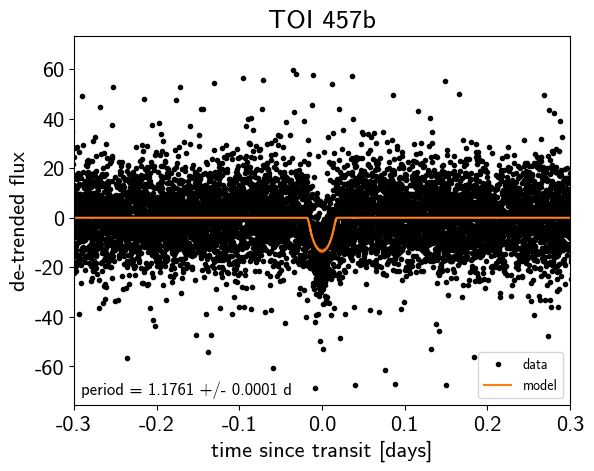

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

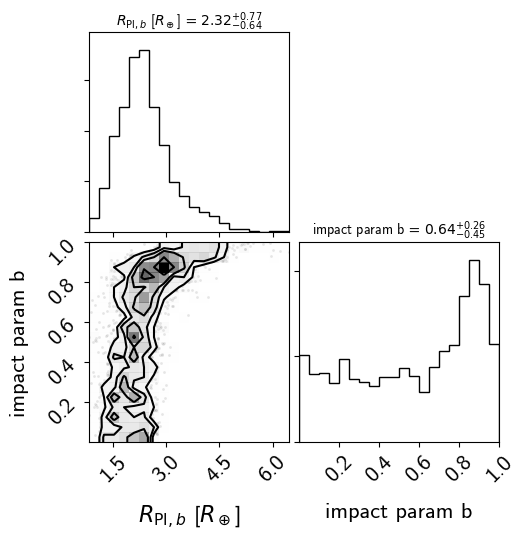

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

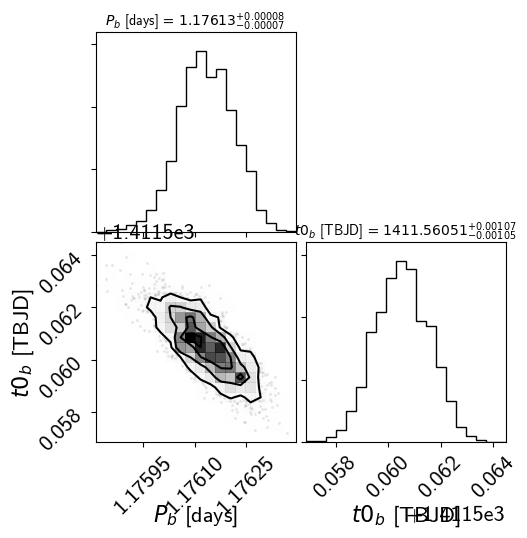

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

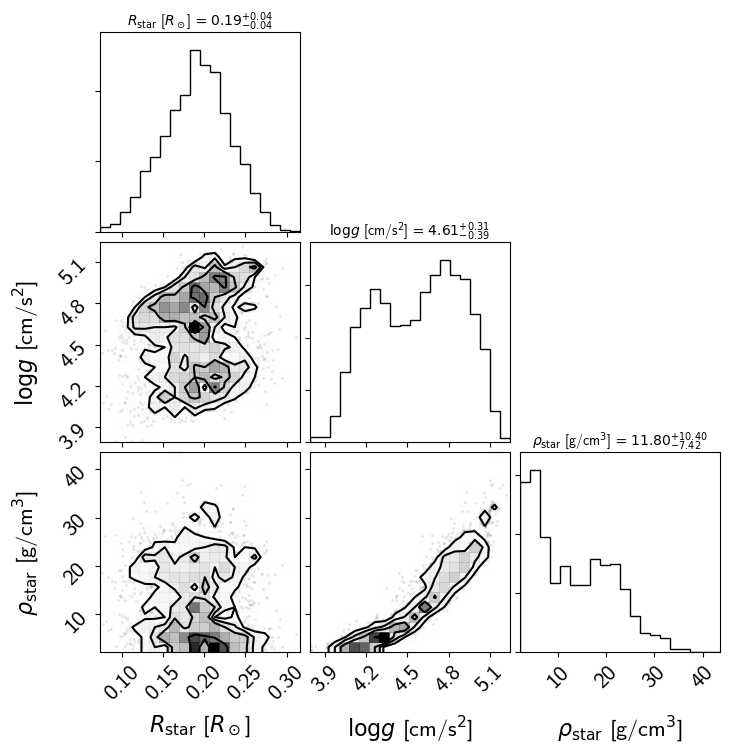

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3